In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.linear_model import LinearRegression
import csv
from keras.models import load_model
from pkg_resources import resource_filename
from spliceai.utils import one_hot_encode
from maxentpy import maxent
from collections import Counter
import itertools

Using TensorFlow backend.


In [2]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
import os.path as op

In [4]:
import seaborn as sns

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp
import splanl.custom_splai_scores as css
import splanl.create_vcf as vcf

In [7]:
chr11 = '/nfs/kitzman3/lab_common/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 0 ]

In [8]:
fa_file = '/nfs/kitzman2/jacob/proj/jensplice/20220415_wt1_mpsa_trial3/jkp1053_1054_1055.fa'
refseq = pp.get_refseq( fa_file )[ 0 ]

In [9]:
isos_in = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [10]:
isos_df = pd.read_table( isos_in + 'wt1_ex9_isoforms_2022-0607.txt' )

In [11]:
isos_df = isos_df.set_index( 'isonum' )

In [12]:
bdout = isos_in

In [13]:
satbls = ! ls /nfs/turbo/umms-kitzmanj/oldvol2/jacob/proj/jensplice/20220426_wt1_subasm_filter_stringent/sapipe/sa/*.haps.final.txt

In [14]:
satbl_fn = { sa.split( '/')[ -1 ].split( '.' )[ 0 ]: pd.read_table( sa ).set_index( 'readgroupid' ) for sa in satbls }

In [15]:
for lib in satbl_fn.keys():
    
    satbl_fn[ lib ] = satbl_fn[ lib ][ [ col for col in satbl_fn[ lib ] if not col.startswith( 'nbp_' ) ] ].copy()

In [16]:
bybc_tbl_l = ! ls /nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/wt1_ex9_*_by_bc_effects_allvars-2022-0609.txt

In [17]:
bybc_tbl_fn = { tbl.split( '/' )[ -1 ].split( '_' )[ 2 ]: pd.read_table( tbl )
                for tbl in bybc_tbl_l }

In [18]:
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ ( bybc_tbl_fn[ lib ].n_variants_passing == 1 ) ].copy()

In [19]:
byvartbl_allisos = pd.read_table( '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/wt1_ex9_by_var_effects_allisos_snvs-2022-0609.txt' )

In [20]:
byvartbl_long = pd.read_table( bdout + 'wt1_ex9_by_var_effects_snvs-2022-0609.txt' )

In [21]:
#extra variants in 5' end of intronic region - just get rid of them right away bc they're confusing
byvartbl_long = byvartbl_long.loc[ byvartbl_long.pos >= 1227 ].copy()

In [22]:
byvartbl_long[ 'sample' ].unique()

array(['BB_test_Cos1053_JKLab0340_MM1B', 'BB_test_Cos1053_JKLab0340_MM2B',
       'BB_test_Cos1053_oligodT_MM1B', 'BB_test_Cos1053_oligodT_MM2B',
       'BB_RT_1_340_243_Cos1053', 'BB_RT_1_340_243_Hek1053',
       'BB_RT_1_340_335_Cos1053', 'BB_RT_1_340_335_Hek1053',
       'BB_RT_1b_340_243_Hek1053', 'BB_RT_1b_340_335_Hek1053',
       'BB_RT_1b_ODT_243_Hek1053', 'BB_RT_1b_ODT_335_Hek1053',
       'BB_RT_1_ODT_243_Cos1053', 'BB_RT_1_ODT_243_Hek1053',
       'BB_RT_1_ODT_335_Cos1053', 'BB_RT_1_ODT_335_Hek1053',
       'BB_RT_2_340_243_Cos1054', 'BB_RT_2_340_243_Hek1054',
       'BB_RT_2_340_335_Cos1054', 'BB_RT_2_340_335_Hek1054',
       'BB_RT_2_ODT_243_Cos1054', 'BB_RT_2_ODT_243_Hek1054',
       'BB_RT_2_ODT_335_Cos1054', 'BB_RT_2_ODT_335_Hek1054',
       'BB_RT_3_340_243_Cos1055', 'BB_RT_3_340_243_Hek1055',
       'BB_RT_3_340_335_Cos1055', 'BB_RT_3_340_335_Hek1055',
       'BB_RT_3_ODT_243_Cos1055', 'BB_RT_3_ODT_243_Hek1055',
       'BB_RT_3_ODT_335_cos1055', 'BB_RT_3_ODT_335_Hek105

BB_test_Cos1053_JKLab0340_MM1B


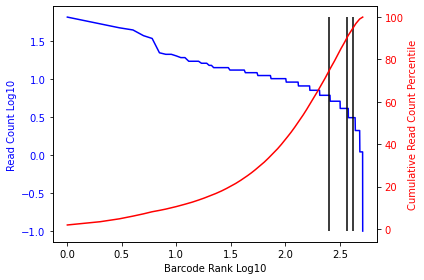

The read count cut off at the 75 th percentile is 6
The read count cut off at the 90 th percentile is 4
The read count cut off at the 95 th percentile is 3
BB_test_Cos1053_JKLab0340_MM2B


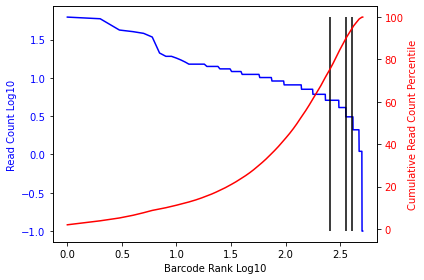

The read count cut off at the 75 th percentile is 5
The read count cut off at the 90 th percentile is 3
The read count cut off at the 95 th percentile is 3
BB_test_Cos1053_oligodT_MM1B


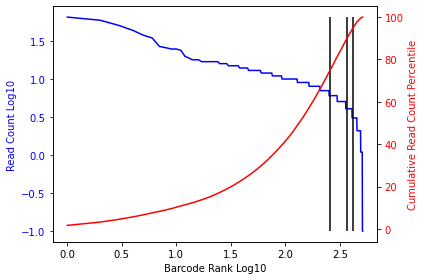

The read count cut off at the 75 th percentile is 6
The read count cut off at the 90 th percentile is 4
The read count cut off at the 95 th percentile is 3
BB_test_Cos1053_oligodT_MM2B


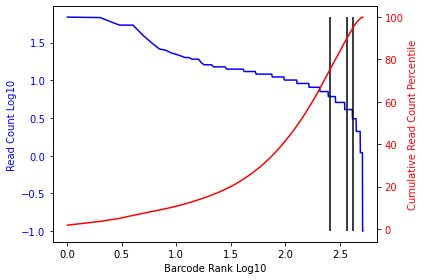

The read count cut off at the 75 th percentile is 6
The read count cut off at the 90 th percentile is 4
The read count cut off at the 95 th percentile is 3
BB_RT_1_340_243_Cos1053


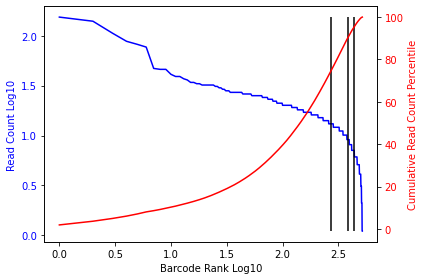

The read count cut off at the 75 th percentile is 13
The read count cut off at the 90 th percentile is 9
The read count cut off at the 95 th percentile is 7
BB_RT_1_340_243_Hek1053


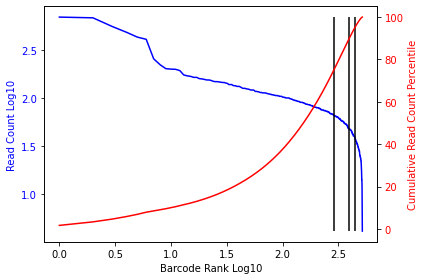

The read count cut off at the 75 th percentile is 66
The read count cut off at the 90 th percentile is 48
The read count cut off at the 95 th percentile is 39
BB_RT_1_340_335_Cos1053


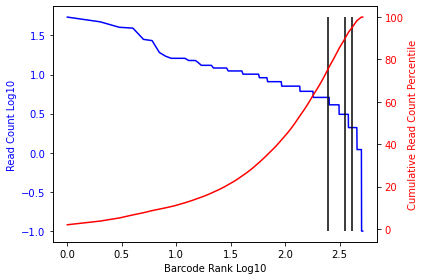

The read count cut off at the 75 th percentile is 5
The read count cut off at the 90 th percentile is 3
The read count cut off at the 95 th percentile is 2
BB_RT_1_340_335_Hek1053


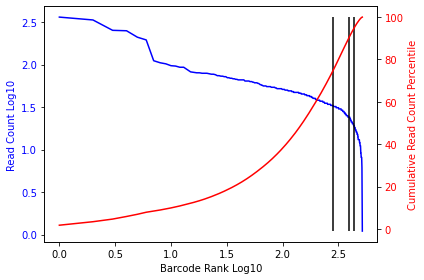

The read count cut off at the 75 th percentile is 32
The read count cut off at the 90 th percentile is 24
The read count cut off at the 95 th percentile is 19
BB_RT_1b_340_243_Hek1053


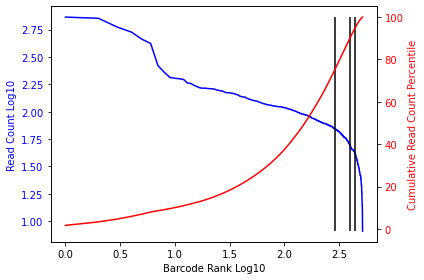

The read count cut off at the 75 th percentile is 70
The read count cut off at the 90 th percentile is 50
The read count cut off at the 95 th percentile is 41
BB_RT_1b_340_335_Hek1053


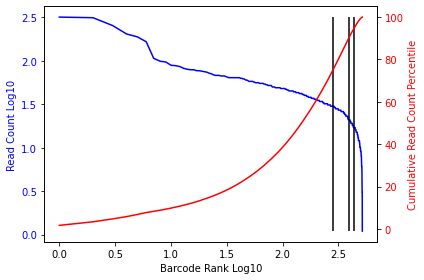

The read count cut off at the 75 th percentile is 30
The read count cut off at the 90 th percentile is 21
The read count cut off at the 95 th percentile is 17
BB_RT_1b_ODT_243_Hek1053


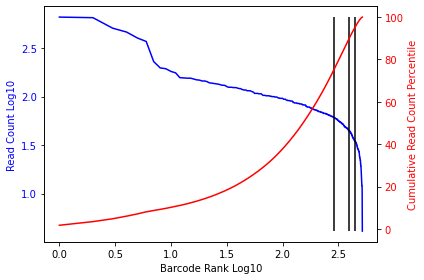

The read count cut off at the 75 th percentile is 61
The read count cut off at the 90 th percentile is 44
The read count cut off at the 95 th percentile is 35
BB_RT_1b_ODT_335_Hek1053


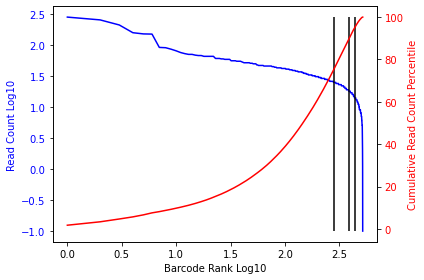

The read count cut off at the 75 th percentile is 25
The read count cut off at the 90 th percentile is 18
The read count cut off at the 95 th percentile is 14
BB_RT_1_ODT_243_Cos1053


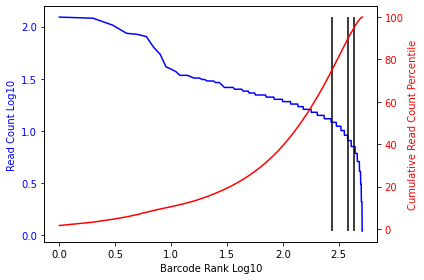

The read count cut off at the 75 th percentile is 12
The read count cut off at the 90 th percentile is 8
The read count cut off at the 95 th percentile is 7
BB_RT_1_ODT_243_Hek1053


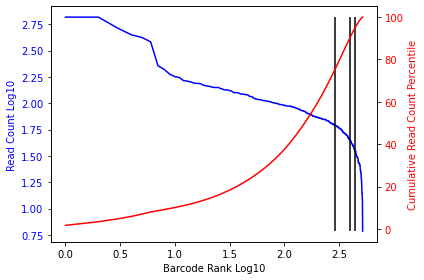

The read count cut off at the 75 th percentile is 62
The read count cut off at the 90 th percentile is 45
The read count cut off at the 95 th percentile is 35
BB_RT_1_ODT_335_Cos1053


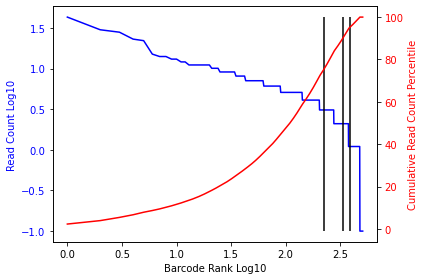

The read count cut off at the 75 th percentile is 3
The read count cut off at the 90 th percentile is 2
The read count cut off at the 95 th percentile is 1
BB_RT_1_ODT_335_Hek1053


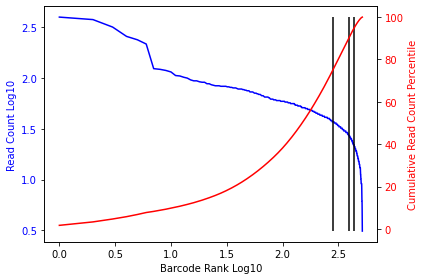

The read count cut off at the 75 th percentile is 37
The read count cut off at the 90 th percentile is 27
The read count cut off at the 95 th percentile is 21
BB_RT_2_340_243_Cos1054


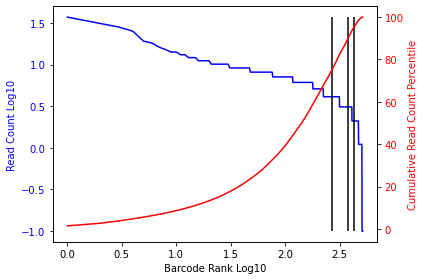

The read count cut off at the 75 th percentile is 4
The read count cut off at the 90 th percentile is 3
The read count cut off at the 95 th percentile is 2
BB_RT_2_340_243_Hek1054


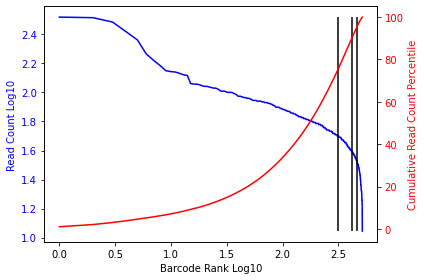

The read count cut off at the 75 th percentile is 50
The read count cut off at the 90 th percentile is 39
The read count cut off at the 95 th percentile is 34
BB_RT_2_340_335_Cos1054


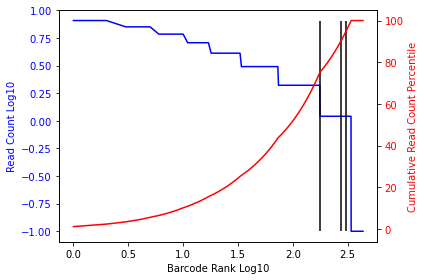

The read count cut off at the 75 th percentile is 2
The read count cut off at the 90 th percentile is 1
The read count cut off at the 95 th percentile is 1
BB_RT_2_340_335_Hek1054


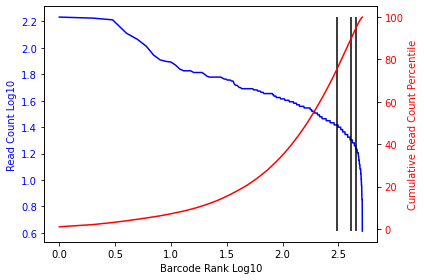

The read count cut off at the 75 th percentile is 26
The read count cut off at the 90 th percentile is 20
The read count cut off at the 95 th percentile is 17
BB_RT_2_ODT_243_Cos1054


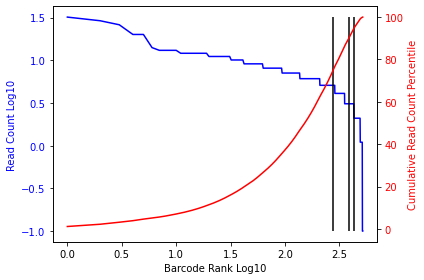

The read count cut off at the 75 th percentile is 5
The read count cut off at the 90 th percentile is 3
The read count cut off at the 95 th percentile is 2
BB_RT_2_ODT_243_Hek1054


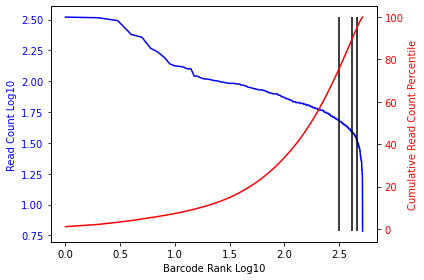

The read count cut off at the 75 th percentile is 48
The read count cut off at the 90 th percentile is 39
The read count cut off at the 95 th percentile is 33
BB_RT_2_ODT_335_Cos1054


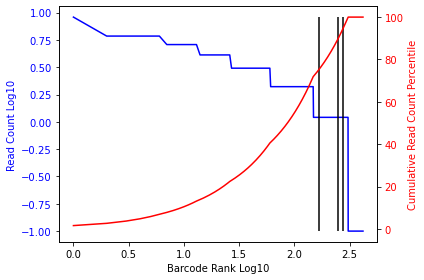

The read count cut off at the 75 th percentile is 1
The read count cut off at the 90 th percentile is 1
The read count cut off at the 95 th percentile is 1
BB_RT_2_ODT_335_Hek1054


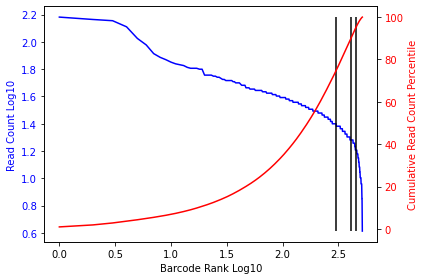

The read count cut off at the 75 th percentile is 24
The read count cut off at the 90 th percentile is 19
The read count cut off at the 95 th percentile is 16
BB_RT_3_340_243_Cos1055


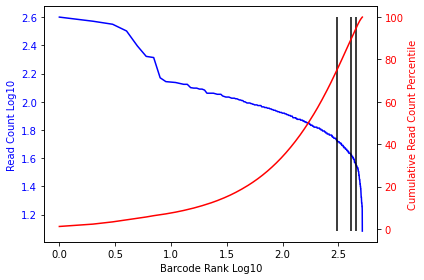

The read count cut off at the 75 th percentile is 53
The read count cut off at the 90 th percentile is 42
The read count cut off at the 95 th percentile is 35
BB_RT_3_340_243_Hek1055


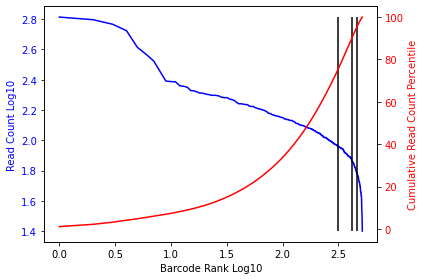

The read count cut off at the 75 th percentile is 91
The read count cut off at the 90 th percentile is 73
The read count cut off at the 95 th percentile is 61
BB_RT_3_340_335_Cos1055


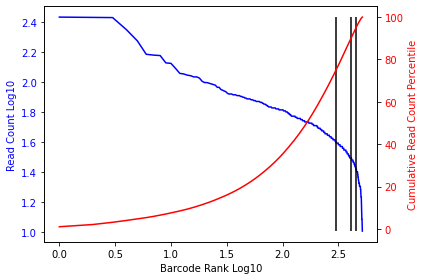

The read count cut off at the 75 th percentile is 39
The read count cut off at the 90 th percentile is 31
The read count cut off at the 95 th percentile is 26
BB_RT_3_340_335_Hek1055


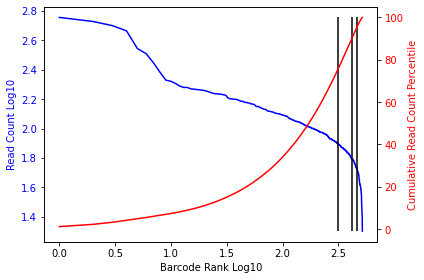

The read count cut off at the 75 th percentile is 79
The read count cut off at the 90 th percentile is 62
The read count cut off at the 95 th percentile is 54
BB_RT_3_ODT_243_Cos1055


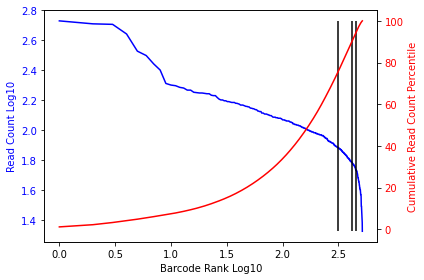

The read count cut off at the 75 th percentile is 77
The read count cut off at the 90 th percentile is 61
The read count cut off at the 95 th percentile is 53
BB_RT_3_ODT_243_Hek1055


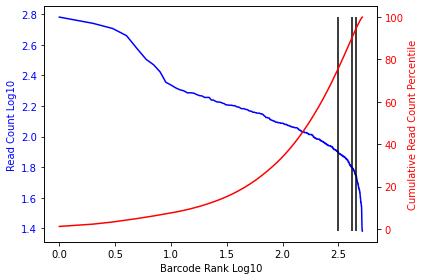

The read count cut off at the 75 th percentile is 80
The read count cut off at the 90 th percentile is 63
The read count cut off at the 95 th percentile is 54
BB_RT_3_ODT_335_cos1055


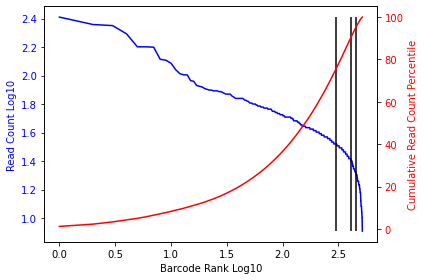

The read count cut off at the 75 th percentile is 33
The read count cut off at the 90 th percentile is 26
The read count cut off at the 95 th percentile is 21
BB_RT_3_ODT_335_Hek1055


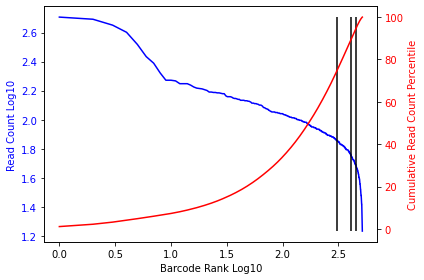

The read count cut off at the 75 th percentile is 71
The read count cut off at the 90 th percentile is 56
The read count cut off at the 95 th percentile is 47


In [23]:
bc_cutoffs_d = { 'sample': [],
                 '75_x': [],
                 '90_x': [],
                 '95_x': [],
                 '75_y': [],
                 '90_y': [],
                 '95_y': [], }

for samp in byvartbl_long[ 'sample' ].unique():
    
    print(samp)
    
    bc_cutoffs_d[ 'sample' ].append( samp )
    
    x_cuts,y_cuts = sp.waterfall_plot( byvartbl_long.loc[ byvartbl_long[ 'sample' ] == samp ],
                                       'n_bc_passfilt',
                                       [ 75, 90, 95 ] )
    
    for cut in x_cuts:

        bc_cutoffs_d[ str( cut ) + '_x' ].append( 10**( x_cuts[ cut ] ) )
        bc_cutoffs_d[ str( cut ) + '_y' ].append( y_cuts[ cut ] )

In [24]:
bc_cutoffs = pd.DataFrame( bc_cutoffs_d )

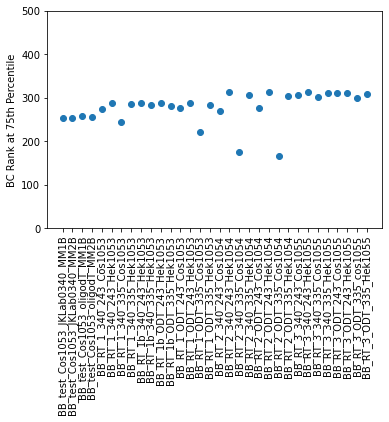

In [25]:
plt.scatter( bc_cutoffs[ 'sample' ],
             bc_cutoffs[ '75_x' ] )

plt.xticks( rotation = 90 )

plt.ylabel( 'BC Rank at 75th Percentile' )

plt.ylim( 0, 500 )

plt.show()

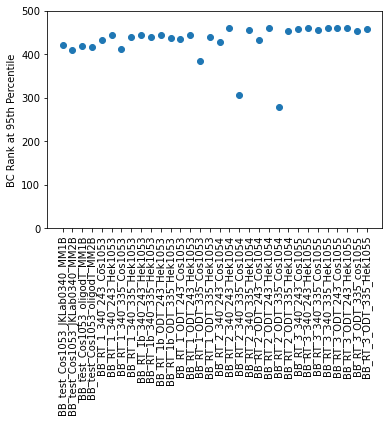

In [26]:
plt.scatter( bc_cutoffs[ 'sample' ],
             bc_cutoffs[ '95_x' ] )

plt.xticks( rotation = 90 )

plt.ylabel( 'BC Rank at 95th Percentile' )

plt.ylim( 0, 500 )

plt.show()

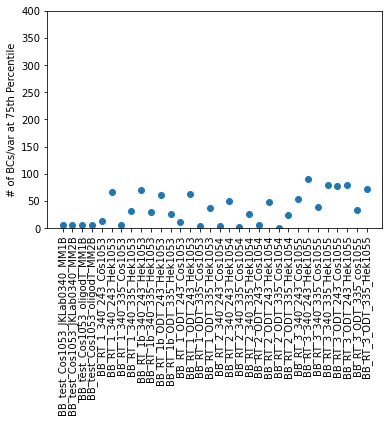

In [27]:
plt.scatter( bc_cutoffs[ 'sample' ],
             bc_cutoffs[ '75_y' ] )

plt.xticks( rotation = 90 )

plt.ylabel( '# of BCs/var at 75th Percentile')

plt.ylim( ( 0, 400 ) )

plt.show()

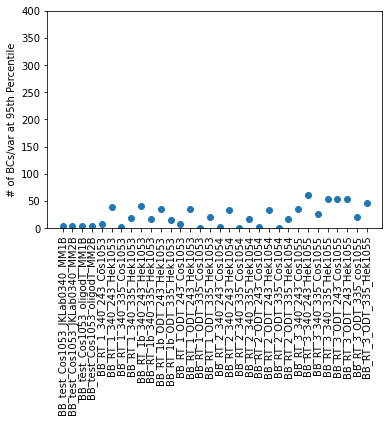

In [28]:
plt.scatter( bc_cutoffs[ 'sample' ],
             bc_cutoffs[ '95_y' ] )

plt.xticks( rotation = 90 )

plt.ylabel( '# of BCs/var at 95th Percentile')

plt.ylim( ( 0, 400 ) )

plt.show()

In [29]:
samp_by_rep_fn = {}

for samp in byvartbl_long['sample'].unique().tolist():
    
    if '_test_' in samp:
        rep = 'test'
    else:
        rep = samp.split( '_' )[ 2 ]
        
    if rep in samp_by_rep_fn:
        samp_by_rep_fn[ rep ].append( samp )
    else:
        samp_by_rep_fn[ rep ] = [ samp ]

In [30]:
byvartbl_long[ 'rep' ] = [ 'test' if '_test_' in samp else samp.split( '_' )[ 2 ]
                           for samp in byvartbl_long[ 'sample' ] ]

In [31]:
sample_stats = pp.across_sample_stats( [ byvartbl_long.loc[ ( byvartbl_long.pos >= 1227 ) & ( byvartbl_long.rep == rep ) ] for rep in samp_by_rep_fn ],
                                        samp_by_rep_fn,
                                        [ 'wmean_OTHER', 'wmean_SKIP', 'wmean_KTS+', 'wmean_KTS-' ]
                                       ) 

In [46]:
colors = { '1':'green', '1b':'blue', '2':'red', '3':'orange', 'test':'purple' }

per_var_seen


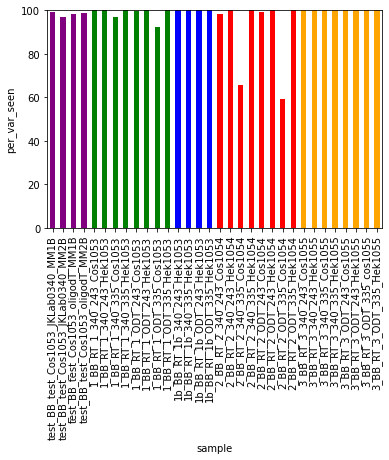

per_reads_passfilt


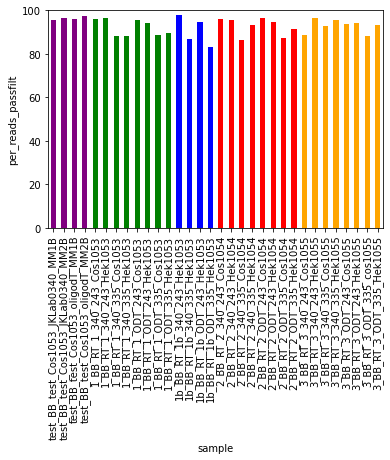

per_bc_passfilt


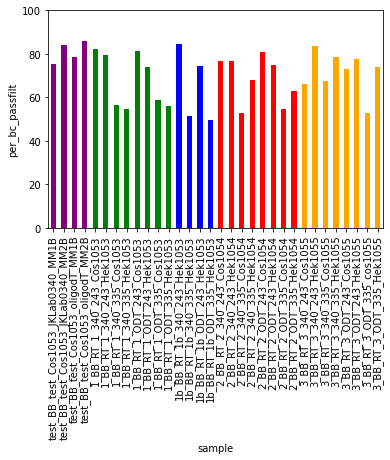

per_usable


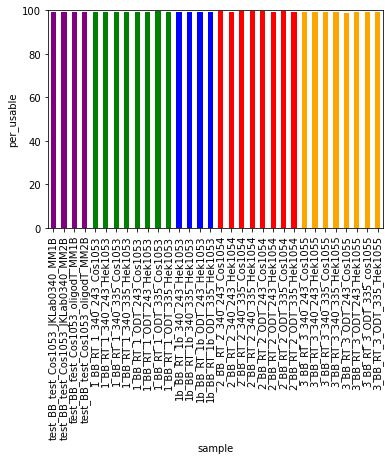

per_unmapped


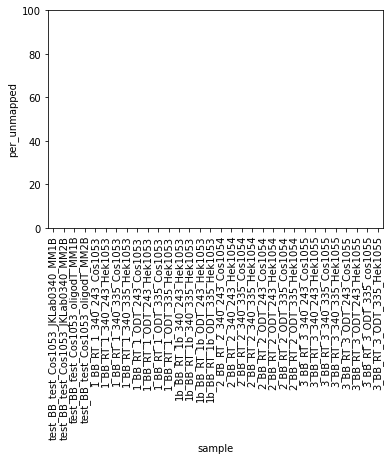

per_badstart


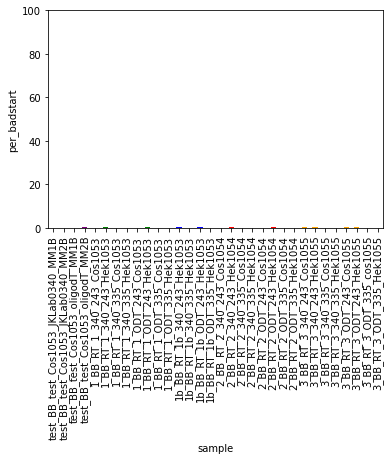

per_badend


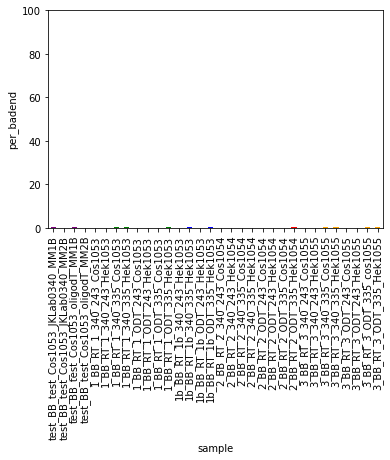

per_softclip


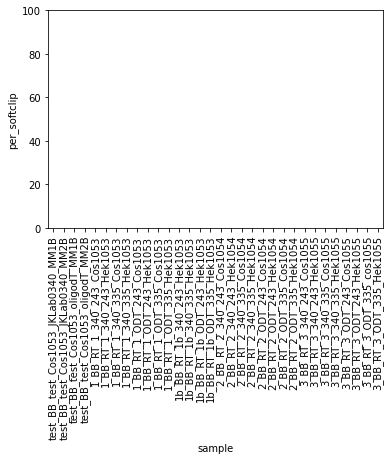

per_otheriso


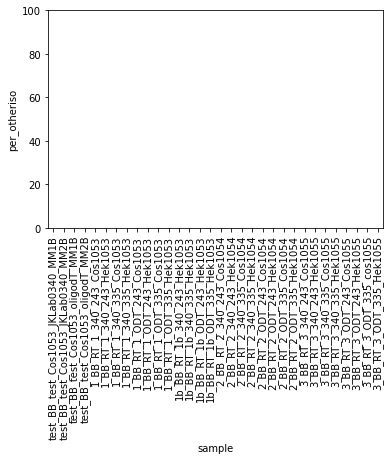

All missing for per_sdv - skipping...
All missing for per_sdv_ex - skipping...
All missing for per_sdv_in - skipping...
All missing for per_acc_used - skipping...
All missing for per_don_used - skipping...


In [33]:
for col in [ col for col in sample_stats if col.startswith( 'per_' ) ]:
    
    if sample_stats[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats,
                                   col,
                                   y_label = col,
                                   y_lim = ( 0, 100 ),
                                    color_col = 'sample_group',
                                    color_dict = colors,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

per_unmapped


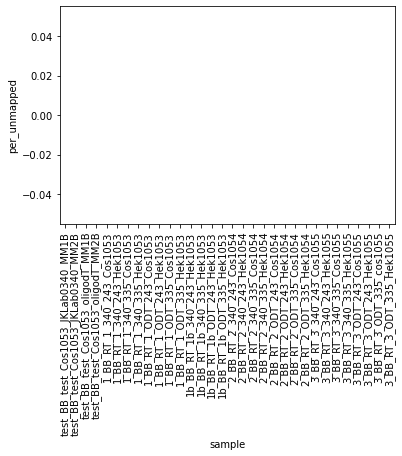

per_badstart


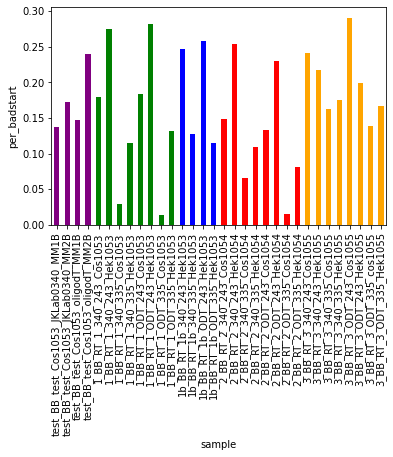

per_badend


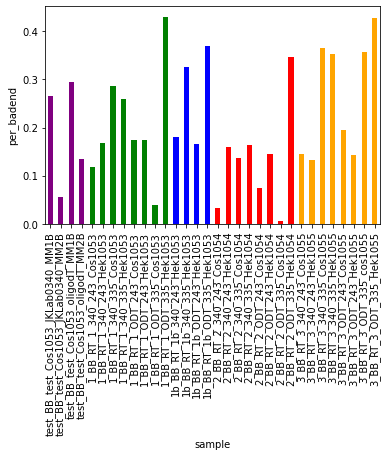

per_softclip


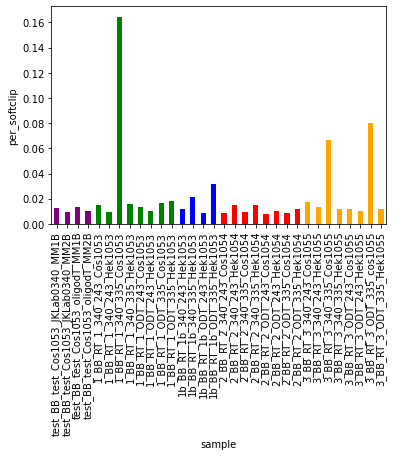

per_otheriso


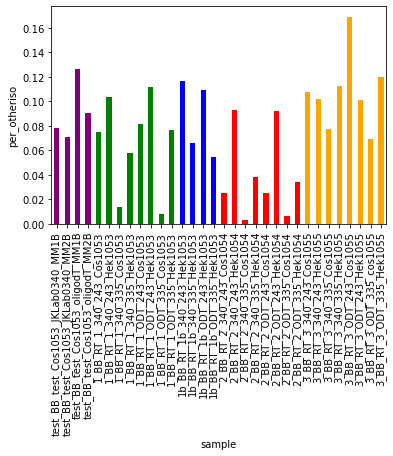

All missing for per_sdv - skipping...
All missing for per_sdv_ex - skipping...
All missing for per_sdv_in - skipping...
All missing for per_acc_used - skipping...
All missing for per_don_used - skipping...


In [34]:
for col in [ col for col in sample_stats if col.startswith( 'per_' ) ]:
    
    if sample_stats[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    elif sample_stats[ col ].max() > 50:
        
        continue
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats,
                                   col,
                                   y_label = col,
                                   #y_lim = ( 0, 100 ),
                                    color_col = 'sample_group',
                                    color_dict = colors,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

psbl_var


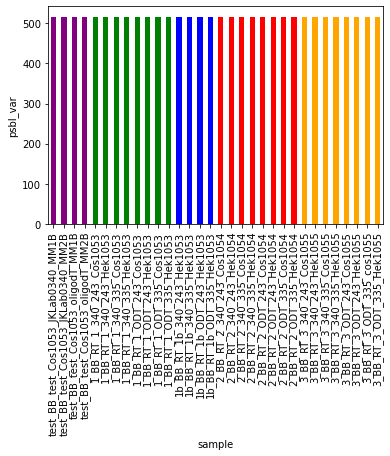

n_var


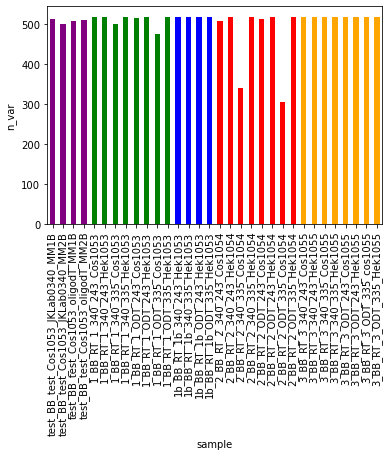

All missing for n_var_ex - skipping...
All missing for n_var_in - skipping...
n_reads


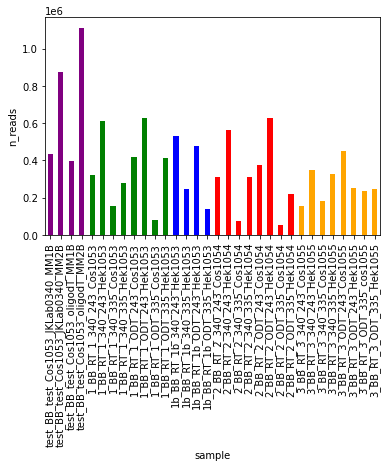

n_reads_passfilt


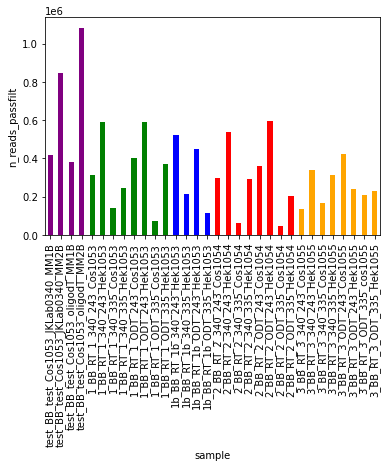

n_usable_reads


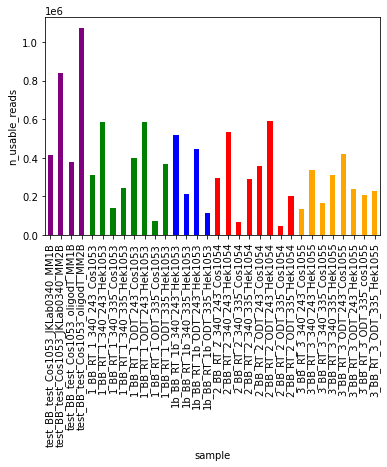

n_bc


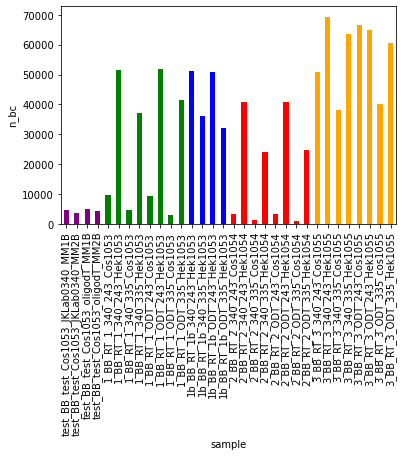

n_bc_passfilt


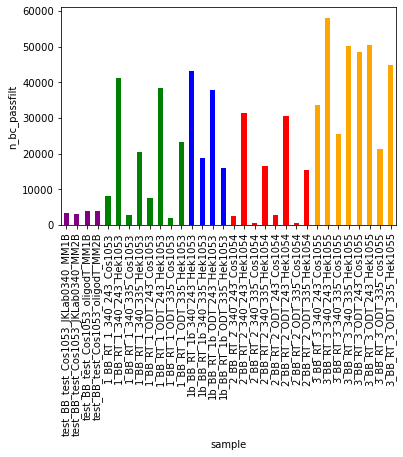

n_unmapped


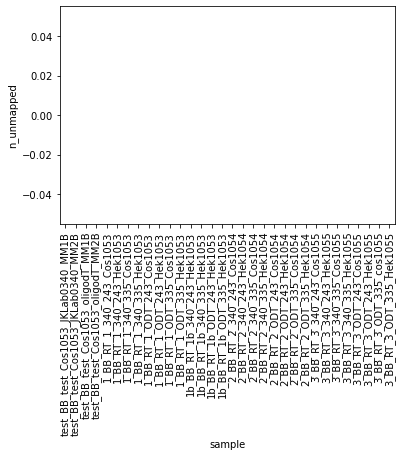

n_badstart


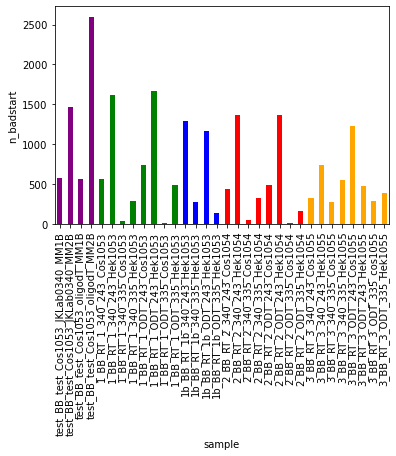

n_badend


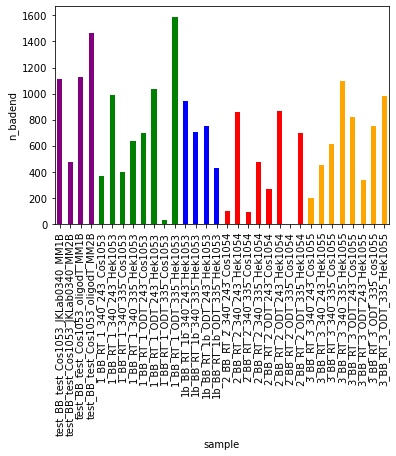

n_softclip


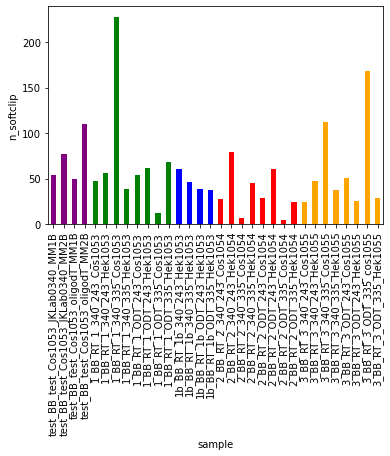

n_otheriso


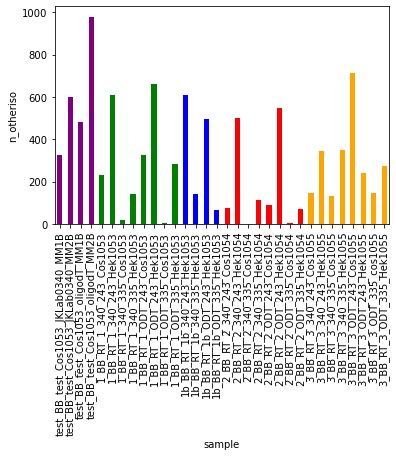

All missing for n_sdv - skipping...
All missing for n_sdv_ex - skipping...
All missing for n_sdv_in - skipping...
All missing for psbl_alt_acc - skipping...
All missing for psbl_alt_don - skipping...
All missing for n_alt_acc - skipping...
All missing for n_alt_don - skipping...
med_wmean_OTHER


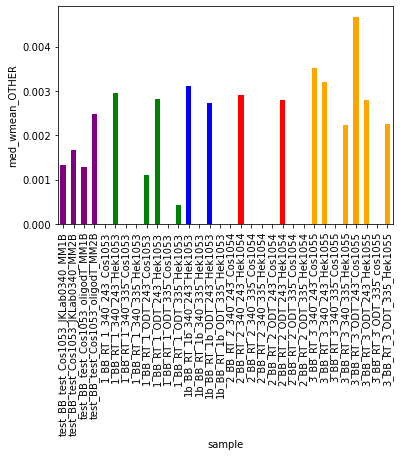

med_wmean_SKIP


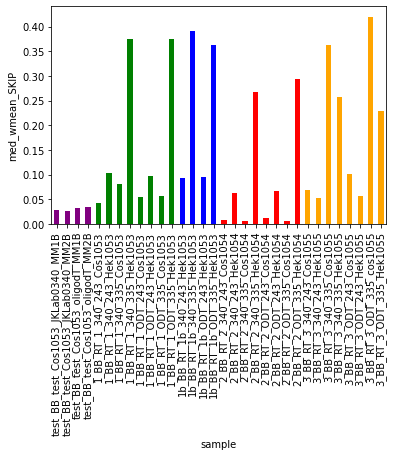

med_wmean_KTS+


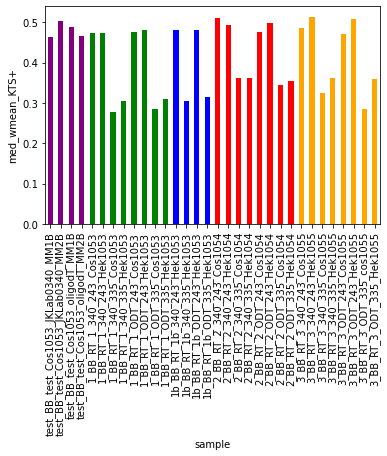

med_wmean_KTS-


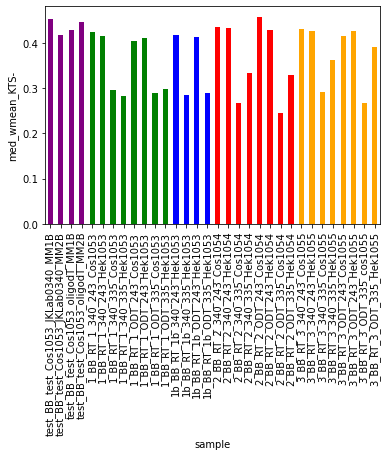

In [35]:
for col in [ col for col in sample_stats if not col.startswith( 'per_' ) ]:
    
    if sample_stats[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    elif 'sample' in col:
        continue
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats,
                                   col,
                                   y_label = col,
                                   #y_lim = ( 0, 100 ),
                                    color_col = 'sample_group',
                                    color_dict = colors,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

med_wmean_OTHER


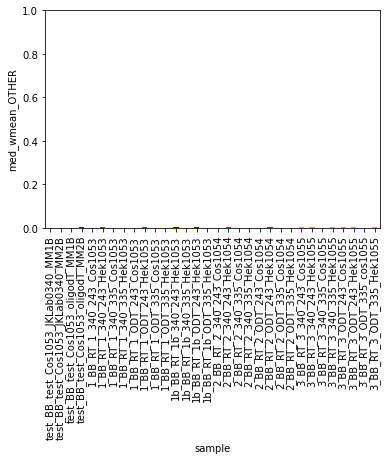

med_wmean_SKIP


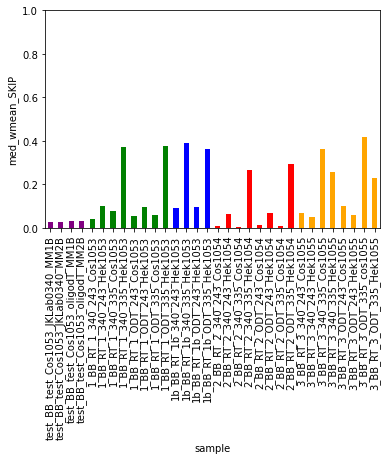

med_wmean_KTS+


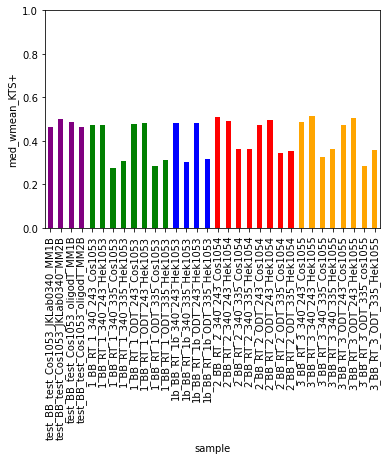

med_wmean_KTS-


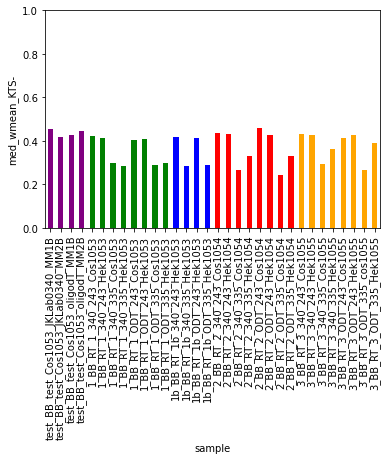

In [36]:
for col in [ col for col in sample_stats if col.startswith( 'med_' ) ]:
    
    if sample_stats[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats,
                                   col,
                                   y_label = col,
                                   y_lim = ( 0, 1 ),
                                    color_col = 'sample_group',
                                    color_dict = colors,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

In [37]:
sample_stats[ 'sample_group_primer' ] = sample_stats[ 'sample' ].apply( lambda x: x.split( '_' )[ -2 ] if 'test' not in x else 'test' )

In [38]:
colors2 = { '243':'green', '335':'red', 'test':'purple' }

med_wmean_OTHER


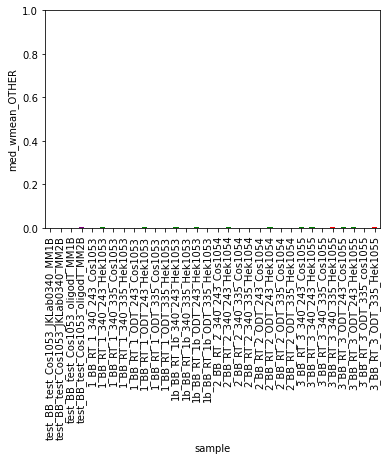

med_wmean_SKIP


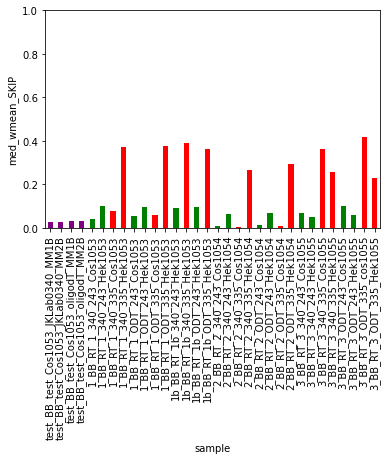

med_wmean_KTS+


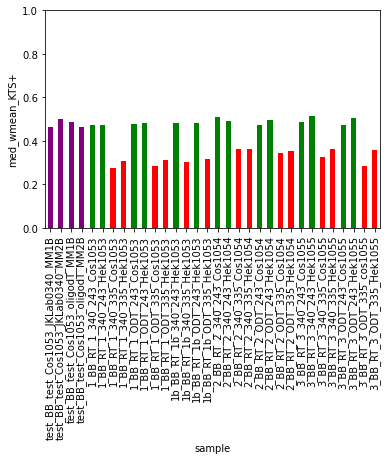

med_wmean_KTS-


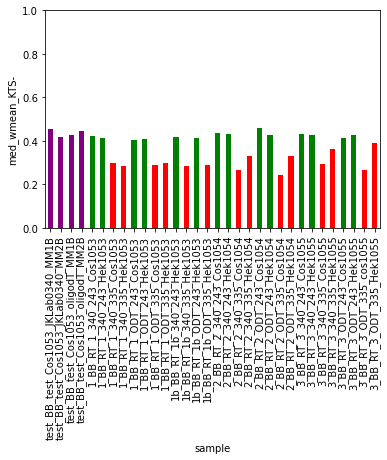

In [39]:
#same as above but colored by primer
for col in [ col for col in sample_stats if col.startswith( 'med_' ) ]:
    
    if sample_stats[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats,
                                   col,
                                   y_label = col,
                                   y_lim = ( 0, 1 ),
                                    color_col = 'sample_group_primer',
                                    color_dict = colors2,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

In [44]:
#seeing a big difference in SKIP - lets only keep 243 samples..
byvartbl_long = byvartbl_long.loc[ byvartbl_long[ 'sample' ].str.contains( '_243_' ) ].copy()

In [49]:
samp_filt_by_rep_fn = {}

for samp in byvartbl_long['sample'].unique().tolist():
    
    if '_test_' in samp:
        rep = 'test'
    else:
        rep = samp.split( '_' )[ 2 ]
        
    if rep in samp_filt_by_rep_fn:
        samp_filt_by_rep_fn[ rep ].append( samp )
    else:
        samp_filt_by_rep_fn[ rep ] = [ samp ]

In [53]:
sample_stats_filt = pp.across_sample_stats( [ byvartbl_long.loc[ ( byvartbl_long.rep == rep ) ] for rep in samp_filt_by_rep_fn ],
                                        samp_filt_by_rep_fn,
                                        [ 'wmean_OTHER', 'wmean_SKIP', 'wmean_KTS+', 'wmean_KTS-' ]
                                       ) 

psbl_var


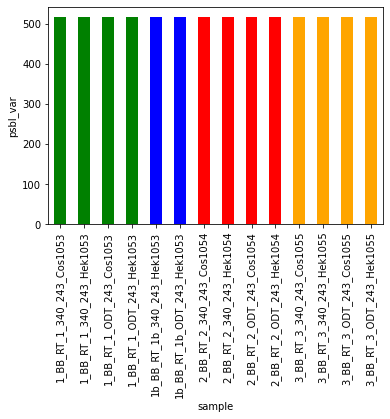

n_var


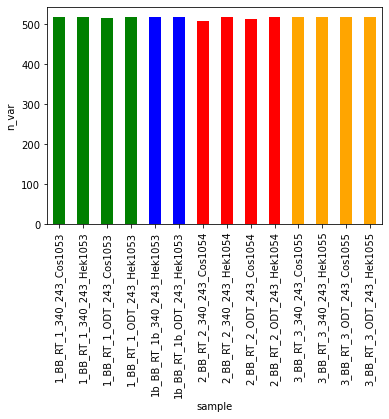

All missing for n_var_ex - skipping...
All missing for n_var_in - skipping...
n_reads


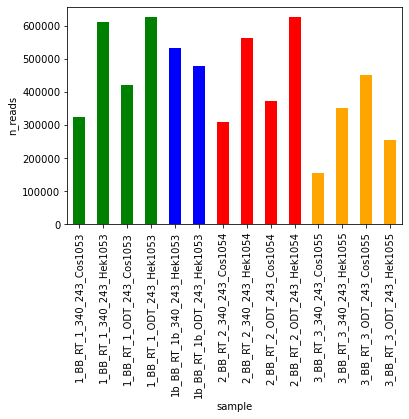

n_reads_passfilt


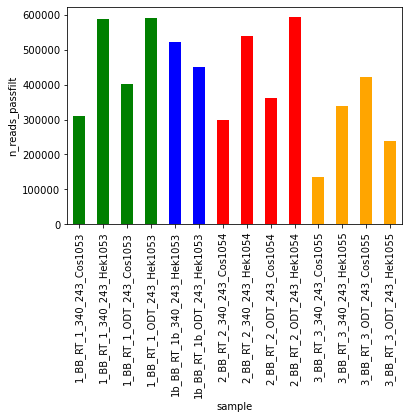

n_usable_reads


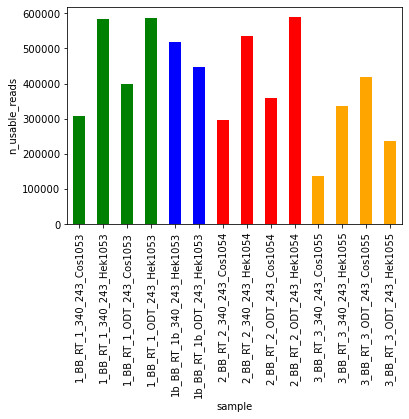

n_bc


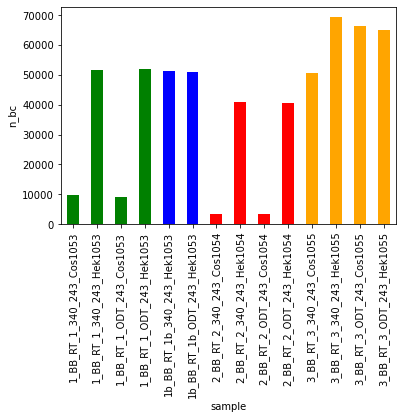

n_bc_passfilt


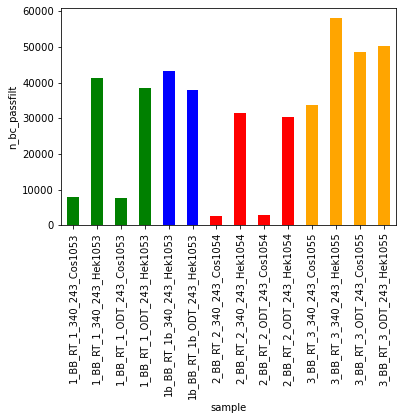

n_unmapped


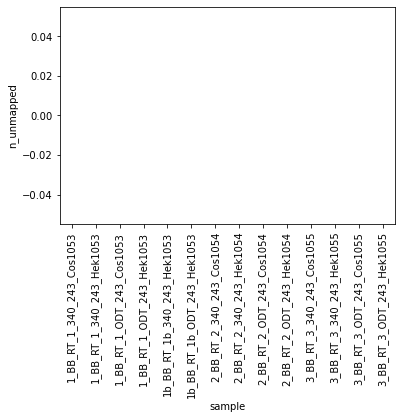

n_badstart


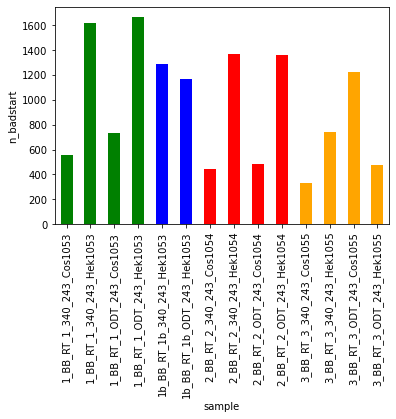

n_badend


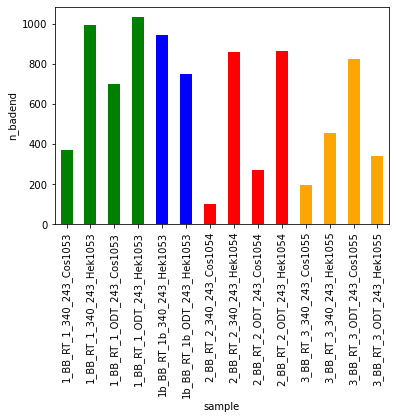

n_softclip


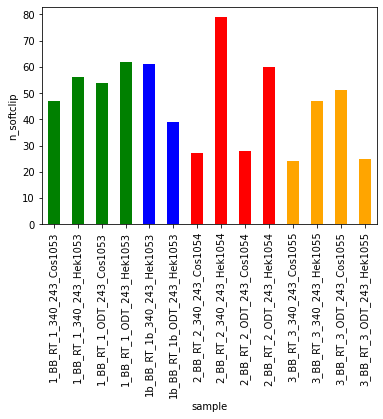

n_otheriso


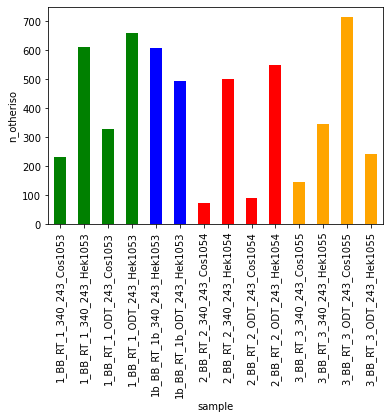

All missing for n_sdv - skipping...
All missing for n_sdv_ex - skipping...
All missing for n_sdv_in - skipping...
All missing for psbl_alt_acc - skipping...
All missing for psbl_alt_don - skipping...
All missing for n_alt_acc - skipping...
All missing for n_alt_don - skipping...
med_wmean_OTHER


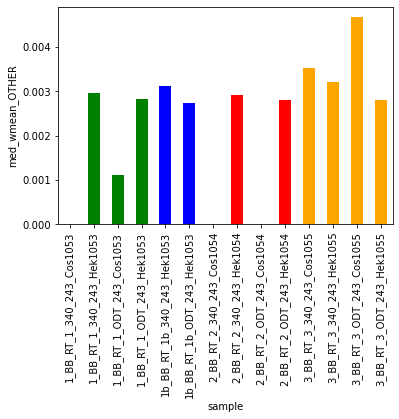

med_wmean_SKIP


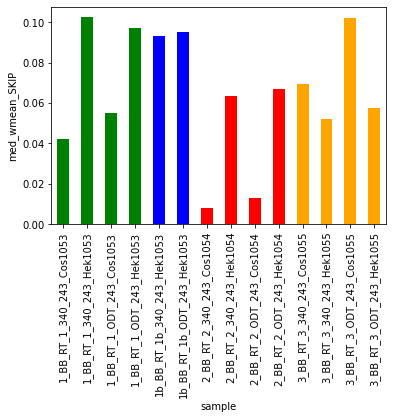

med_wmean_KTS+


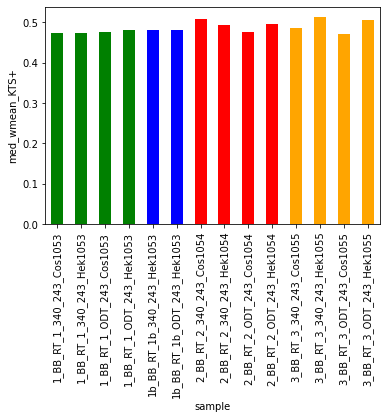

med_wmean_KTS-


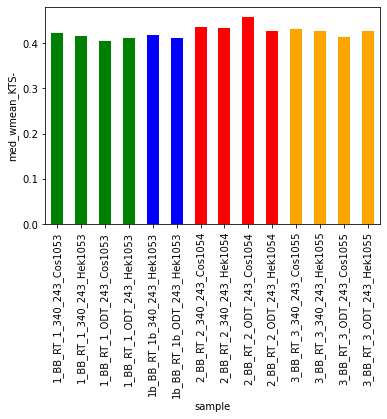

In [54]:
for col in [ col for col in sample_stats_filt if not col.startswith( 'per_' ) ]:
    
    if sample_stats_filt[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    elif 'sample' in col:
        continue
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats_filt,
                                   col,
                                   y_label = col,
                                   #y_lim = ( 0, 100 ),
                                    color_col = 'sample_group',
                                    color_dict = colors,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

In [56]:
bad_samps = []

for samp in byvartbl_long[ 'sample' ].unique():
    
    print( samp )
    
    print( byvartbl_long.loc[ ( byvartbl_long[ 'sample' ] == samp ) ].n_bc_passfilt.median() )
    
    if byvartbl_long.loc[ ( byvartbl_long[ 'sample' ] == samp ) ].n_bc_passfilt.median() <= 50:
        
        bad_samps.append( samp )

BB_RT_1_340_243_Cos1053
13.0
BB_RT_1_340_243_Hek1053
71.0
BB_RT_1b_340_243_Hek1053
74.0
BB_RT_1b_ODT_243_Hek1053
64.5
BB_RT_1_ODT_243_Cos1053
13.0
BB_RT_1_ODT_243_Hek1053
66.0
BB_RT_2_340_243_Cos1054
4.0
BB_RT_2_340_243_Hek1054
55.0
BB_RT_2_ODT_243_Cos1054
5.0
BB_RT_2_ODT_243_Hek1054
53.5
BB_RT_3_340_243_Cos1055
59.0
BB_RT_3_340_243_Hek1055
100.0
BB_RT_3_ODT_243_Cos1055
84.0
BB_RT_3_ODT_243_Hek1055
87.0


In [59]:
byvartbl_long[ 'sample' ].apply( lambda x: x not in bad_samps )

2168     False
2169     False
2170     False
2171     False
2172     False
         ...  
16751     True
16752     True
16753     True
16754     True
16755     True
Name: sample, Length: 7246, dtype: bool

In [60]:
byvartbl_long = byvartbl_long.loc[ byvartbl_long[ 'sample' ].apply( lambda x: x not in bad_samps ) ].copy()

In [63]:
sat_dfs = []

for samp in byvartbl_long[ 'sample' ].unique():
    
    sat_samp = pp.saturate_variants( byvartbl_long.loc[ byvartbl_long[ 'sample' ] == samp ],
                                     chr11_seq,
                                     'hg19_pos',
                                      'exon_num',
                                      rev_strand = True )[ 9 ]
    
    sat_samp[ 'sample' ] = samp
    
    sat_dfs.append( sat_samp )

byvartbl_sat = pd.concat( sat_dfs )

In [64]:
#plots get messed up without the vector position included
byvartbl_sat[ 'pos' ] = byvartbl_sat.hg19_pos - 32412079 - 2*( byvartbl_sat.hg19_pos - byvartbl_sat.hg19_pos.min() )

In [65]:
byvartbl_sat[ 'hgvs_pos' ] = cds.pos_to_hgvspos( byvartbl_sat.pos,
                                                 ( 1058, 1554 ),
                                                [ (1267, 1359) ],
                                                [ ( 1355, 1447 ), ]
                                                )

In [66]:
github_colors = '3182bd6baed69ecae1c6dbefe6550dfd8d3cfdae6bfdd0a231a35474c476a1d99bc7e9c0756bb19e9ac8bcbddcdadaeb636363969696bdbdbdd9d9d9'

In [67]:
light_colors = [ '#' + github_colors[i:i+6] for i in range( 0, len( github_colors ), 6 ) ]

BB_RT_1_340_243_Hek1053


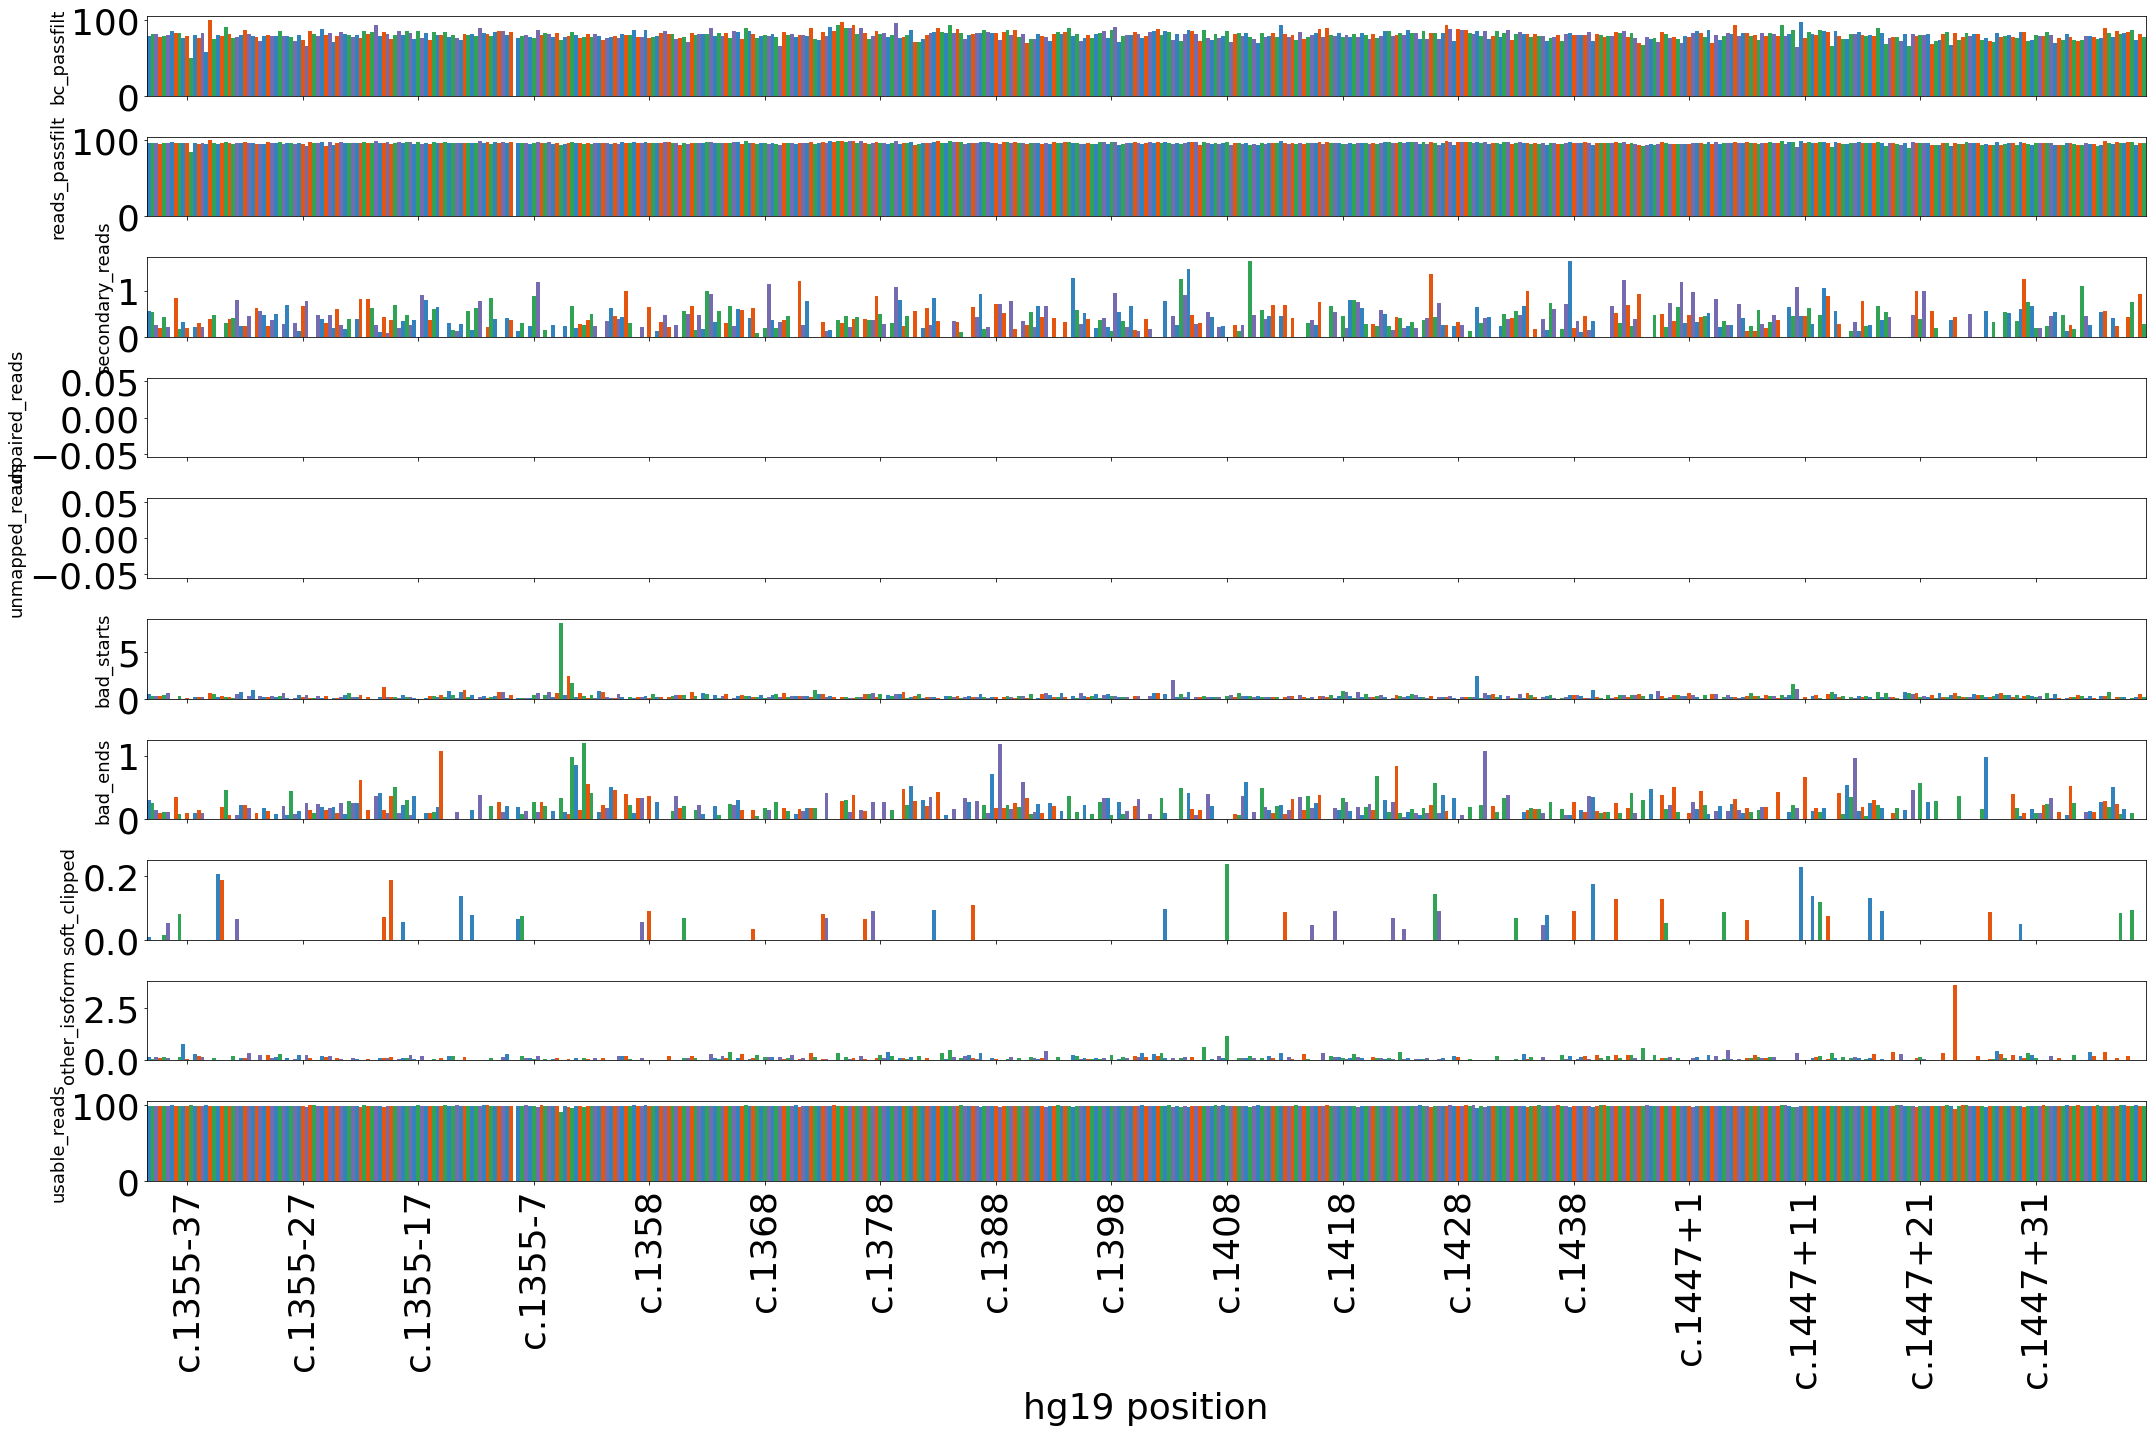

BB_RT_1b_340_243_Hek1053


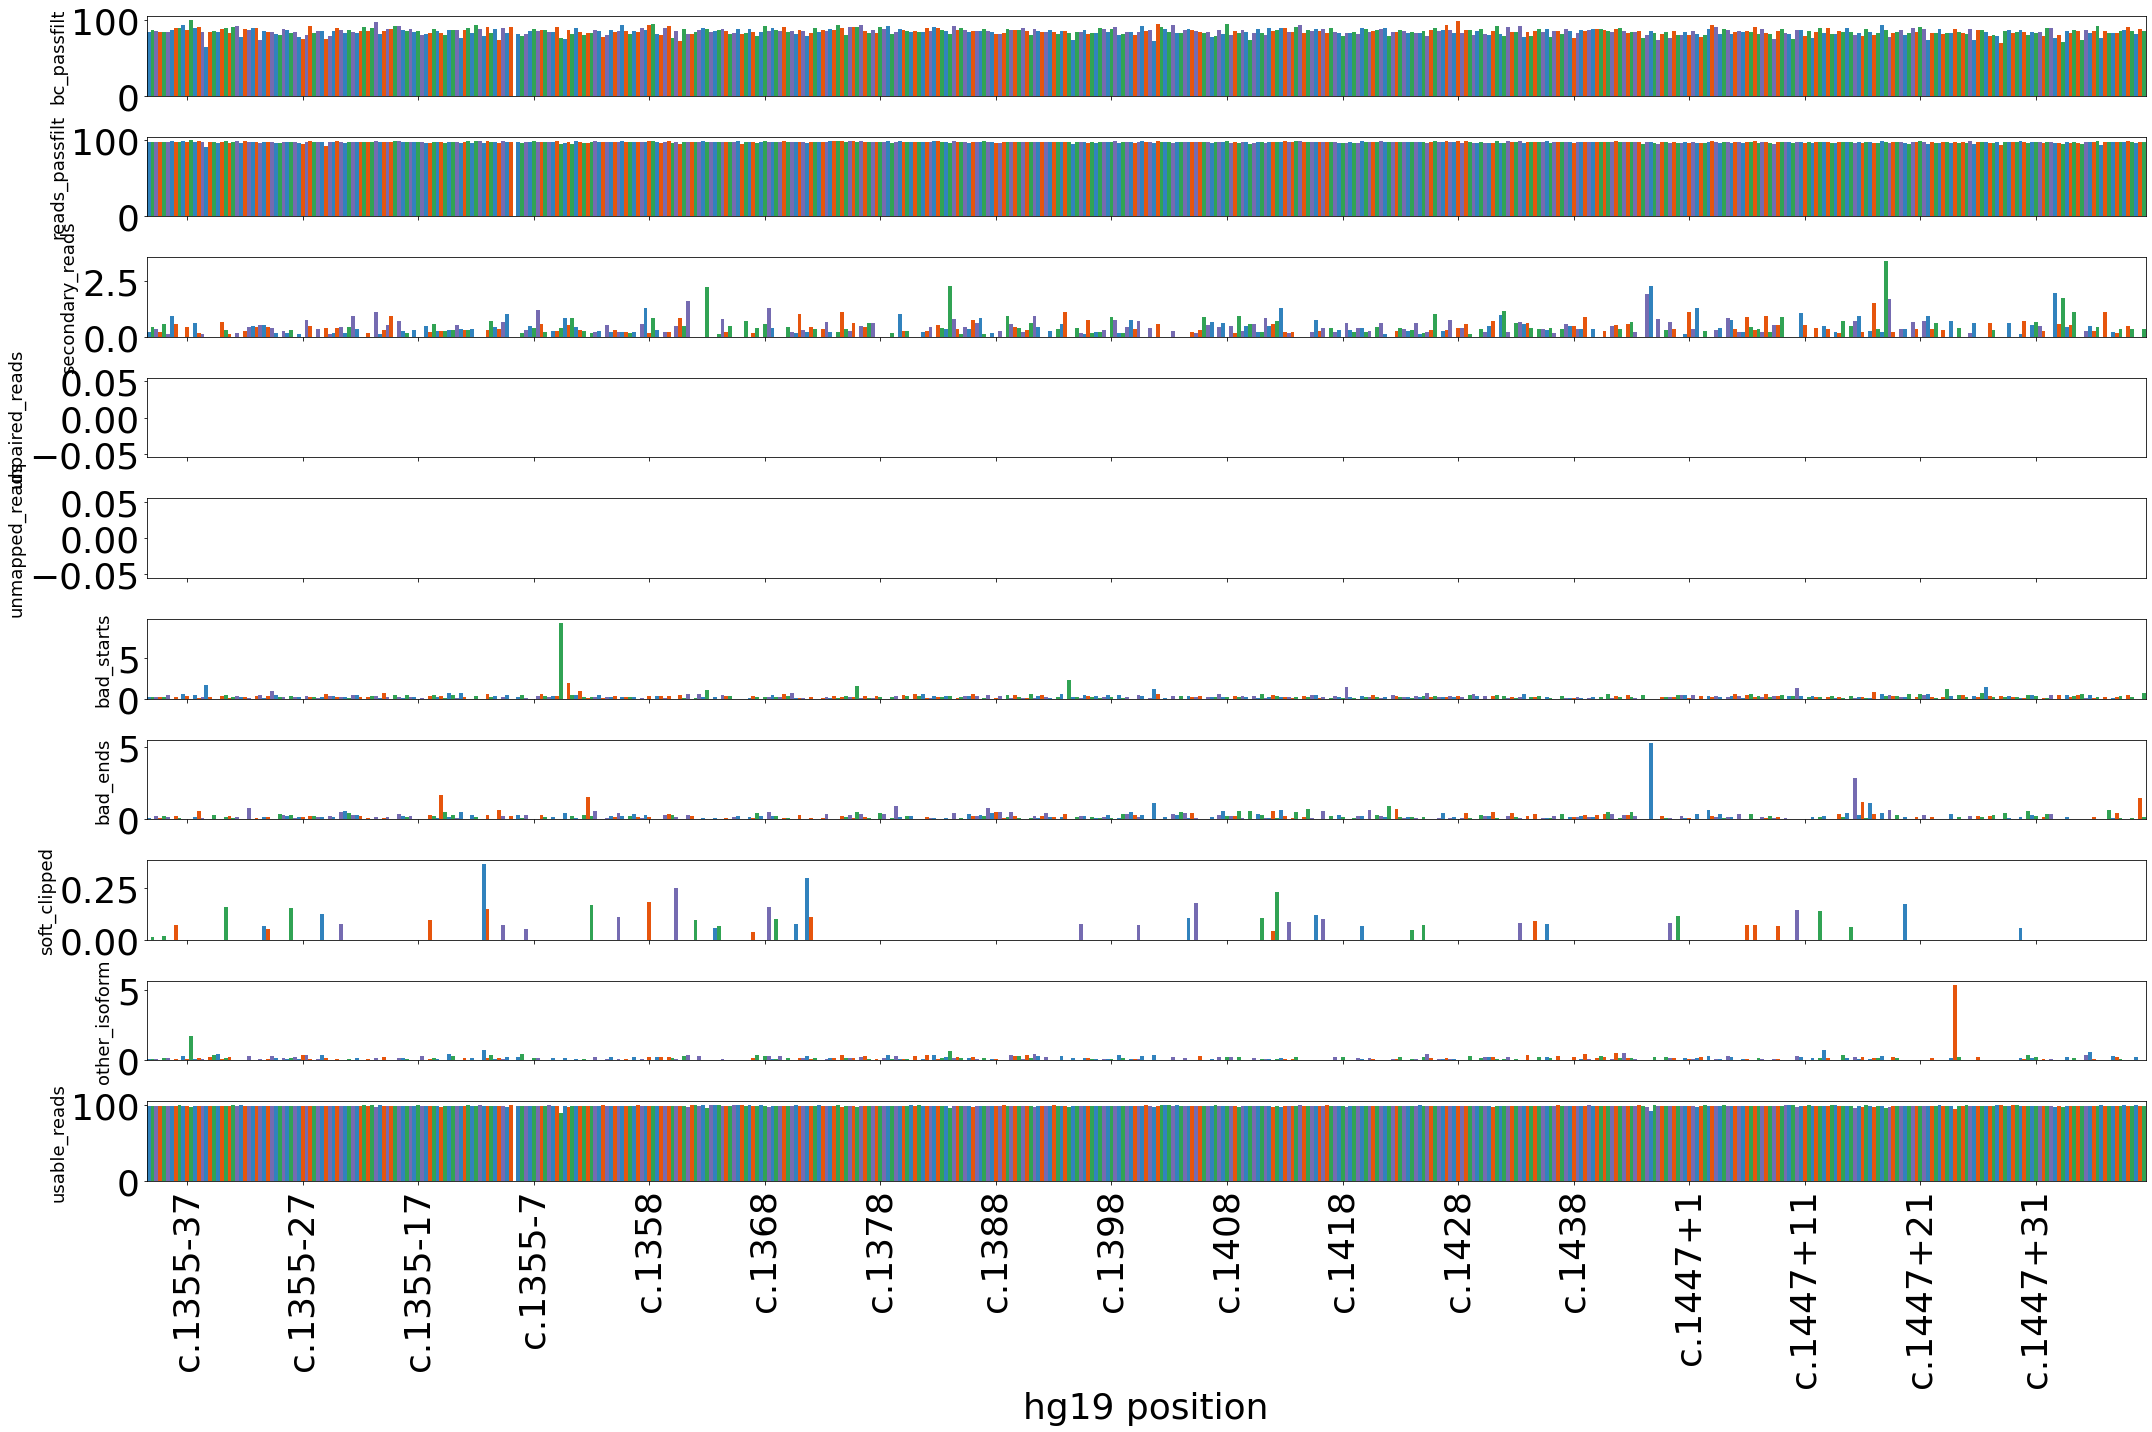

BB_RT_1b_ODT_243_Hek1053


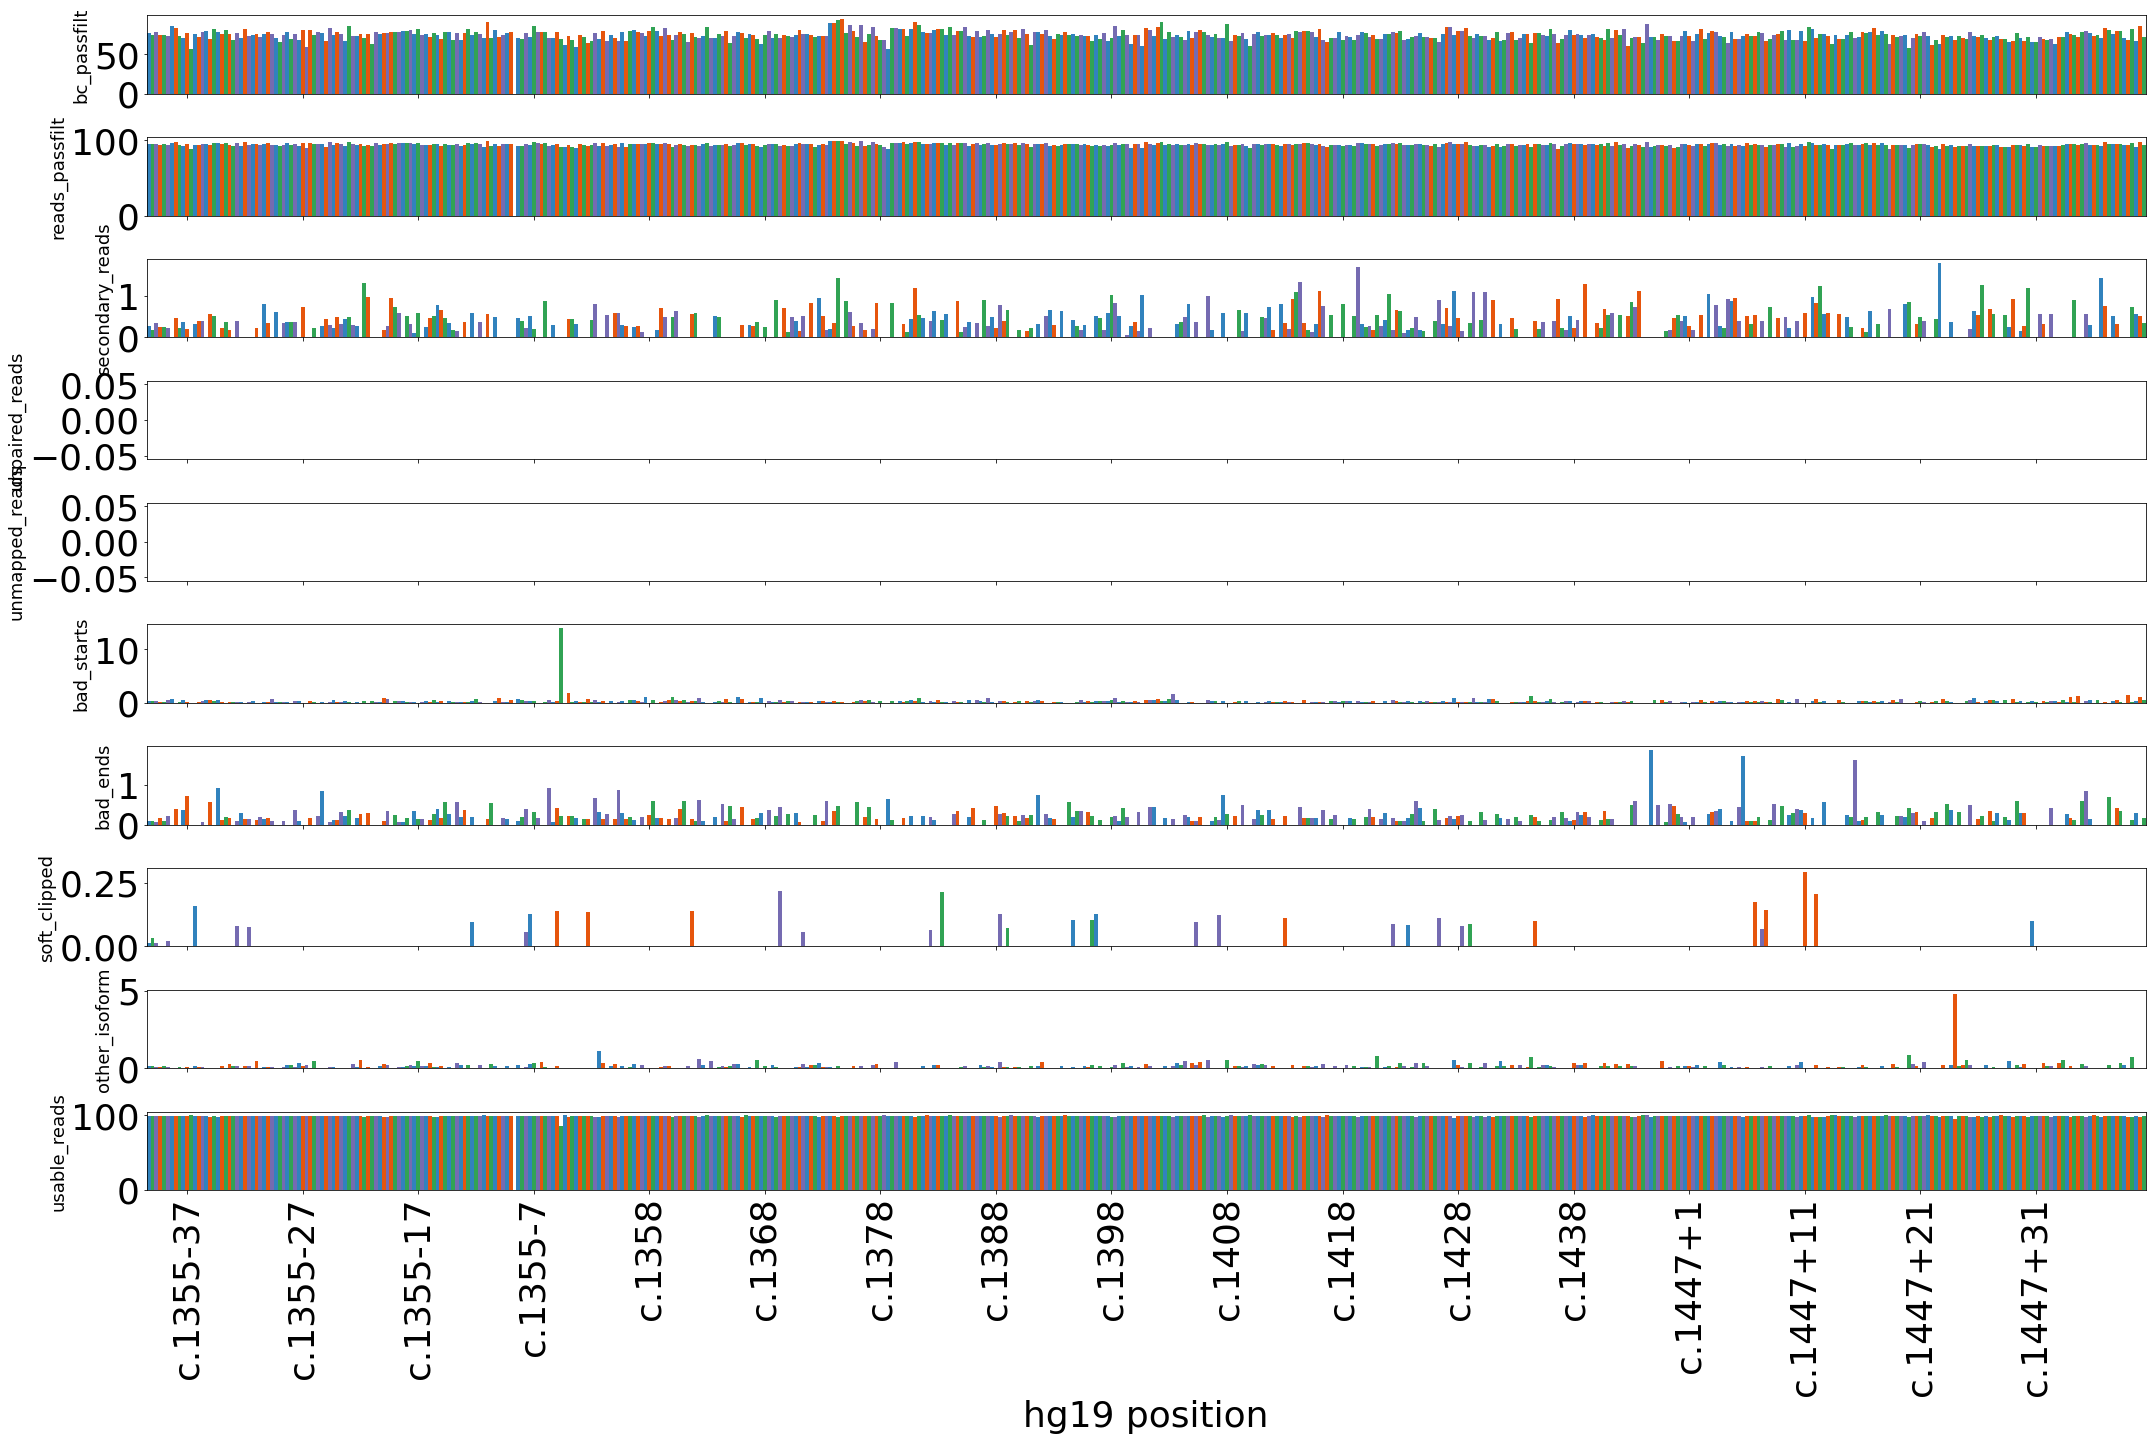

BB_RT_1_ODT_243_Hek1053


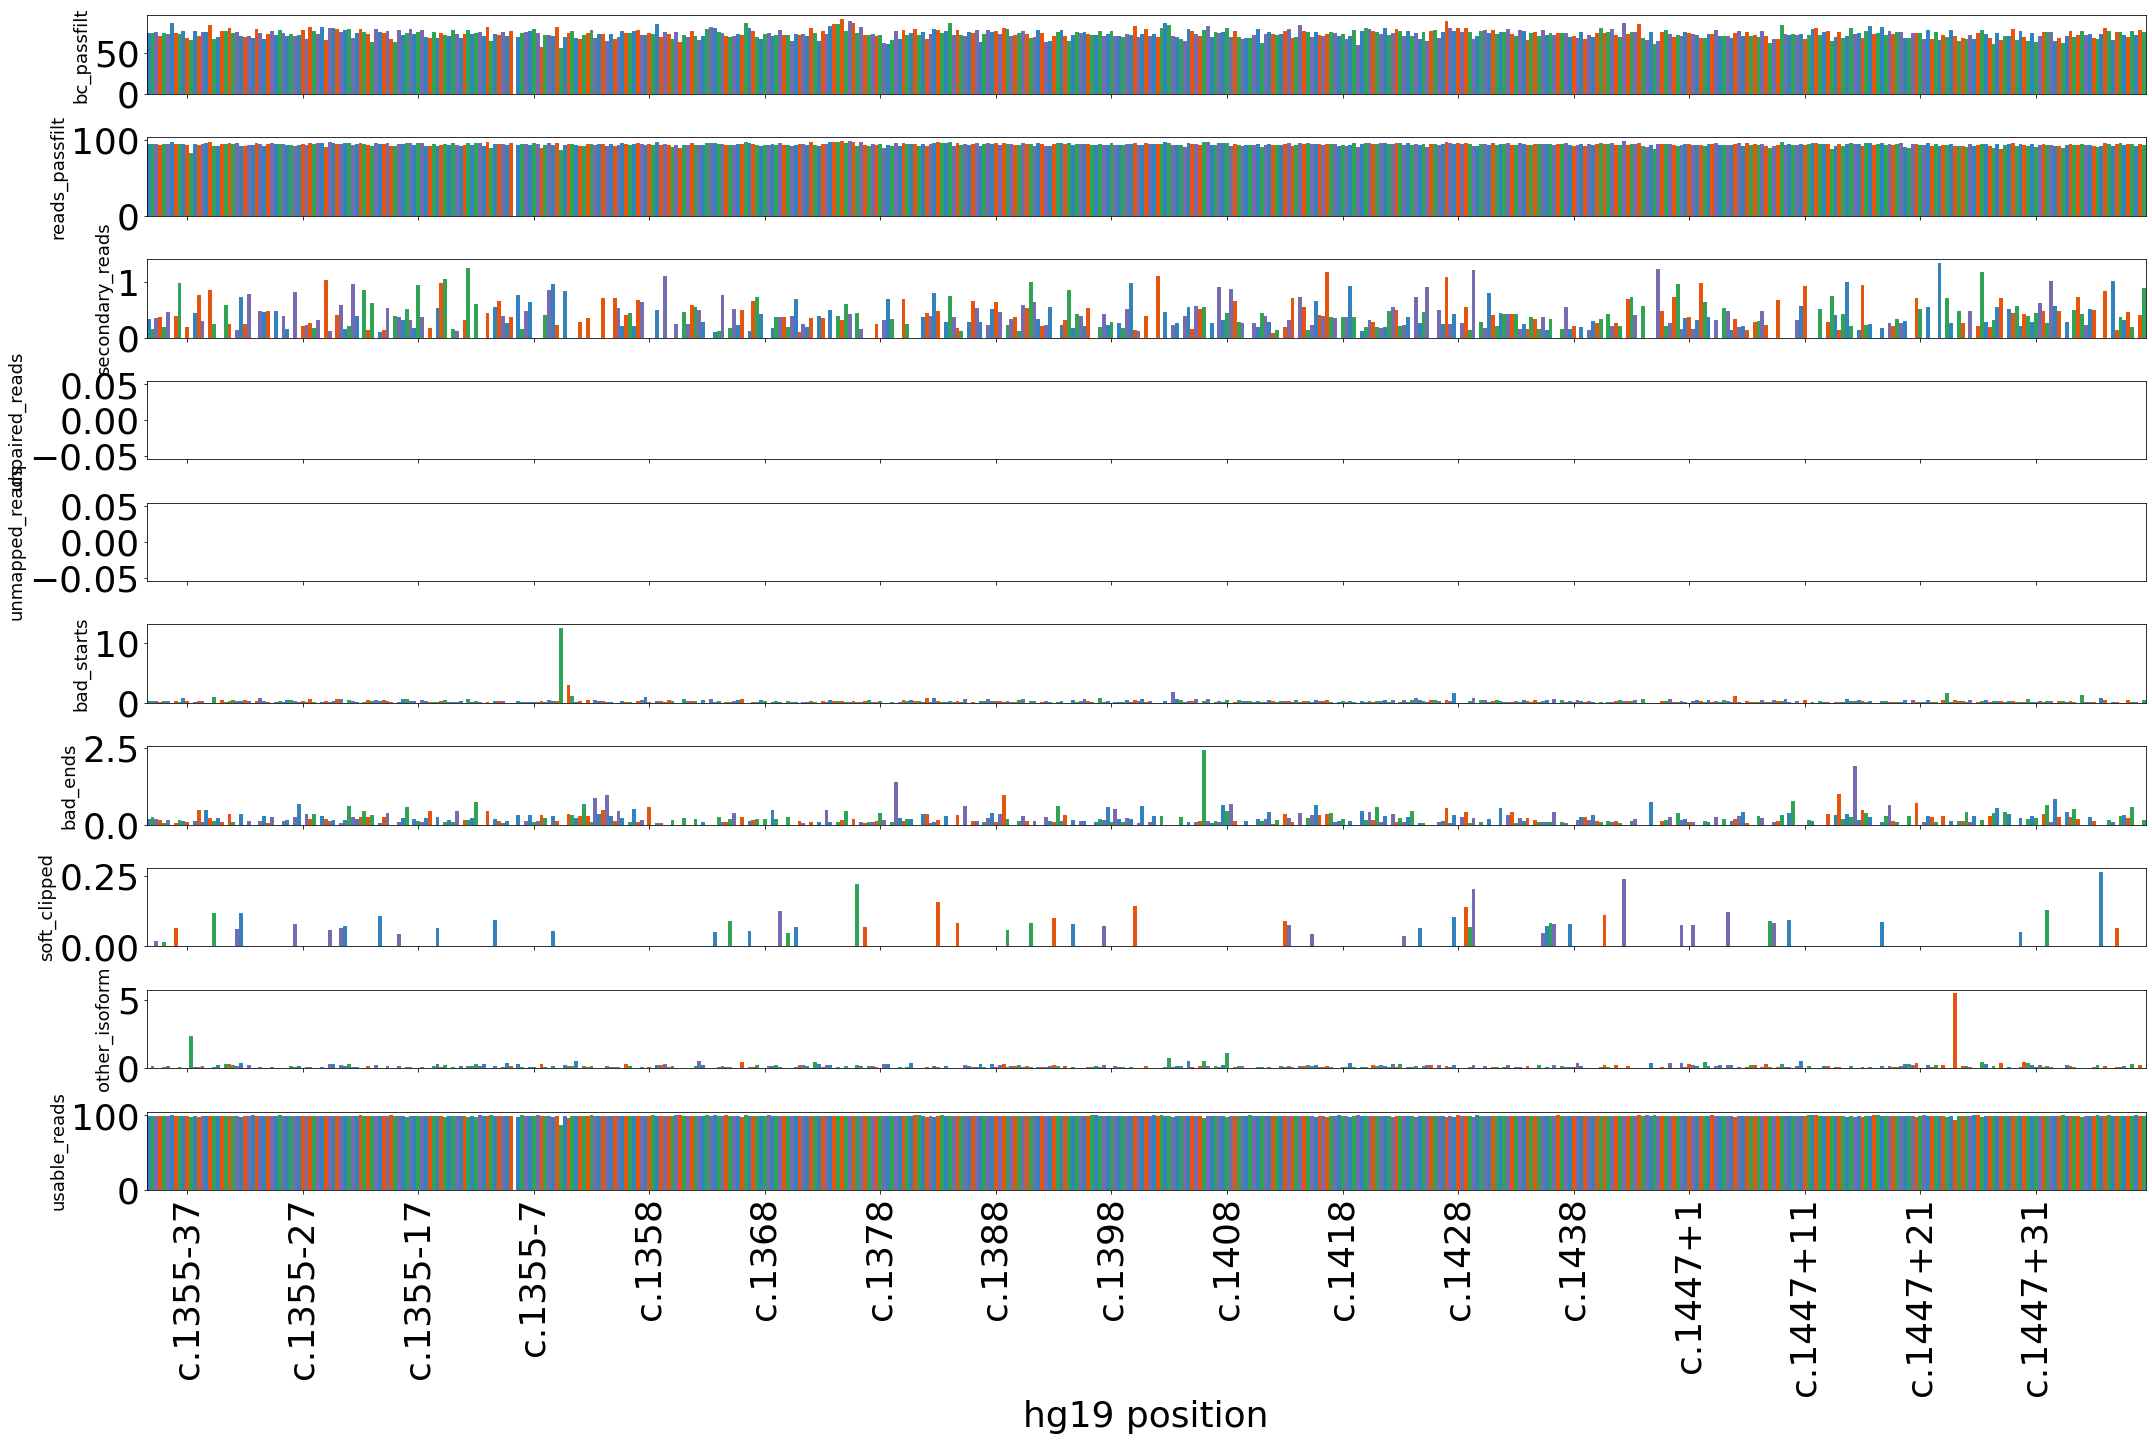

BB_RT_2_340_243_Hek1054


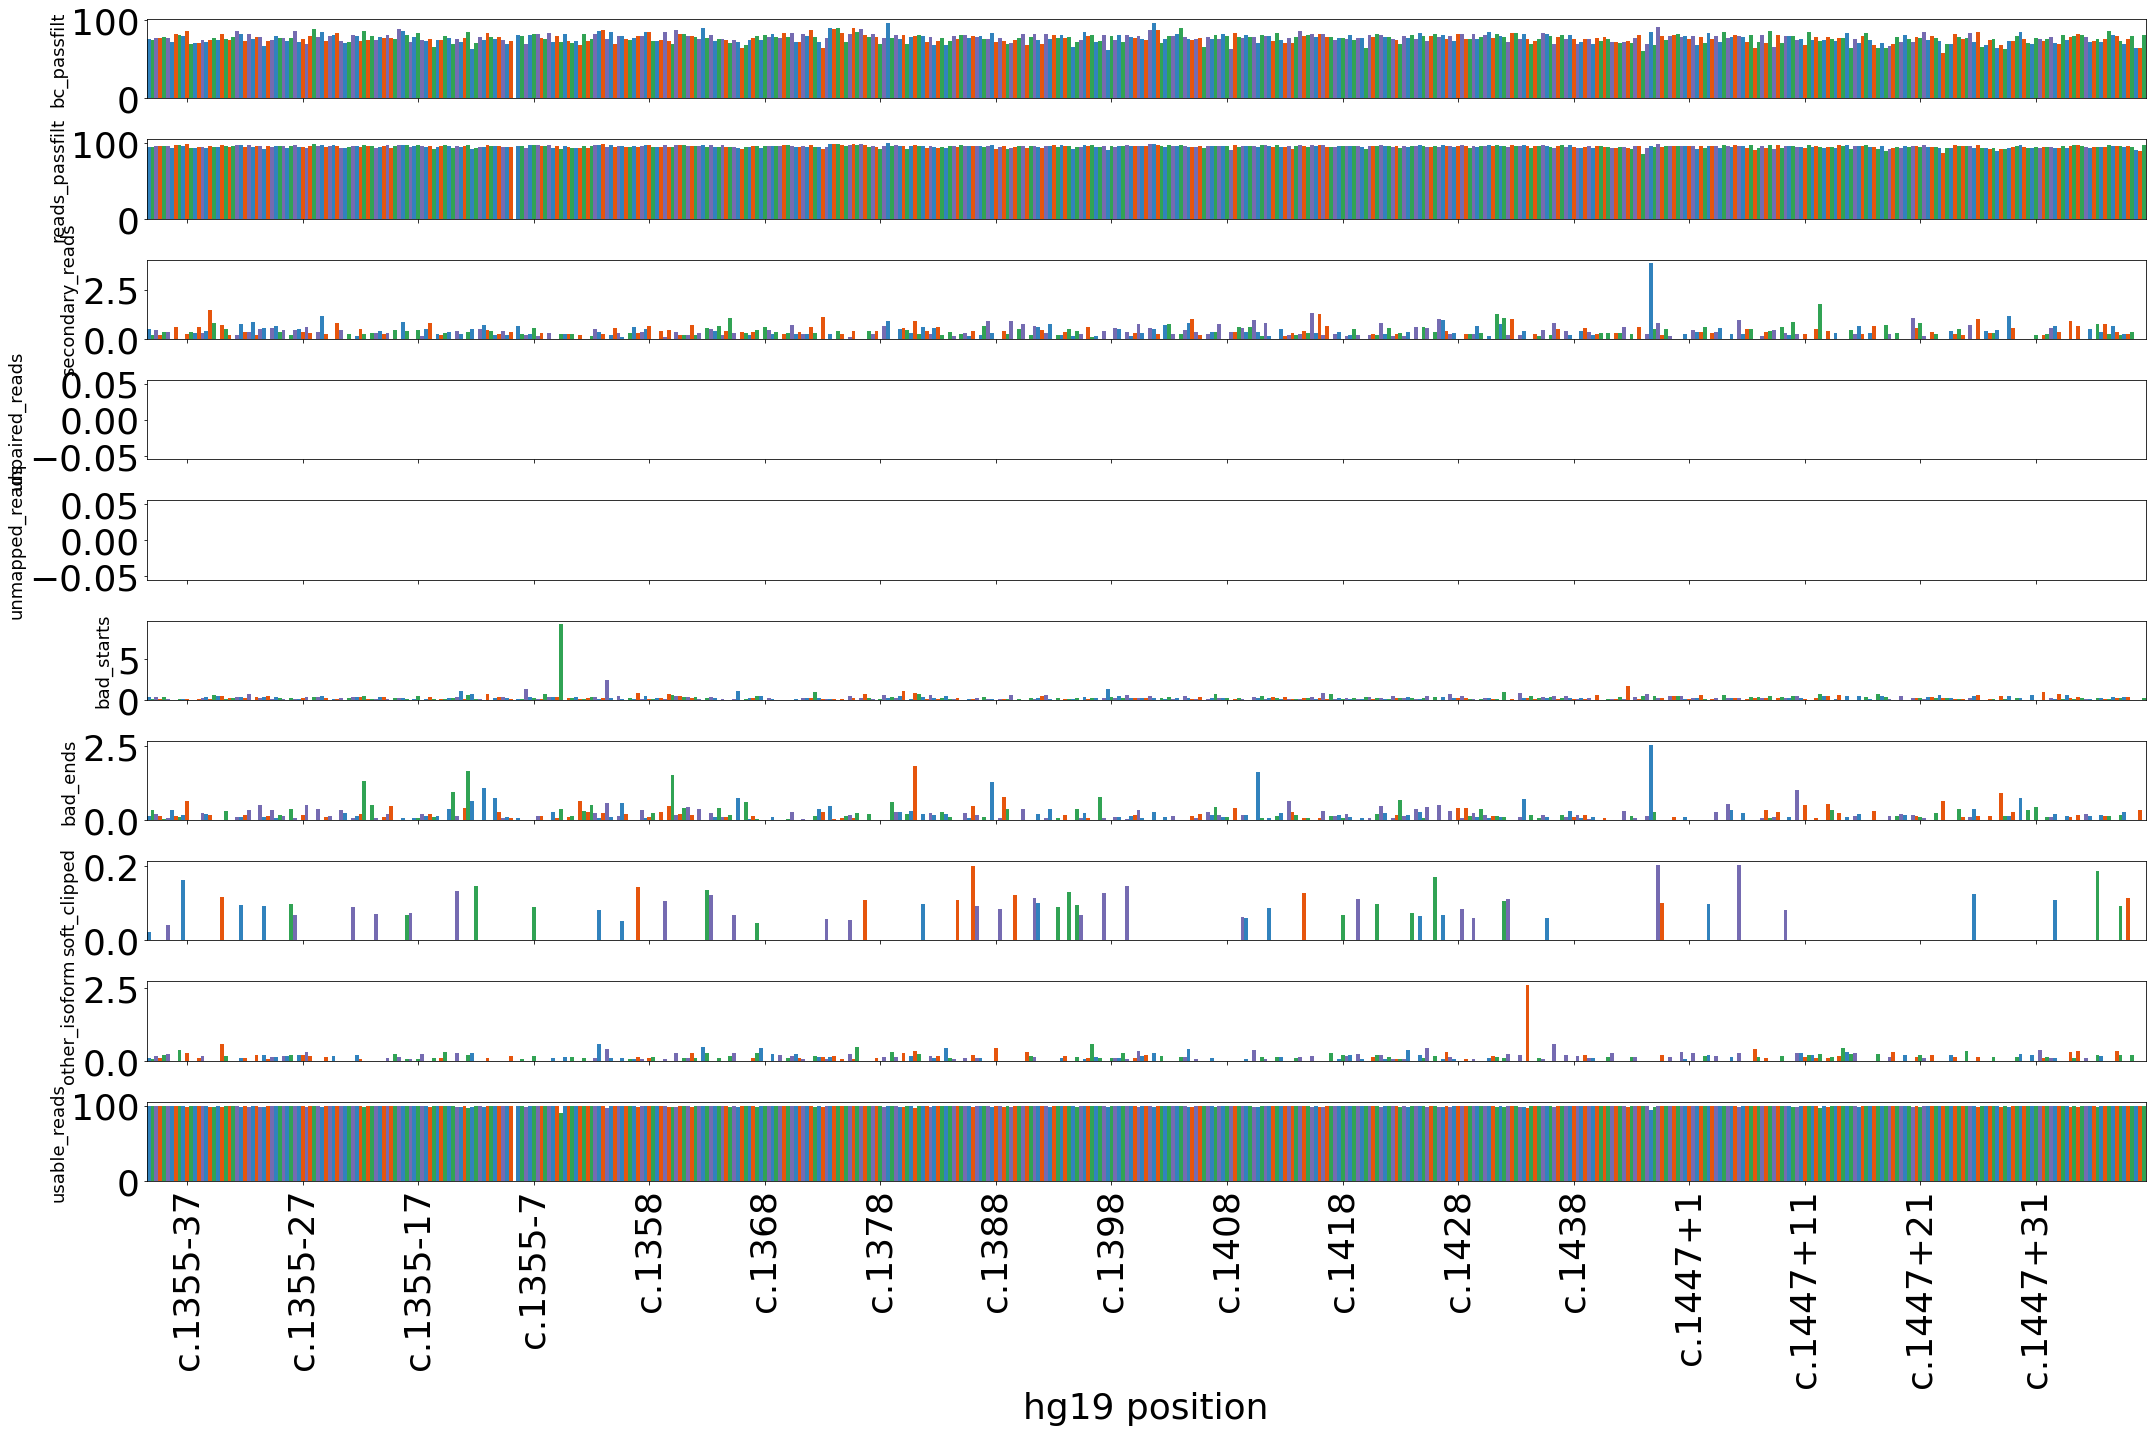

BB_RT_2_ODT_243_Hek1054


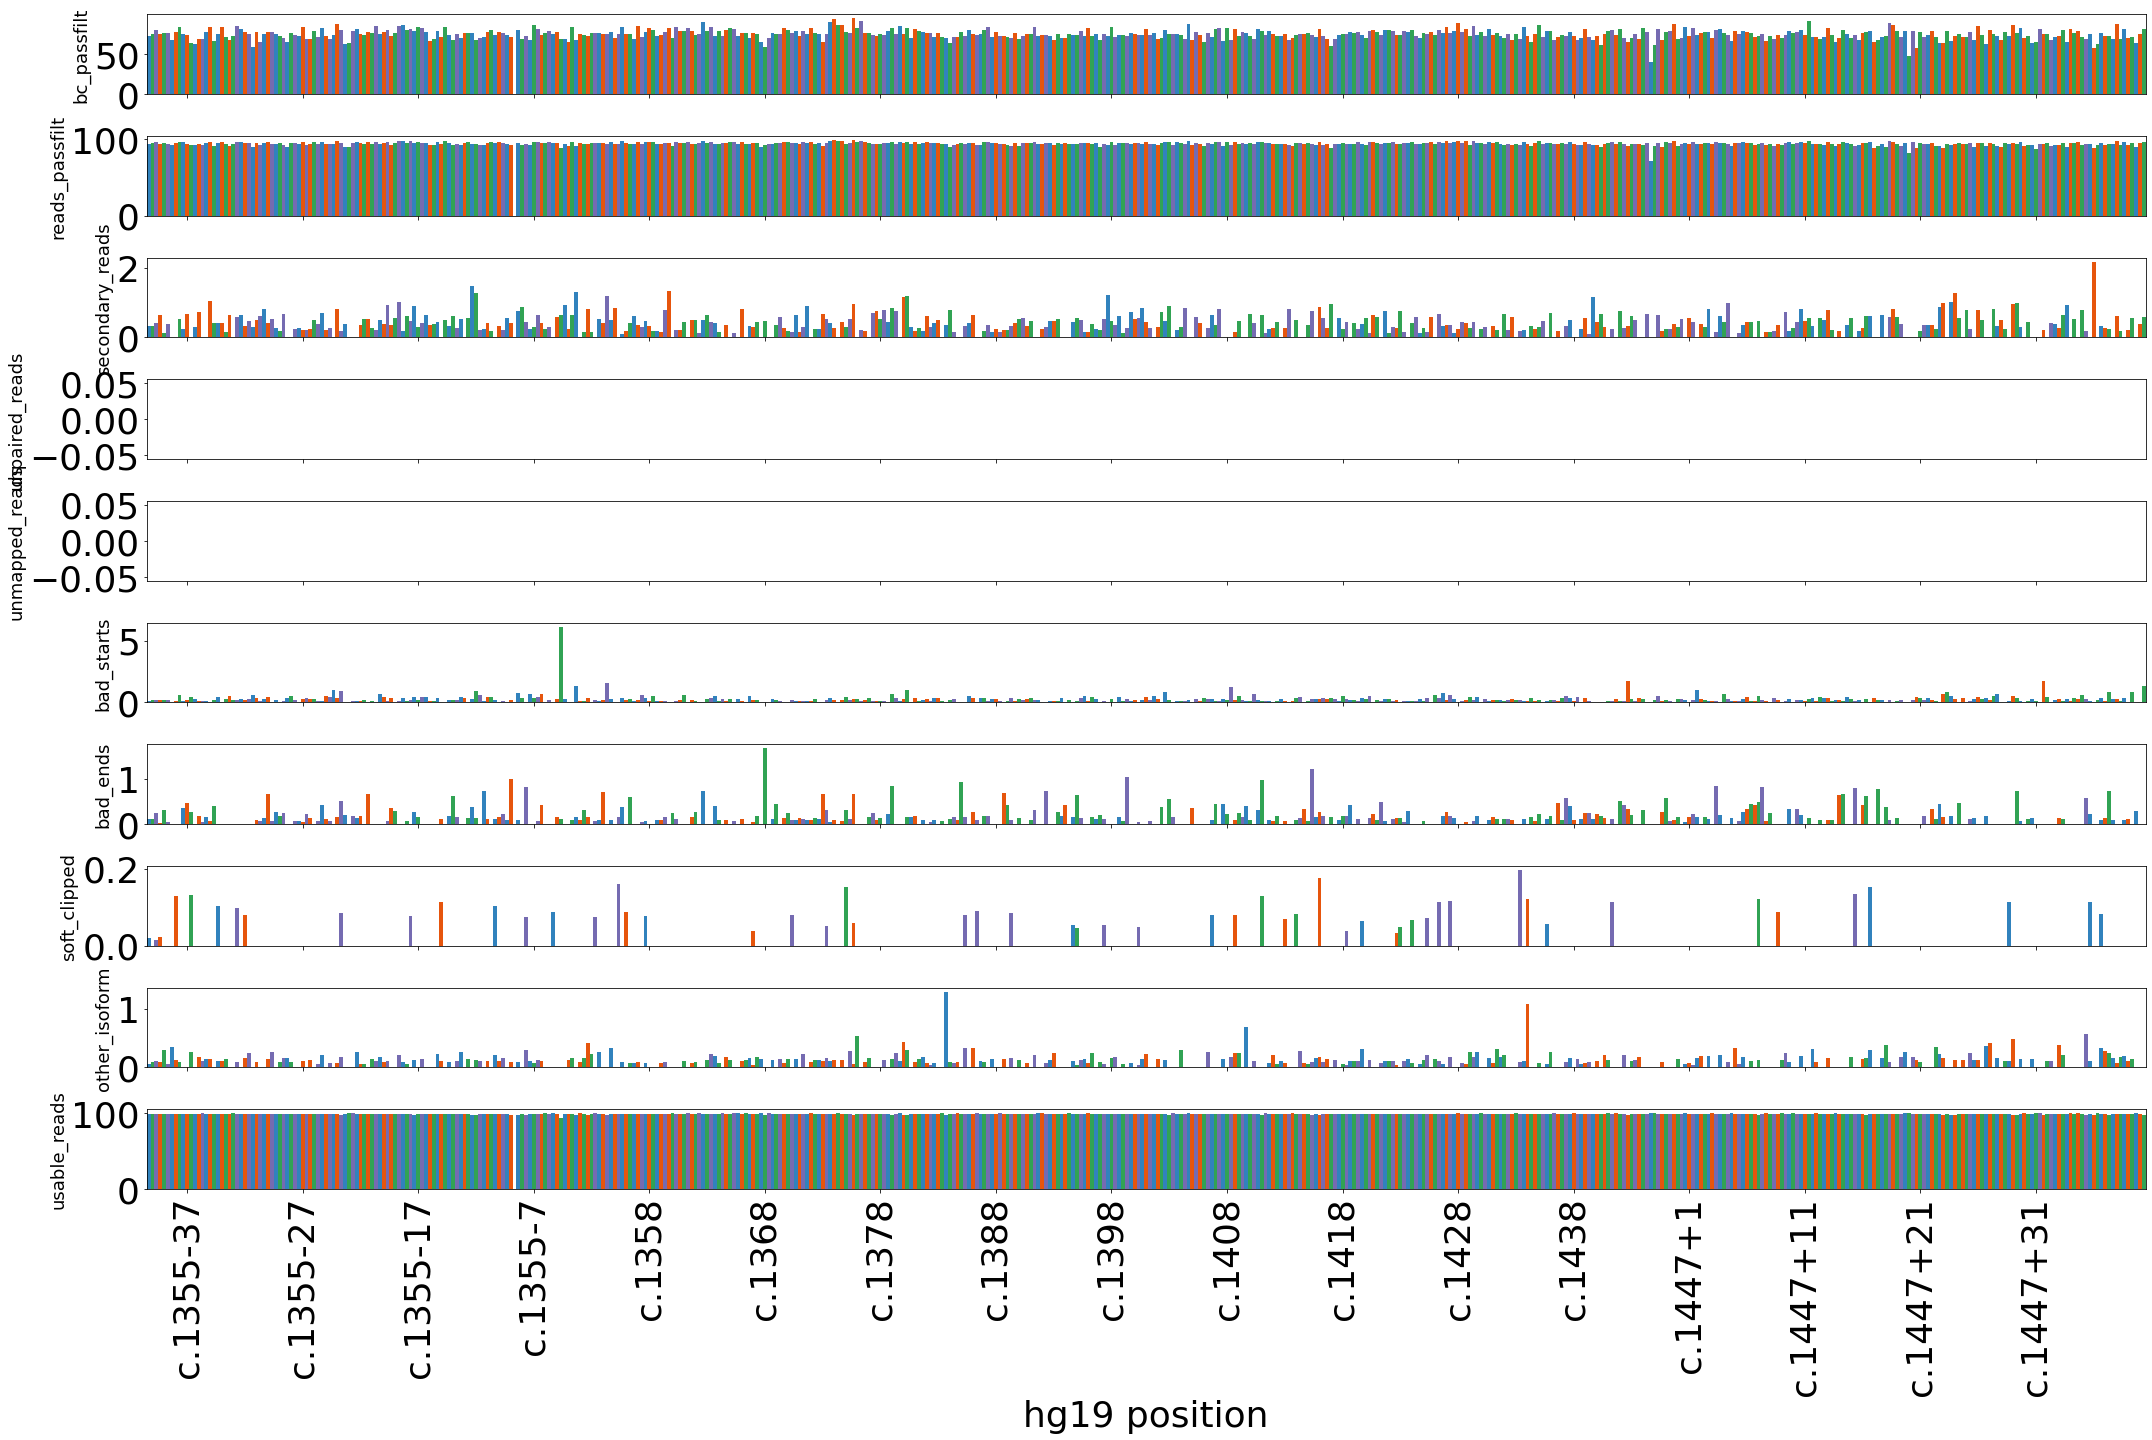

BB_RT_3_340_243_Cos1055


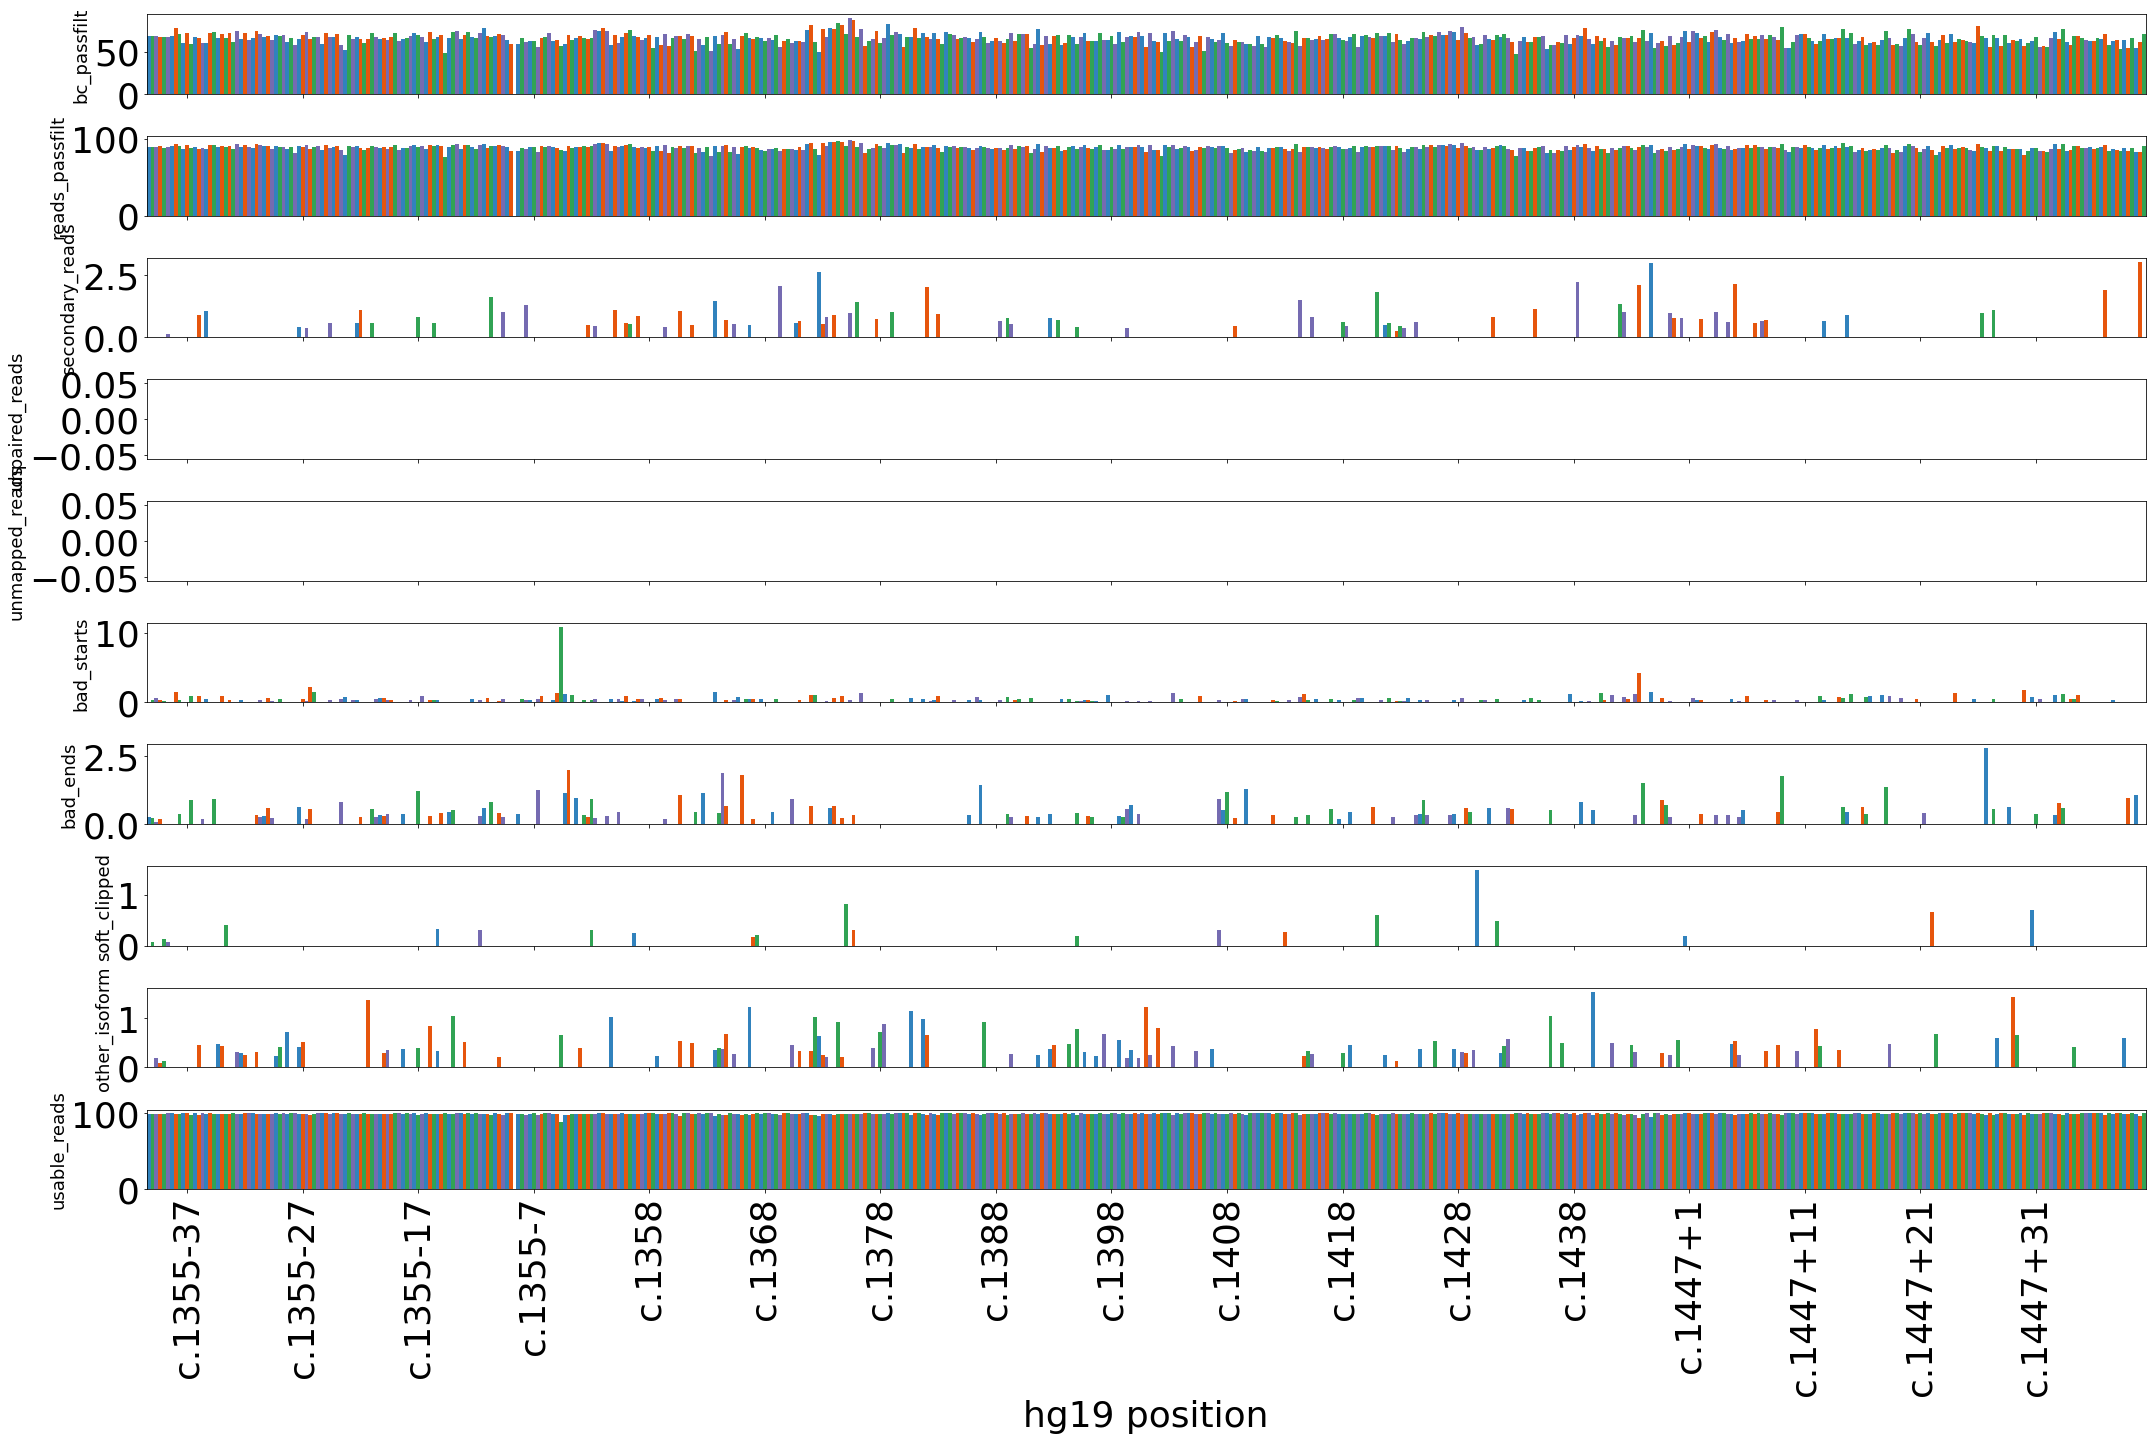

BB_RT_3_340_243_Hek1055


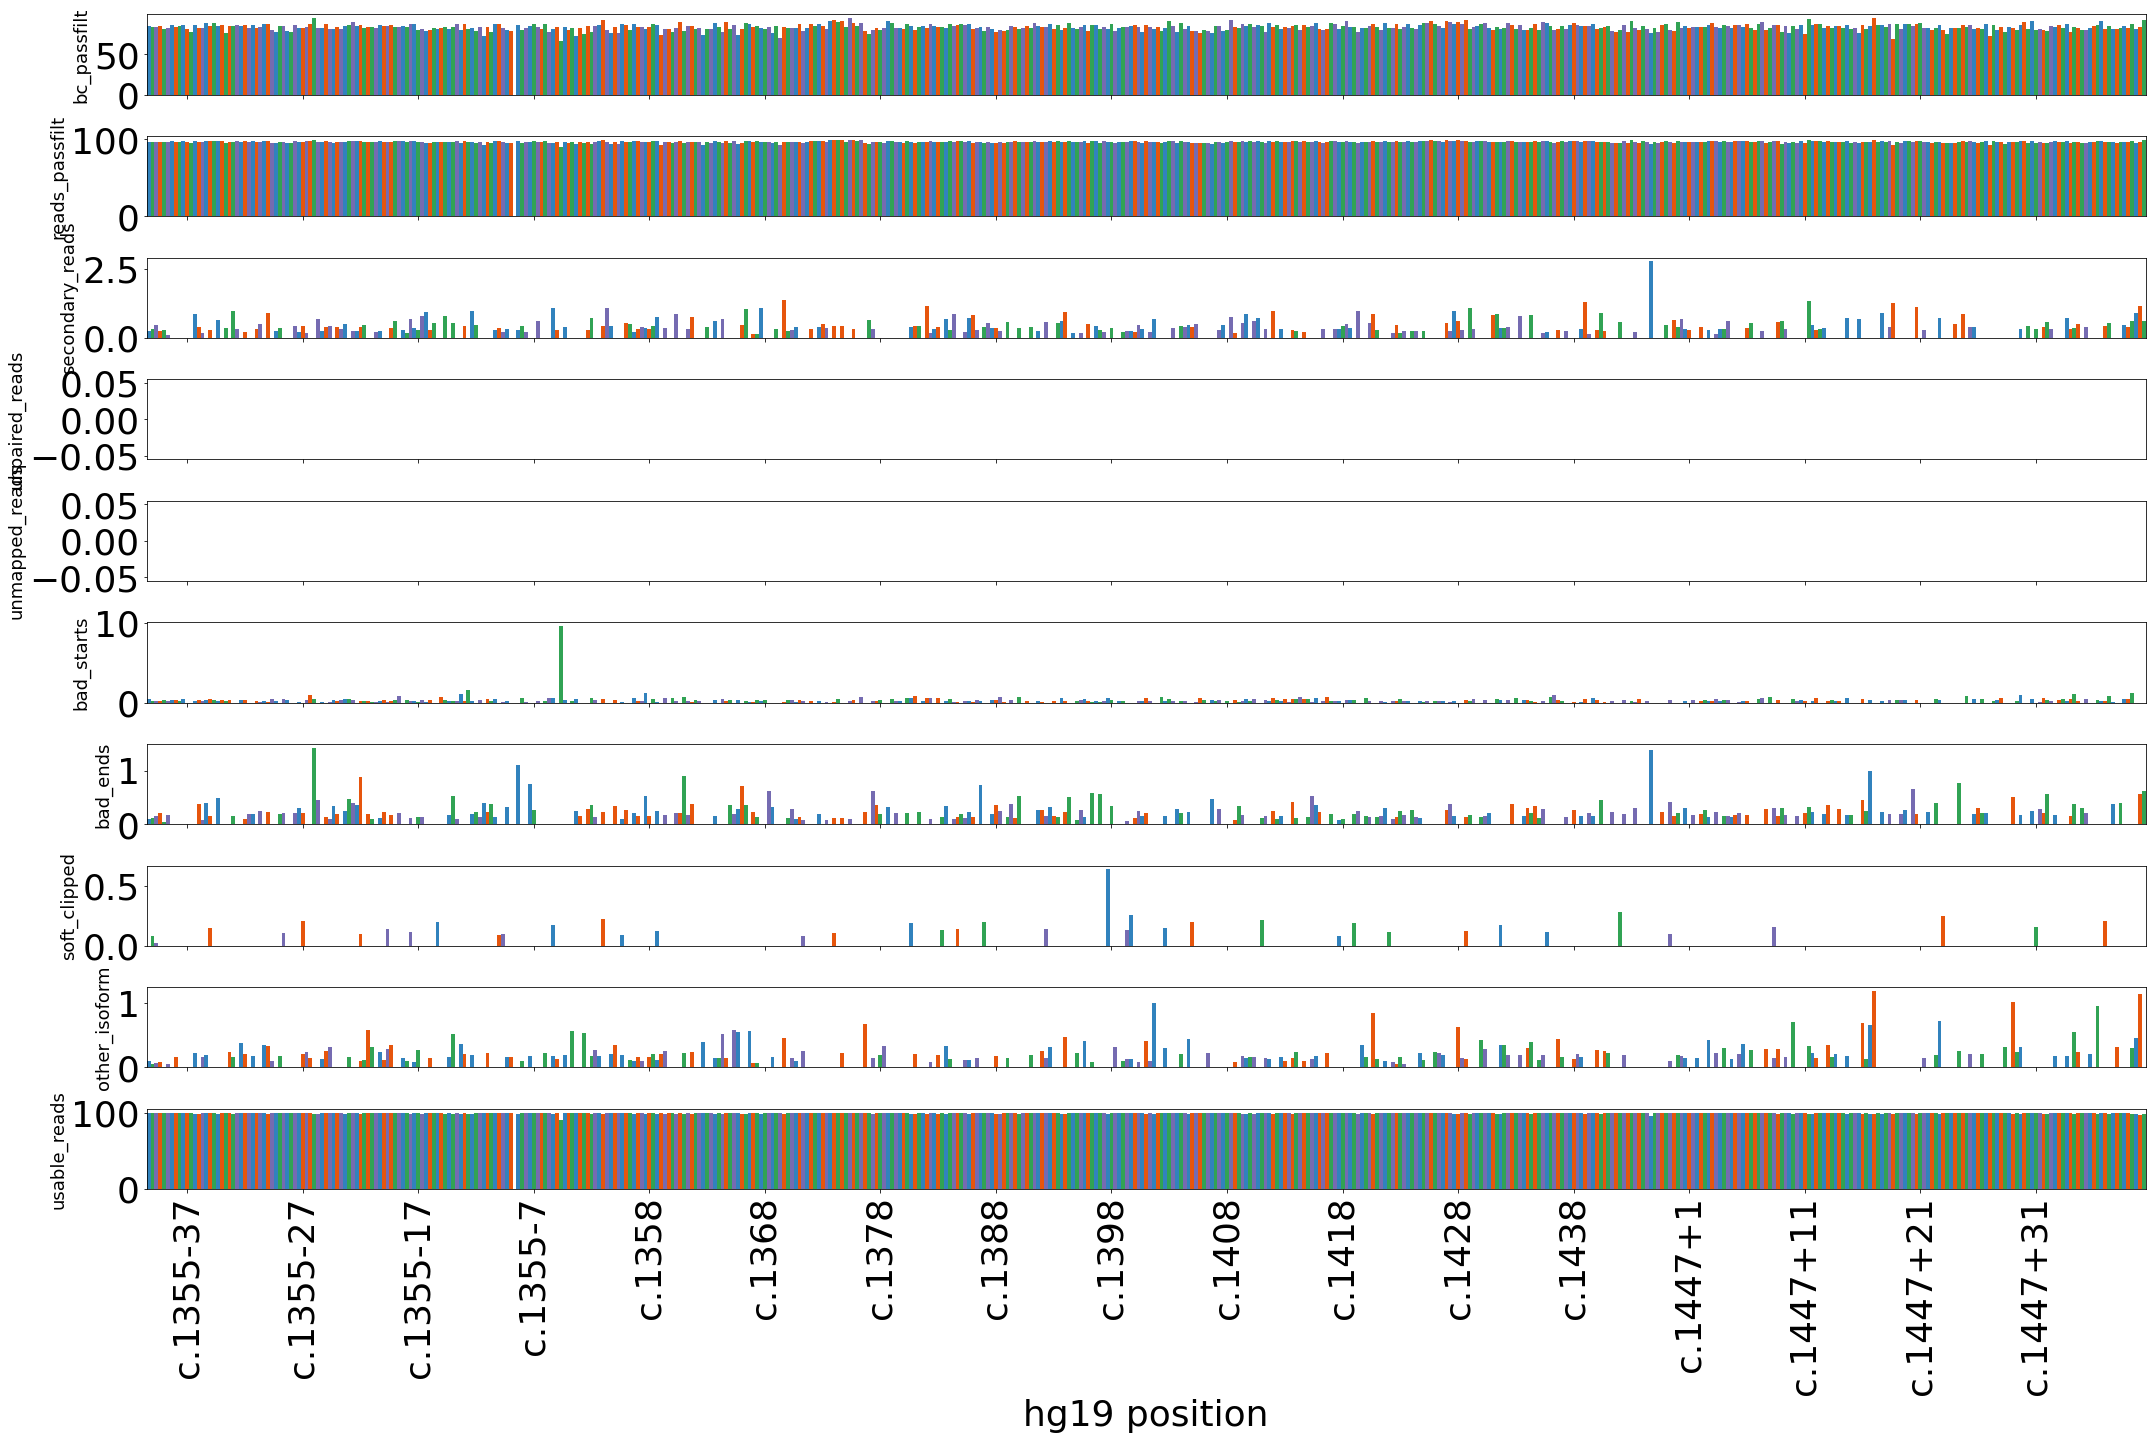

BB_RT_3_ODT_243_Cos1055


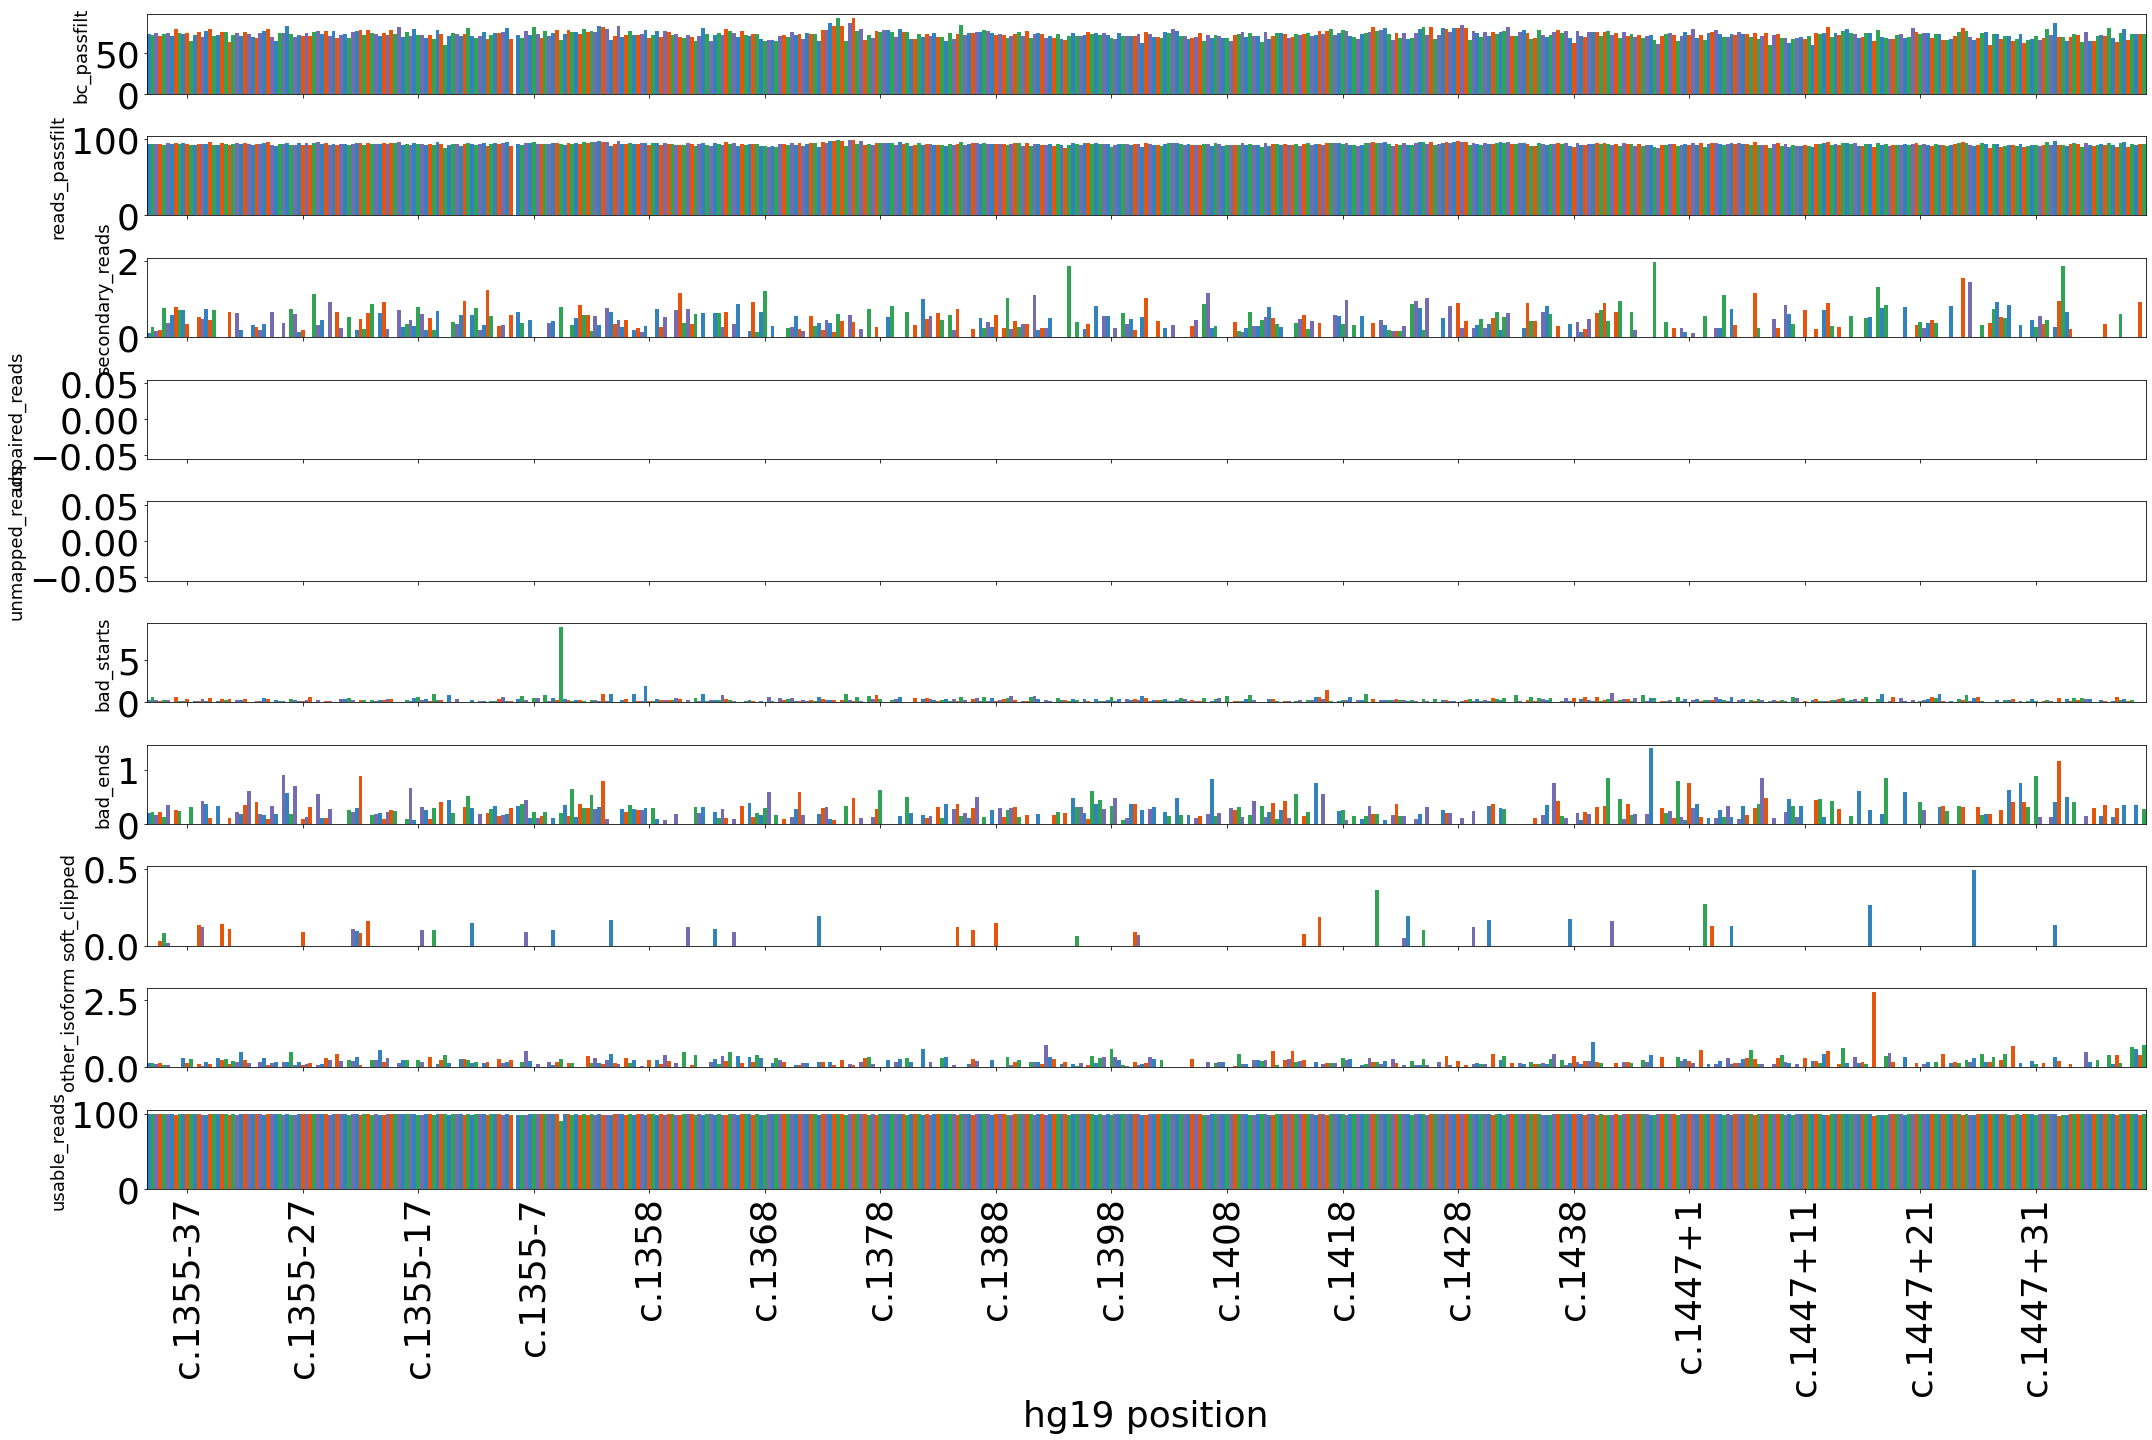

BB_RT_3_ODT_243_Hek1055


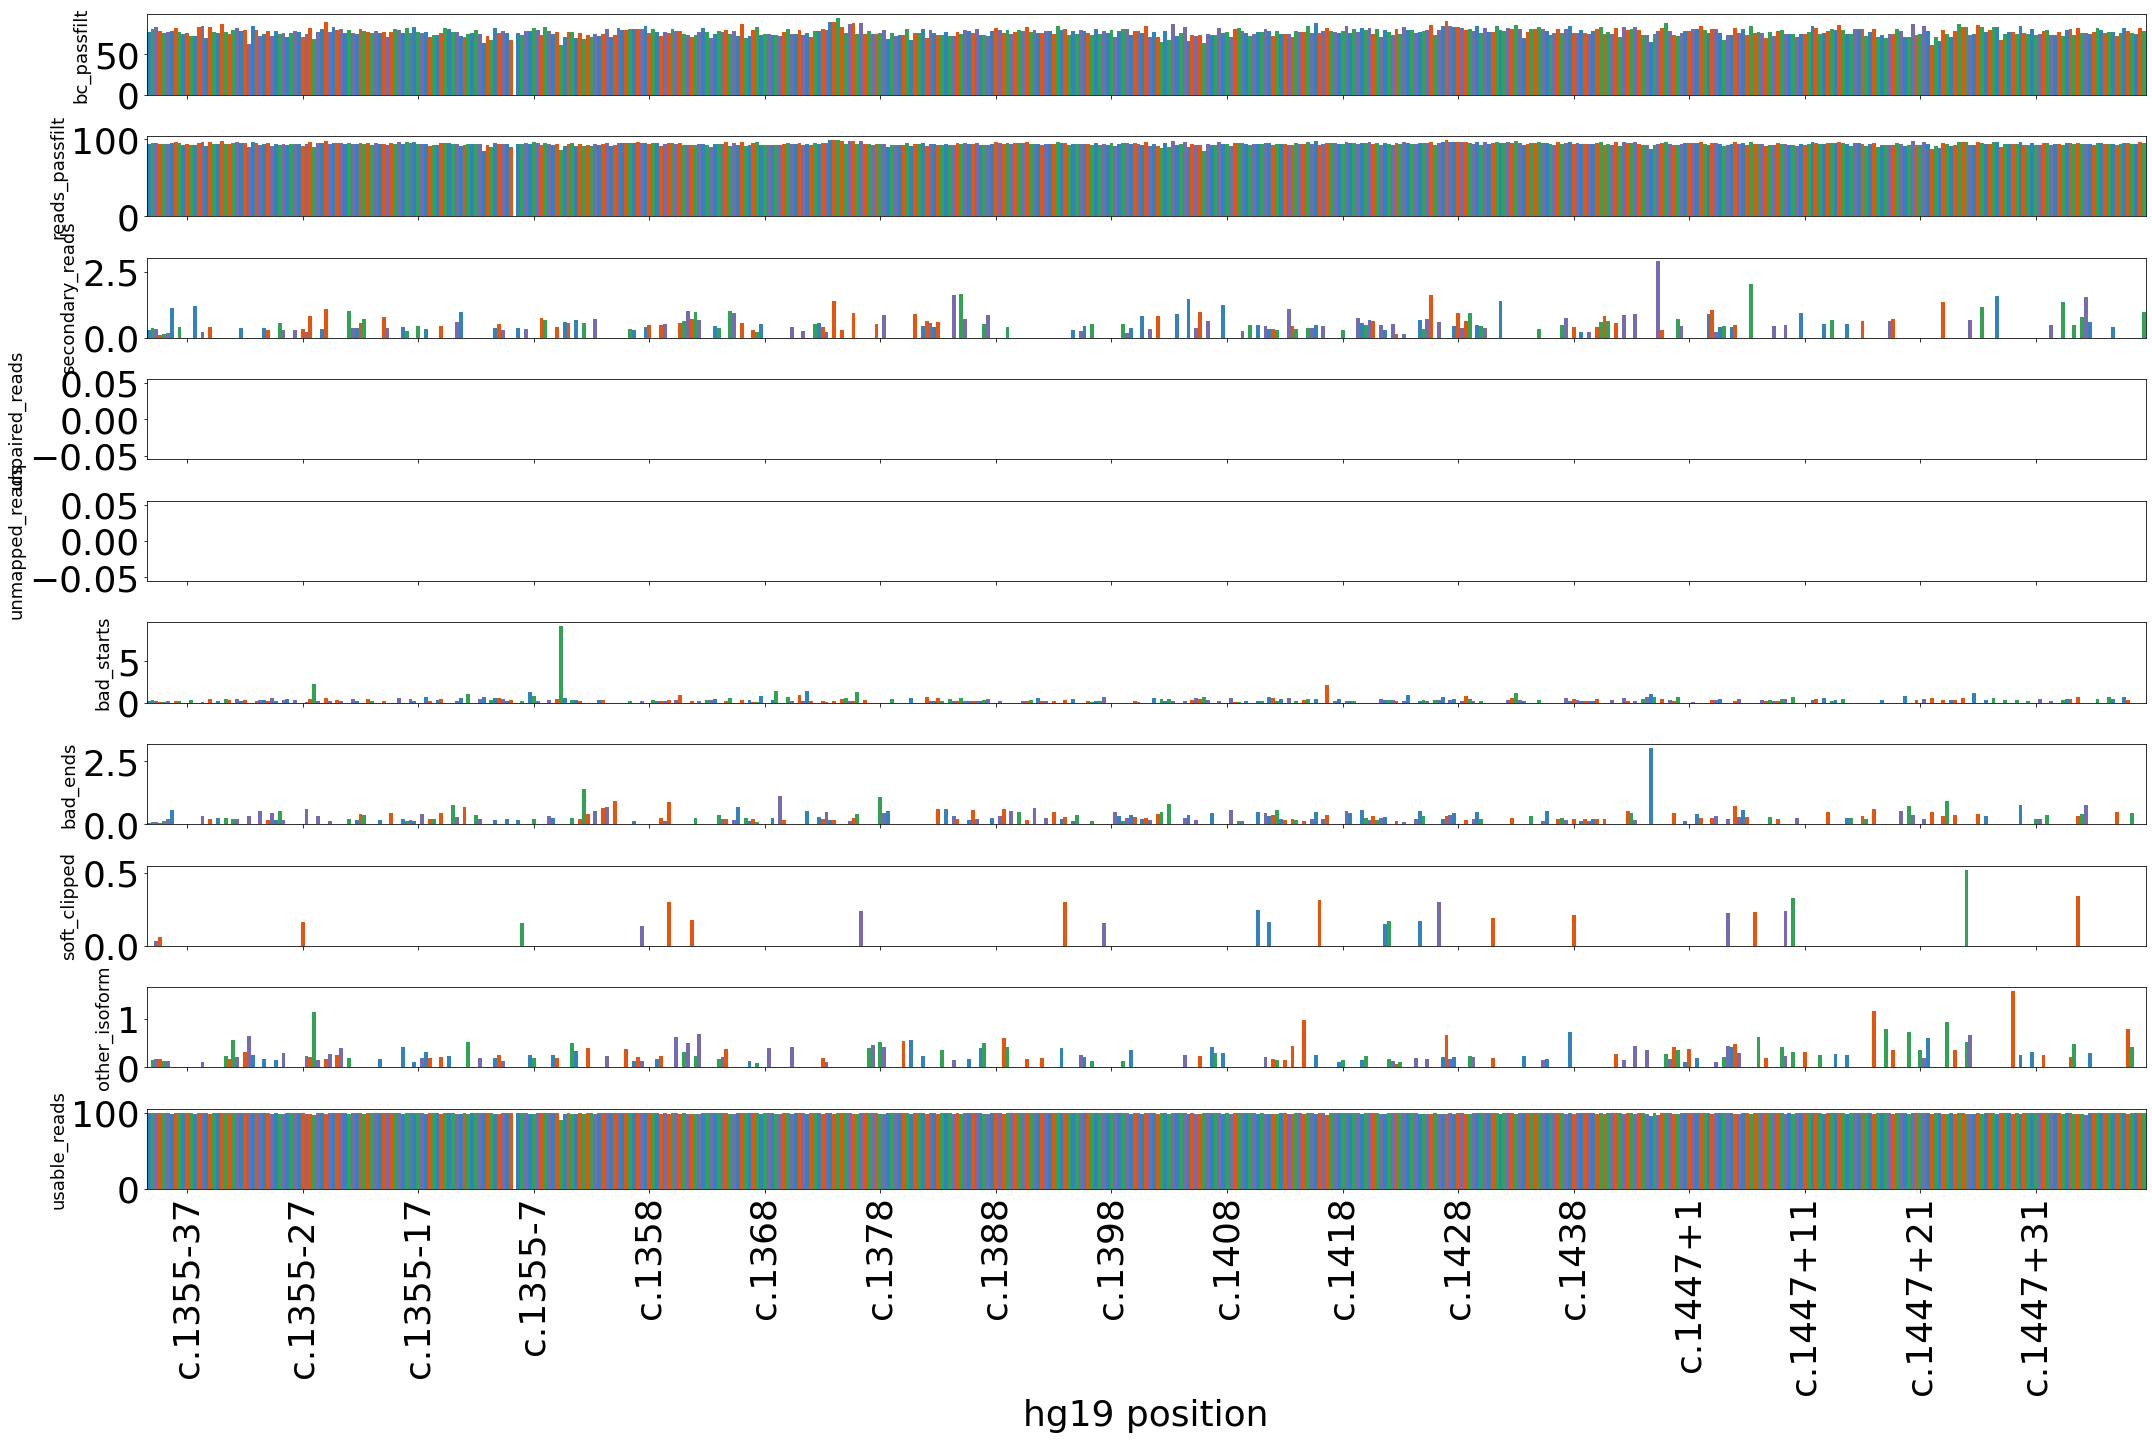

In [68]:
for samp in byvartbl_sat[ 'sample' ].unique():
    
    print( samp )

    sp.sat_subplots_wrapper( byvartbl_sat.loc[ byvartbl_sat[ 'sample' ] == samp ].rename( columns = { 'alt': 'a',
                                                                                                      'ref': 'r',
                                                                                                      'alt_c': 'alt',
                                                                                                       'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'per_' ) ],
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 20 ),
                          share_y = False,
                          legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          #y_ax_lim = [ ( 0, 3 ) ] + ylim,
                          y_ax_title = [ col[ 4: ] for col in byvartbl_sat if col.startswith( 'per_' ) ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [69]:
qc_counts_d = {}

for col in [ col for col in byvartbl_long if col.startswith( 'per_' ) ]:
    
    if col.endswith( 'passfilt' ) or 'usable' in col:
        continue
        
    qc_counts_d[ col ] = Counter( byvartbl_long.loc[ ( byvartbl_long[ col ] >= 5 ) ].pos.tolist() )

In [70]:
for col in [ col for col in byvartbl_long if col.startswith( 'per_' ) ]:
    
    if col.endswith( 'passfilt' ) or 'usable' in col:
        continue
    
    print( col )
    
    print( qc_counts_d[ col ].most_common( 10 ) )

per_secondary_reads
[]
per_unpaired_reads
[]
per_unmapped_reads
[]
per_bad_starts
[(1262, 10)]
per_bad_ends
[(1357, 1)]
per_soft_clipped
[]
per_other_isoform
[(1383, 2)]


Bad start reads QC

In [72]:
print( qc_counts_d[ 'per_bad_starts' ].most_common( 10 ) )

[(1262, 10)]


In [73]:
byvartbl_long.loc[ byvartbl_long.pos == 1262 ].groupby( 'sample' ).per_bad_starts.max()

sample
BB_RT_1_340_243_Hek1053      8.085809
BB_RT_1_ODT_243_Hek1053     12.412587
BB_RT_1b_340_243_Hek1053     9.236948
BB_RT_1b_ODT_243_Hek1053    13.973799
BB_RT_2_340_243_Hek1054      9.245742
BB_RT_2_ODT_243_Hek1054      6.135630
BB_RT_3_340_243_Cos1055     10.855263
BB_RT_3_340_243_Hek1055      9.589041
BB_RT_3_ODT_243_Cos1055      8.926780
BB_RT_3_ODT_243_Hek1055      9.225092
Name: per_bad_starts, dtype: float64

In [74]:
byvartbl_long.loc[ ( byvartbl_long.pos == 1262 ) & ( byvartbl_long.per_bad_starts >= 5 ) ][ [ 'pos', 'ref', 'alt', 'varlist', 'sample', 'per_bad_starts', 'sum_bad_starts', 'sum_reads_passfilt' ] ]

pos ref alt          varlist                    sample  \
2869   1262   A   C  jkp815:1262:T:G   BB_RT_1_340_243_Hek1053   
4584   1262   A   C  jkp815:1262:T:G  BB_RT_1b_340_243_Hek1053   
5762   1262   A   C  jkp815:1262:T:G  BB_RT_1b_ODT_243_Hek1053   
7484   1262   A   C  jkp815:1262:T:G   BB_RT_1_ODT_243_Hek1053   
9712   1262   A   C  jkp815:1262:T:G   BB_RT_2_340_243_Hek1054   
11840  1262   A   C  jkp815:1262:T:G   BB_RT_2_ODT_243_Hek1054   
13415  1262   A   C  jkp815:1262:T:G   BB_RT_3_340_243_Cos1055   
14005  1262   A   C  jkp815:1262:T:G   BB_RT_3_340_243_Hek1055   
15755  1262   A   C  jkp815:1262:T:G   BB_RT_3_ODT_243_Cos1055   
16344  1262   A   C  jkp815:1262:T:G   BB_RT_3_ODT_243_Hek1055   

       per_bad_starts  sum_bad_starts  sum_reads_passfilt  
2869         8.085809              49                 606  
4584         9.236948              46                 498  
5762        13.973799              64                 458  
7484        12.412587              71                 572  
9712         9.245742              76                 822  
11840        6.135630              57                 929  
13415       10.855263              33                 304  
14005        9.589041              35                 365  
15755        8.926780              89                 997  
16344        9.225092              25                 271

In [75]:
bcs_1262AC = bybc_tbl_fn[ 'JKP1053' ].loc[ ( bybc_tbl_fn[ 'JKP1053' ][ 'sample' ] == 'BB_test_Cos1053_oligodT_MM2B' ) & ( bybc_tbl_fn[ 'JKP1053'].variant_list == 'jkp815:1262:T:G' )  ].copy()

In [76]:
bcs_1262AC.loc[ bcs_1262AC.bad_starts > 0 ][ [ 'barcode', 'bad_starts' ] ]

barcode  bad_starts
61230  GTTTGGTCAGAGAGGCATGATGG           1
77007  TTAGGTATTATATACTCAATTGG         247

In [77]:
! samtools view /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test_Cos1053_oligodT_MM2B/BB_test_Cos1053_oligodT_MM2BAligned.out.wbcs.bam | grep 'BC:Z:TTAGGTATTATATACTCAATTGG'

A01443:202:HVGH2DSX3:1:1102:2166:23657_1:N:0:GCCCGCACTA+AGATAGCCGG_BC=TTAGGTATTATATACTCAATTGG	99	jkp1053_1054_1055	650	255	10M1D40M566N93M2119N7M	=	1327	2884	AGTGAACTGCCTGTGACAAGCTGCACGCTCTAGAGTCGACCCAGCATTAGGTGTGAAACCATTCCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCATACAGGTAAAACAAACCTGGA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FFFF:FFFFFFF	NH:i:1	HI:i:1	AS:i:227	nM:i:2	NM:i:3	MD:Z:10^A36G2A100	jM:B:c,1,1	jI:B:i,701,1266,1360,3478	MC:Z:33M2119N55M	BC:Z:TTAGGTATTATATACTCAATTGG
A01443:202:HVGH2DSX3:1:1102:2166:23657_1:N:0:GCCCGCACTA+AGATAGCCGG_BC=TTAGGTATTATATACTCAATTGG	147	jkp1053_1054_1055	1327	255	33M2119N55M	=	650	-2884	AGACCCACACCAGGACTCATACAGGTAAAACAAACCTGGAGATCTCCCGAGGGGACCCGACAGTCAGAAGGTGGTGGCTGGTGAAGTC	FFFFFFFFFFFFFFFFFFF,:FFFFFF:F:FFF:F:FFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFF	NH:i:1	HI:i:1	AS:i:227	nM:i:2	NM:i:0	MD:Z:88	jM:B:c,1	jI:B:i,1360,3478	MC:Z

A01443:202:HVGH2DSX3:1:1212:17228:28354_1:N:0:GCCCGCACTA+AGATAGCCGG_BC=TTAGGTATTATATACTCAATTGG	147	jkp1053_1054_1055	1327	255	33M2119N55M	=	650	-2884	AGACCCACACCAGGACTCATACAGGTAAAACAAACCTGGAGATCTCCCGAGGGGACCCGACAGTCAGAAGGTGGTGGCTGGTGAAGTC	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	NH:i:1	HI:i:1	AS:i:231	nM:i:2	NM:i:0	MD:Z:88	jM:B:c,1	jI:B:i,1360,3478	MC:Z:51M566N93M2119N6M	BC:Z:TTAGGTATTATATACTCAATTGG
A01443:202:HVGH2DSX3:1:1214:14642:35430_1:N:0:GCCCGCACTA+AGATAGCCGG_BC=TTAGGTATTATATACTCAATTGG	99	jkp1053_1054_1055	650	255	6M1D44M566N93M2119N7M	=	1327	2884	AGTGAATGCACTGTGACAAGCTGCACGCTCTAGAGTCGACCCAGCATTAGGTGTGAAACCATTCCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCATACAGGTAAAACAAACCTGGA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFF	NH:i:1	HI:i:1	AS:i:227	nM:i:2	NM:i:3	MD:Z:6^C40G2A100	jM:B:c,1,1	jI:B:i,701,1266,1360,347

In [78]:
seq1262 = 'AGTGAACTGCACTGTGACAAGCTGCACGCTCTAGAGTCGACCCAGCATTAGGTGTGAAACCATTCCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCTGAAGACCCACACCAGGACTCATACAGGTAAAACAAACCTGG'

In [79]:
#maps to US constant
seq1262.find( refseq[ 649:696 ].upper() )

0

In [80]:
#does not map longer than US constant (like the cigar - 51M566N93M2119N6M - suggests )
seq1262.find( refseq[ 649:697 ].upper() )

-1

In [81]:
#4 bp insertion
seq1262[ 47: ].find( refseq[ 1266:1359 ].upper() )

4

In [82]:
#variant creates AG - bad alignment
refseq[ 1260: 1265 ]

'ATTTA'

Other isoform QC

In [83]:
print( qc_counts_d[ 'per_other_isoform' ].most_common( 10 ) )

[(1383, 2)]


In [84]:
byvartbl_long.loc[ byvartbl_long.pos == 1383 ].groupby( 'sample' ).per_other_isoform.max()

sample
BB_RT_1_340_243_Hek1053     3.640257
BB_RT_1_ODT_243_Hek1053     5.440415
BB_RT_1b_340_243_Hek1053    5.397727
BB_RT_1b_ODT_243_Hek1053    4.838710
BB_RT_2_340_243_Hek1054     0.210084
BB_RT_2_ODT_243_Hek1054     0.127389
BB_RT_3_340_243_Cos1055     0.000000
BB_RT_3_340_243_Hek1055     0.253165
BB_RT_3_ODT_243_Cos1055     0.199601
BB_RT_3_ODT_243_Hek1055     0.363636
Name: per_other_isoform, dtype: float64

In [85]:
byvartbl_long.loc[ ( byvartbl_long.pos == 1383 ) & ( byvartbl_long.per_other_isoform >= 5 ) ][ [ 'pos', 'ref', 'alt', 'varlist', 'sample', 'per_other_isoform', 'sum_other_isoform', 'sum_reads_passfilt', 'n_bc' ] ]

pos ref alt          varlist                    sample  \
4946  1383   A   G  jkp815:1383:T:C  BB_RT_1b_340_243_Hek1053   
7846  1383   A   G  jkp815:1383:T:C   BB_RT_1_ODT_243_Hek1053   

      per_other_isoform  sum_other_isoform  sum_reads_passfilt  n_bc  
4946           5.397727                 19                 352    39  
7846           5.440415                 21                 386    42

In [86]:
bcs_1383AG = bybc_tbl_fn[ 'JKP1053' ].loc[ ( bybc_tbl_fn[ 'JKP1053' ][ 'sample' ] == 'BB_RT_1_340_335_Hek1053' ) & ( bybc_tbl_fn[ 'JKP1053' ].variant_list == 'jkp815:1383:T:C' )  ].copy()

In [87]:
bcs_1383AG.loc[ bcs_1383AG.other_isoform > 0 ][ [ 'barcode', 'other_isoform', 'usable_reads' ] ]

barcode  other_isoform  usable_reads
446586  GGCGCGGAATGACGGTTTATTGG             13            59

In [88]:
! samtools view /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_335_Hek1053/BB_RT_1_340_335_Hek1053Aligned.out.wbcs.bam | grep 'BC:Z:GGCGCGGAATGACGGTTTATTGG'

A01443:202:HVGH2DSX3:1:1103:6316:36511_1:N:0:TGGTTAAGGG+GGCAGGTGGA_BC=GGCGCGGAATGACGGTTTATTGG_UMI=CATATTTC	99	jkp1053_1054_1055	650	255	47M2782N36M	=	664	2884	AGTGAACTGCACTGTGACAAGCTGCACGCTCTAGAGTCGACCCAGCAACCTGGAGATCTCCCGAGGGGACCCGACAGTCAGAA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	NH:i:1	HI:i:1	AS:i:168	nM:i:0	NM:i:0	MD:Z:83	jM:B:c,1	jI:B:i,697,3478	MC:Z:33M2782N55M	BC:Z:GGCGCGGAATGACGGTTTATTGG	BX:Z:CATATTTC
A01443:202:HVGH2DSX3:1:1103:6316:36511_1:N:0:TGGTTAAGGG+GGCAGGTGGA_BC=GGCGCGGAATGACGGTTTATTGG_UMI=CATATTTC	147	jkp1053_1054_1055	664	255	33M2782N55M	=	650	-2884	TGACAAGCTGCACGCTCTAGAGTCGACCCAGCAACCTGGAGATCTCCCGAGGGGACCCGACAGTCAGAAGGTGGTGGCTGGTGAAGTC	:FFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	NH:i:1	HI:i:1	AS:i:168	nM:i:0	NM:i:0	MD:Z:88	jM:B:c,1	jI:B:i,697,3478	MC:Z:47M2782N36M	BC:Z:GGCGCGGAATGACGGTTTATTGG	BX:Z:CATATTTC
A01443:202:HVGH2DSX3:1:1118:12653:3615_1:N:0:TGGTTAAGGG+GGCAGGTGGA_BC=GGCG

In [89]:
seq1383 = 'AGTGAACTGCACTGTGACAAGCTGCACGCTCTAGAGTCGACCCAGCAGTGTGAAACCATTCCAGTGTAAAACTTGTCAGCGAAAGTTCTCCCGGTCCGACCACCAAAACAAACCTGGAGATCTCCCGAGGGGACCCGACAGT'

In [90]:
#US constant is good
refseq.upper().find( seq1383[ :47 ] )

649

In [91]:
#splice into WT1
refseq.upper().find( seq1383[ 47:104 ] )

1266

In [92]:
#no donor
refseq[ 1315:1325 ]

'CGACCACCTG'

In [93]:
#there must be a gap and then it ends at KTS+
refseq.upper().find( seq1383[ 104:111 ] )

1352

In [94]:
#acceptor in region but at wrong spot
refseq[ 1345:1355 ]

'TACAGGTAAA'

In [95]:
#and into DS constant - so iso is (1267,1321),(1353,1359) - but I see that in the list?
refseq.upper().find( seq1383[ 111: ] )

3478

In [96]:
isos_df.query( 'total_passfilt > 0' ).isoform.tolist()

['((1267, 1314), (1337, 1359))',
 '((1236, 1359),)',
 '((1267, 1301), (1333, 1359))',
 '((1267, 1289), (1335, 1350))',
 '((1267, 1287), (1335, 1359))',
 '((1267, 1338), (2752, 2765))',
 '((1267, 1313), (1347, 1359))',
 '((1267, 1279), (1314, 1359))',
 '((1284, 1350),)',
 '((1267, 1302), (1335, 1350))',
 '((1267, 1280), (1330, 1359))',
 '((1267, 1337), (2393, 2399))',
 '((1267, 1363),)',
 '((1267, 1293), (1334, 1350))',
 '((1267, 1296), (1318, 1359))',
 '((1267, 1279), (1303, 1350))',
 '((1236, 1350),)',
 '((1281, 1350),)',
 '((1267, 1306), (1340, 1359))',
 '((1267, 1279), (1303, 1359))',
 '((1267, 1293), (1334, 1359))',
 '((1267, 1303), (1329, 1359))',
 '((1267, 1305), (1335, 1350))',
 '((1267, 1294), (1335, 1350))',
 '((1267, 1303), (1329, 1350))',
 '((1267, 1273), (1295, 1359))',
 '((1267, 1309), (1344, 1359))',
 '((1267, 1328), (2171, 2179))',
 '((1267, 1308), (1332, 1359))',
 '((1267, 1305), (1335, 1359))',
 '((1267, 1331),)',
 '((1267, 1298), (1336, 1359))',
 '((1267, 1341),)',
 '

In [97]:
isos_df.loc[ ( isos_df.BB_RT_1_340_335_Hek1053_read_count == 13 ) & ( isos_df.BB_RT_1b_340_243_Hek1053_read_count == 19 ) ]

Empty DataFrame
Columns: [isoform, BB_test_Cos1053_JKLab0340_MM1B_read_count, BB_test_Cos1053_JKLab0340_MM2B_read_count, BB_test_Cos1053_oligodT_MM1B_read_count, BB_test_Cos1053_oligodT_MM2B_read_count, BB_RT_1_340_243_Cos1053_read_count, BB_RT_1_340_243_Hek1053_read_count, BB_RT_1_340_335_Cos1053_read_count, BB_RT_1_340_335_Hek1053_read_count, BB_RT_1b_340_243_Hek1053_read_count, BB_RT_1b_340_335_Hek1053_read_count, BB_RT_1b_ODT_243_Hek1053_read_count, BB_RT_1b_ODT_335_Hek1053_read_count, BB_RT_1_ODT_243_Cos1053_read_count, BB_RT_1_ODT_243_Hek1053_read_count, BB_RT_1_ODT_335_Cos1053_read_count, BB_RT_1_ODT_335_Hek1053_read_count, BB_test_Cos1053_JKLab0340_MM1B_num_bcs, BB_test_Cos1053_JKLab0340_MM1B_num_vars, BB_test_Cos1053_JKLab0340_MM1B_max_reads_per_bc, BB_test_Cos1053_JKLab0340_MM1B_sum_sa_reads, BB_test_Cos1053_JKLab0340_MM1B_max_bc_per_var, BB_test_Cos1053_JKLab0340_MM1B_filter, BB_test_Cos1053_JKLab0340_MM2B_num_bcs, BB_test_Cos1053_JKLab0340_MM2B_num_vars, BB_test_Cos1053_JKLab0340_MM2B_max_reads_per_bc, BB_test_Cos1053_JKLab0340_MM2B_sum_sa_reads, BB_test_Cos1053_JKLab0340_MM2B_max_bc_per_var, BB_test_Cos1053_JKLab0340_MM2B_filter, BB_test_Cos1053_oligodT_MM1B_num_bcs, BB_test_Cos1053_oligodT_MM1B_num_vars, BB_test_Cos1053_oligodT_MM1B_max_reads_per_bc, BB_test_Cos1053_oligodT_MM1B_sum_sa_reads, BB_test_Cos1053_oligodT_MM1B_max_bc_per_var, BB_test_Cos1053_oligodT_MM1B_filter, BB_test_Cos1053_oligodT_MM2B_num_bcs, BB_test_Cos1053_oligodT_MM2B_num_vars, BB_test_Cos1053_oligodT_MM2B_max_reads_per_bc, BB_test_Cos1053_oligodT_MM2B_sum_sa_reads, BB_test_Cos1053_oligodT_MM2B_max_bc_per_var, BB_test_Cos1053_oligodT_MM2B_filter, BB_RT_1_340_243_Cos1053_num_bcs, BB_RT_1_340_243_Cos1053_num_vars, BB_RT_1_340_243_Cos1053_max_reads_per_bc, BB_RT_1_340_243_Cos1053_sum_sa_reads, BB_RT_1_340_243_Cos1053_max_bc_per_var, BB_RT_1_340_243_Cos1053_filter, BB_RT_1_340_243_Hek1053_num_bcs, BB_RT_1_340_243_Hek1053_num_vars, BB_RT_1_340_243_Hek1053_max_reads_per_bc, BB_RT_1_340_243_Hek1053_sum_sa_reads, BB_RT_1_340_243_Hek1053_max_bc_per_var, BB_RT_1_340_243_Hek1053_filter, BB_RT_1_340_335_Cos1053_num_bcs, BB_RT_1_340_335_Cos1053_num_vars, BB_RT_1_340_335_Cos1053_max_reads_per_bc, BB_RT_1_340_335_Cos1053_sum_sa_reads, BB_RT_1_340_335_Cos1053_max_bc_per_var, BB_RT_1_340_335_Cos1053_filter, BB_RT_1_340_335_Hek1053_num_bcs, BB_RT_1_340_335_Hek1053_num_vars, BB_RT_1_340_335_Hek1053_max_reads_per_bc, BB_RT_1_340_335_Hek1053_sum_sa_reads, BB_RT_1_340_335_Hek1053_max_bc_per_var, BB_RT_1_340_335_Hek1053_filter, BB_RT_1b_340_243_Hek1053_num_bcs, BB_RT_1b_340_243_Hek1053_num_vars, BB_RT_1b_340_243_Hek1053_max_reads_per_bc, BB_RT_1b_340_243_Hek1053_sum_sa_reads, BB_RT_1b_340_243_Hek1053_max_bc_per_var, BB_RT_1b_340_243_Hek1053_filter, BB_RT_1b_340_335_Hek1053_num_bcs, BB_RT_1b_340_335_Hek1053_num_vars, BB_RT_1b_340_335_Hek1053_max_reads_per_bc, BB_RT_1b_340_335_Hek1053_sum_sa_reads, BB_RT_1b_340_335_Hek1053_max_bc_per_var, BB_RT_1b_340_335_Hek1053_filter, BB_RT_1b_ODT_243_Hek1053_num_bcs, BB_RT_1b_ODT_243_Hek1053_num_vars, BB_RT_1b_ODT_243_Hek1053_max_reads_per_bc, BB_RT_1b_ODT_243_Hek1053_sum_sa_reads, BB_RT_1b_ODT_243_Hek1053_max_bc_per_var, BB_RT_1b_ODT_243_Hek1053_filter, BB_RT_1b_ODT_335_Hek1053_num_bcs, BB_RT_1b_ODT_335_Hek1053_num_vars, BB_RT_1b_ODT_335_Hek1053_max_reads_per_bc, BB_RT_1b_ODT_335_Hek1053_sum_sa_reads, BB_RT_1b_ODT_335_Hek1053_max_bc_per_var, BB_RT_1b_ODT_335_Hek1053_filter, BB_RT_1_ODT_243_Cos1053_num_bcs, BB_RT_1_ODT_243_Cos1053_num_vars, BB_RT_1_ODT_243_Cos1053_max_reads_per_bc, BB_RT_1_ODT_243_Cos1053_sum_sa_reads, BB_RT_1_ODT_243_Cos1053_max_bc_per_var, BB_RT_1_ODT_243_Cos1053_filter, BB_RT_1_ODT_243_Hek1053_num_bcs, BB_RT_1_ODT_243_Hek1053_num_vars, BB_RT_1_ODT_243_Hek1053_max_reads_per_bc, BB_RT_1_ODT_243_Hek1053_sum_sa_reads, BB_RT_1_ODT_243_Hek1053_max_bc_per_var, ...]
Index: []

[0 rows x 245 columns]

In [98]:
bysamp_bybc_isos = pd.read_table( '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/BB_RT_1_340_335_Hek1053_wt1_ex9_by_bc_effects_allvars_allisos-2022-0609.txt' ).set_index( 'Unnamed: 0' )

In [99]:
bysamp_bybc_isos.loc[ 'GGCGCGGAATGACGGTTTATTGG' ][ [ col for col in bysamp_bybc_isos if 'iso' in col ] ]

other_isoform    13
iso0054           0
iso0218           0
iso0732           0
iso1372           3
                 ..
iso2313           0
iso5697           0
iso6296           0
iso2508           0
iso3067           0
Name: GGCGCGGAATGACGGTTTATTGG, Length: 186, dtype: object

In [100]:
badiso_bam = pysam.AlignmentFile( '/nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT_1_340_335_Hek1053/BB_RT_1_340_335_Hek1053Aligned.out.wbcs.bam','rb')

In [101]:
isos1383 = []

for bc, _reads in itertools.groupby( badiso_bam, lambda _r:_r.get_tag( 'BC' ) ):

    if bc != 'GGCGCGGAATGACGGTTTATTGG':
        continue

    reads = list( _reads )

    for read in reads:

        if read.is_read2:
            read2 = read

        else:
            read1 = read
            read2 = None

        if read1 and read2 and read1.query_name == read2.query_name:
            
            print( 'r1', read1.get_blocks() )
            print( 'r2', read2.get_blocks() )
            
            iso = jn.clean_jns_pe( read1,
                                   read2,
                                   [ ( 649, 696 ), ( 3478, 3533 ) ],
                                   spl_tol = 3,
                                   indel_tol = 20,
                                   min_matches_for = 70,
                                   min_matches_rev = 50 )
            
            print( 'cleaned', iso )

            isos1383.append( iso )
            
Counter( isos1383 )

r1 [(649, 696), (3478, 3514)]
r2 [(663, 696), (3478, 3533)]
cleaned ()
r1 [(649, 696), (3478, 3514)]
r2 [(663, 696), (3478, 3533)]
cleaned ()
r1 [(649, 696), (1266, 1323), (1352, 1359), (3478, 3509)]
r2 [(1297, 1323), (1352, 1359), (3478, 3533)]
cleaned ((1267, 1323), (1353, 1359))
r1 [(649, 696), (3478, 3514)]
r2 [(662, 696), (3478, 3533)]
cleaned ()
r1 [(649, 696), (3478, 3514)]
r2 [(663, 696), (3478, 3533)]
cleaned ()
r1 [(649, 696), (3478, 3514)]
r2 [(663, 696), (3478, 3533)]
cleaned ()
r1 [(649, 696), (1266, 1323), (1352, 1359), (3478, 3509)]
r2 [(1297, 1323), (1352, 1359), (3478, 3533)]
cleaned ((1267, 1323), (1353, 1359))
r1 [(649, 696), (3478, 3514)]
r2 [(663, 696), (3478, 3533)]
cleaned ()
r1 [(649, 696), (3478, 3514)]
r2 [(663, 696), (3478, 3533)]
cleaned ()
r1 [(649, 696), (3478, 3514)]
r2 [(663, 696), (3478, 3533)]
cleaned ()
r1 [(649, 696), (3478, 3514)]
r2 [(663, 696), (3478, 3533)]
cleaned ()
r1 [(649, 696), (3478, 3514)]
r2 [(663, 696), (3478, 3533)]
cleaned ()
r1 [(649

Counter({(): 54,
         ((1267, 1323), (1353, 1359)): 13,
         ((1267, 1350),): 3,
         ((1267, 1359),): 2})

In [102]:
byvartbl_long.loc[ ( byvartbl_long.per_other_isoform >= 20 ) ][ [ 'pos', 'ref', 'alt', 'sample', 'per_other_isoform' ] ]

Empty DataFrame
Columns: [pos, ref, alt, sample, per_other_isoform]
Index: []

BB_RT_1_340_243_Hek1053


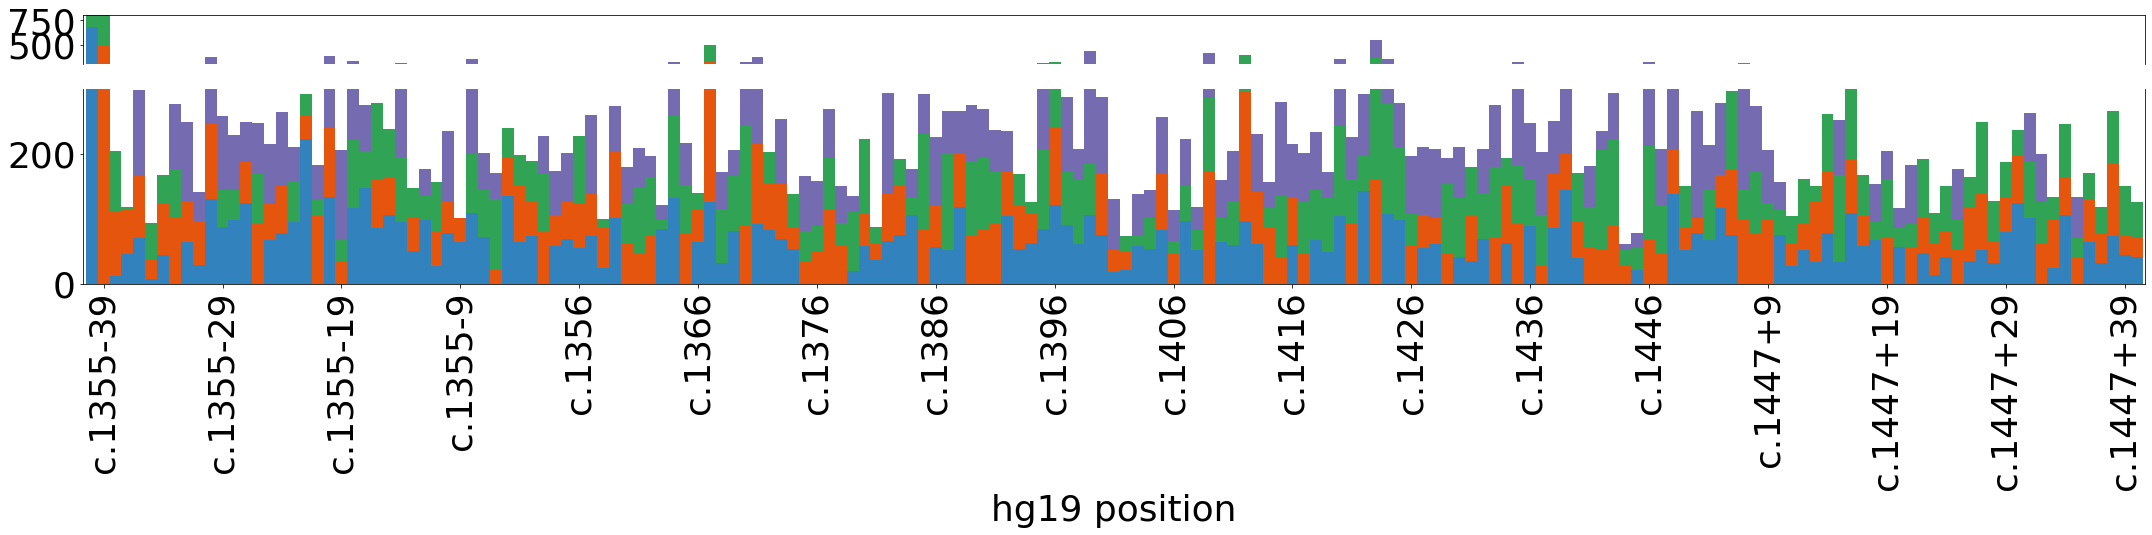

BB_RT_1b_340_243_Hek1053


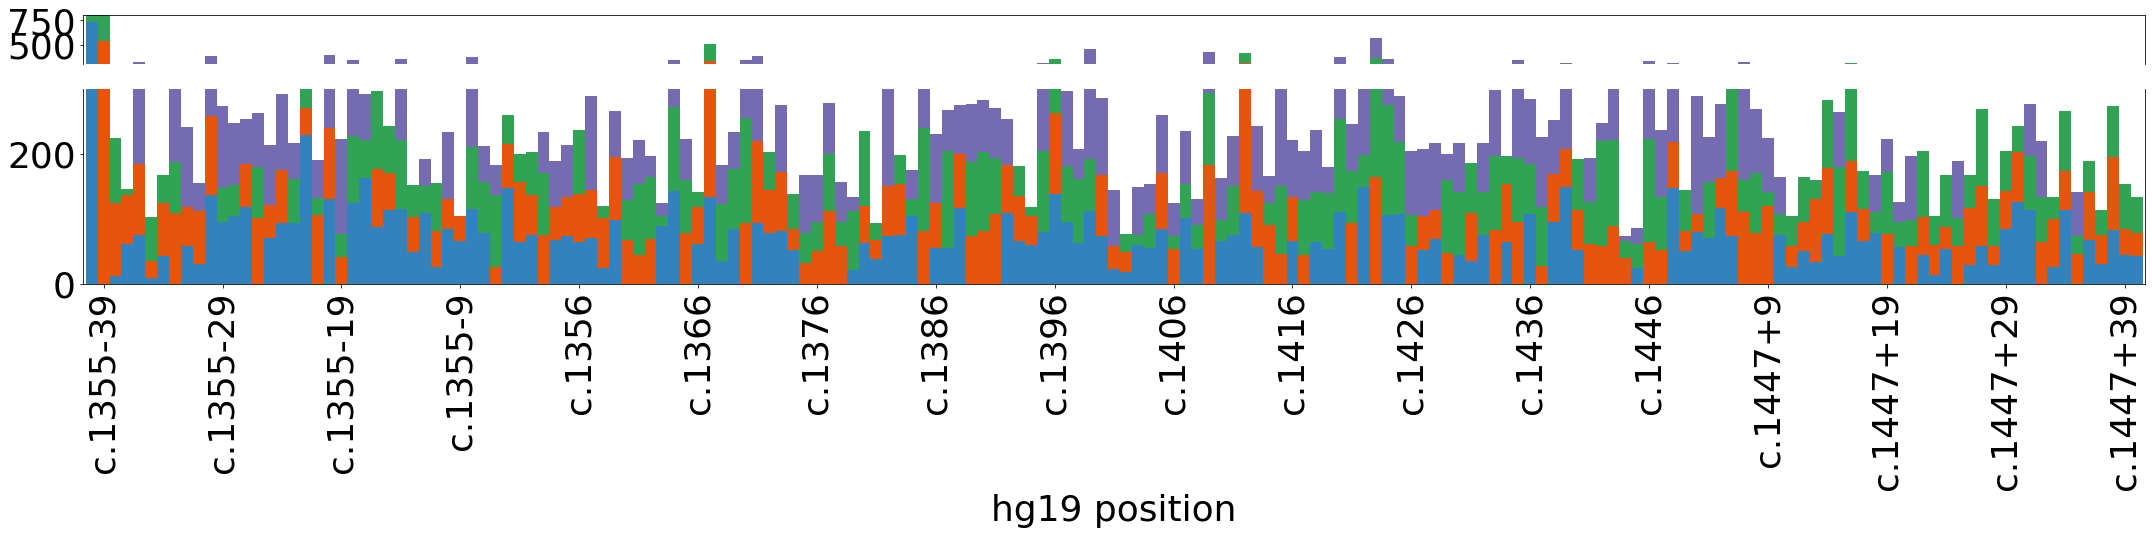

BB_RT_1b_ODT_243_Hek1053


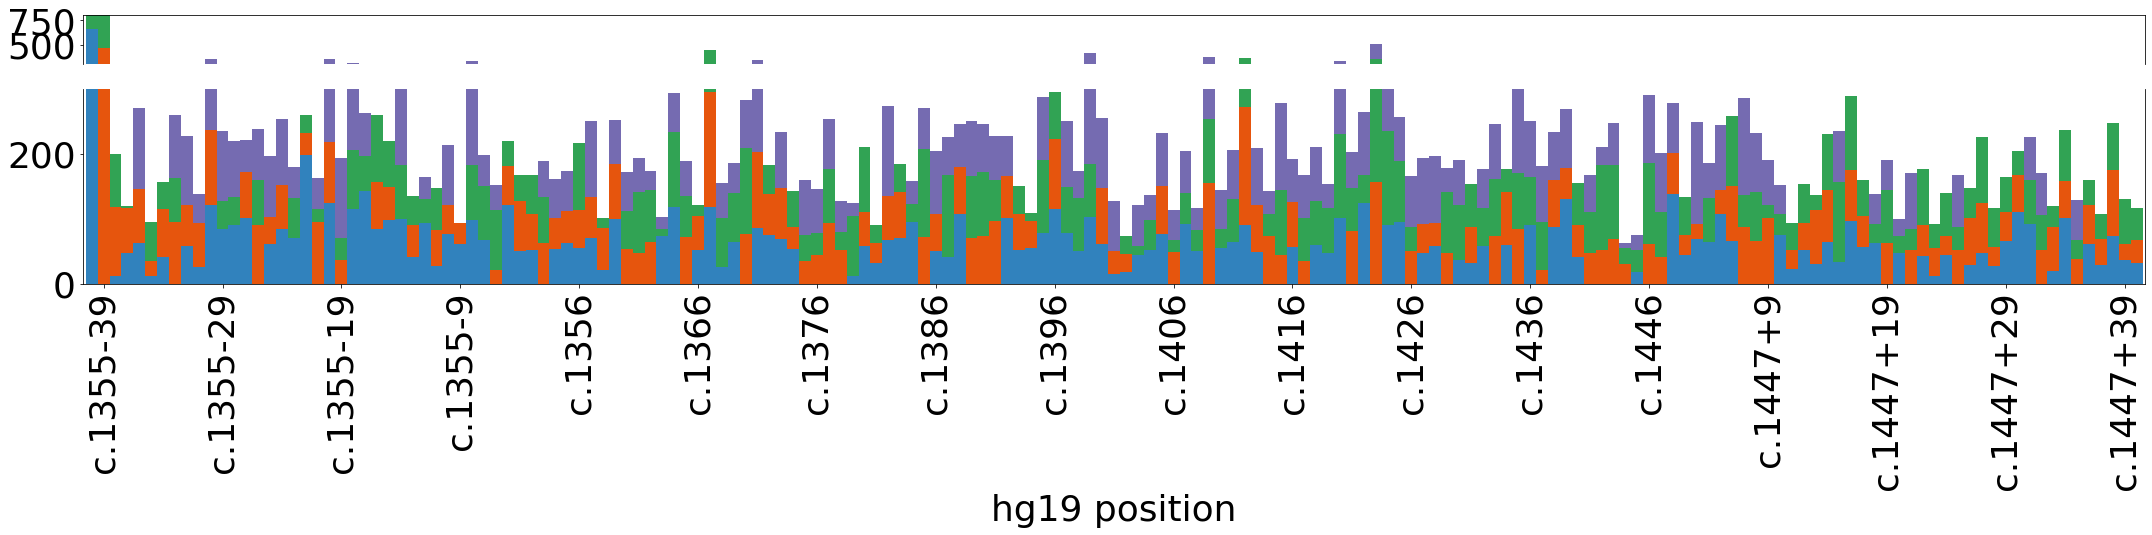

BB_RT_1_ODT_243_Hek1053


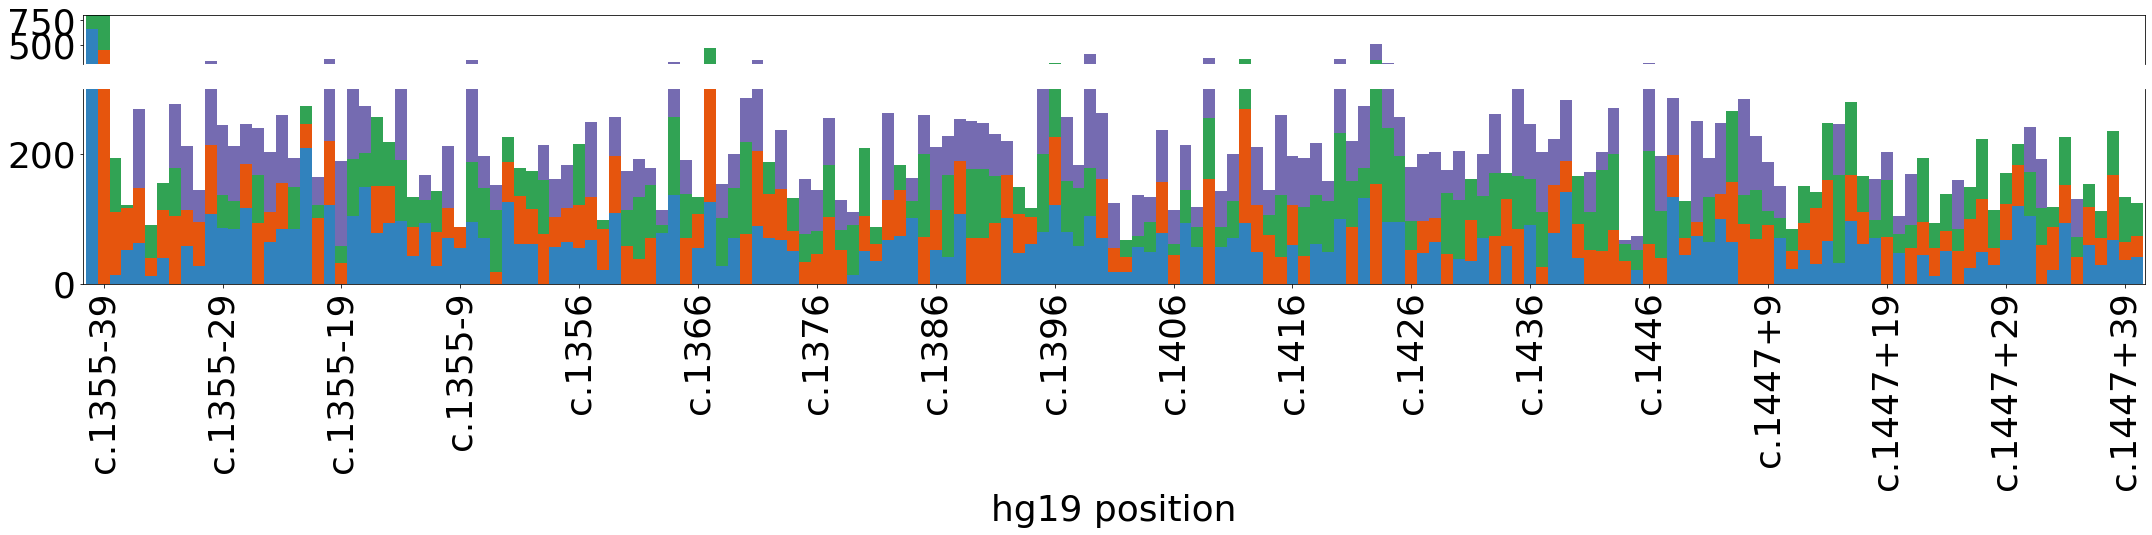

BB_RT_2_340_243_Hek1054


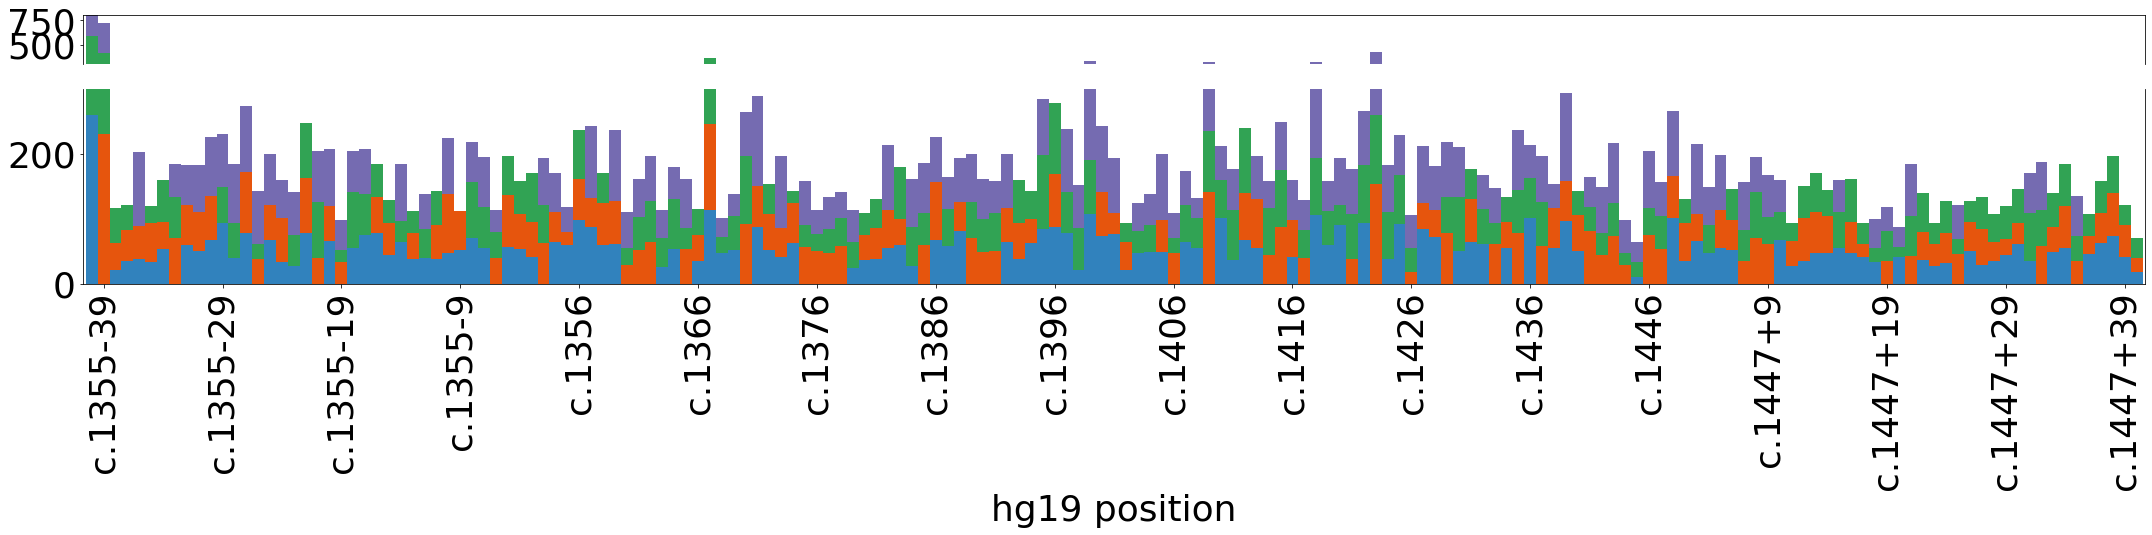

BB_RT_2_ODT_243_Hek1054


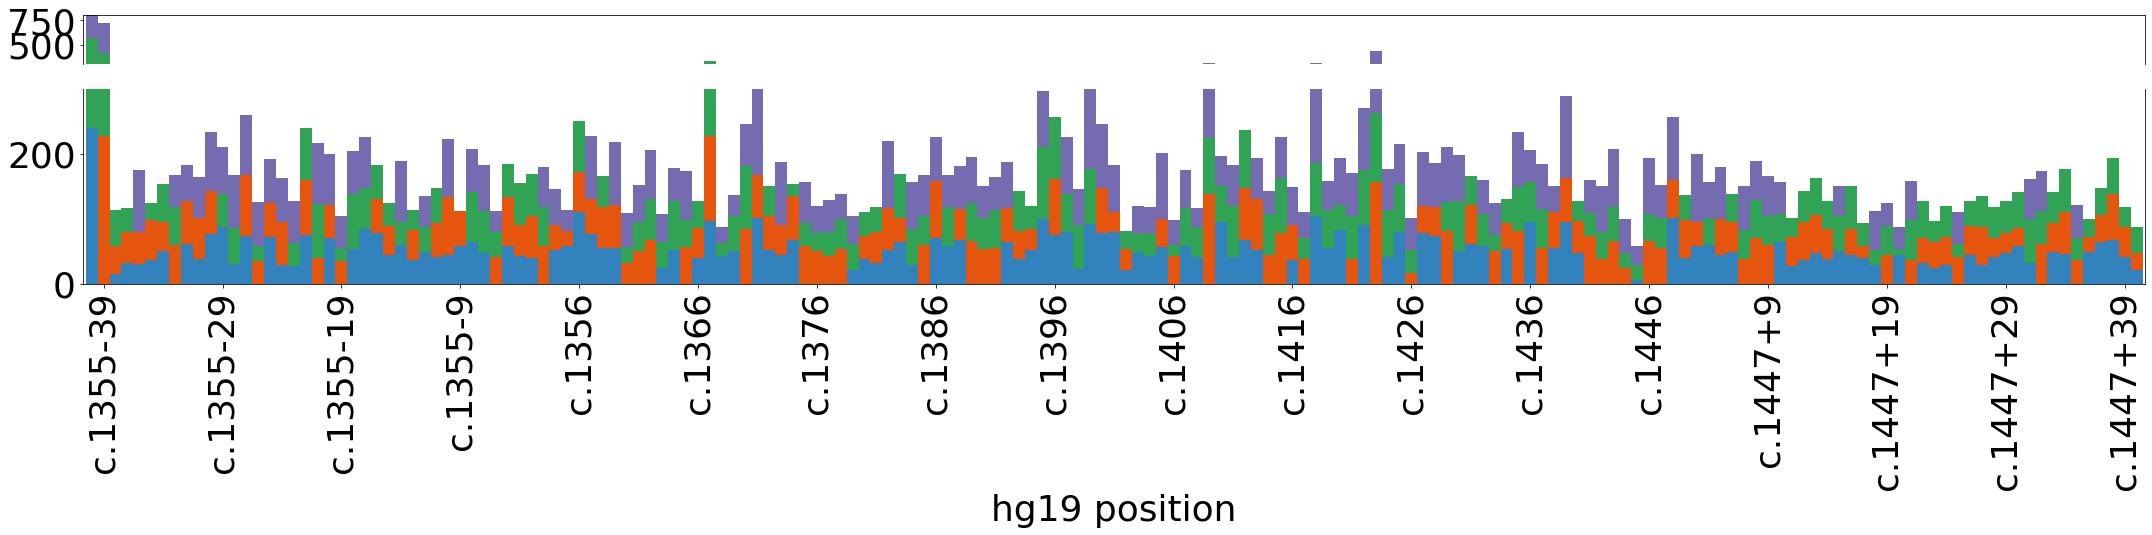

BB_RT_3_340_243_Cos1055


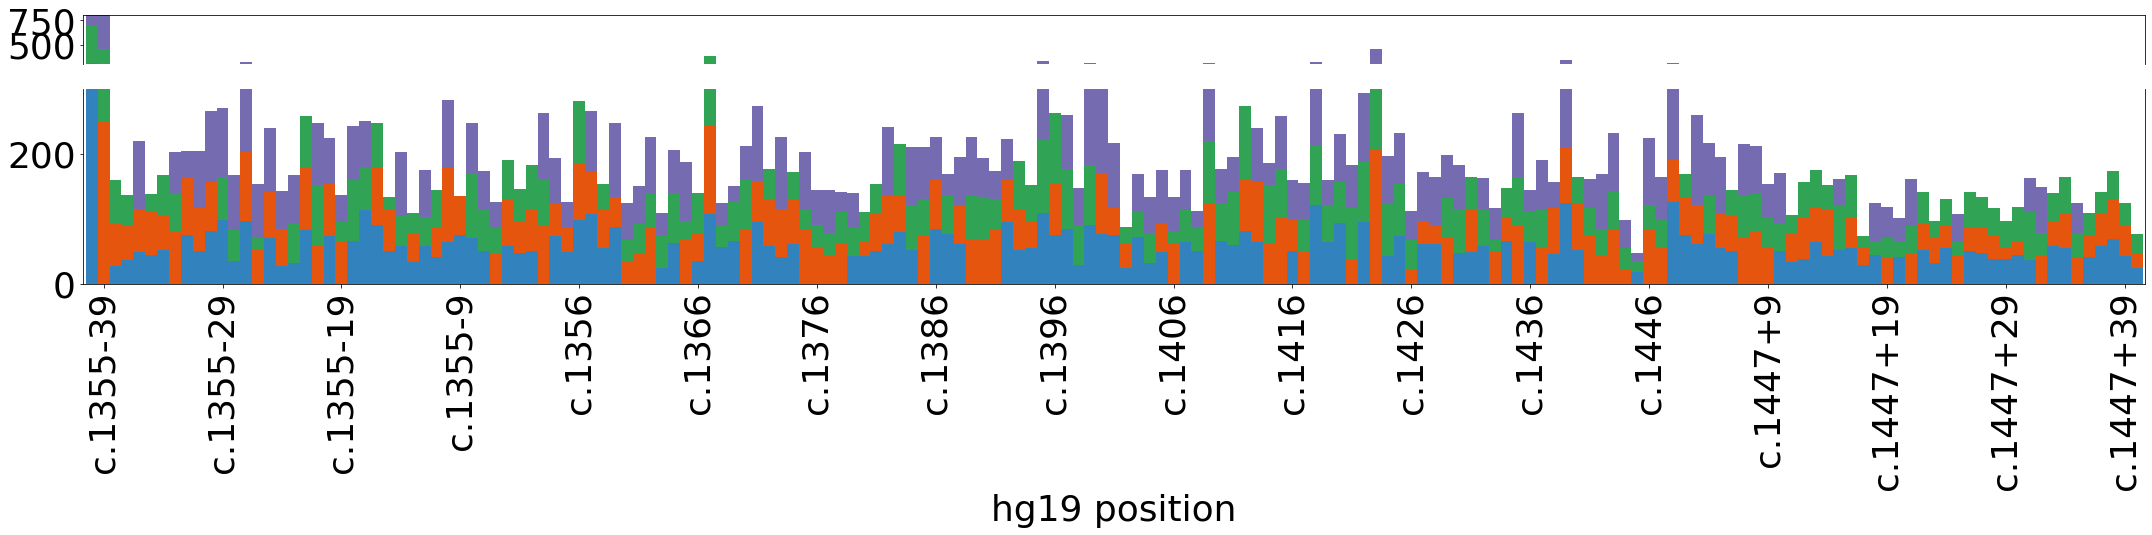

BB_RT_3_340_243_Hek1055


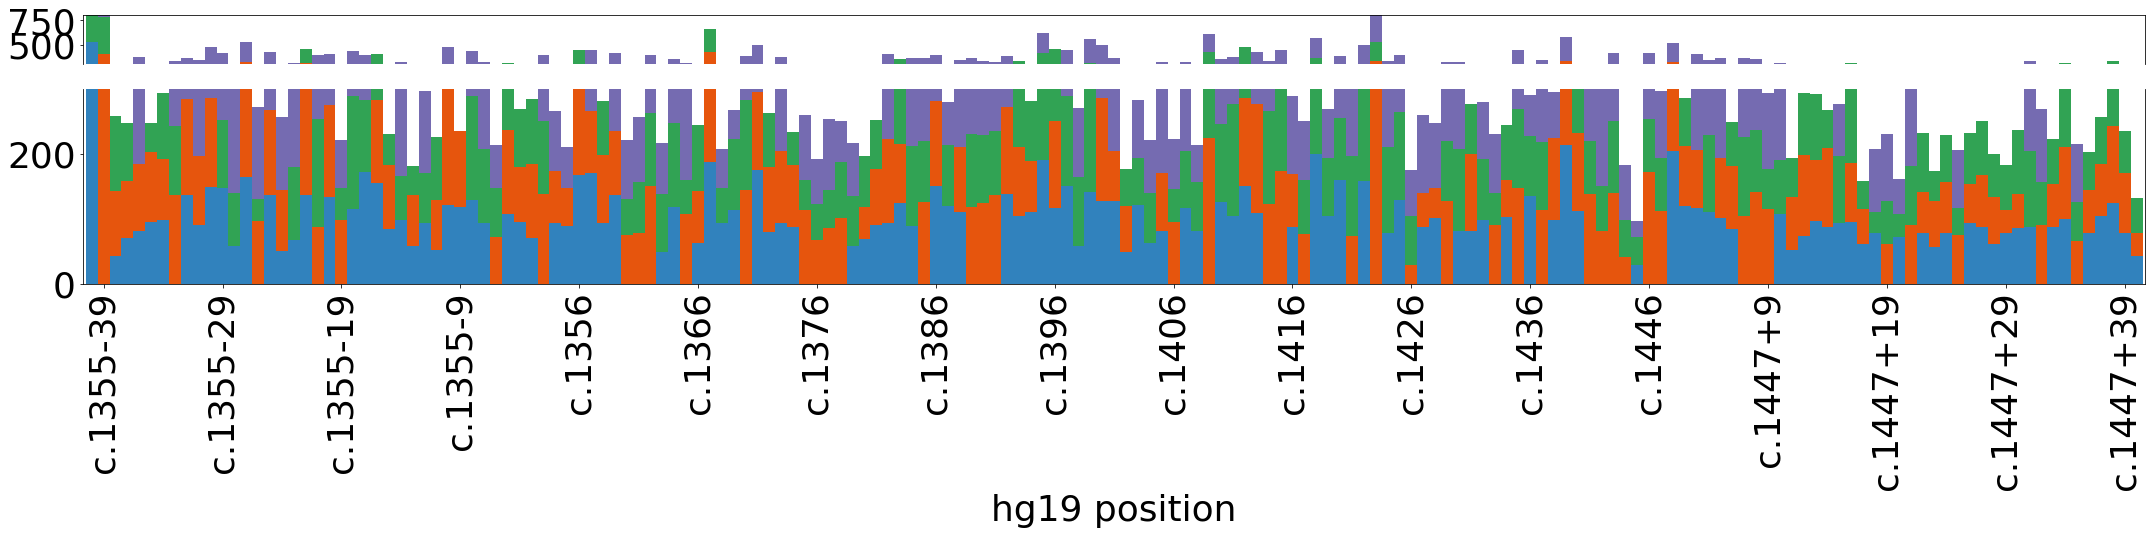

BB_RT_3_ODT_243_Cos1055


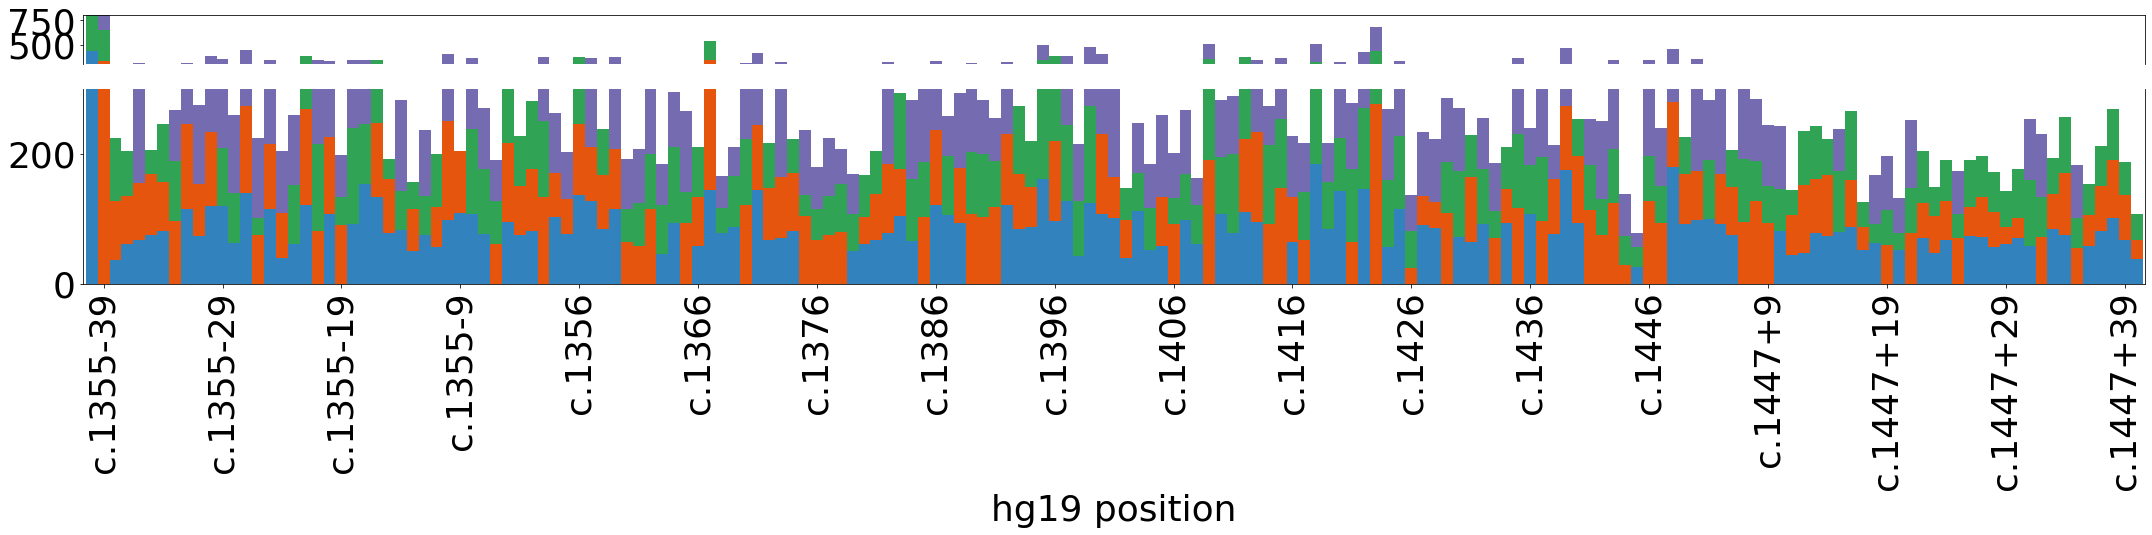

BB_RT_3_ODT_243_Hek1055


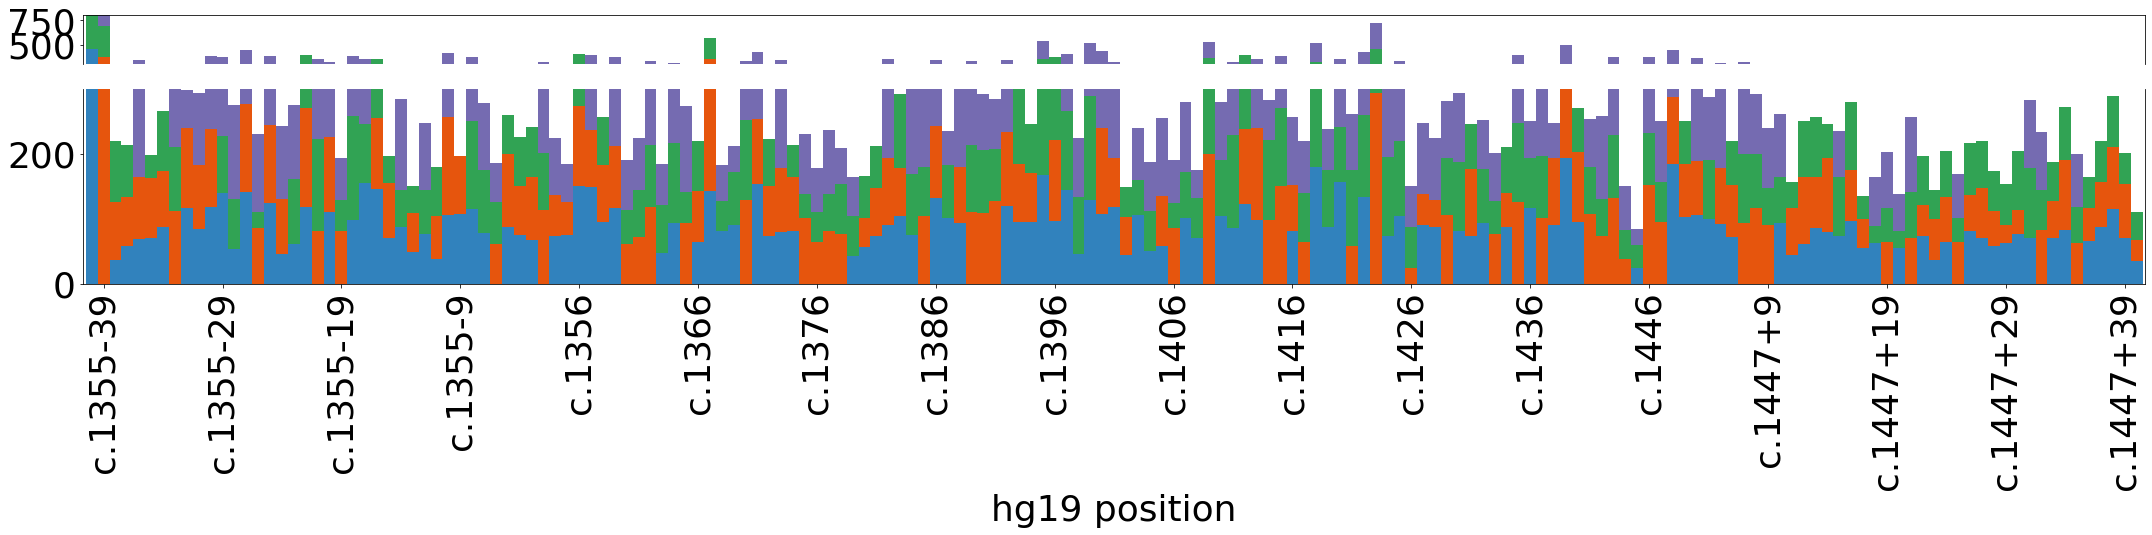

In [103]:
for samp in byvartbl_sat[ 'sample' ].unique():
    
    print( samp )

    sp.split_ax_bcs(  byvartbl_sat.loc[ ( byvartbl_sat[ 'sample' ] == samp ) ].rename( columns = { 'alt': 'a',
                                                                                                   'ref': 'r',
                                                                                                   'alt_c': 'alt',
                                                                                                   'ref_c': 'ref' } ),
                  [ 'n_bc_passfilt' ],
                  'hgvs_pos',
                    [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                    [ ( 300.5, 800 ), ( 0, 300 ) ],
                    fig_size = ( 30, 7.5 ),
                    legend = False,
                    hratios = [ 1, 4 ],
                    x_ax_title = 'hg19 position',
                    #tight = False,
                    #savefile = plot_out + 'bcs_filt_by_pos_split.pdf'
                           )

In [104]:
byvartbl_sat[ 'KTS_+_ratio' ] = ( byvartbl_sat[ 'wmean_KTS+' ] + .001 ) / ( byvartbl_sat[ 'wmean_KTS-' ] + .001 )

In [105]:
byvartbl_sat[ 'KTS_+_ratio' ].max()

12.473132254739395

In [106]:
byvartbl_sat[ 'KTS_+_ratio' ].min()

0.07301614676525749

In [107]:
byvartbl_sat[ 'KTS_+_ratio_log10' ] = np.log10( byvartbl_sat[ 'KTS_+_ratio' ] )

In [108]:
byvartbl_sat[ 'KTS_+_ratio_log10' ].max()

1.0959755272662683

In [109]:
byvartbl_sat[ 'KTS_+_ratio_log10' ].min()

-1.1365810895284583

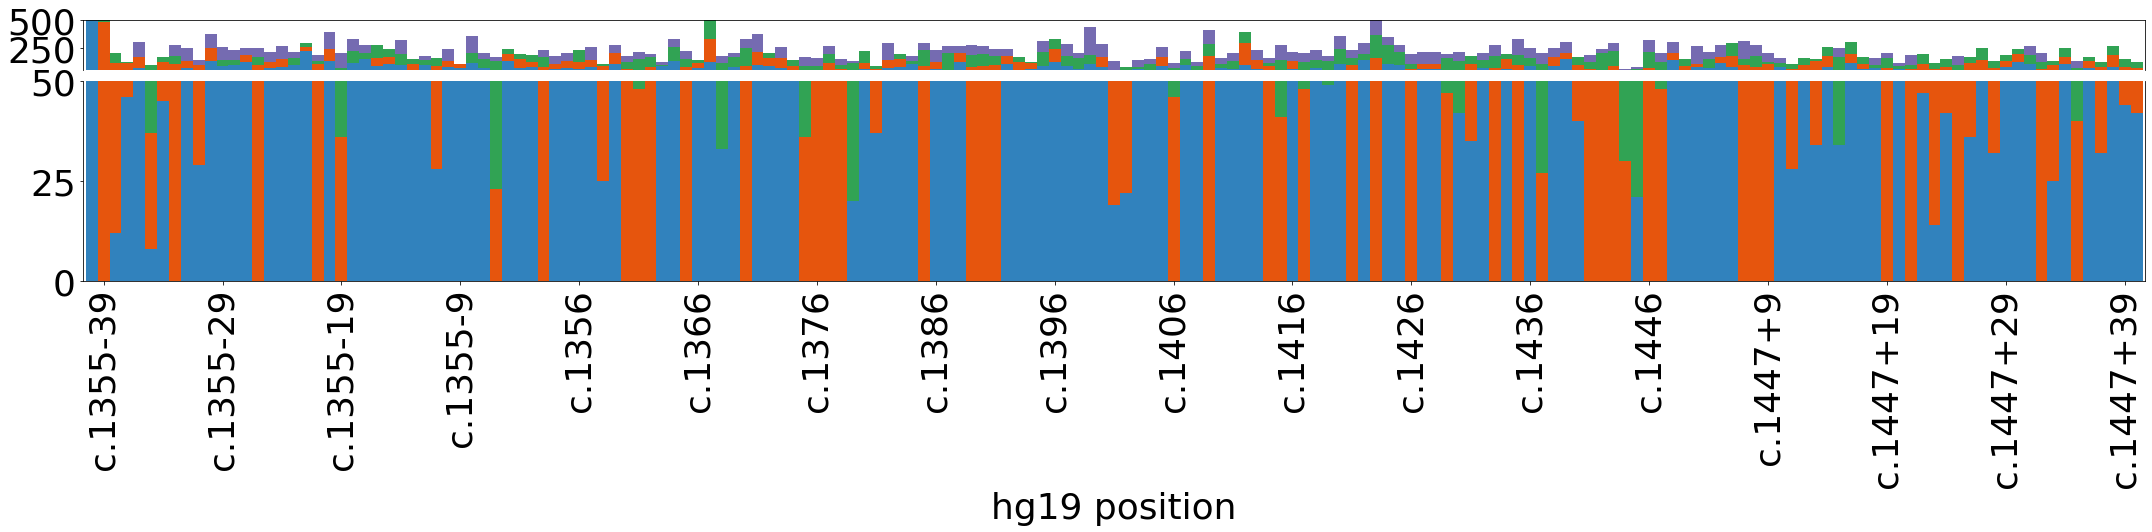

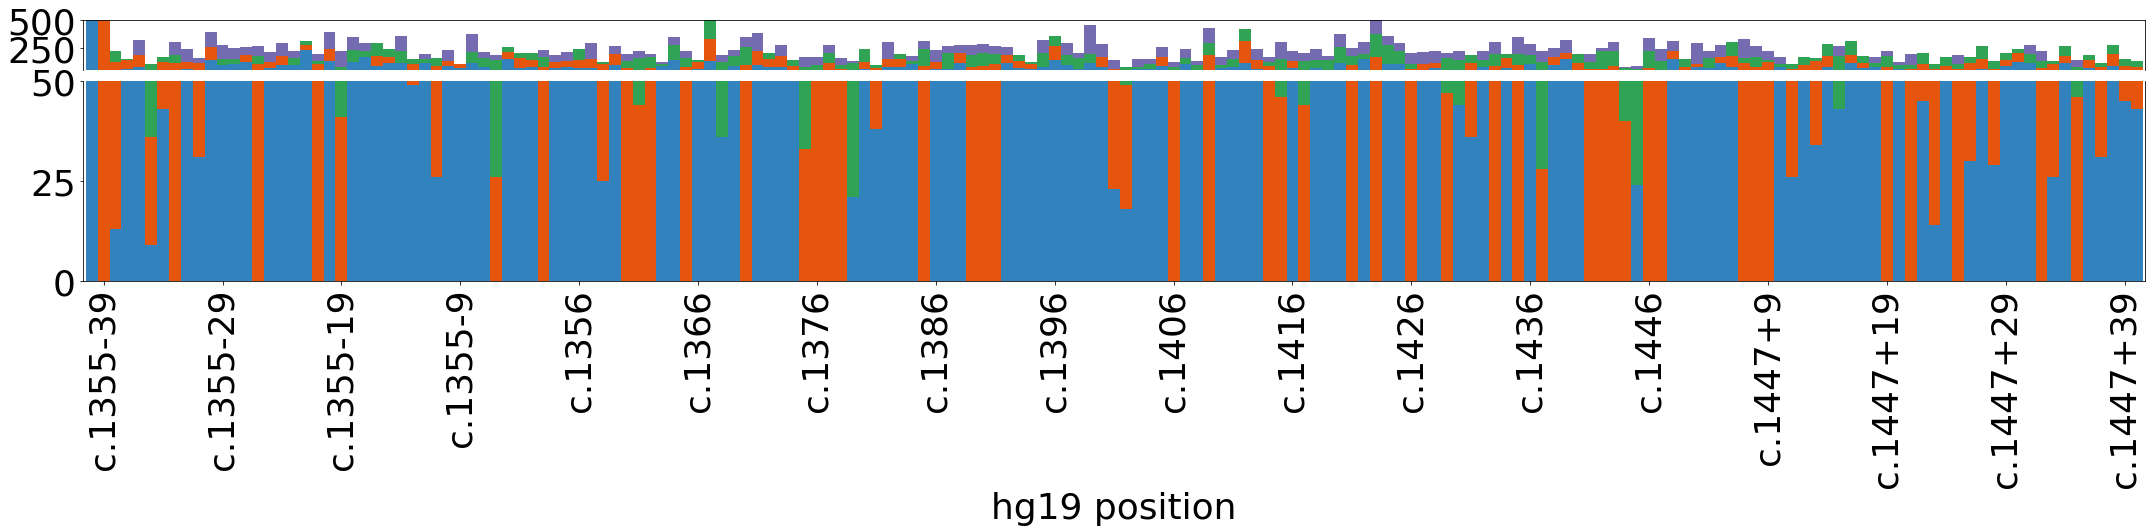

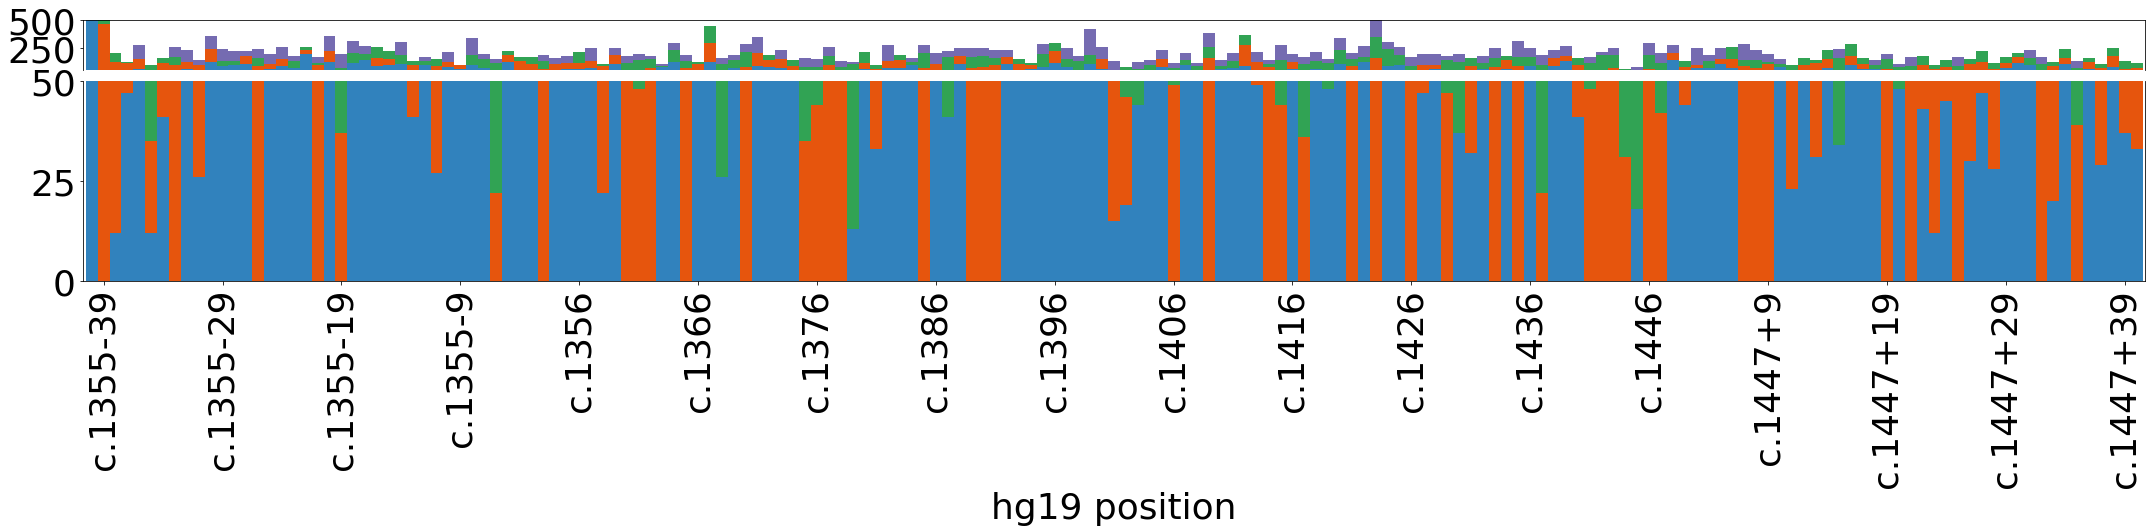

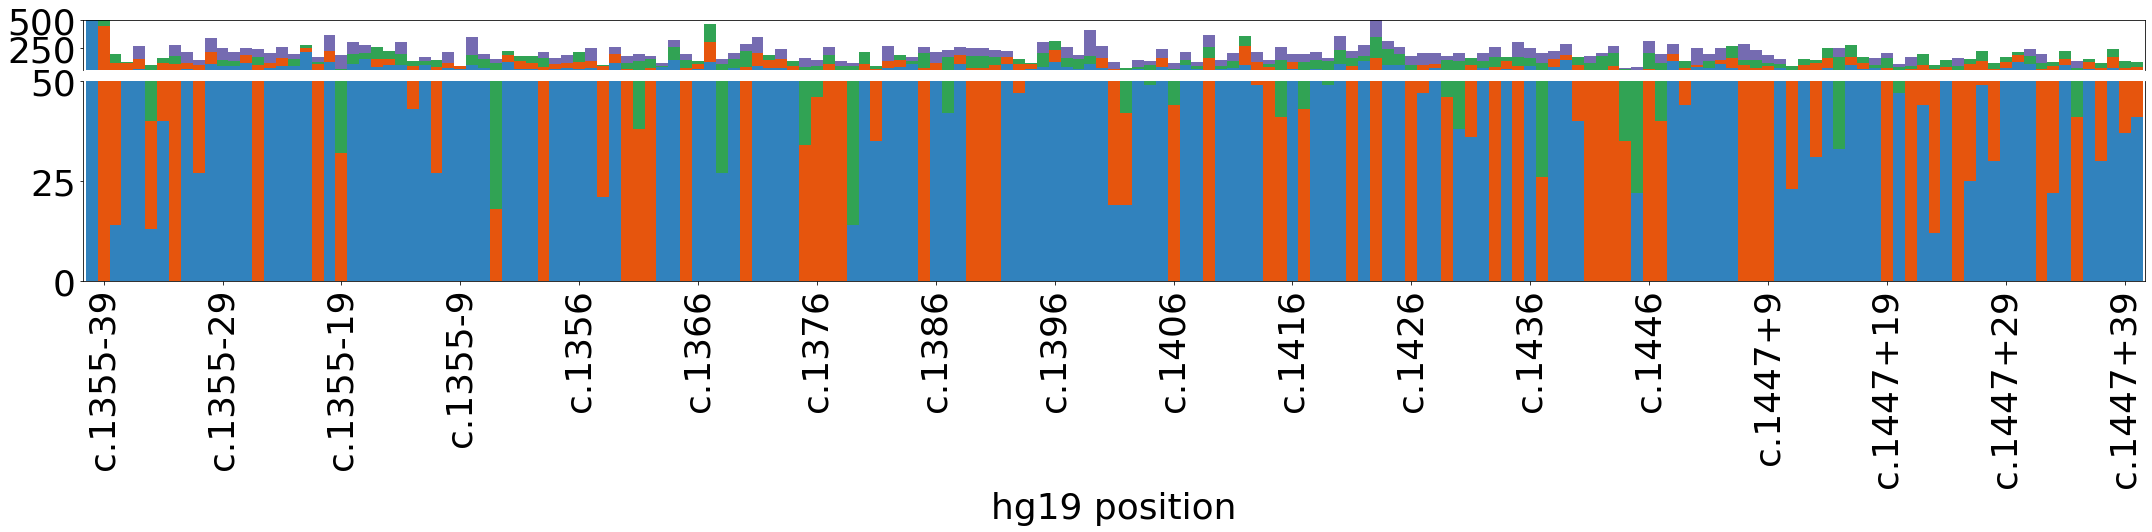

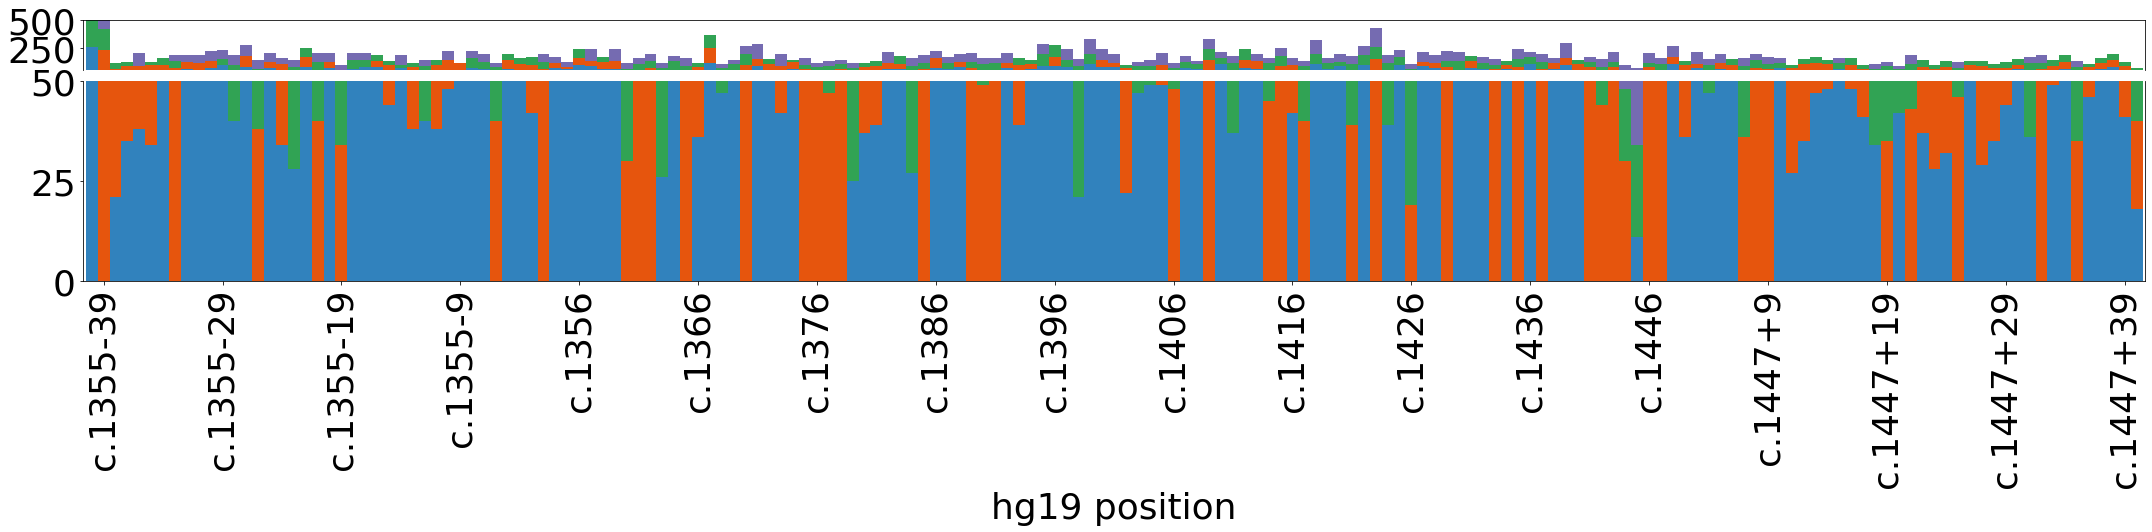

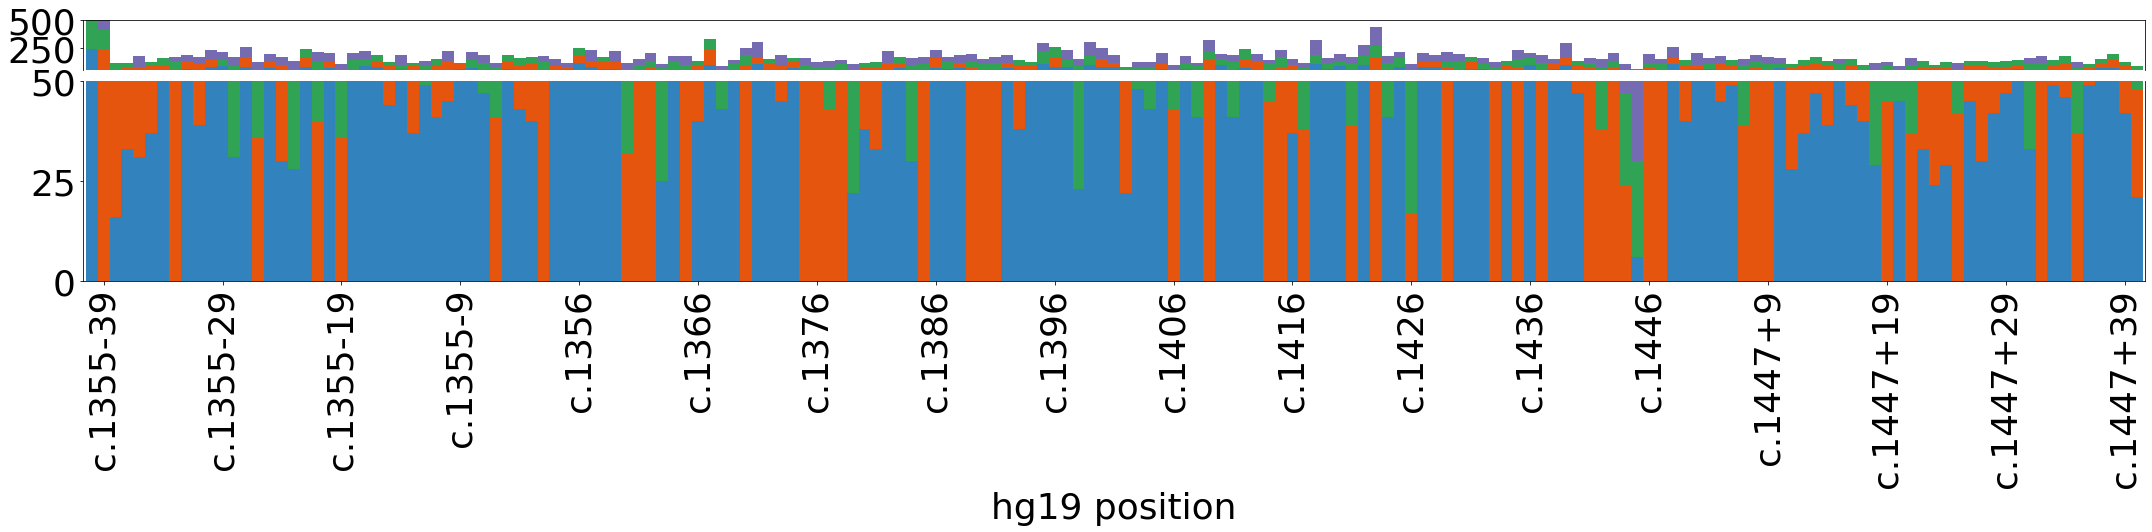

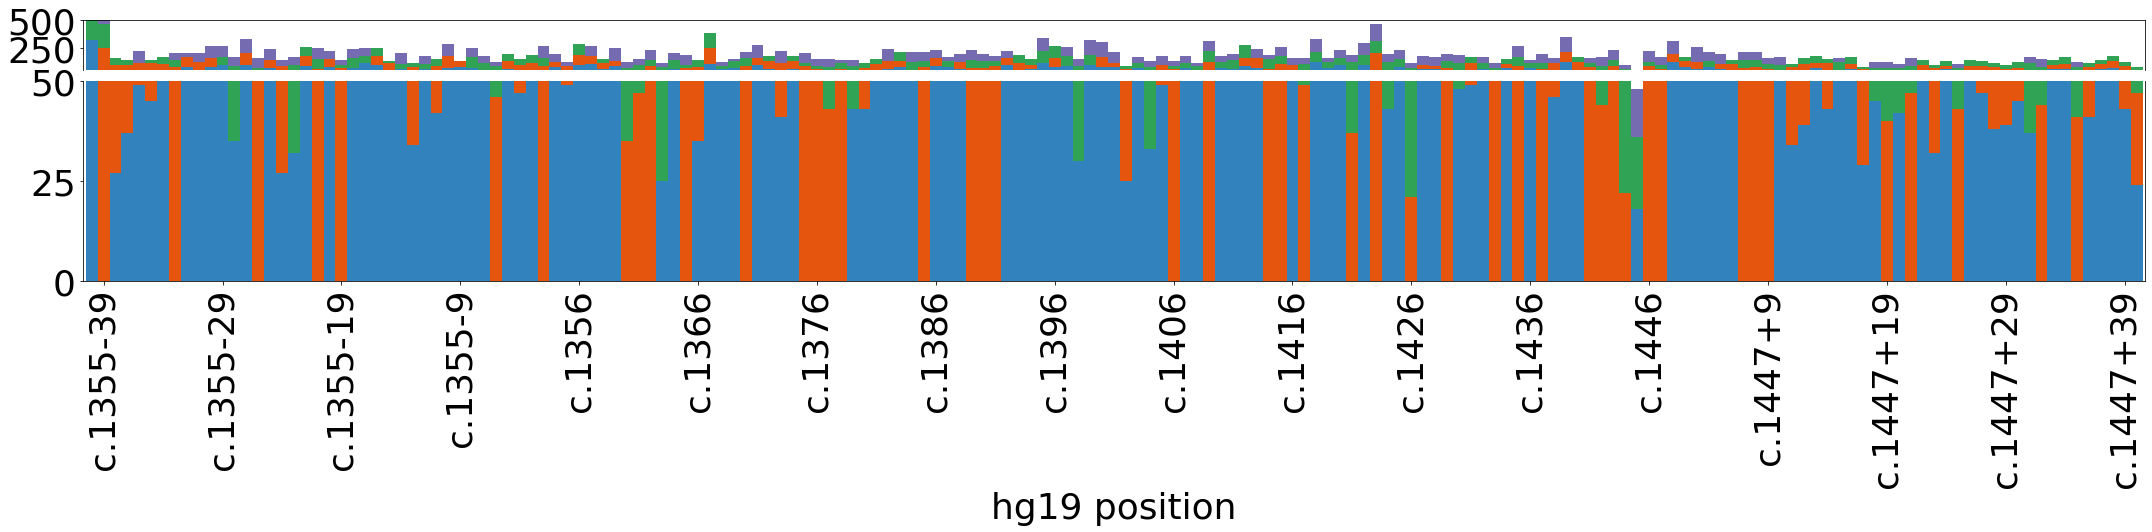

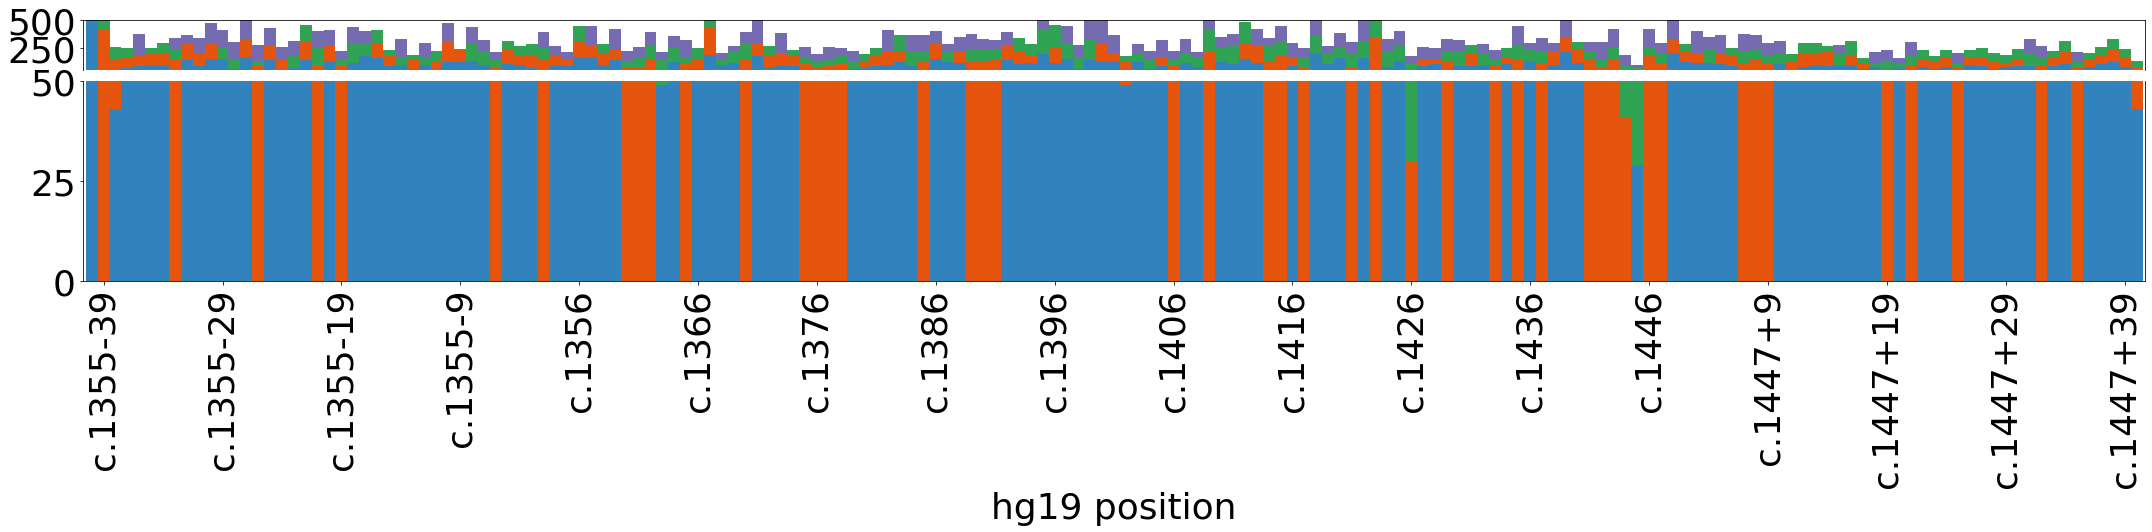

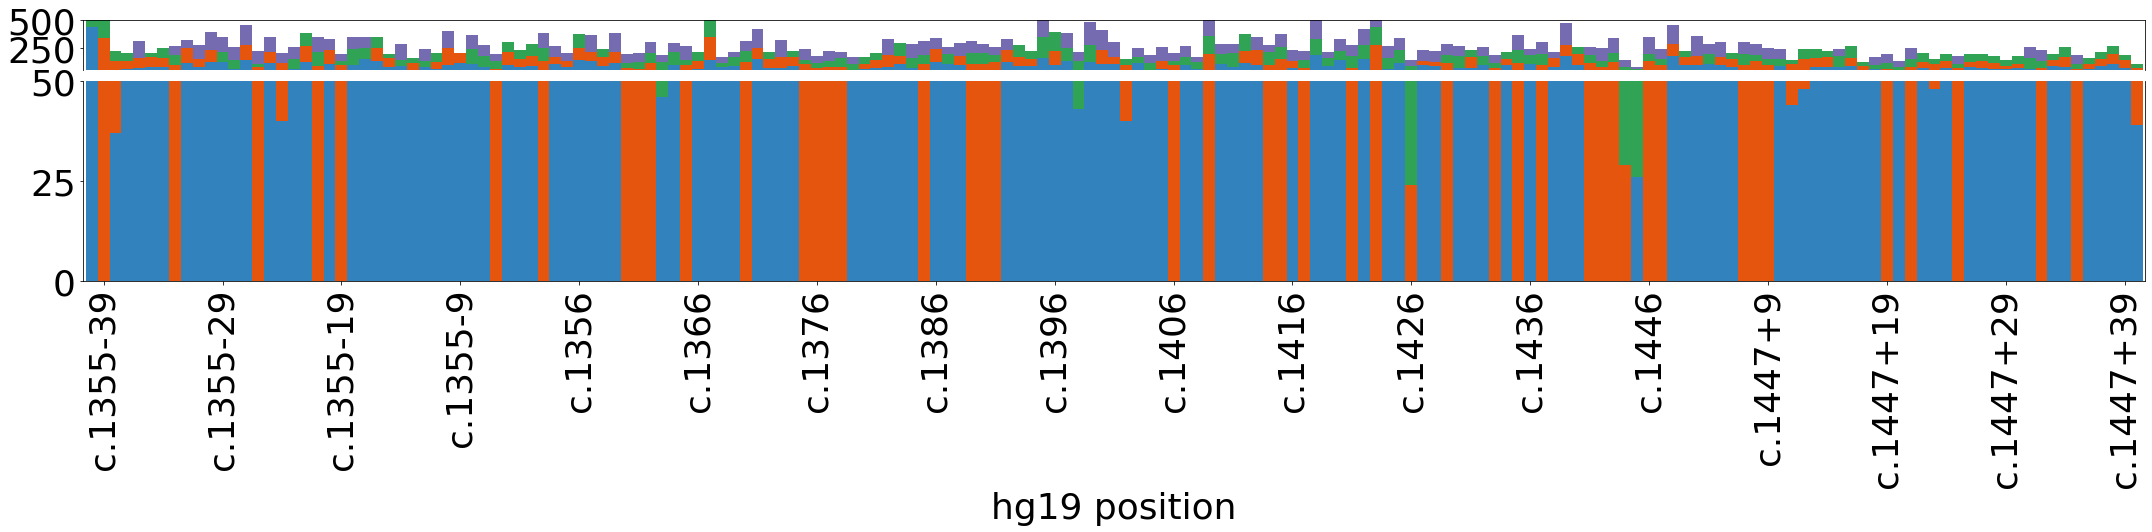

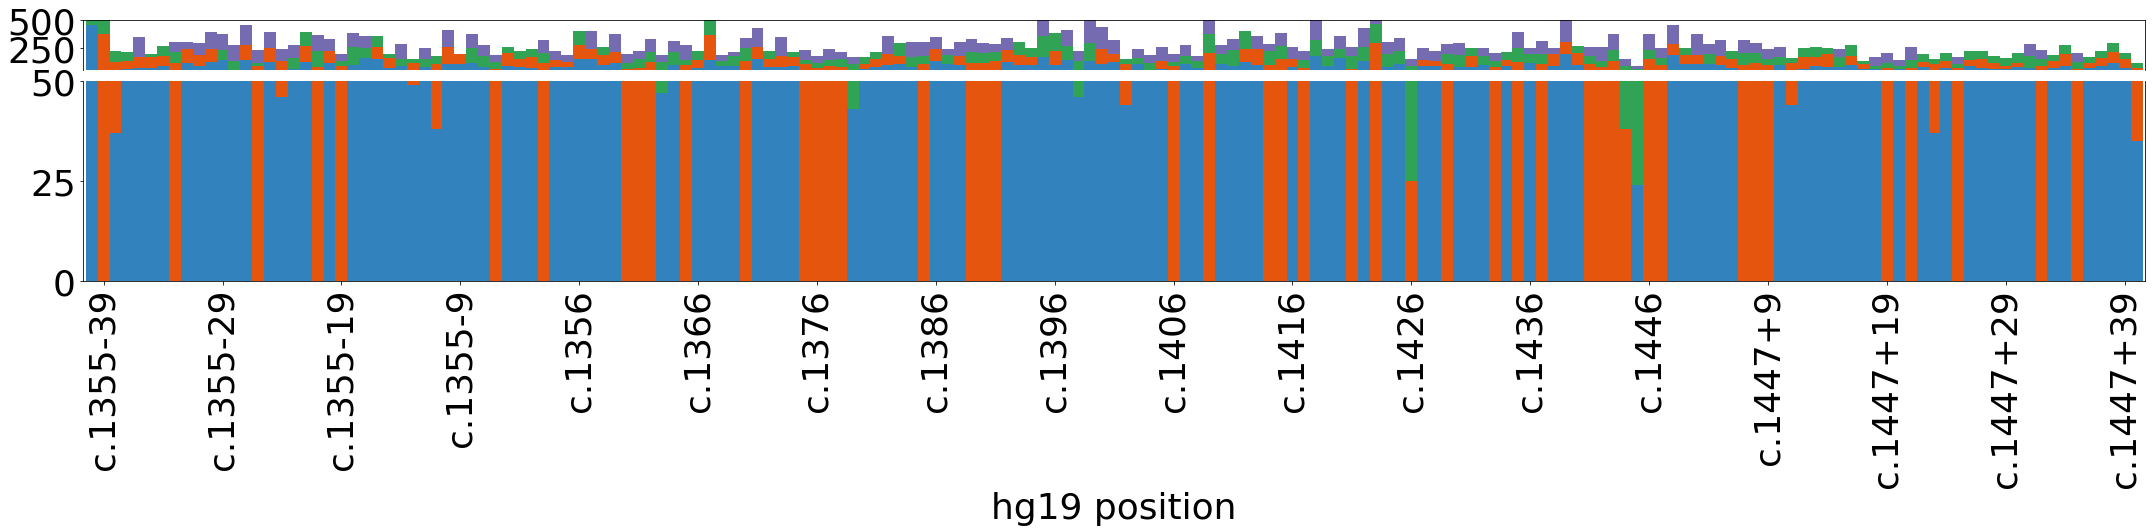

In [112]:
for samp in byvartbl_sat[ 'sample' ].unique():
    
    sp.split_ax_bcs(  byvartbl_sat.loc[ ( byvartbl_sat.pos >= 1227 ) & ( byvartbl_sat[ 'sample' ] == samp ) ].rename( columns = { 'alt': 'a',
                                                                                                                                  'ref': 'r',
                                                                                                                                  'alt_c': 'alt',
                                                                                                                                   'ref_c': 'ref' } ),
                  [ 'n_bc_passfilt' ],
                  'hgvs_pos',
                    [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                    [ ( 50.5, 500 ), ( 0, 50 ) ],
                    fig_size = ( 30, 7.5 ),
                    legend = False,
                    hratios = [ 1, 4 ],
                    x_ax_title = 'hg19 position',
                    #tight = False,
                    #savefile = plot_out + 'bcs_filt_by_pos_split.pdf'
                           )

BB_RT_1_340_243_Hek1053


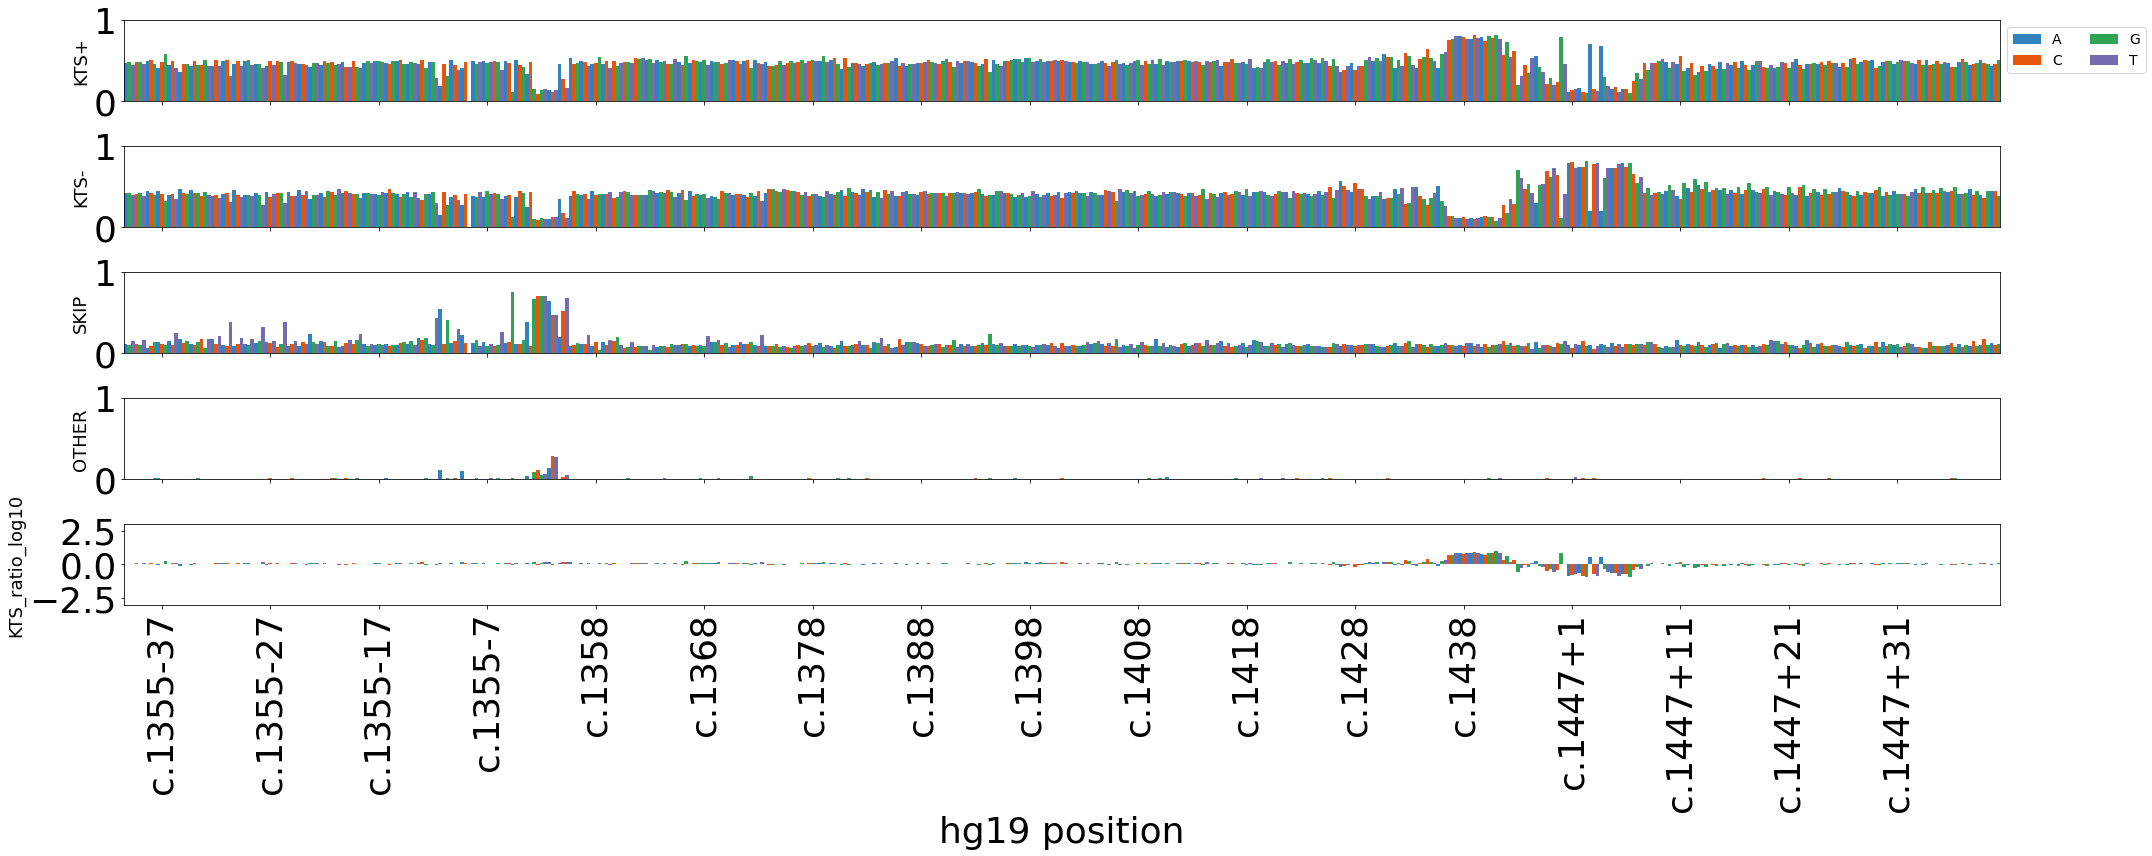

BB_RT_1b_340_243_Hek1053


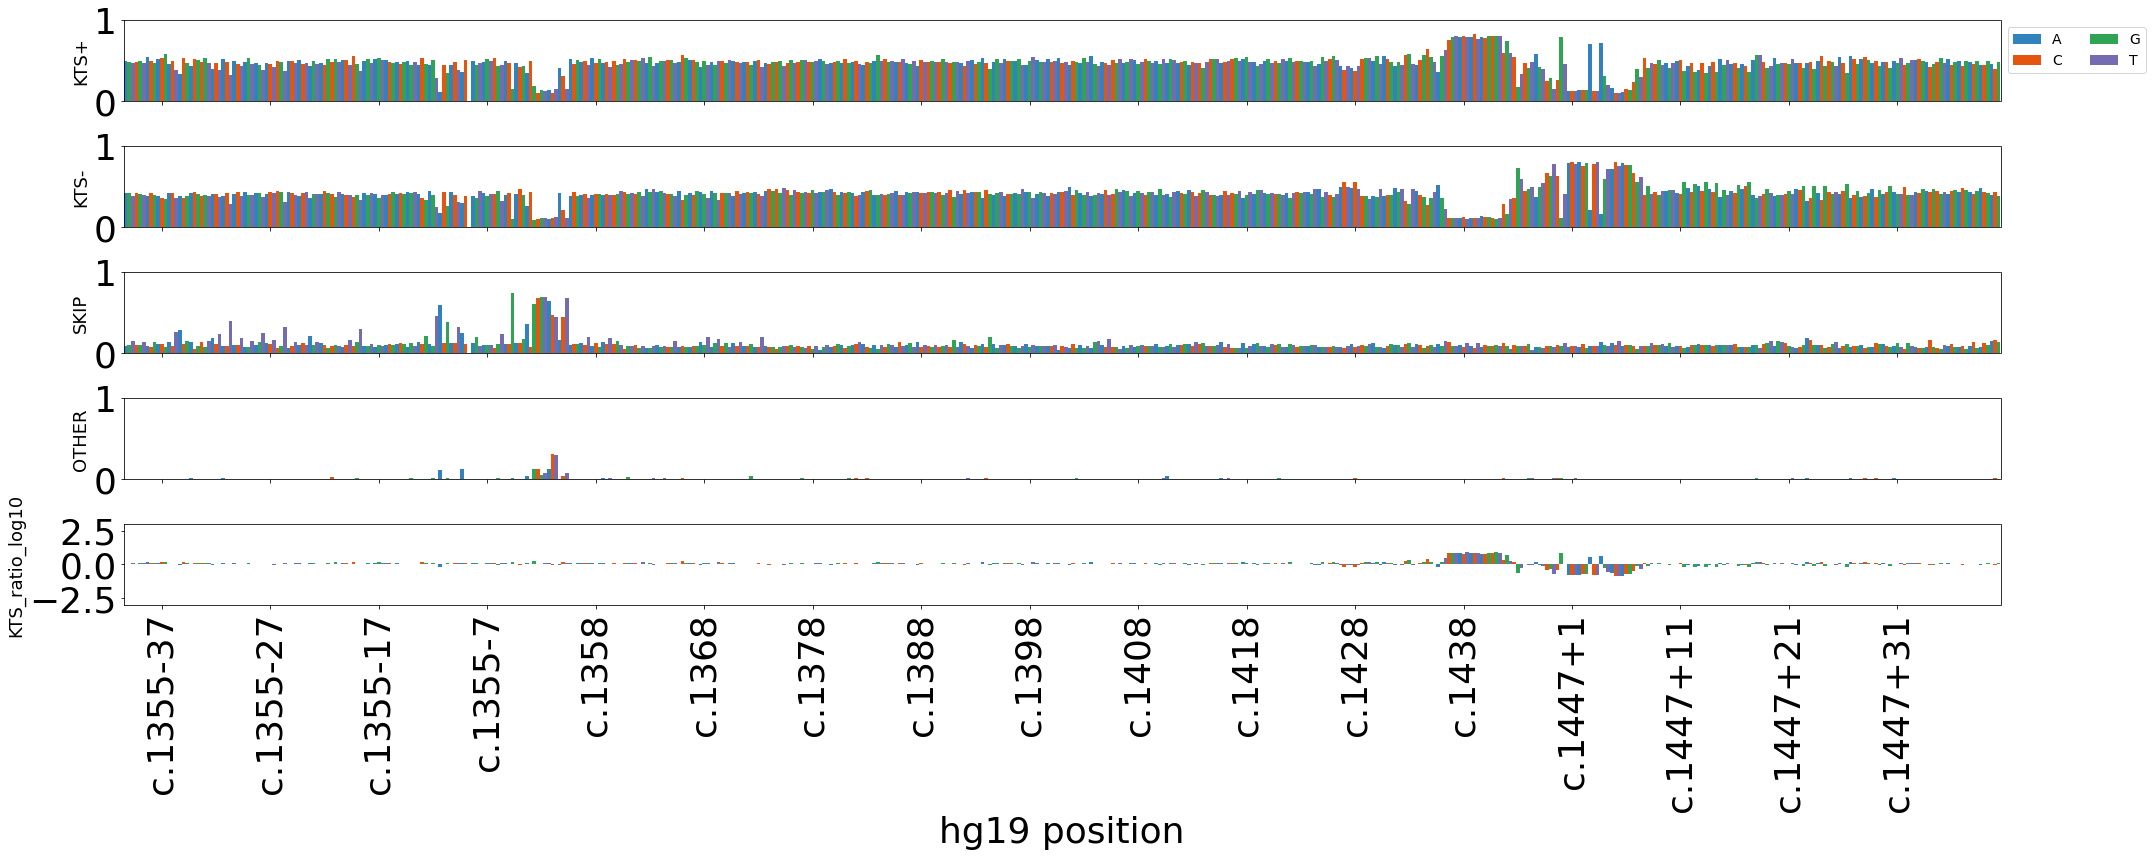

BB_RT_1b_ODT_243_Hek1053


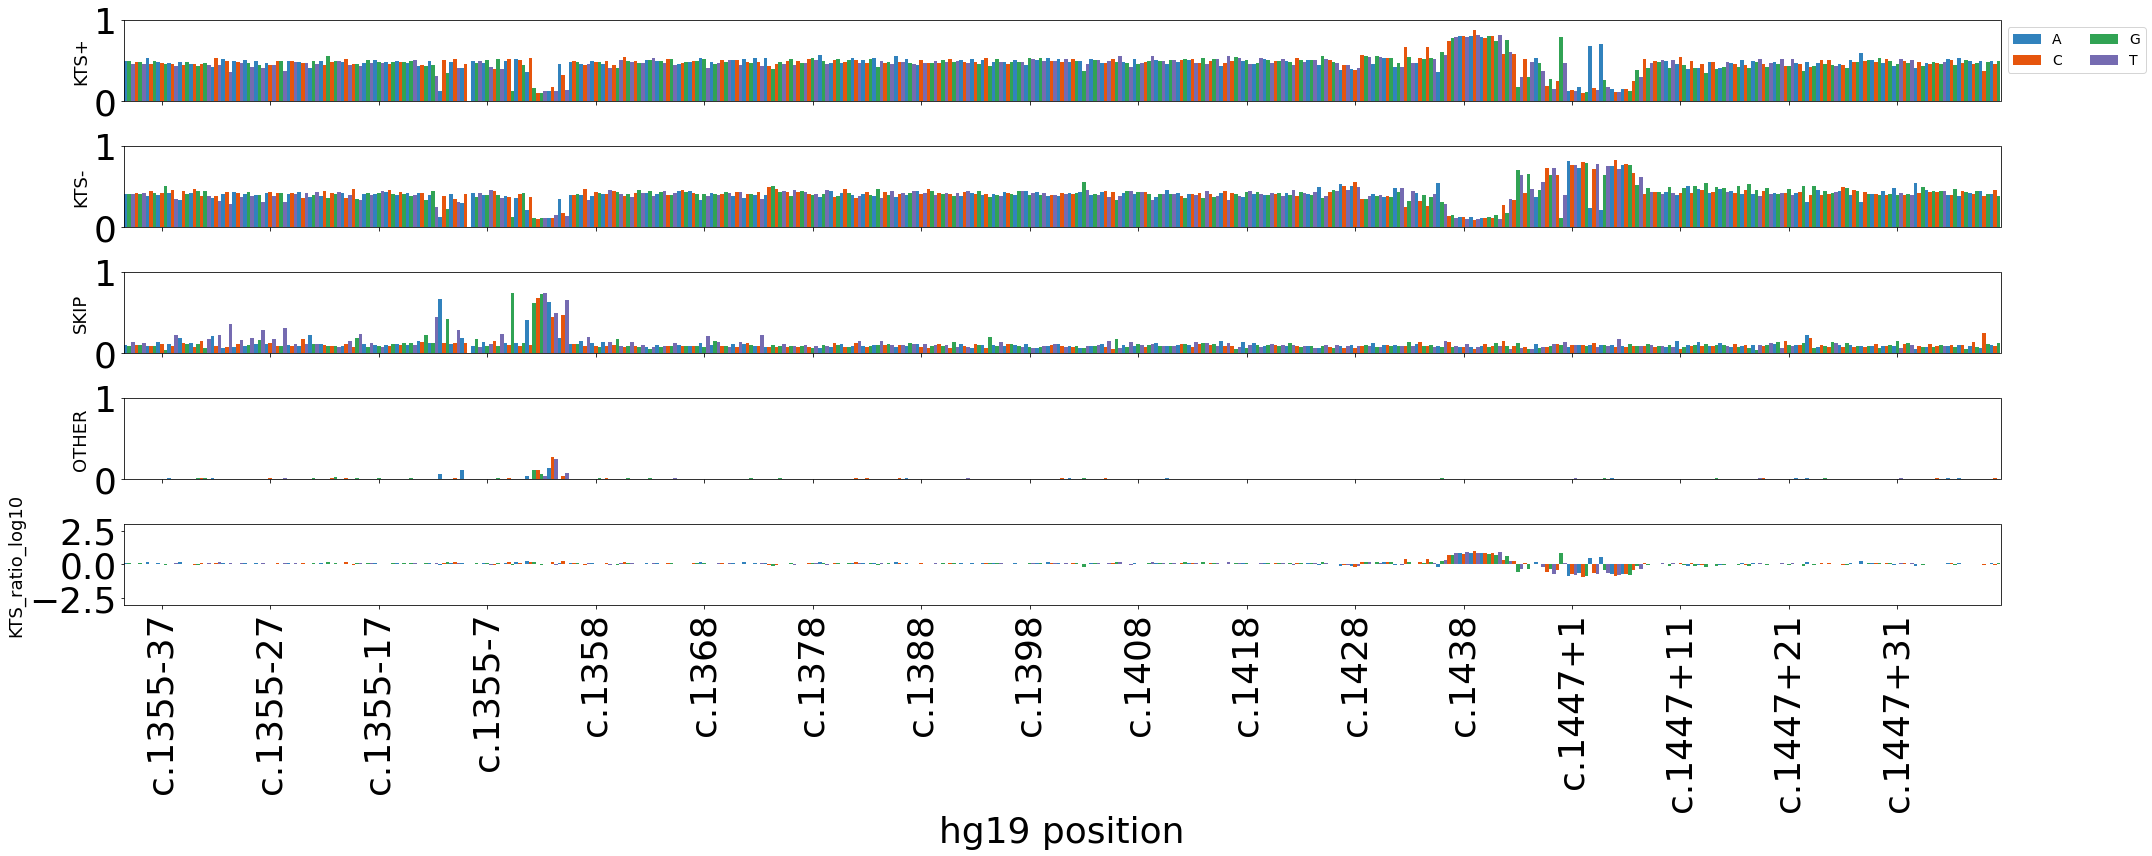

BB_RT_1_ODT_243_Hek1053


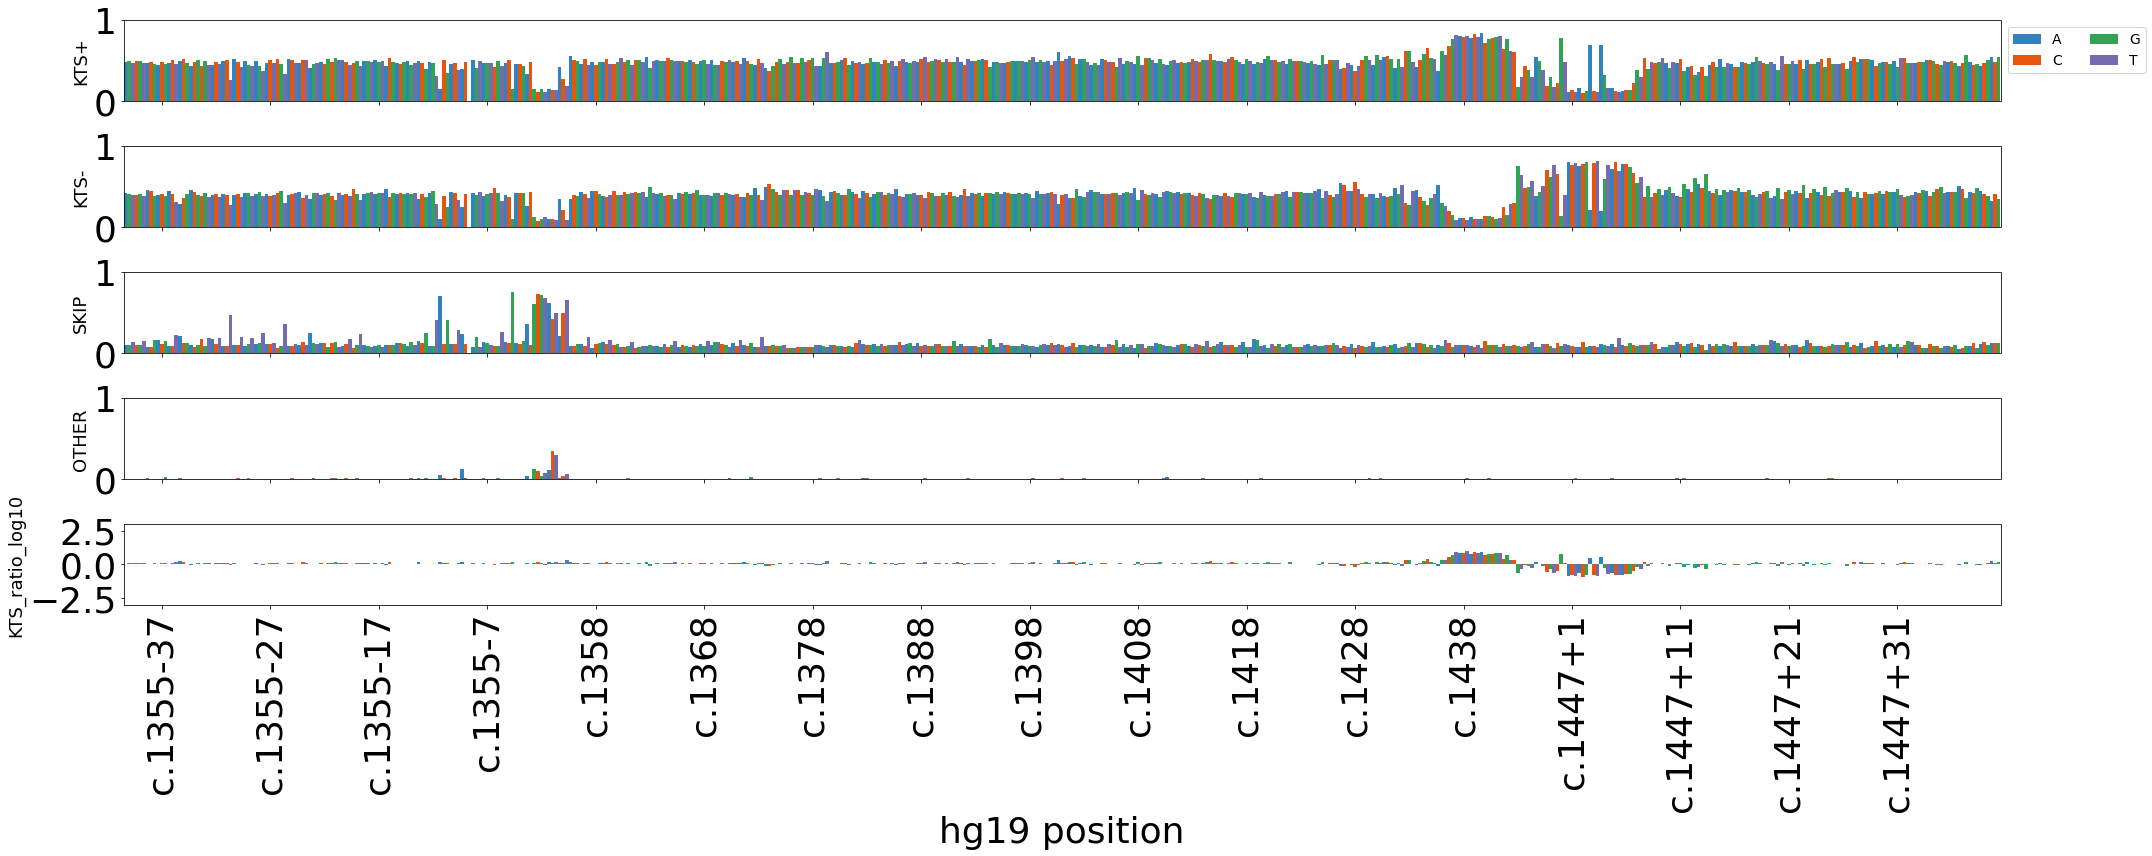

BB_RT_2_340_243_Hek1054


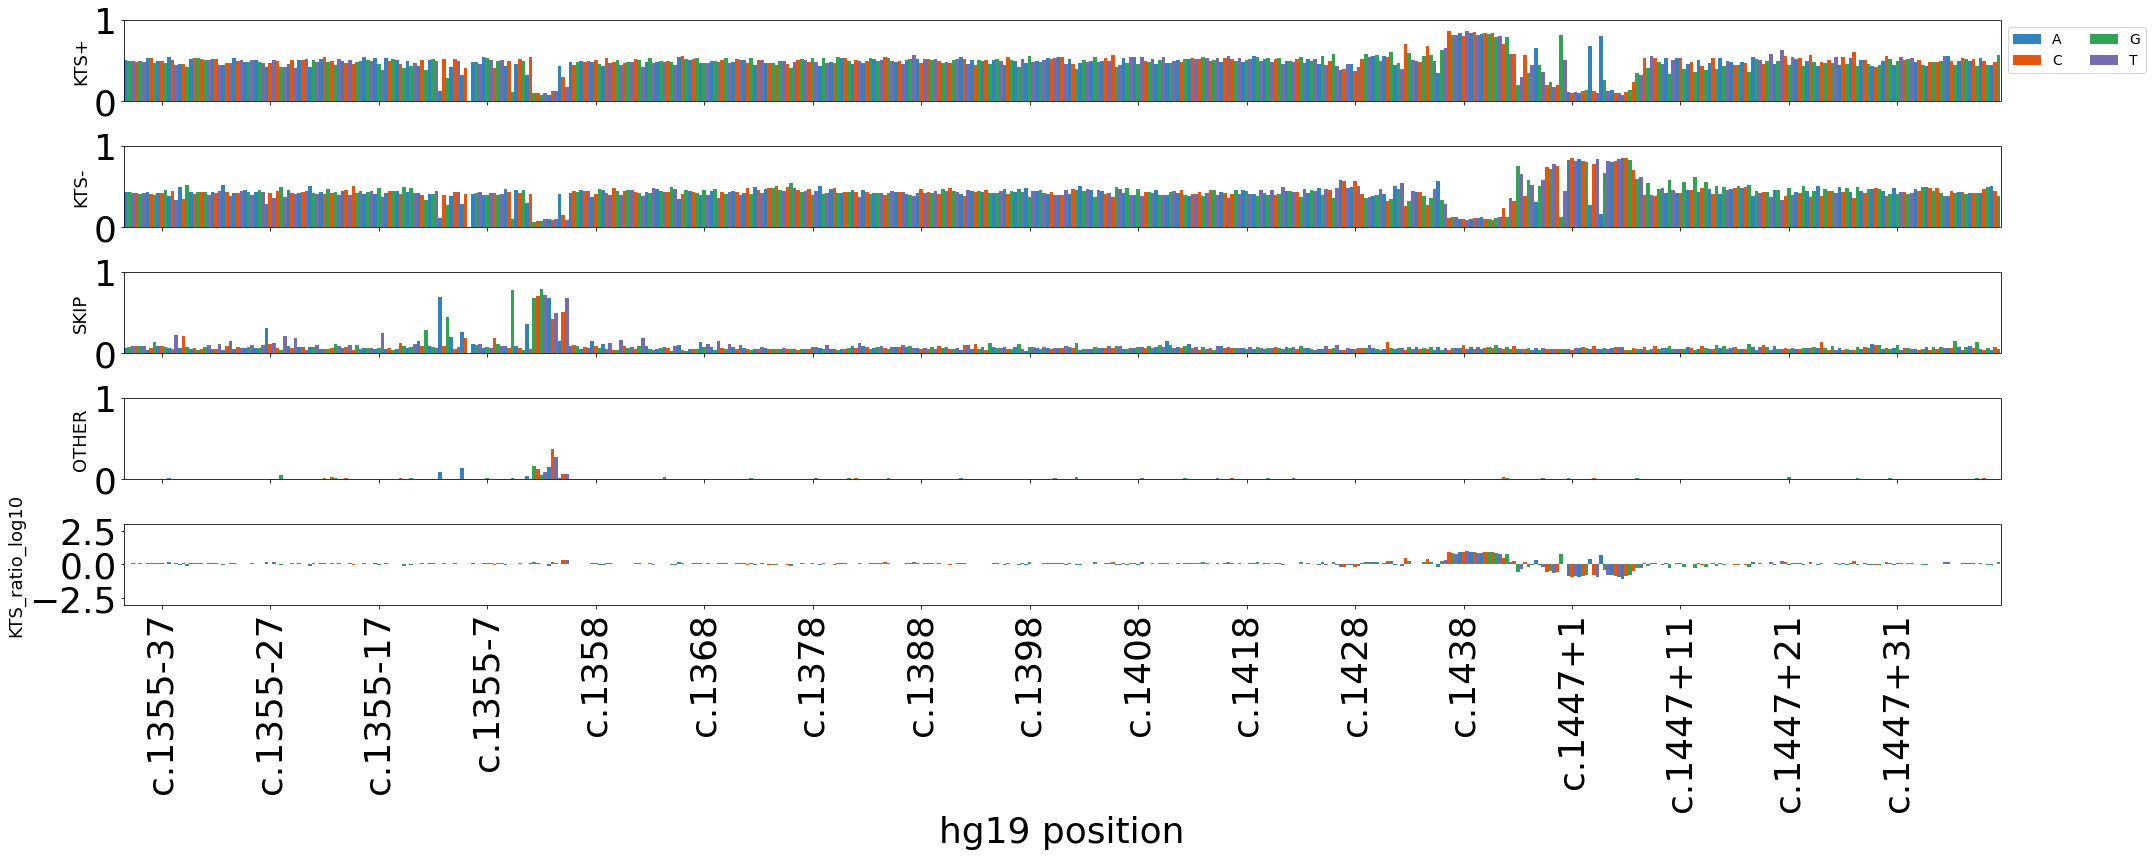

BB_RT_2_ODT_243_Hek1054


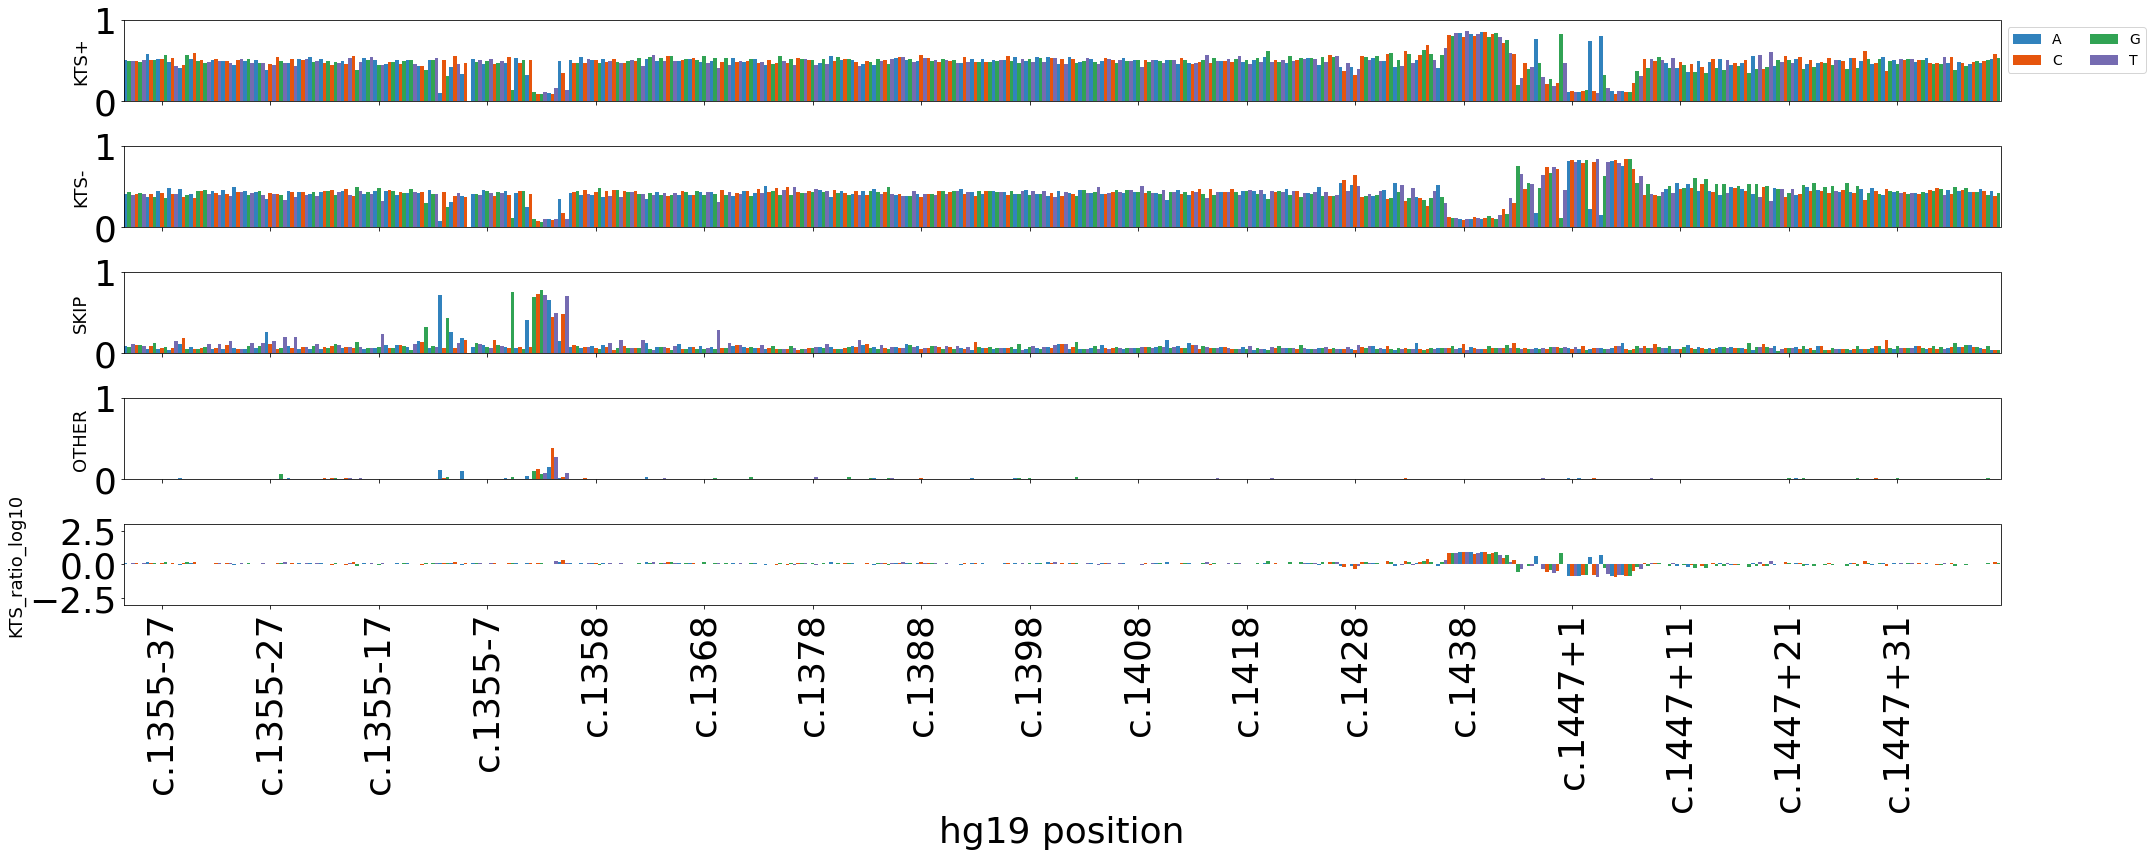

BB_RT_3_340_243_Cos1055


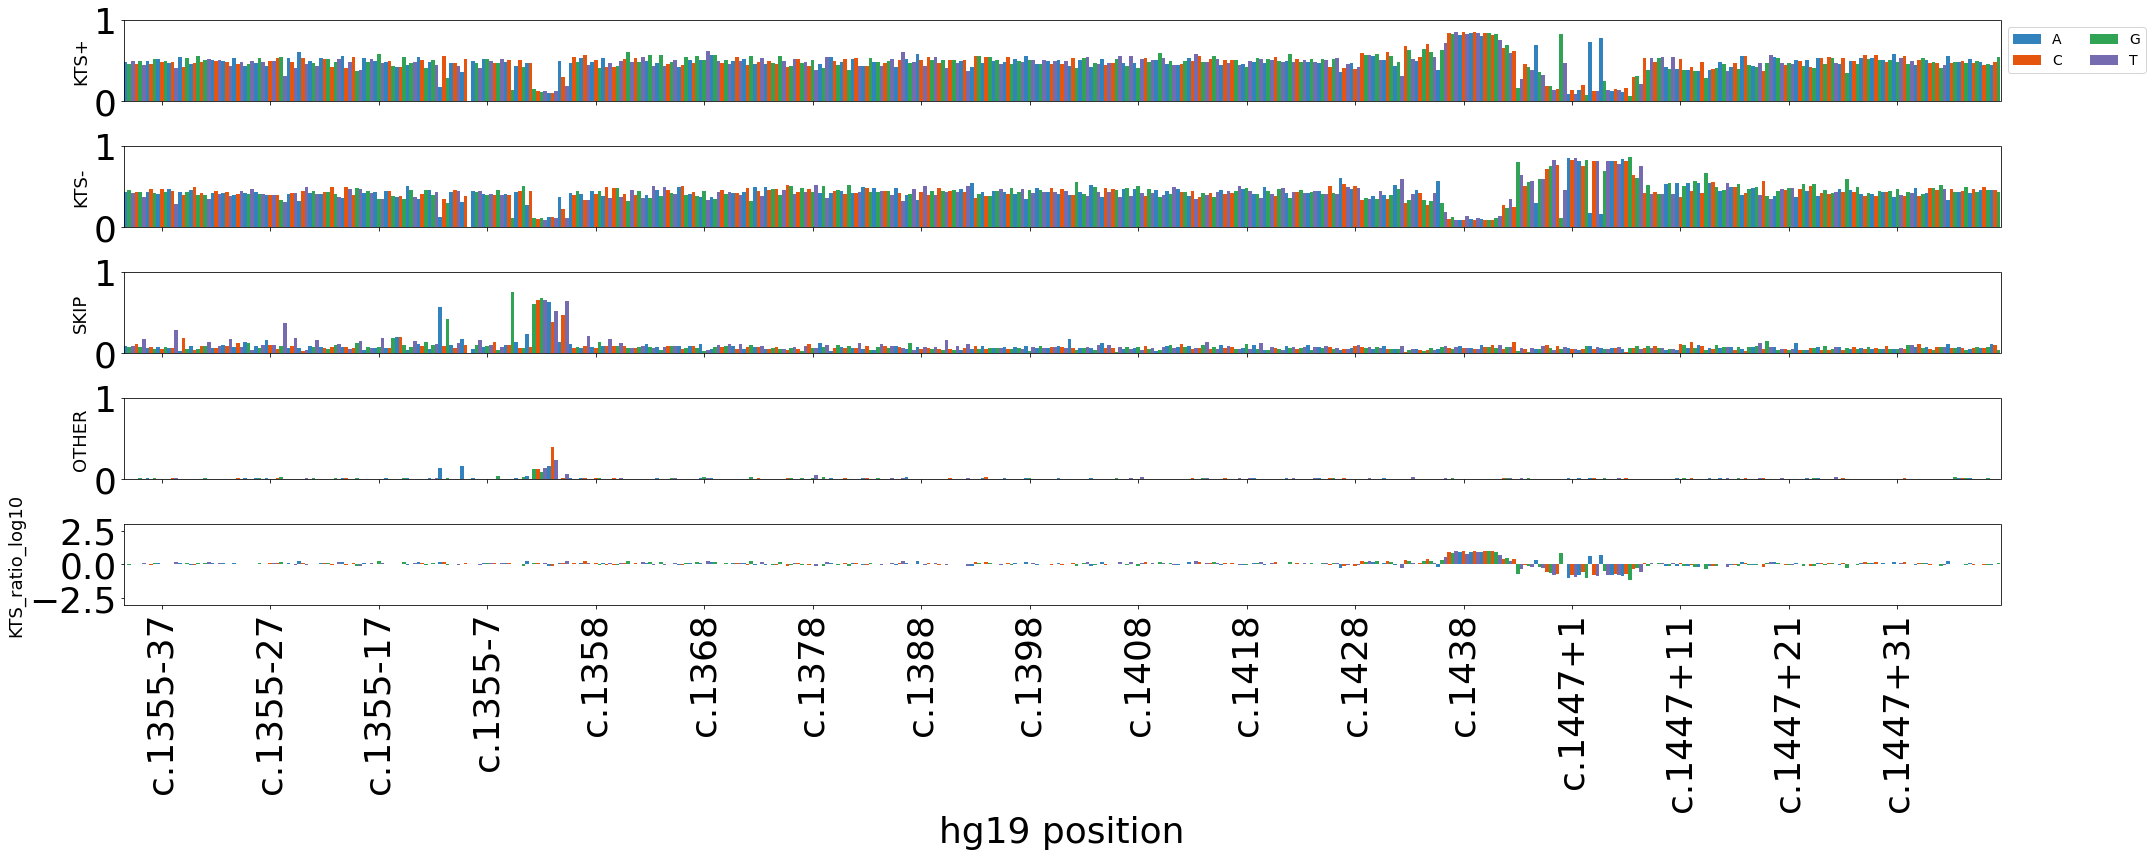

BB_RT_3_340_243_Hek1055


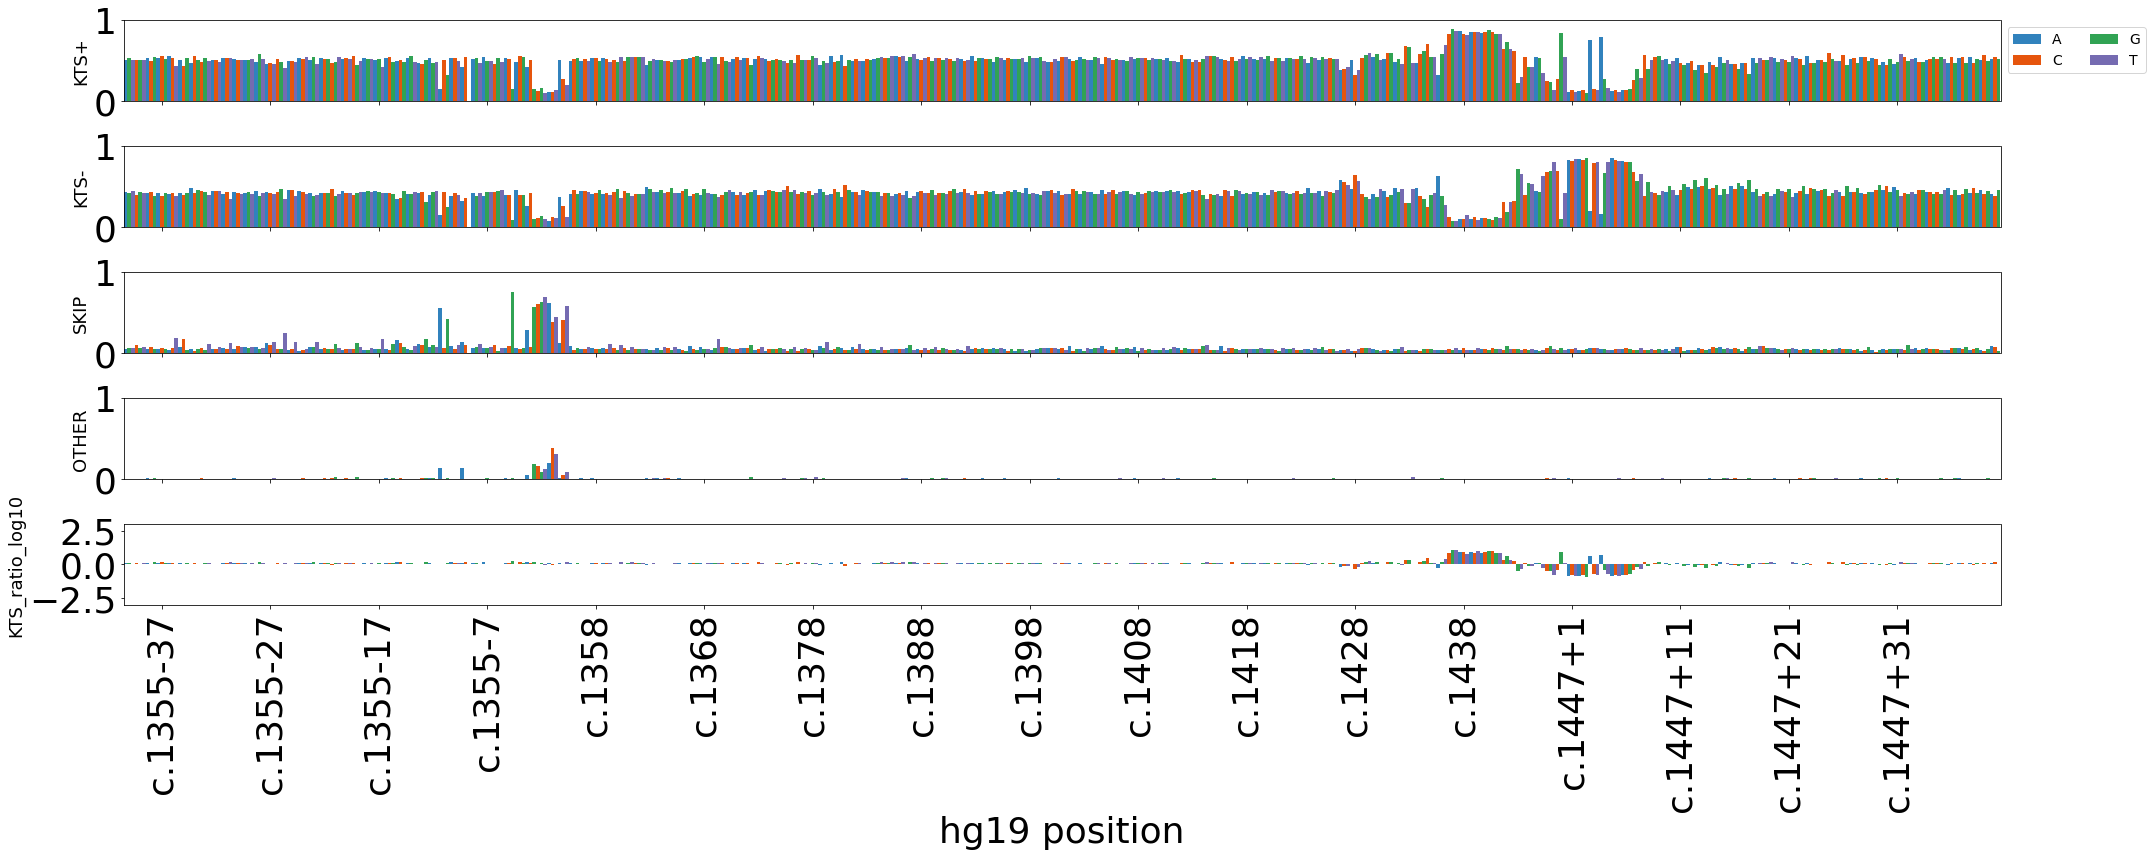

BB_RT_3_ODT_243_Cos1055


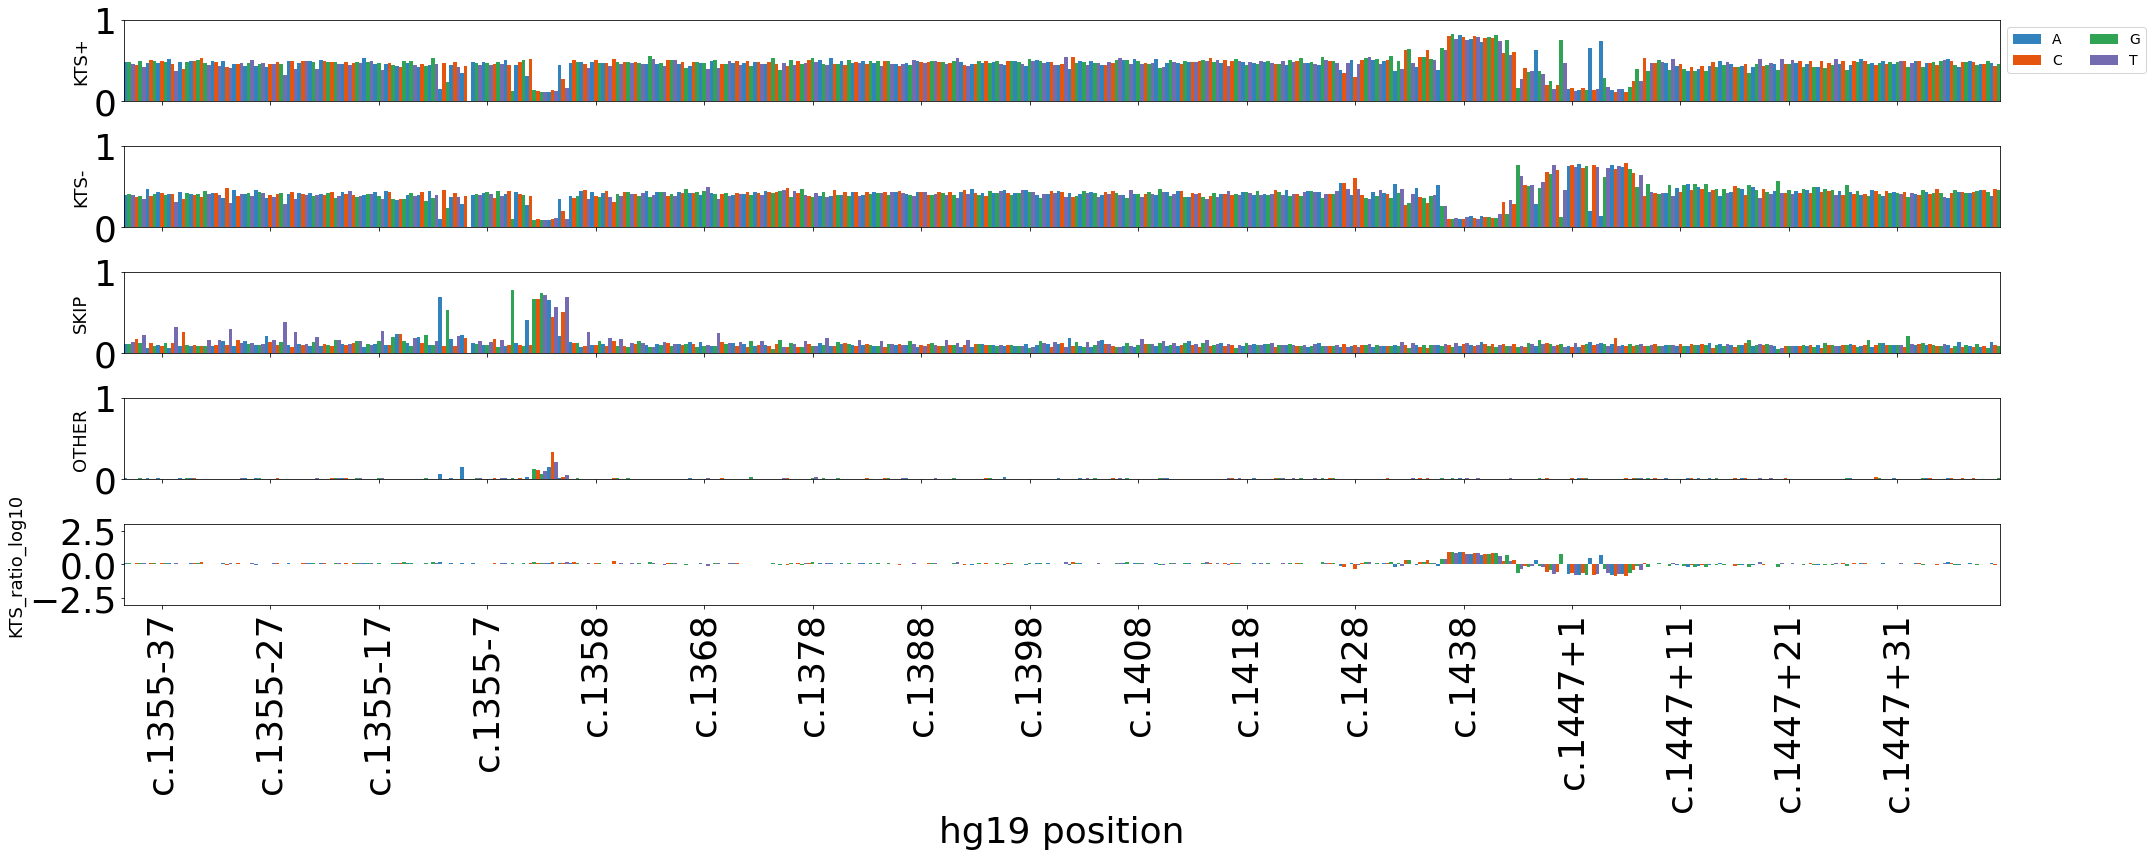

BB_RT_3_ODT_243_Hek1055


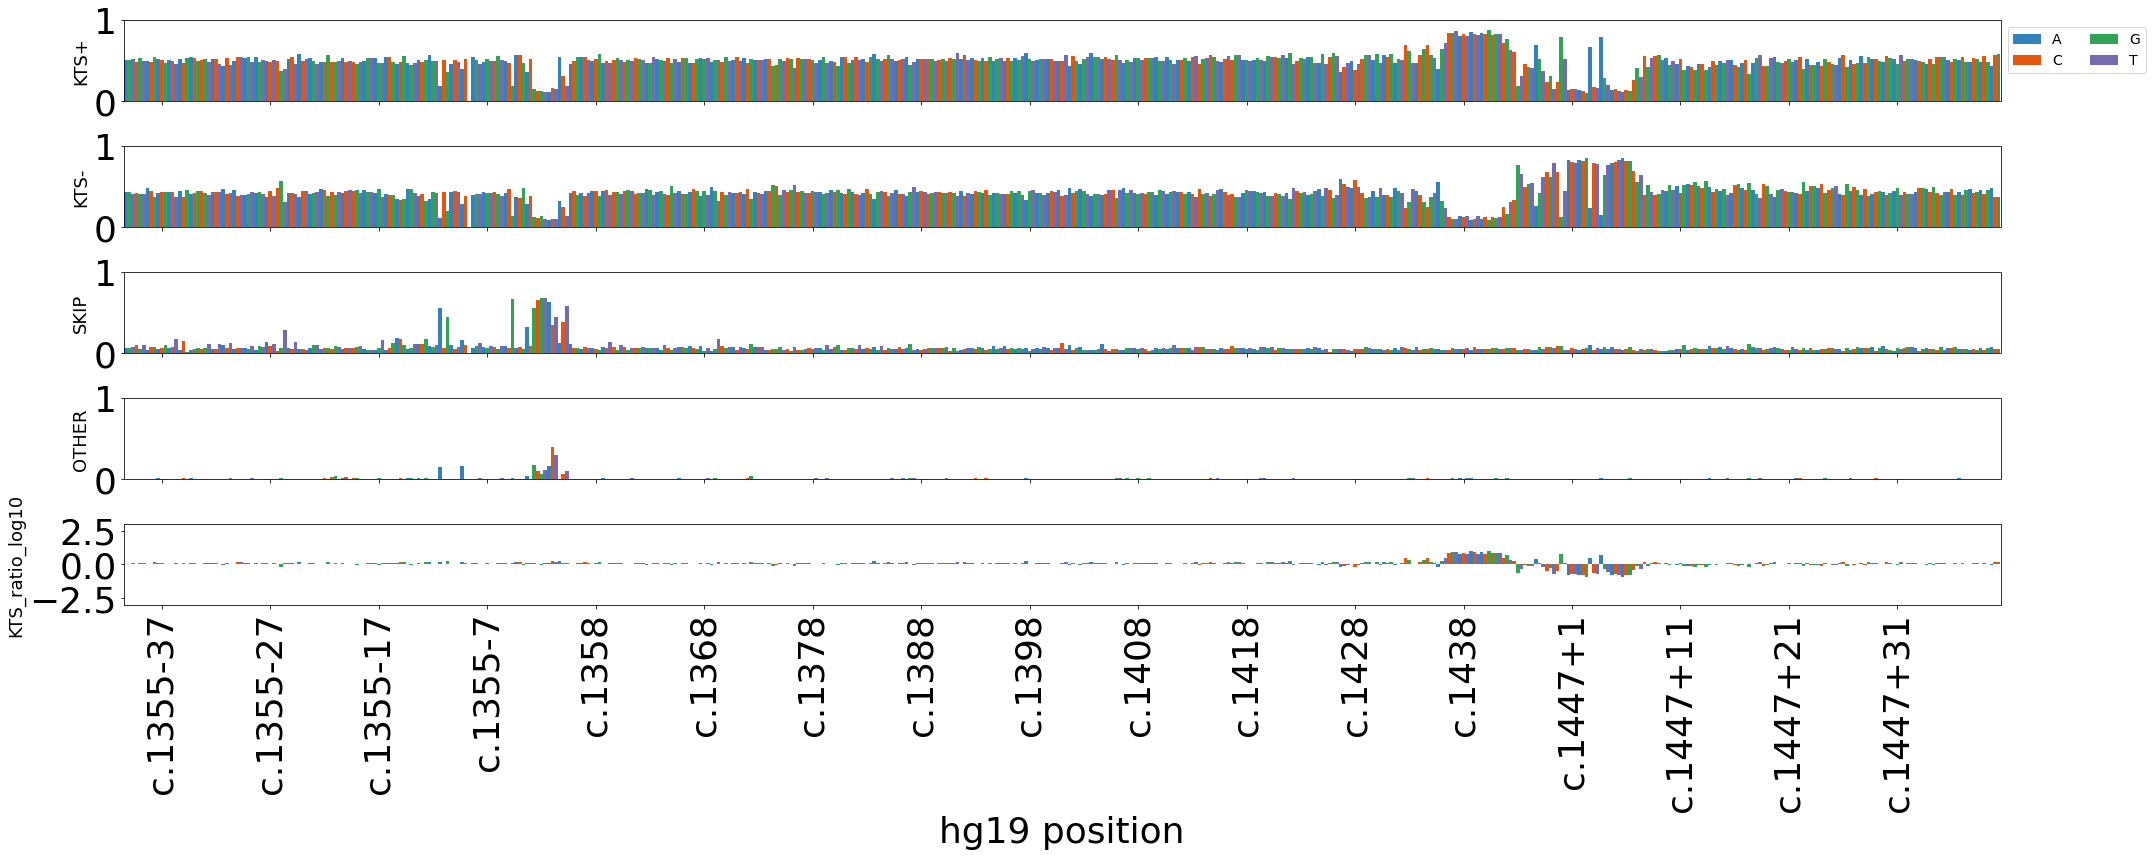

In [113]:
for samp in byvartbl_sat[ 'sample' ].unique():
    
    print( samp )

    sp.sat_subplots_wrapper( byvartbl_sat.loc[ ( byvartbl_sat[ 'sample' ] == samp ) ].rename( columns = { 'alt': 'a',
                                                                                                          'ref': 'r',
                                                                                                          'alt_c': 'alt',
                                                                                                          'ref_c': 'ref' } ),
                         [ col for col in byvartbl_sat if col.startswith( 'wmean_' ) ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -3, 3 ) ],
                          y_ax_title = [ col[ 6: ] for col in byvartbl_sat if col.startswith( 'wmean_' ) ] + [ 'KTS_ratio_log10' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [114]:
byvartbl_wide = mbcs.combine_rep_pervartbls_wide( [ byvartbl_long.loc[ byvartbl_long[ 'sample' ] == samp ][ [ col for col in byvartbl_long if col != 'sample' and col != 'rep' ] ]
                                                    for samp in byvartbl_long[ 'sample' ].unique() ],
                                                  [ samp for samp in byvartbl_long[ 'sample' ].unique() ],
                                                  indexcols=[ 'chrom','pos','ref','ref_c','alt','alt_c','varlist','hg19_pos','hgvs_pos','exon_num' ], 
                                                  group_cols_by_samp = True )

In [115]:
byvartbl_wide

chrom   pos ref ref_c alt alt_c          varlist  hg19_pos   hgvs_pos  \
0    jkp815  1227   G     C   T     A  jkp815:1227:C:A  32413650  c.1355-40   
1    jkp815  1227   G     C   C     G  jkp815:1227:C:G  32413650  c.1355-40   
2    jkp815  1227   G     C   A     T  jkp815:1227:C:T  32413650  c.1355-40   
3    jkp815  1228   T     A   G     C  jkp815:1228:A:C  32413649  c.1355-39   
4    jkp815  1228   T     A   C     G  jkp815:1228:A:G  32413649  c.1355-39   
..      ...   ...  ..   ...  ..   ...              ...       ...        ...   
513  jkp815  1398   A     T   G     C  jkp815:1398:T:C  32413479  c.1447+39   
514  jkp815  1398   A     T   C     G  jkp815:1398:T:G  32413479  c.1447+39   
515  jkp815  1399   A     T   T     A  jkp815:1399:T:A  32413478  c.1447+40   
516  jkp815  1399   A     T   G     C  jkp815:1399:T:C  32413478  c.1447+40   
517  jkp815  1399   A     T   C     G  jkp815:1399:T:G  32413478  c.1447+40   

     exon_num  ...  BB_RT_1_340_243_Hek1053_per_usable_reads  \
0           9  ...                                 98.467896   
1           9  ...                                 98.881261   
2           9  ...                                 99.131216   
3           9  ...                                 99.387851   
4           9  ...                                 98.928397   
..        ...  ...                                       ...   
513         9  ...                                 99.369748   
514         9  ...                                 98.971001   
515         9  ...                                 99.791232   
516         9  ...                                 98.604651   
517         9  ...                                 99.594595   

     BB_RT_1b_340_243_Hek1053_per_usable_reads  \
0                                    99.403019   
1                                    99.236641   
2                                    99.117874   
3                                    99.486916   
4                                    98.856624   
..                                         ...   
513                                  99.022005   
514                                  99.306358   
515                                  99.790795   
516                                  98.507463   
517                                  98.846787   

     BB_RT_1b_ODT_243_Hek1053_per_usable_reads  \
0                                    99.056726   
1                                    99.300233   
2                                    99.277619   
3                                    99.251248   
4                                    99.373957   
..                                         ...   
513                                  98.571429   
514                                  98.300971   
515                                  98.873239   
516                                  98.469388   
517                                  98.932384   

     BB_RT_1_ODT_243_Hek1053_per_usable_reads  \
0                                   99.192118   
1                                   99.210867   
2                                   99.115479   
3                                   99.246420   
4                                   99.239905   
..                                        ...   
513                                 98.837209   
514                                 98.854962   
515                                 99.801193   
516                                 99.389002   
517                                 98.533724   

     BB_RT_2_340_243_Hek1054_per_usable_reads  \
0                                   98.891152   
1                                   99.260328   
2                                   98.825592   
3                                   99.403682   
4                                   99.025464   
..                                        ...   
513                                 99.318182   
514                                 99.433962   
515                                100.000000   
516    

In [116]:
byvartbl_wide = mbcs.create_variables_across_samples( byvartbl_wide,
                                                 [ samp for samp in byvartbl_long[ 'sample' ].unique() ],
                                                 mean_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ],
                                                 median_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ],
                                                 sum_cols = [ 'sum_reads','sum_reads_passfilt', ],
                                                 max_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ] )

In [117]:
byvartbl_wide = mbcs.compute_bc_weighted_psi( byvartbl_wide,
                                         [ samp for samp in byvartbl_long[ 'sample' ].unique() ],
                                         [ 'KTS+','KTS-','SKIP','OTHER' ],
                                         'n_bc_passfilt',
                              )

In [118]:
byvartbl_wide[ 'KTS_+_ratio' ] = byvartbl_wide[ 'wmean_KTS+' ] / byvartbl_wide[ 'wmean_KTS-' ]

In [119]:
byvartbl_wide[ 'KTS_+_ratio' ].min()

0.14295248998906

In [120]:
byvartbl_wide[ 'KTS_+_ratio' ].max()

7.821890747379143

In [121]:
byvartbl_wide[ 'KTS_+_ratio_log10' ] = np.log10( byvartbl_wide[ 'KTS_+_ratio' ] )

In [122]:
byvartbl_wide[ 'KTS_+_ratio_log10' ].min()

-0.844808275569436

In [123]:
byvartbl_wide[ 'KTS_+_ratio_log10' ].max()

0.8933117456302087

In [124]:
byvartbl_wide_sat = pp.saturate_variants( byvartbl_wide,
                                         chr11_seq,
                                         'hg19_pos',
                                          'exon_num',
                                          rev_strand = True )[ 9 ]

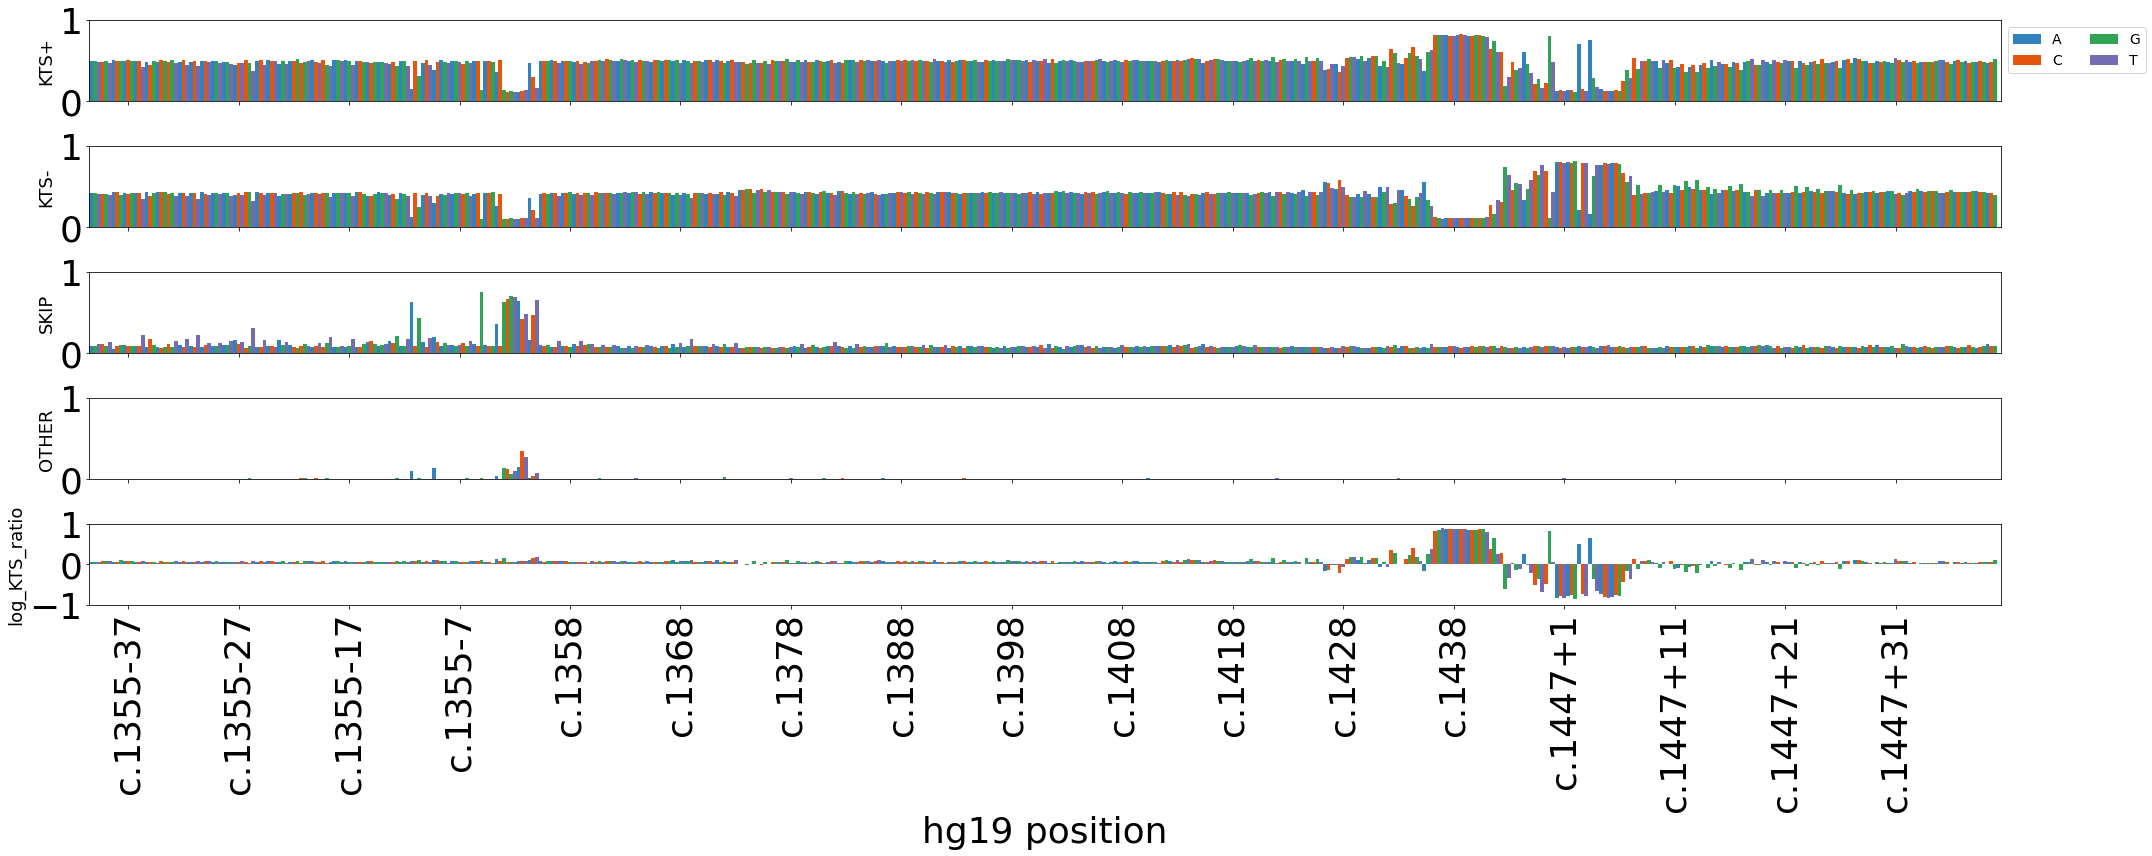

In [125]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                         [ col for col in byvartbl_wide_sat if col.startswith( 'wmean_' ) ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 12 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -1, 1 ) ],
                          y_ax_title = [ col[ 5: ] for col in byvartbl_wide_sat if col.startswith( 'mean_' ) ] + [ 'log_KTS_ratio' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

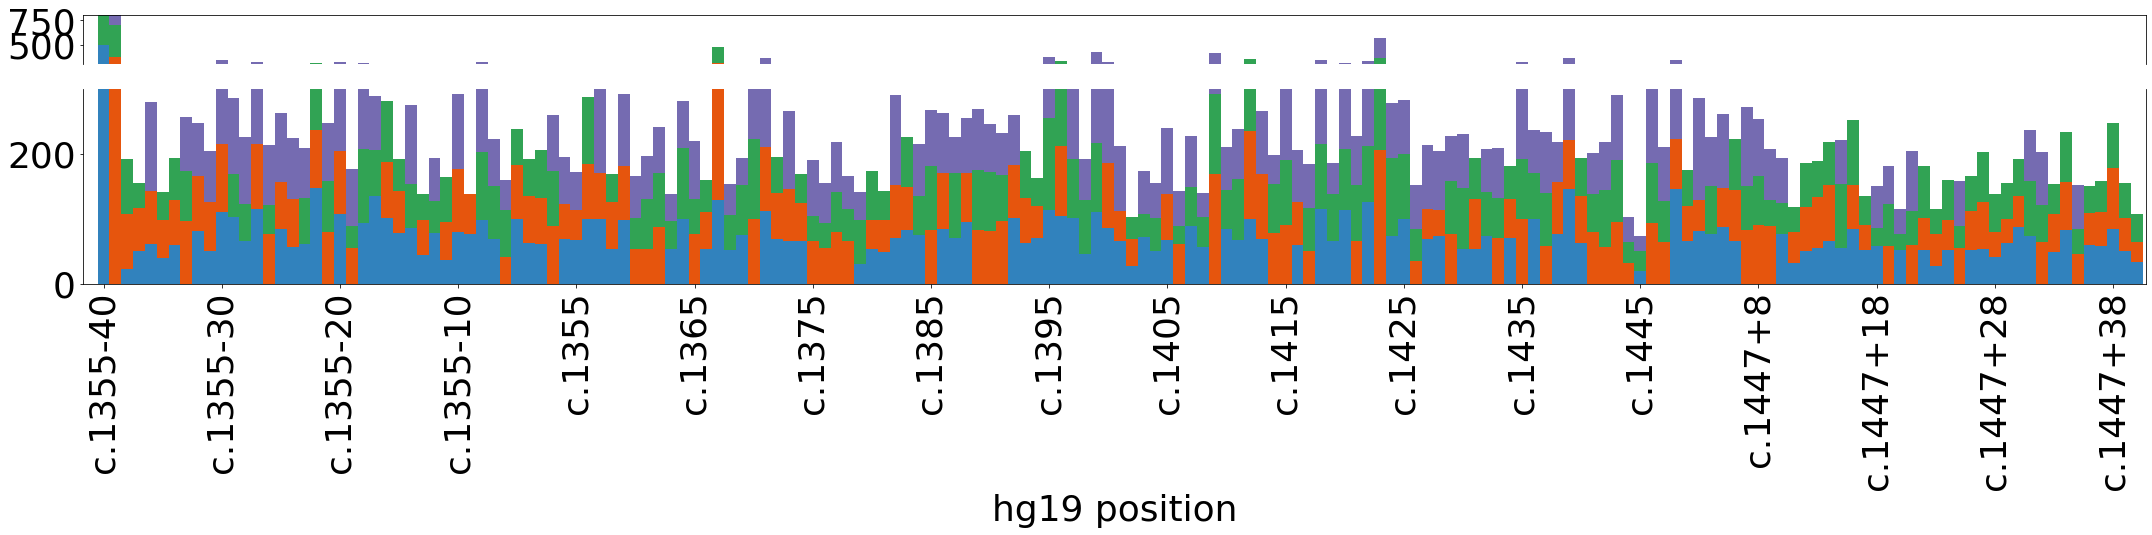

In [205]:
sp.split_ax_bcs(  byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                  [ 'n_bc_passfilt_mean' ],
                  'hgvs_pos',
                    [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                    [ ( 300.5, 800 ), ( 0, 300 ) ],
                    fig_size = ( 30, 7.5 ),
                    legend = False,
                    hratios = [ 1, 4 ],
                    x_ax_title = 'hg19 position',
                    #tight = False,
                    #savefile = plot_out + 'bcs_filt_by_pos_split.pdf'
                           )

In [127]:
#this was computed in jkp1053_byiso.2022-0428
splai = pd.read_table( '/nfs/kitzman2/smithcat/proj/spliceAI/splai_output/wt1_ex9.txt',
                       dtype = { 'chrom': object } )

In [128]:
byvartbl_wide[ 'chrom' ] = '11'

In [129]:
byvartbl_wide = sm.merge_splai( byvartbl_wide,
                                splai )

In [130]:
#this was computed in jkp1053_byiso.2022-0428
splai_wt = pd.read_table( '/nfs/kitzman2/smithcat/proj/spliceAI/splai_output/wt1_ex9_wt_ss_probs.txt',
                       dtype = { 'chrom': object } ).rename( columns = { 'wt_acc_pr': 'splai_wt_acc', 'wt_don_pr': 'splai_wt_don', 'pos': 'hg19_pos' } )

In [131]:
byvartbl_wide = byvartbl_wide.set_index( [ 'hg19_pos', 'ref', 'chrom' ] ).merge( splai_wt.set_index( [ 'hg19_pos', 'ref', 'chrom' ] ),
                                                                        how = 'left', 
                                                                        left_index = True,
                                                                        right_index = True ).reset_index()

In [132]:
#this was computed in jkp1053_byiso.2022-0428
splai_ss_pr = pd.read_table( '/nfs/kitzman2/smithcat/proj/spliceAI/splai_output/wt1_ex9_ss_probs.txt',
                             dtype = { 'chrom': object } )

In [133]:
byvartbl_wide = sm.merge_splai( byvartbl_wide,
                                splai_ss_pr )

In [134]:
maxent_wt = pd.read_table( '/nfs/kitzman2/smithcat/proj/spliceAI/maxent_scores/wt1_ex9_wt_ss_probs.txt' ).rename( columns = { 'wt_acc_pr': 'maxent_wt_acc', 'wt_don_pr': 'maxent_wt_don' } )

In [135]:
byvartbl_wide = byvartbl_wide.set_index( [ 'pos', 'ref' ] ).merge( maxent_wt.set_index( [ 'pos', 'ref' ] ),
                                                                   how = 'left',
                                                                   left_index = True,
                                                                   right_index = True ).reset_index()

In [136]:
donor_d = sm.maxent_score_donors( refseq,
                                byvartbl_wide,
                                'pos',
                                'ref_c',
                                'alt_c',
                                [ 1350, 1359 ],
                               )

In [137]:
byvartbl_wide[ 'maxent_KTS+' ] = donor_d[ 1359 ]

In [138]:
byvartbl_wide[ 'maxent_KTS-' ] = donor_d[ 1350 ]

In [139]:
accept_d = sm.maxent_score_acceptors( refseq,
                                    byvartbl_wide,
                                    'pos',
                                    'ref_c',
                                    'alt_c',
                                    [ 1267, 1284 ],
                                   )

In [140]:
byvartbl_wide[ 'maxent_acc' ] = accept_d[ 1267 ]

In [141]:
byvartbl_wide[ 'maxent_alt_acc' ] = accept_d[ 1284 ]

In [142]:
byvartbl_wide[ 'splai_KTS+_ratio' ] = byvartbl_wide[ 'ss_don_prob_32413518' ] / byvartbl_wide[ 'ss_don_prob_32413527' ]

In [143]:
byvartbl_wide[ 'splai_KTS+_ratio' ].min()

2.1226874089724788e-05

In [144]:
byvartbl_wide[ 'splai_KTS+_ratio' ].max()

170232.52949963024

In [145]:
byvartbl_wide[ 'splai_KTS+_ratio_log10' ] = np.log10( byvartbl_wide[ 'splai_KTS+_ratio' ] )

In [146]:
byvartbl_wide[ 'splai_KTS+_ratio_log10' ].min()

-4.673113956165485

In [147]:
byvartbl_wide[ 'splai_KTS+_ratio_log10' ].max()

5.2310425524131485

In [148]:
byvartbl_wide_sat = pp.saturate_variants( byvartbl_wide,
                                         chr11_seq,
                                         'hg19_pos',
                                          'exon_num',
                                          rev_strand = True )[ 9 ]

In [149]:
plot_cols = [ col for col in byvartbl_wide if col.startswith( 'wmean_' ) or col.startswith( 'maxent_' )  ] + [ 'DS_maxm', 'ss_don_prob_32413518', 'ss_don_prob_32413527', 'ss_acc_prob_32413610', 'ss_acc_prob_32413593' ]

In [150]:
plot_cols = [ 'wmean_KTS+', 'wmean_KTS-', 'wmean_SKIP', 'wmean_OTHER', 'KTS_+_ratio_log10', 'maxent_KTS+', 'maxent_KTS-',
              'maxent_acc', 'maxent_alt_acc',  'DS_maxm', 'ss_don_prob_32413518', 'ss_don_prob_32413527', 'ss_acc_prob_32413610',
              'ss_acc_prob_32413593', 'splai_KTS+_ratio_log10' ]

In [151]:
plot_cols

['wmean_KTS+',
 'wmean_KTS-',
 'wmean_SKIP',
 'wmean_OTHER',
 'KTS_+_ratio_log10',
 'maxent_KTS+',
 'maxent_KTS-',
 'maxent_acc',
 'maxent_alt_acc',
 'DS_maxm',
 'ss_don_prob_32413518',
 'ss_don_prob_32413527',
 'ss_acc_prob_32413610',
 'ss_acc_prob_32413593',
 'splai_KTS+_ratio_log10']

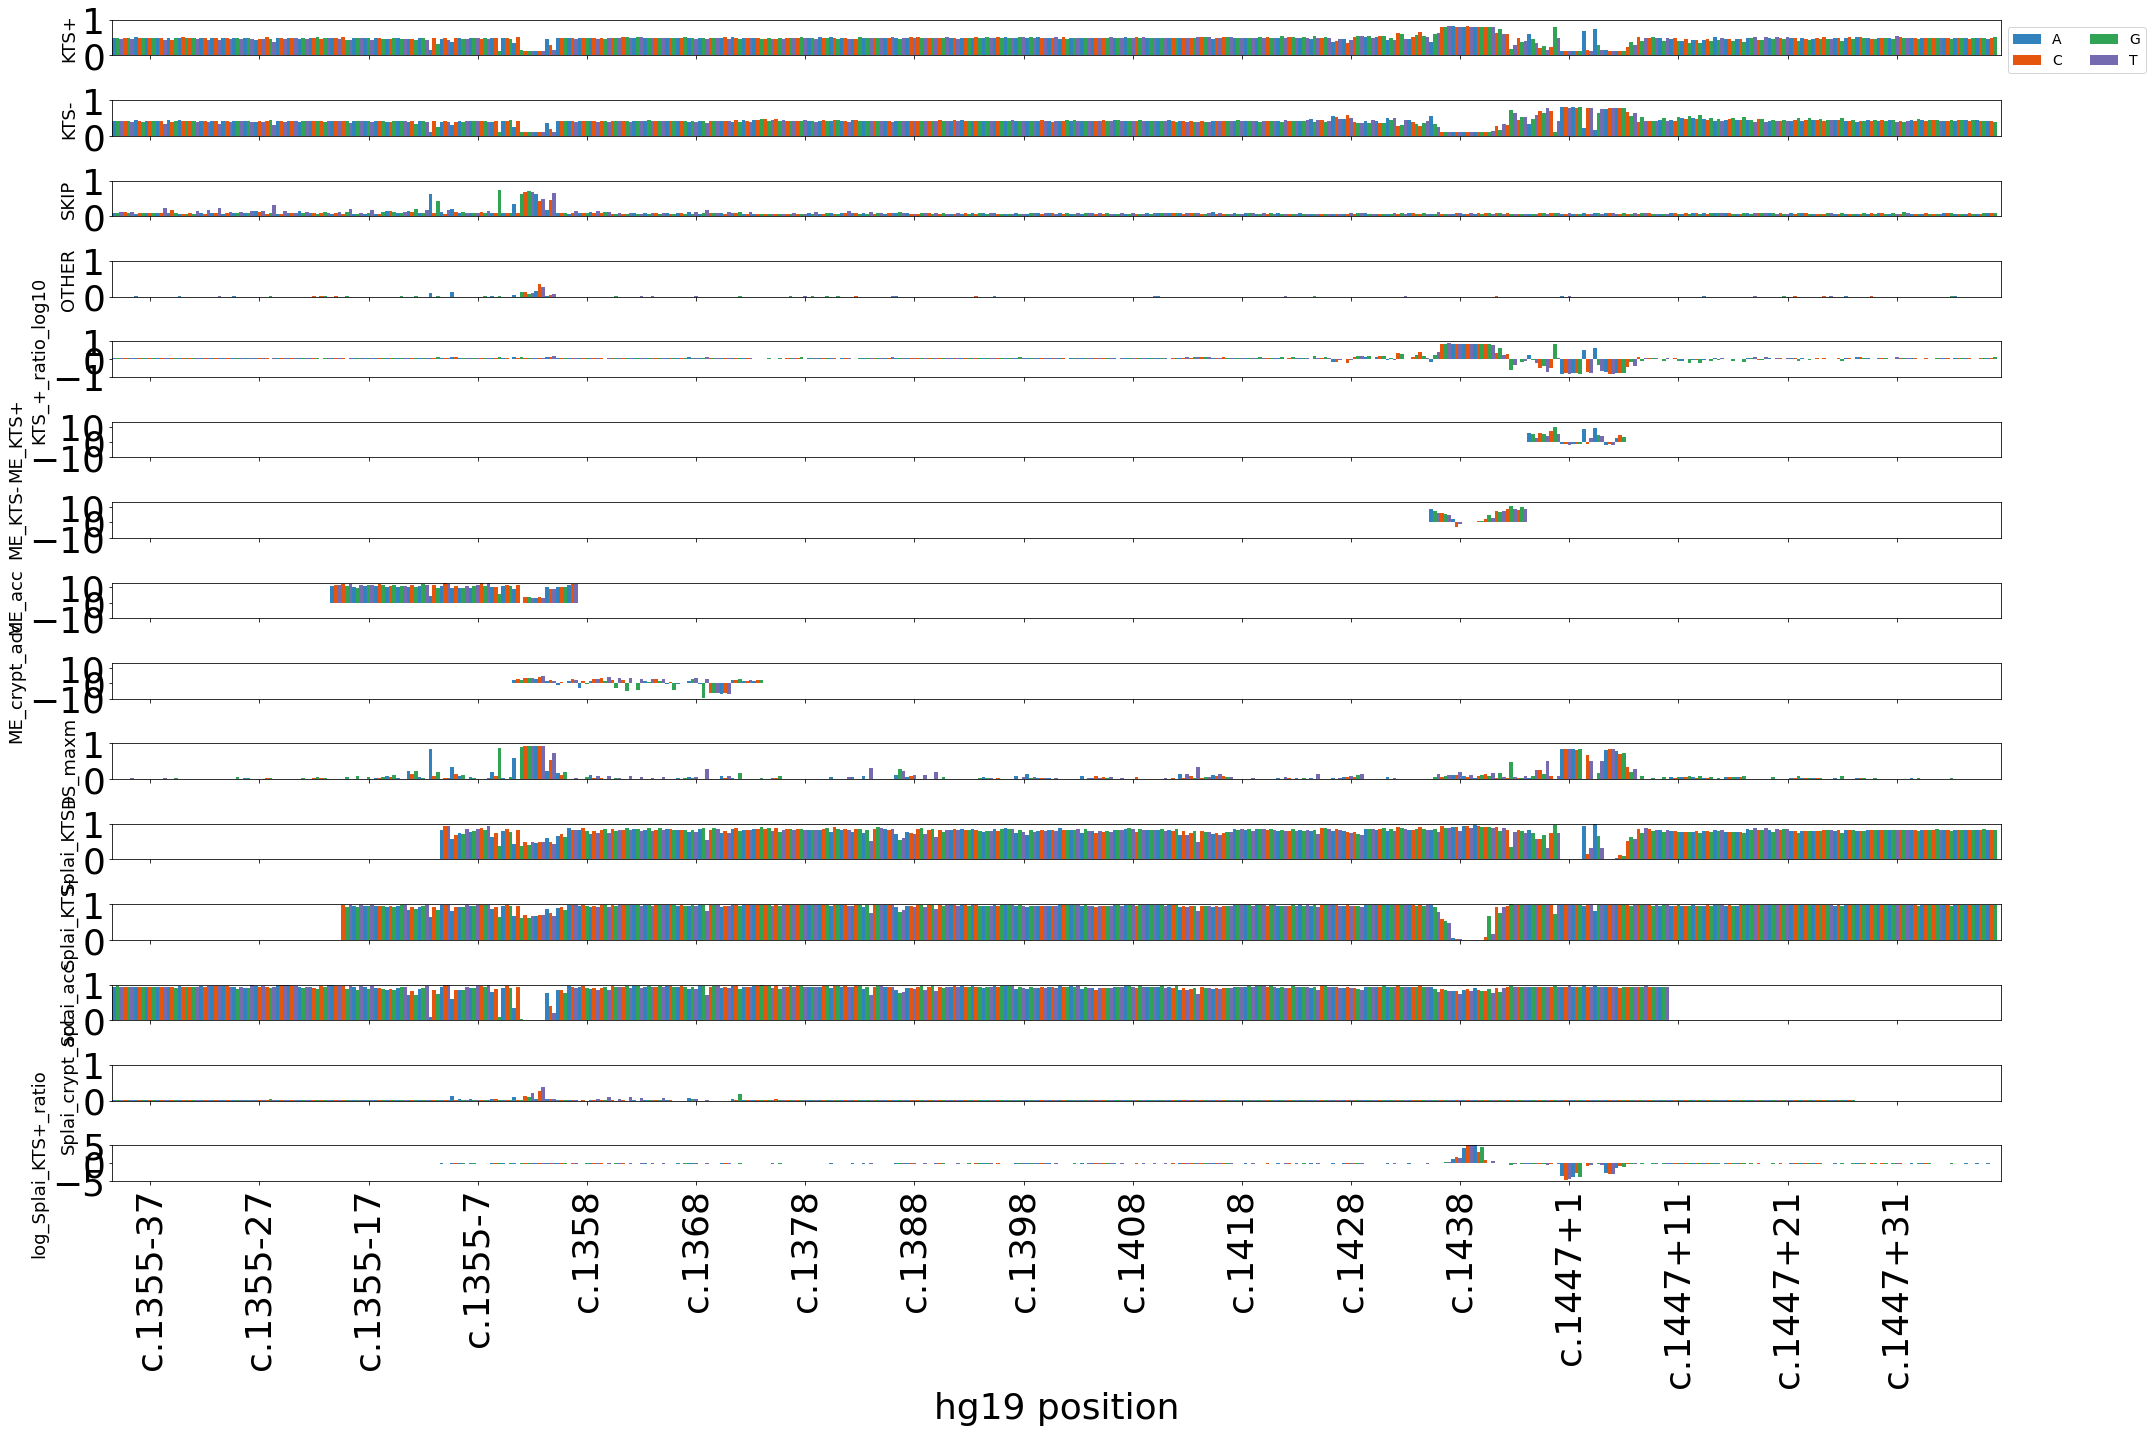

In [152]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          plot_cols,
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 20 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -1, 1 ), ( -10, 13 ), ( -10, 13 ), ( -10, 13 ), ( -10, 13 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ 'KTS+','KTS-','SKIP','OTHER', 'KTS_+_ratio_log10', 'ME_KTS+','ME_KTS-','ME_acc','ME_crypt_acc','DS_maxm','Splai_KTS+','Splai_KTS-','Splai_acc', 'Splai_crypt_acc', 'log_Splai_KTS+_ratio' ],
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [153]:
plot_KTS_cols = [ 'wmean_KTS+', 'wmean_KTS-', 'KTS_+_ratio_log10', 'maxent_KTS+', 'maxent_KTS-', 
                  'DS_maxm', 'ss_don_prob_32413518', 'ss_don_prob_32413527', 'splai_KTS+_ratio_log10' ]

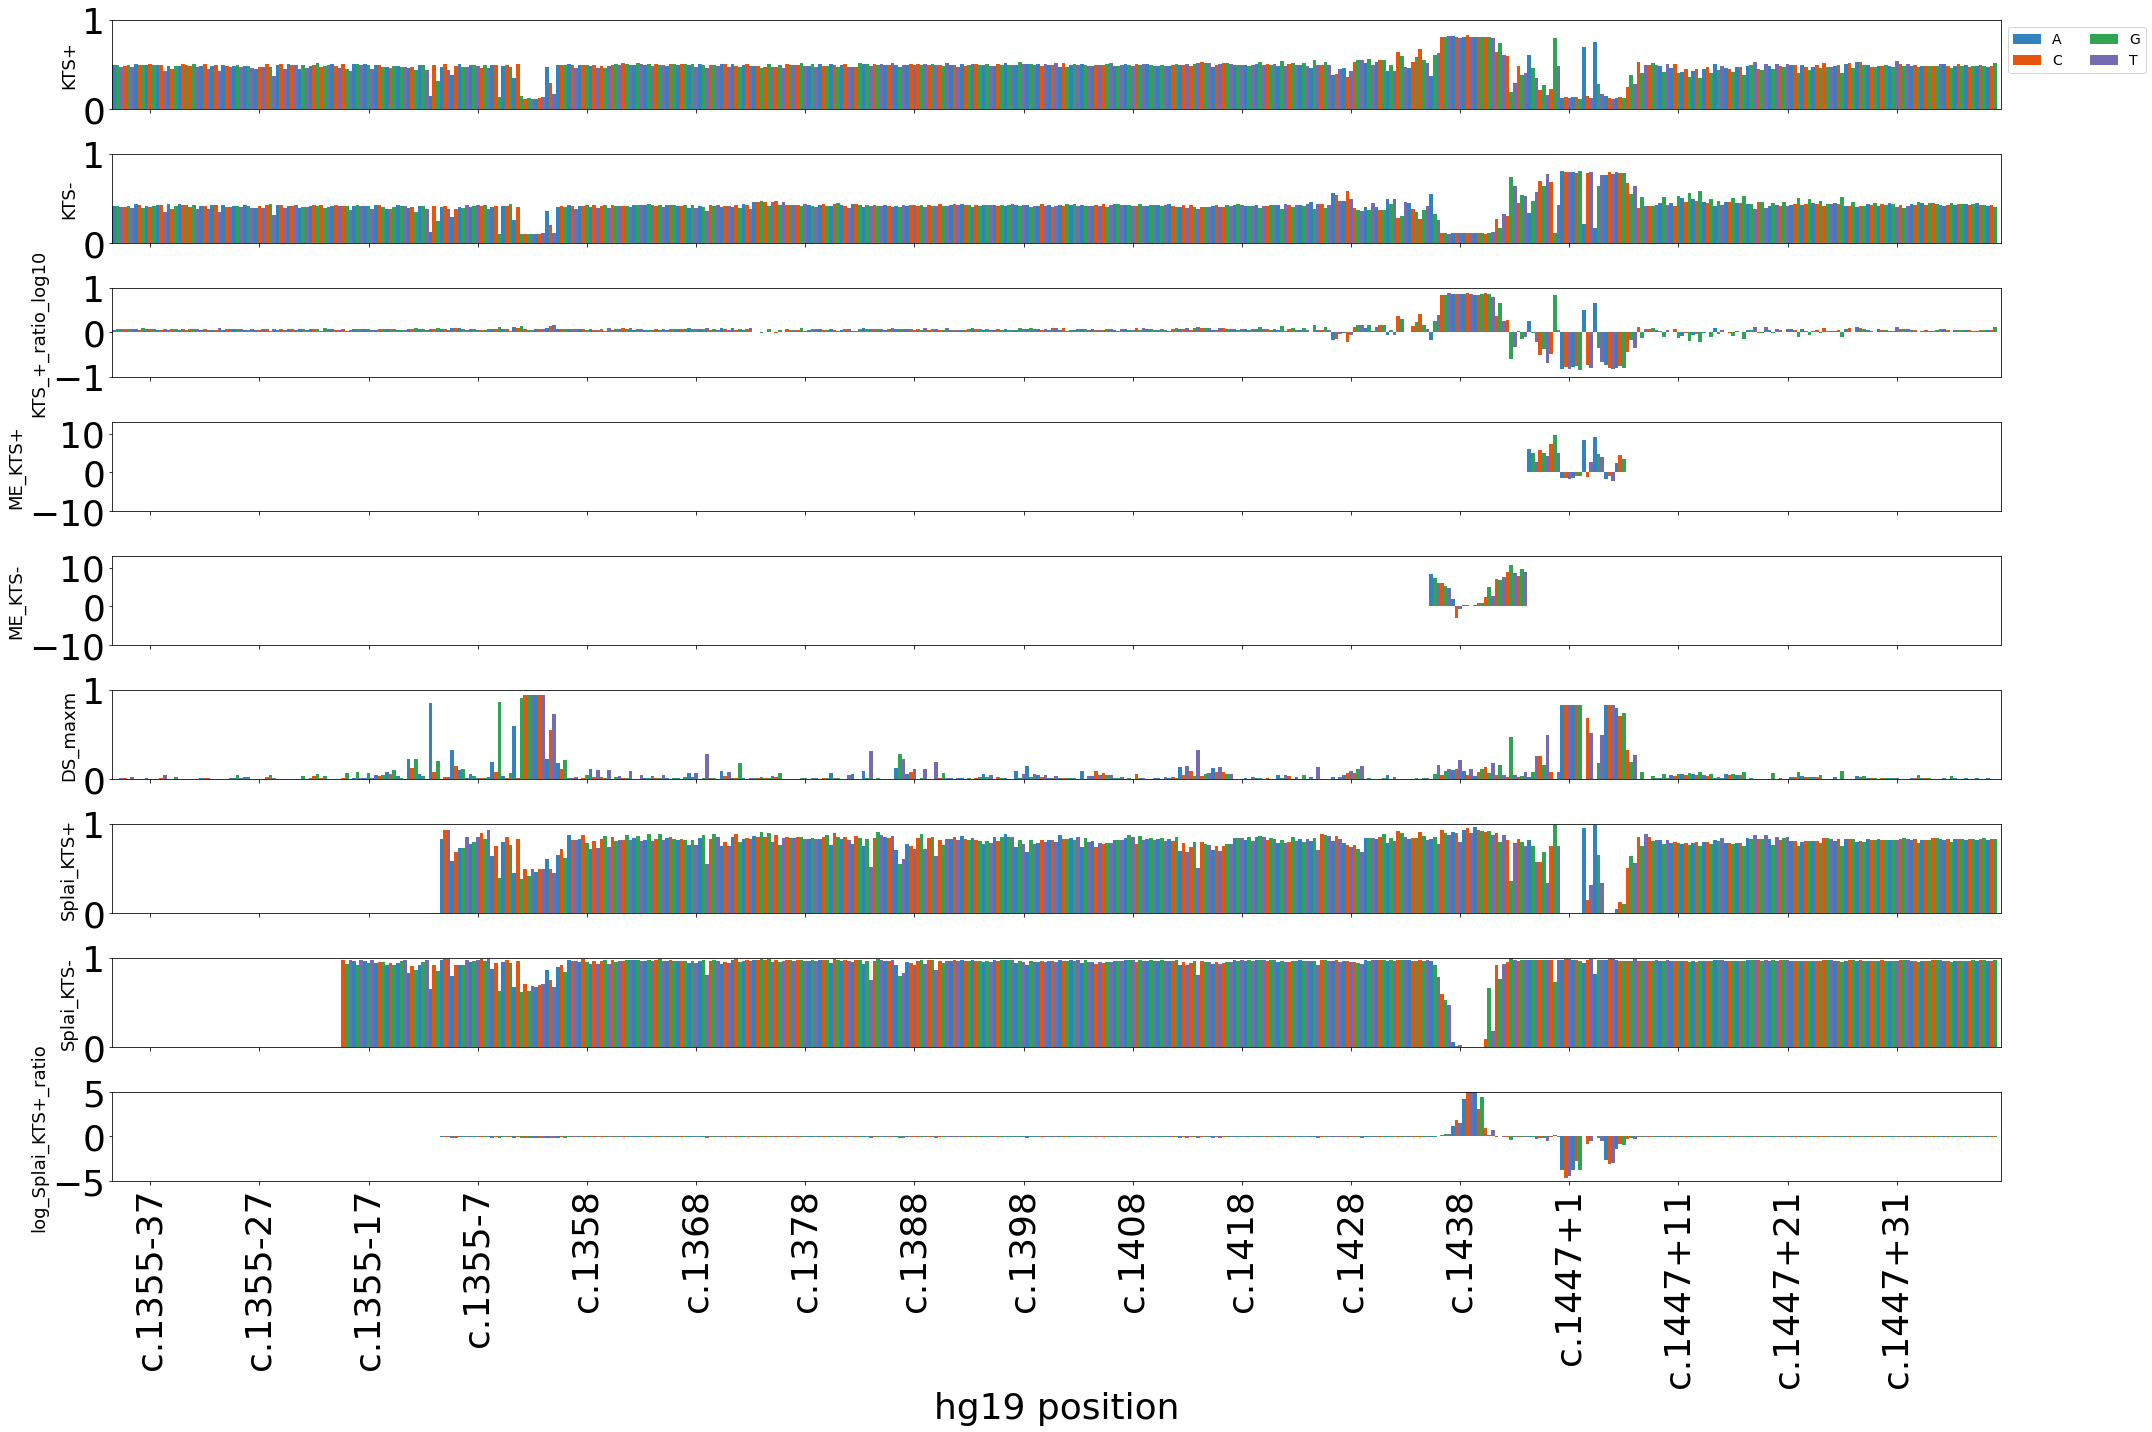

In [154]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          plot_KTS_cols,
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 20 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( -1, 1 ), ( -10, 13 ), ( -10, 13 ),  ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ 'KTS+','KTS-','KTS_+_ratio_log10', 'ME_KTS+','ME_KTS-','DS_maxm','Splai_KTS+','Splai_KTS-', 'log_Splai_KTS+_ratio' ],
                          x_ax_title = 'hg19 position',
                          tick_spacing = 10,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

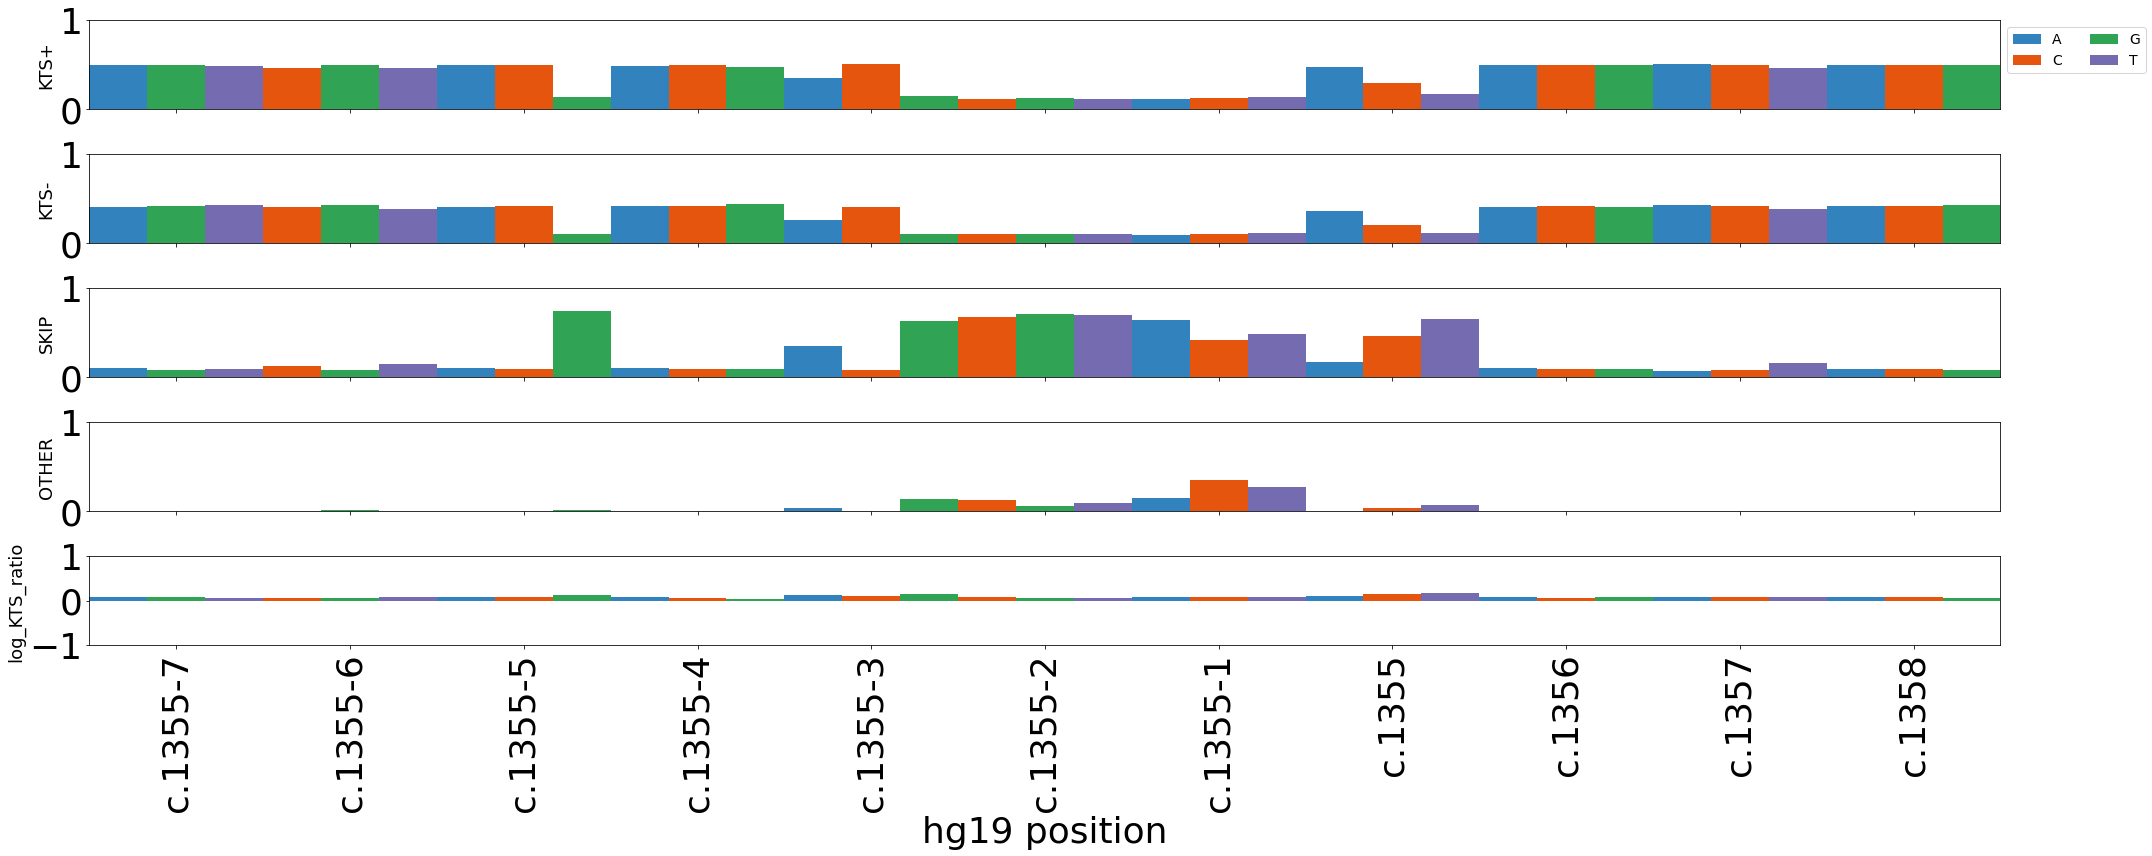

In [155]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                         [ col for col in byvartbl_wide_sat if col.startswith( 'wmean_' ) ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1260, 1270 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -1, 1 ) ],
                          y_ax_title = [ col[ 5: ] for col in byvartbl_wide_sat if col.startswith( 'mean_' ) ] + [ 'log_KTS_ratio' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [156]:
plot_acc_cols = [ 'wmean_KTS+', 'wmean_KTS-', 'wmean_SKIP', 'wmean_OTHER', 'KTS_+_ratio_log10', 
              'maxent_acc', 'maxent_alt_acc',  'DS_maxm','ss_acc_prob_32413610',
              'ss_acc_prob_32413593', 'splai_KTS+_ratio_log10' ]

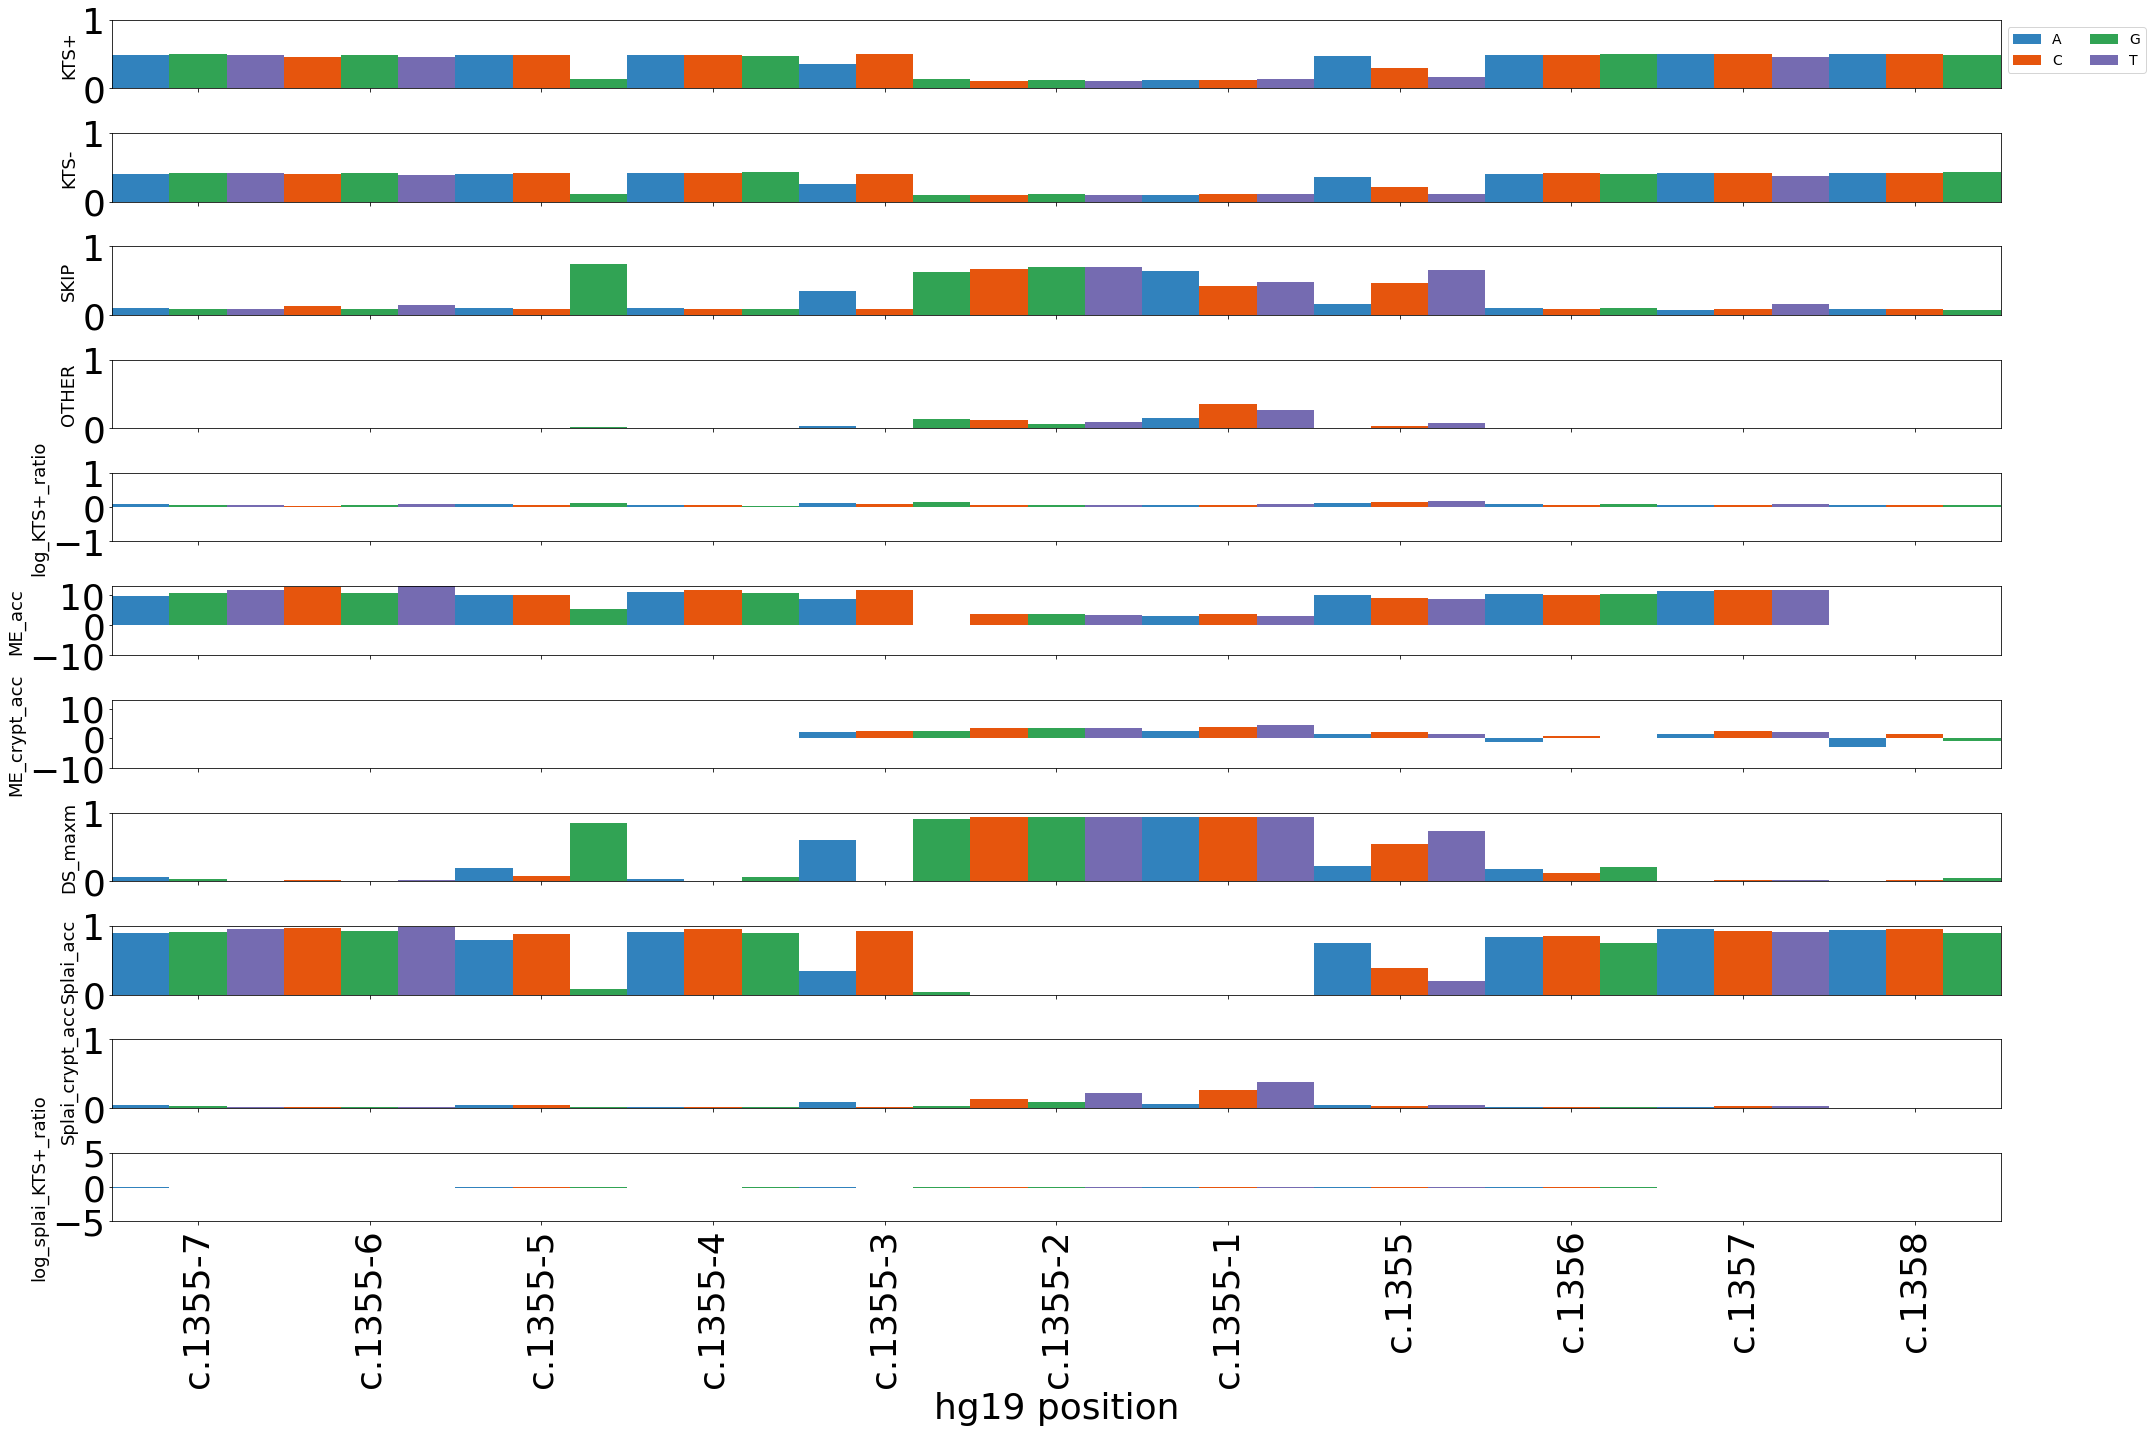

In [157]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          plot_acc_cols,
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 20 ),
                          zoom = ( 1260, 1270 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -1, 1 ), ( -10, 13 ), ( -10, 13 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ),( -5, 5 ) ],
                          y_ax_title = [ 'KTS+','KTS-','SKIP','OTHER','log_KTS+_ratio','ME_acc','ME_crypt_acc','DS_maxm','Splai_acc', 'Splai_crypt_acc', 'log_splai_KTS+_ratio' ],
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

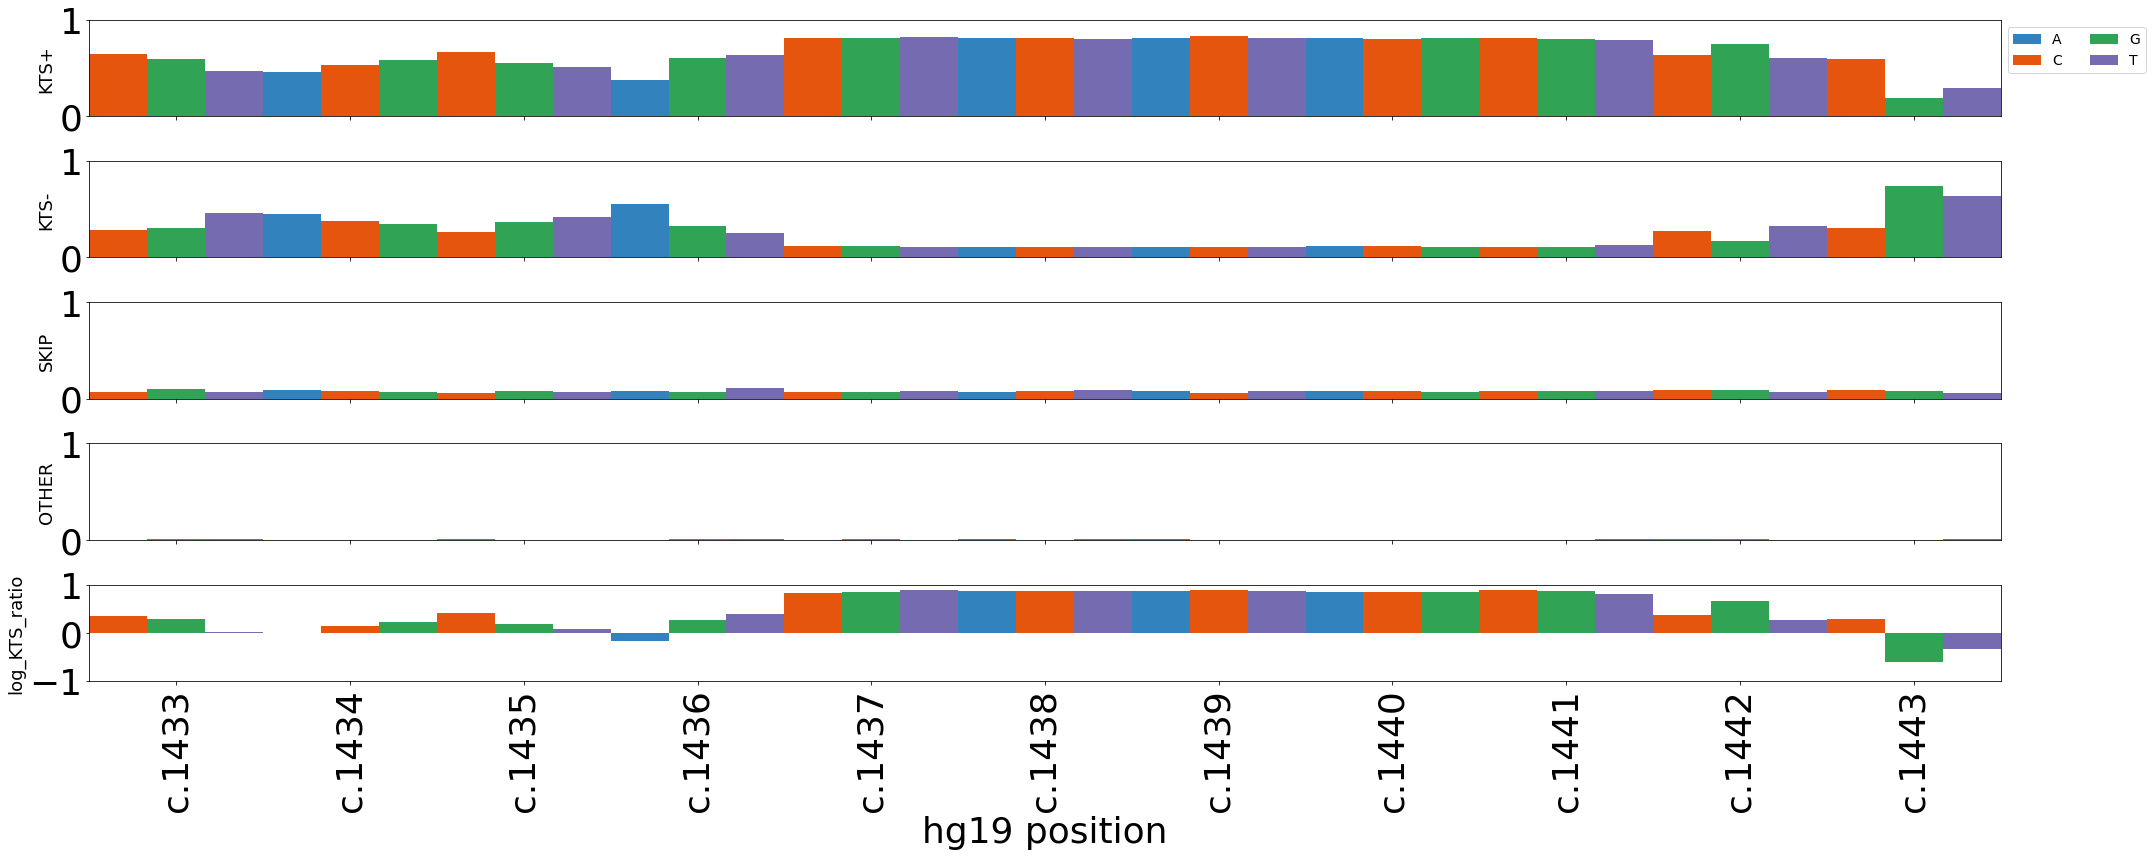

In [158]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                         [ col for col in byvartbl_wide_sat if col.startswith( 'wmean_' ) ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1345, 1355 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -1, 1 ) ],
                          y_ax_title = [ col[ 5: ] for col in byvartbl_wide_sat if col.startswith( 'mean_' ) ] + [ 'log_KTS_ratio' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

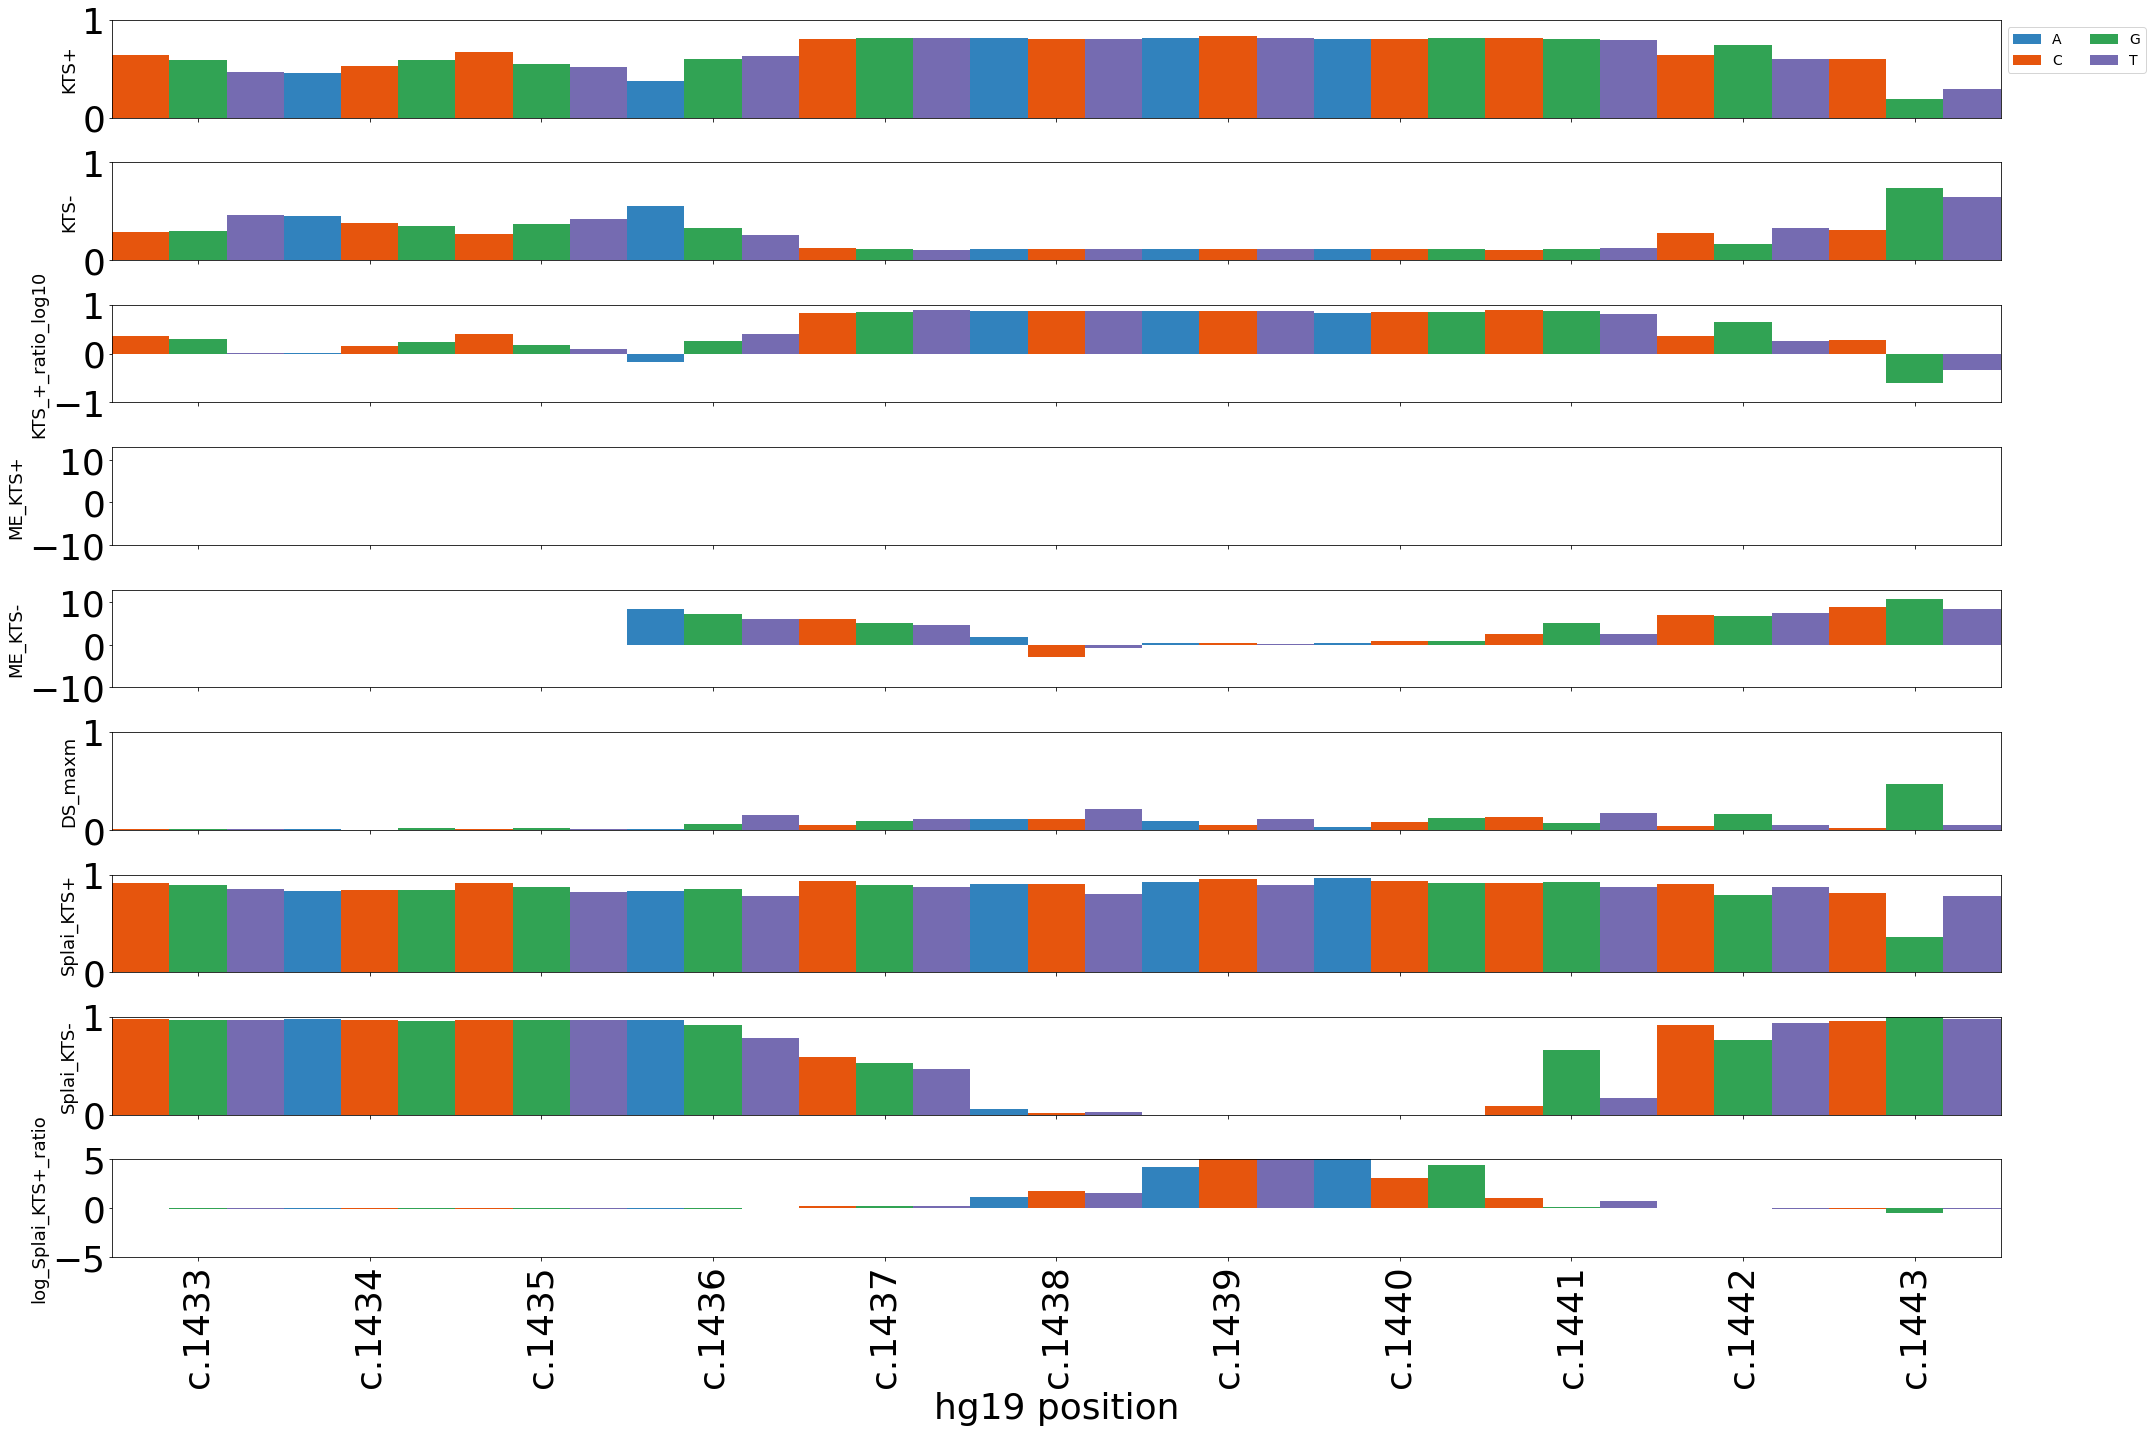

In [159]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          plot_KTS_cols,
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 20 ),
                          zoom = ( 1345, 1355 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( -1, 1 ), ( -10, 13 ), ( -10, 13 ),  ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ 'KTS+','KTS-','KTS_+_ratio_log10', 'ME_KTS+','ME_KTS-','DS_maxm','Splai_KTS+','Splai_KTS-', 'log_Splai_KTS+_ratio' ],
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

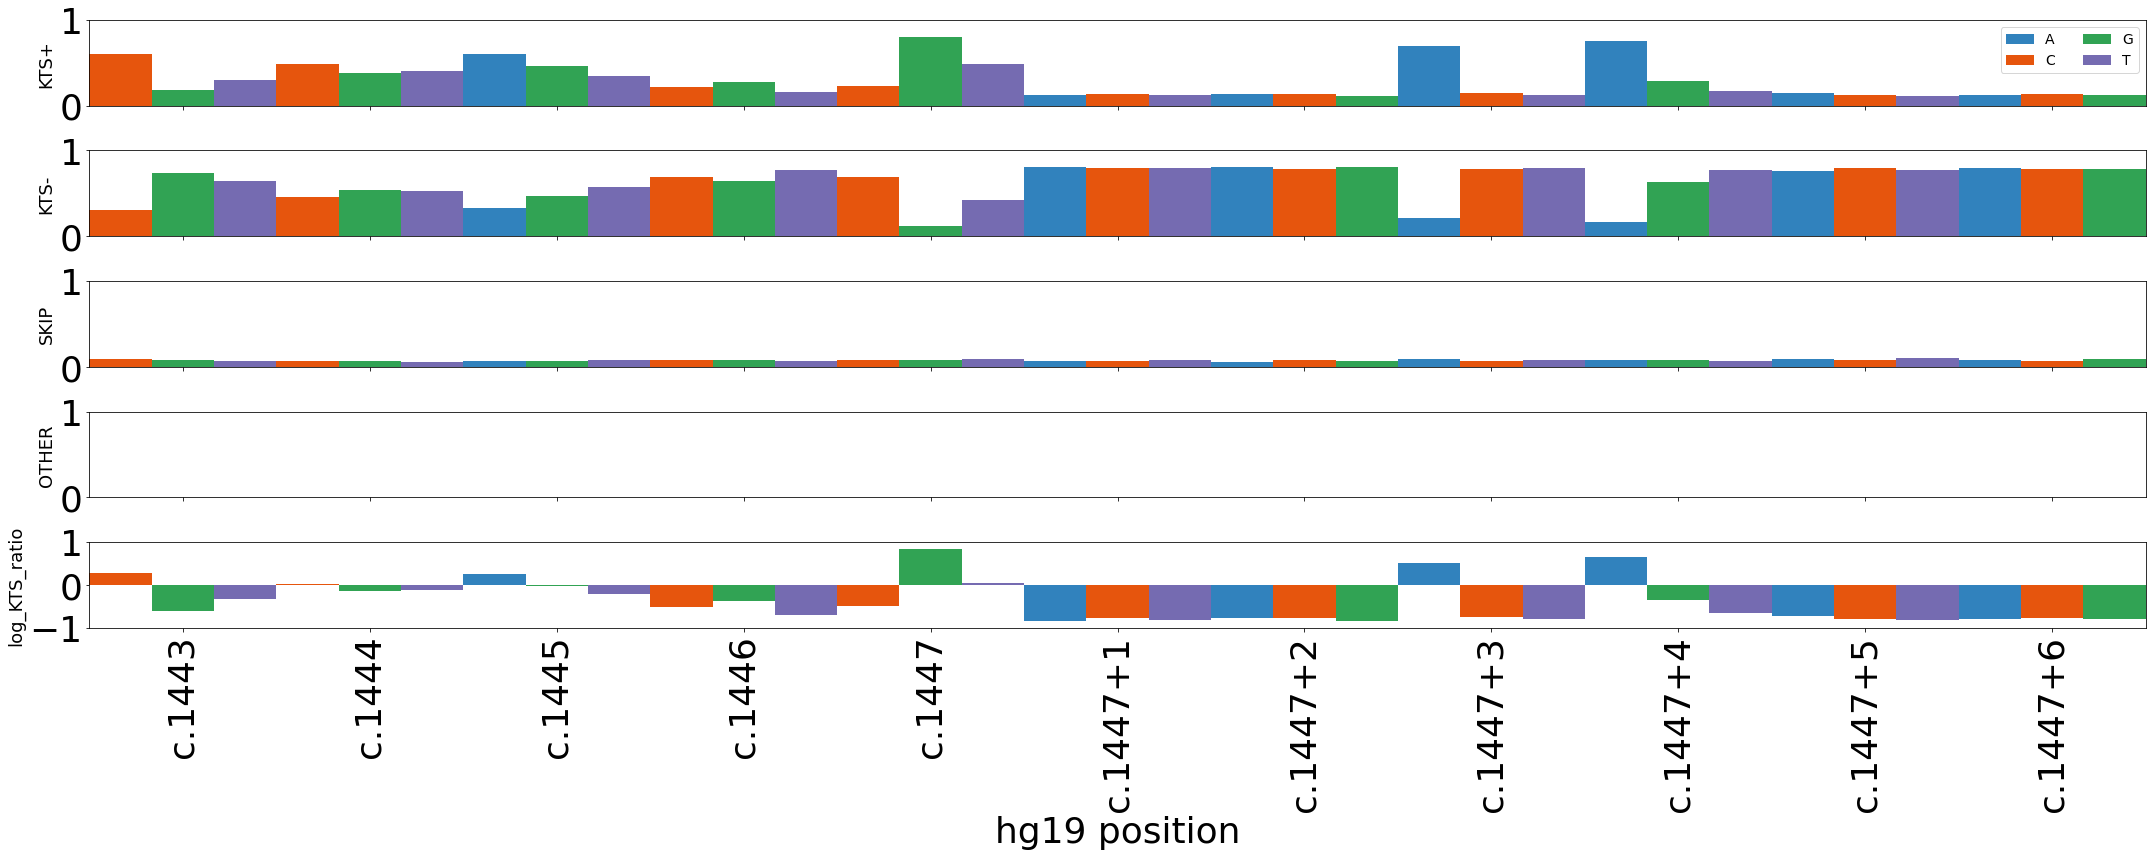

In [160]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                         [ col for col in byvartbl_wide_sat if col.startswith( 'wmean_' ) ] + [ 'KTS_+_ratio_log10' ],
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 12 ),
                          zoom = ( 1355, 1365 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -1, 1 ) ],
                          y_ax_title = [ col[ 5: ] for col in byvartbl_wide_sat if col.startswith( 'mean_' ) ] + [ 'log_KTS_ratio' ], 
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

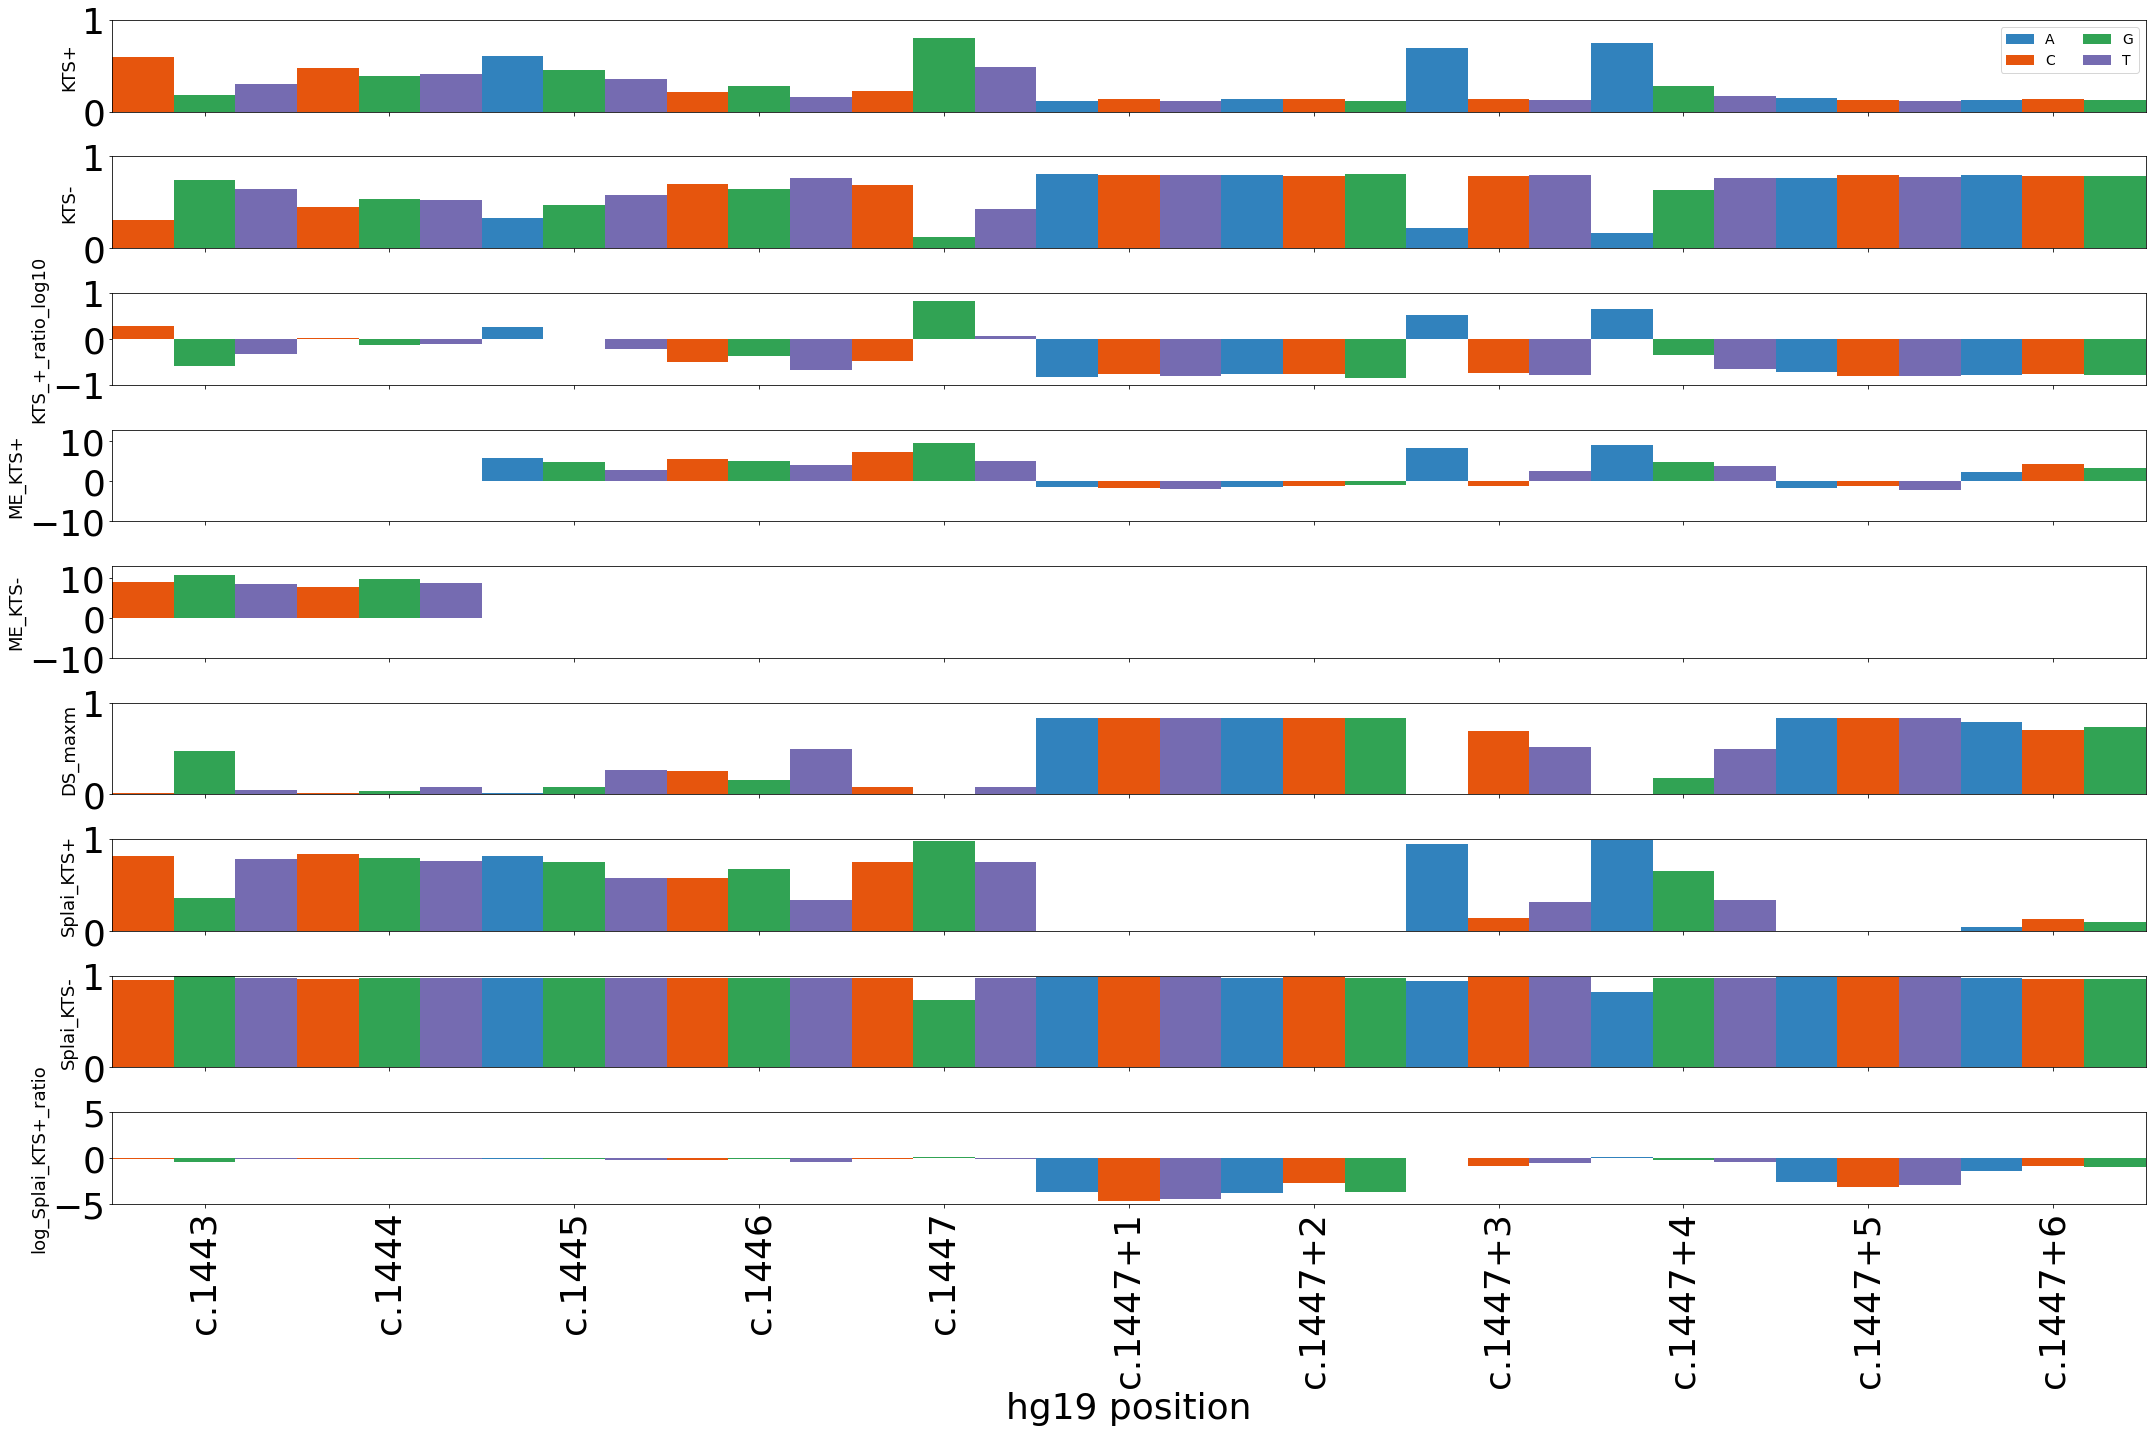

In [161]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          plot_KTS_cols,
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 20 ),
                          zoom = ( 1355, 1365 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( -1, 1 ), ( -10, 13 ), ( -10, 13 ),  ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ 'KTS+','KTS-','KTS_+_ratio_log10', 'ME_KTS+','ME_KTS-','DS_maxm','Splai_KTS+','Splai_KTS-', 'log_Splai_KTS+_ratio' ],
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

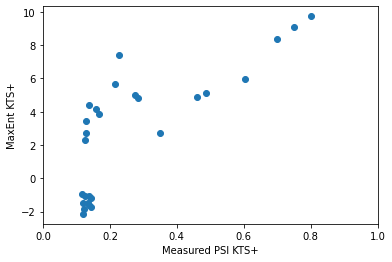

In [162]:
plt.scatter( byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1357 ) & ( byvartbl_wide.pos <= 1365 ) ][ 'wmean_KTS+' ],
             byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1357 ) & ( byvartbl_wide.pos <= 1365 ) ][ 'maxent_KTS+' ],
              )

plt.xlim( ( 0, 1 ) )

plt.ylabel( 'MaxEnt KTS+' )
plt.xlabel( 'Measured PSI KTS+' )
plt.show()

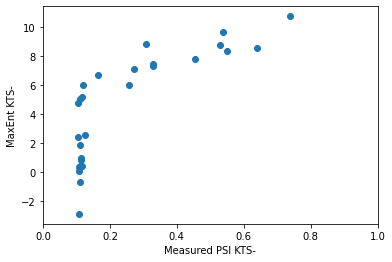

In [163]:
plt.scatter( byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1348 ) & ( byvartbl_wide.pos <= 1356 ) ][ 'wmean_KTS-' ],
             byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1348 ) & ( byvartbl_wide.pos <= 1356 ) ][ 'maxent_KTS-' ],
              )

plt.ylabel( 'MaxEnt KTS-' )
plt.xlabel( 'Measured PSI KTS-' )

plt.xlim( ( 0, 1 ) )
plt.show()

In [164]:
byvartbl_wide[ 'maxent_KTS+_nomiss' ] = [ me if not np.isnan( me ) else float( maxent_wt.loc[ maxent_wt.pos == 32413518 ].	maxent_wt_don )
                                          for me in byvartbl_wide[ 'maxent_KTS+' ] ]

In [165]:
byvartbl_wide[ 'maxent_KTS-_nomiss' ] = [ me if not np.isnan( me ) else float( maxent_wt.loc[ maxent_wt.pos == 32413527 ].	maxent_wt_don )
                                          for me in byvartbl_wide[ 'maxent_KTS-' ] ]

In [166]:
me_model_df = byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1348 ) & ( byvartbl_wide.pos <= 1365 ) ].copy()

In [167]:
me_model = LinearRegression().fit( me_model_df[ [ 'maxent_KTS+_nomiss', 'maxent_KTS-_nomiss' ] ],
                                   me_model_df[ 'KTS_+_ratio_log10' ] )

In [168]:
me_model.score( me_model_df[ [ 'maxent_KTS+_nomiss', 'maxent_KTS-_nomiss' ] ],
                me_model_df[ 'KTS_+_ratio_log10' ] )

0.8259572100530858

In [169]:
me_model.coef_

array([ 0.11588486, -0.10998906])

In [170]:
me_model.intercept_

0.2121476378891481

In [171]:
me_model_df[ 'me_pred_KTS_+_ratio_log10' ] = me_model.predict( me_model_df[ [ 'maxent_KTS+_nomiss', 'maxent_KTS-_nomiss' ] ] )

(-1.0, 1.5)

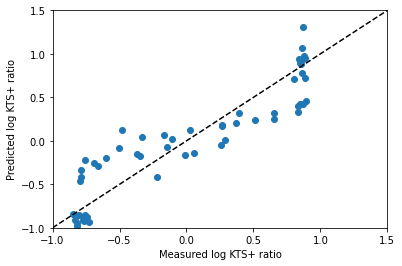

In [172]:
plt.plot( np.linspace( -1, 1.5 ), 
          np.linspace( -1, 1.5 ),
          c = 'black',
          ls = '--' )

plt.scatter( me_model_df[ 'KTS_+_ratio_log10' ],
             me_model_df[ 'me_pred_KTS_+_ratio_log10' ] )

plt.xlabel( 'Measured log KTS+ ratio' )
plt.xlim( ( -1, 1.5 ) )

plt.ylabel( 'Predicted log KTS+ ratio' )
plt.ylim( ( -1, 1.5 ) )

In [173]:
me_model_df[ 'me_error' ] = me_model_df[ 'me_pred_KTS_+_ratio_log10' ] - me_model_df[ 'KTS_+_ratio_log10' ]

In [174]:
me_model_df[ 'me_error_sq' ] = me_model_df[ 'me_error' ]**2

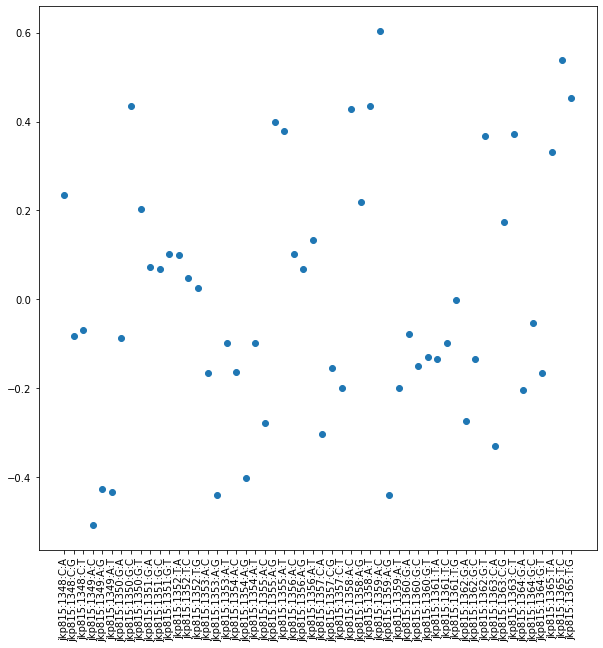

In [175]:
plt.figure( figsize = ( 10, 10 ) )

plt.scatter( me_model_df.varlist,
             me_model_df.me_error )

plt.xticks( rotation = 90 )

plt.show()

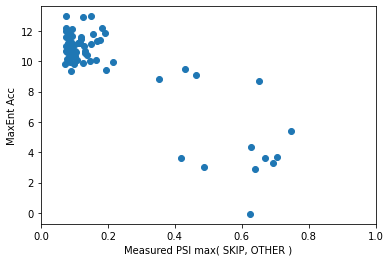

In [176]:
plt.scatter( byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1247 ) & ( byvartbl_wide.pos <= 1269 ) ][ [ 'wmean_OTHER', 'wmean_SKIP' ] ].max( axis = 1 ),
             byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1247 ) & ( byvartbl_wide.pos <= 1269 ) ][ 'maxent_acc' ],
              )

plt.ylabel( 'MaxEnt Acc' )
plt.xlabel( 'Measured PSI max( SKIP, OTHER )' )

plt.xlim( ( 0, 1 ) )
plt.show()

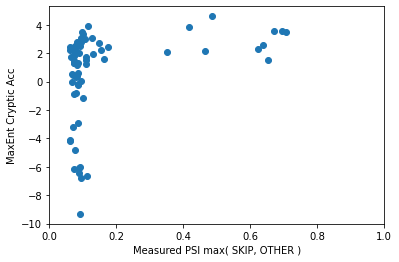

In [177]:
plt.scatter( byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1264 ) & ( byvartbl_wide.pos <= 1286 ) ][ [ 'wmean_OTHER', 'wmean_SKIP' ] ].max( axis = 1 ),
             byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1264 ) & ( byvartbl_wide.pos <= 1286 ) ][ 'maxent_alt_acc' ],
              )

plt.ylabel( 'MaxEnt Cryptic Acc' )
plt.xlabel( 'Measured PSI max( SKIP, OTHER )' )

plt.xlim( ( 0, 1 ) )
plt.show()

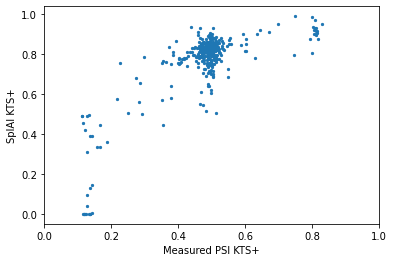

In [178]:
plt.scatter( byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1257 ) ][ 'wmean_KTS+' ],
             byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1257 ) ][ 'ss_don_prob_32413518' ],
             s = 5
              )

plt.xlim( ( 0, 1 ) )

plt.ylabel( 'SplAI KTS+' )
plt.xlabel( 'Measured PSI KTS+' )
plt.show()

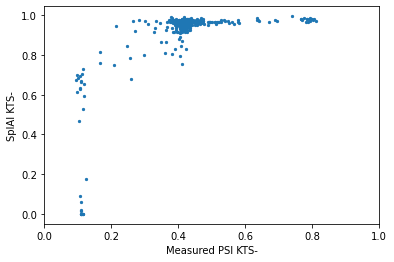

In [179]:
plt.scatter( byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1248 ) ][ 'wmean_KTS-' ],
             byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1248 ) ][ 'ss_don_prob_32413527' ],
             s = 5
              )

plt.xlim( ( 0, 1 ) )

plt.ylabel( 'SplAI KTS-' )
plt.xlabel( 'Measured PSI KTS-' )
plt.show()

In [180]:
splai_model = LinearRegression().fit( me_model_df[ [ 'ss_don_prob_32413518', 'ss_don_prob_32413527' ] ],
                                      me_model_df[ 'KTS_+_ratio_log10' ] )

In [181]:
splai_model.score( me_model_df[ [ 'ss_don_prob_32413518', 'ss_don_prob_32413527' ] ],
                   me_model_df[ 'KTS_+_ratio_log10' ] )

0.9102713458214016

In [182]:
splai_model.coef_

array([ 1.22010522, -0.76345371])

In [183]:
splai_model.intercept_

-0.1476364149654909

In [184]:
me_model_df[ 'splai_pred_KTS_+_ratio_log10' ] = splai_model.predict( me_model_df[ [ 'ss_don_prob_32413518', 'ss_don_prob_32413527' ] ] )

(-1.0, 1.0)

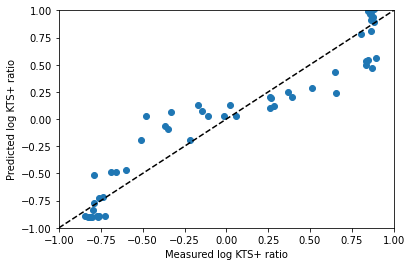

In [185]:
plt.plot( np.linspace( -1, 1 ), 
          np.linspace( -1, 1 ),
          c = 'black',
          ls = '--' )

plt.scatter( me_model_df[ 'KTS_+_ratio_log10' ],
             me_model_df[ 'splai_pred_KTS_+_ratio_log10' ] )

plt.xlabel( 'Measured log KTS+ ratio' )
plt.xlim( ( -1, 1 ) )

plt.ylabel( 'Predicted log KTS+ ratio' )
plt.ylim( ( -1, 1 ) )

In [186]:
me_model_df[ 'splai_error' ] = me_model_df[ 'splai_pred_KTS_+_ratio_log10' ] - me_model_df[ 'KTS_+_ratio_log10' ]

In [187]:
me_model_df[ 'splai_error_sq' ] = me_model_df[ 'splai_error' ]**2

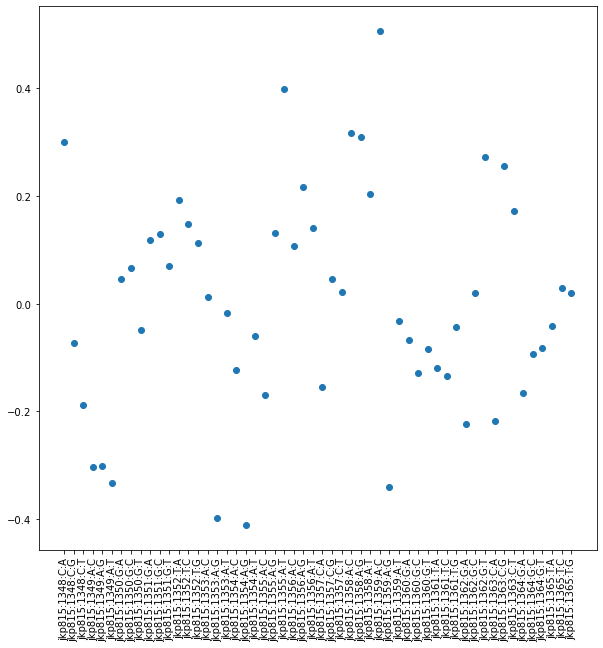

In [188]:
plt.figure( figsize = ( 10, 10 ) )

plt.scatter( me_model_df.varlist,
             me_model_df.splai_error, )

plt.xticks( rotation = 90 )

plt.show()

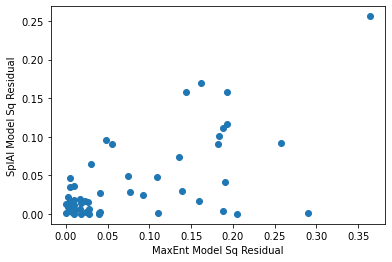

In [189]:
plt.scatter( me_model_df.me_error_sq,
             me_model_df.splai_error_sq,
             )

plt.xlabel( 'MaxEnt Model Sq Residual' )
plt.ylabel( 'SplAI Model Sq Residual' )

plt.show()

In [190]:
view_cols = [ 'pos', 'hg19_pos', 'hgvs_pos', 'ref', 'alt', 'wmean_KTS+', 'wmean_KTS-', 'KTS_+_ratio_log10', 'maxent_KTS+_nomiss', 'maxent_KTS-_nomiss', 'me_error_sq', 'ss_don_prob_32413518', 'ss_don_prob_32413527', 'splai_error_sq', ]

In [191]:
me_model_df.loc[ ( me_model_df.me_error_sq >= .15 ) & ( me_model_df.splai_error_sq >= .2 ) ][ view_cols ]

pos  hg19_pos hgvs_pos ref alt  wmean_KTS+  wmean_KTS-  \
395  1359  32413518   c.1447   T   G    0.227512    0.688298   

     KTS_+_ratio_log10  maxent_KTS+_nomiss  maxent_KTS-_nomiss  me_error_sq  \
395          -0.480772            7.385741            8.594409     0.364241   

     ss_don_prob_32413518  ss_don_prob_32413527  splai_error_sq  
395               0.75339              0.977641        0.256002

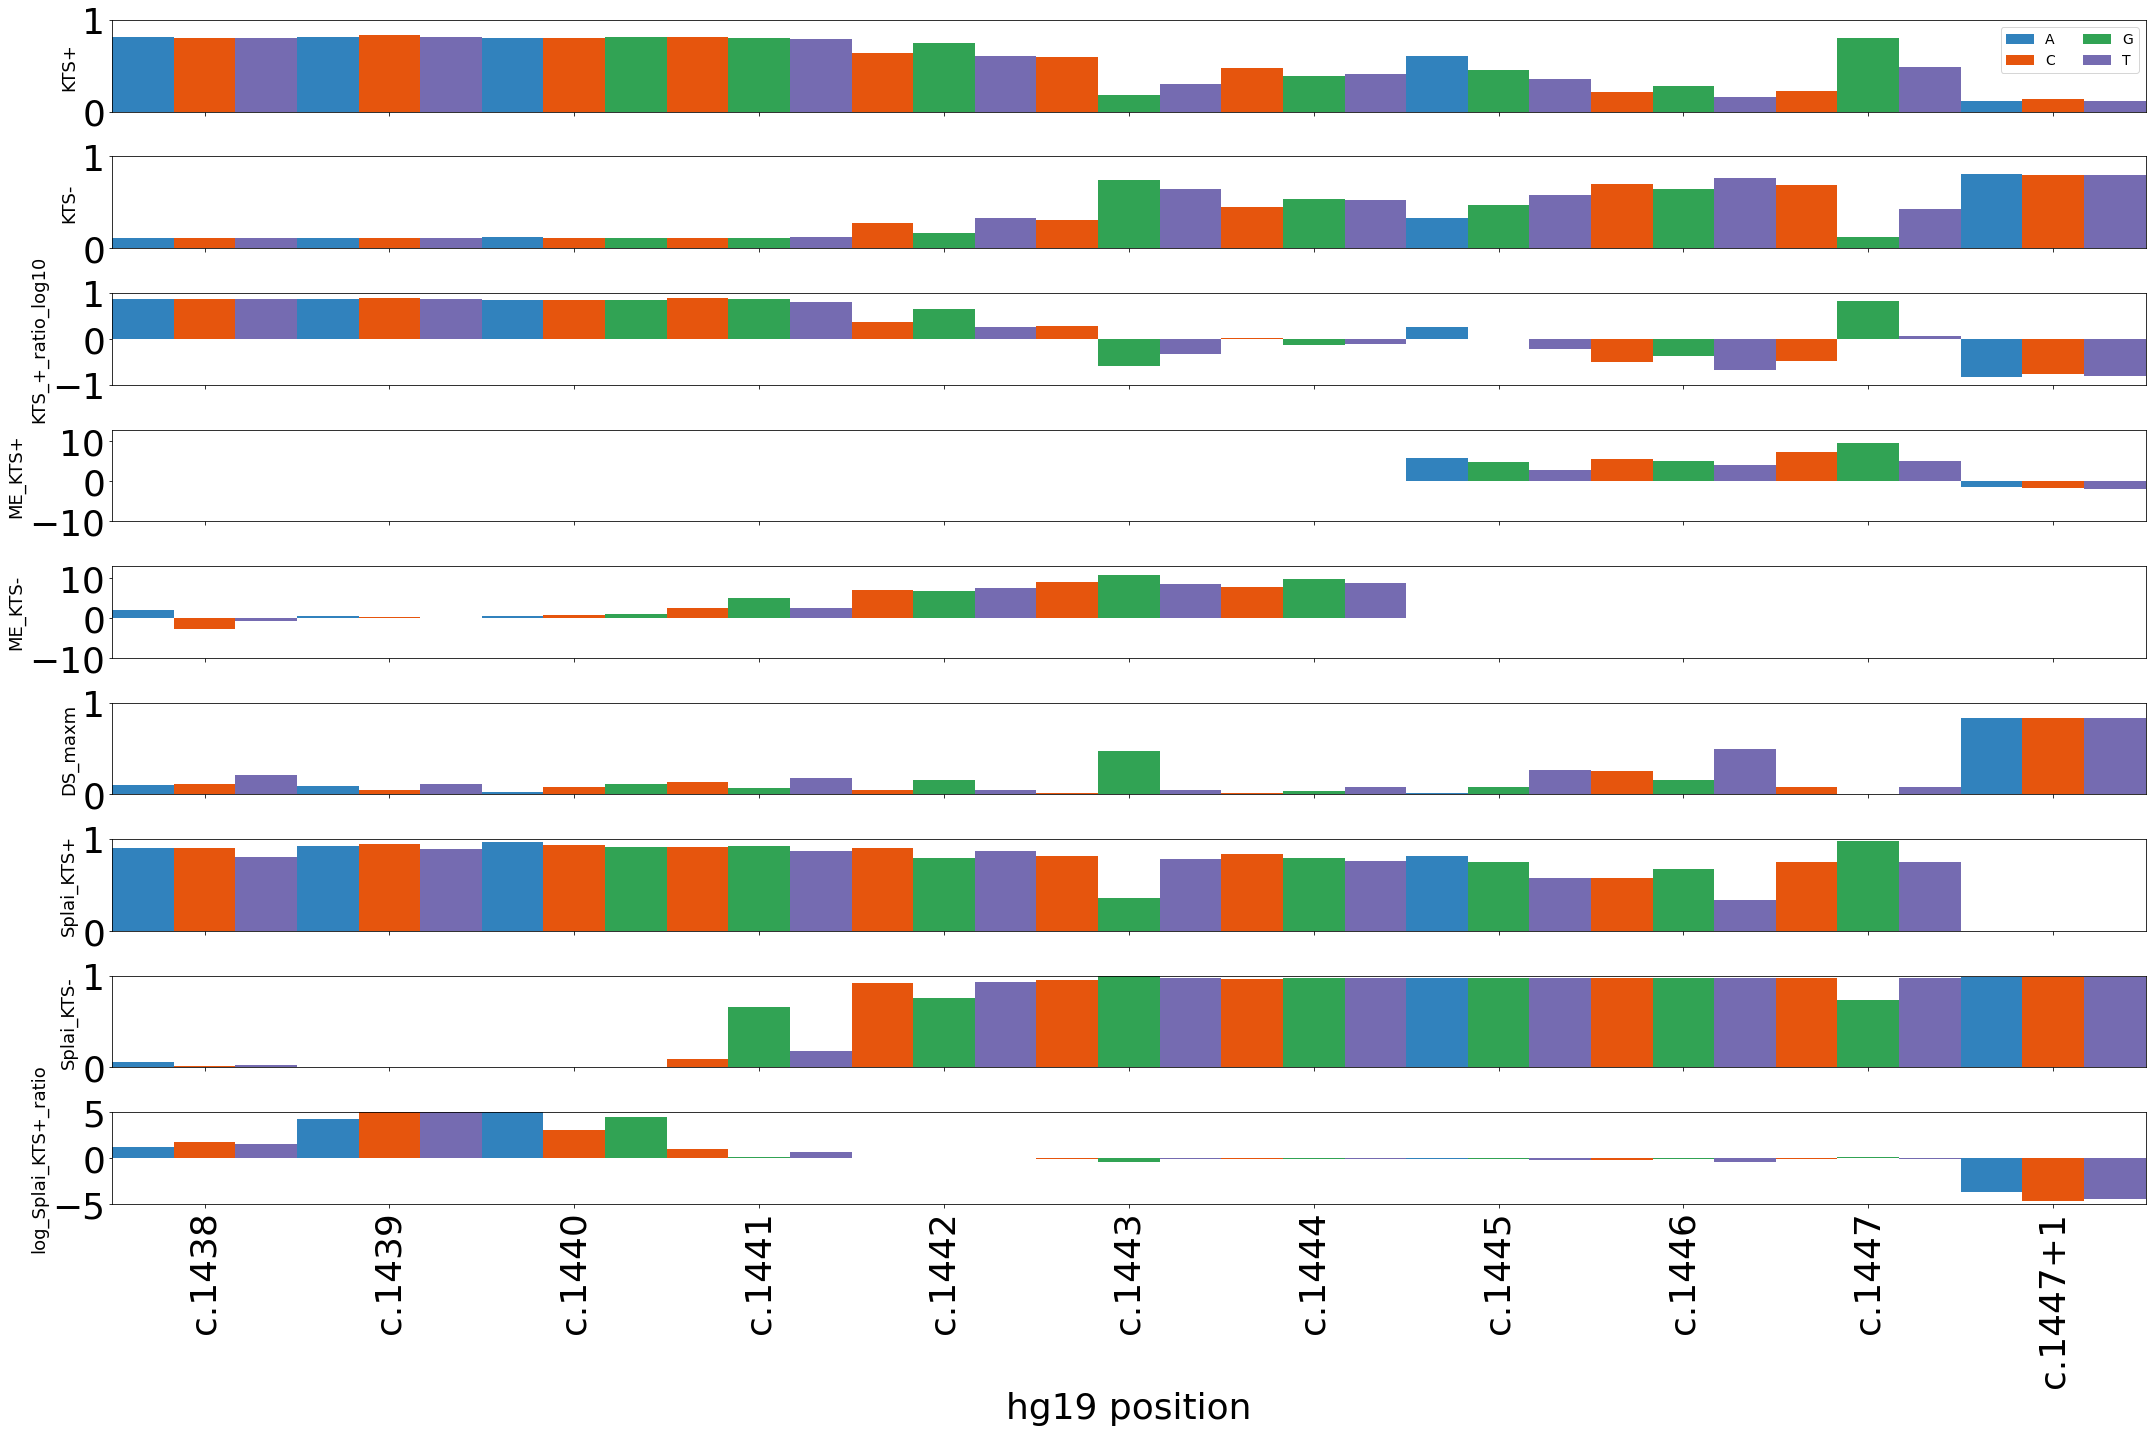

In [192]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          plot_KTS_cols,
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 20 ),
                          zoom = ( 1350, 1360 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( -1, 1 ), ( -10, 13 ), ( -10, 13 ),  ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ 'KTS+','KTS-','KTS_+_ratio_log10', 'ME_KTS+','ME_KTS-','DS_maxm','Splai_KTS+','Splai_KTS-', 'log_Splai_KTS+_ratio' ],
                          x_ax_title = 'hg19 position',
                          tick_spacing = 1,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

In [193]:
me_model_df.loc[ ( ( me_model_df.me_error_sq <= .02 ) | ( me_model_df.splai_error_sq <= .02 ) ) & ( me_model_df[ 'KTS_+_ratio_log10' ].abs() >= .9 ) ][ view_cols ]

Empty DataFrame
Columns: [pos, hg19_pos, hgvs_pos, ref, alt, wmean_KTS+, wmean_KTS-, KTS_+_ratio_log10, maxent_KTS+_nomiss, maxent_KTS-_nomiss, me_error_sq, ss_don_prob_32413518, ss_don_prob_32413527, splai_error_sq]
Index: []

In [194]:
me_model_df.loc[ ( ( me_model_df.me_error_sq <= .025 ) | ( me_model_df.splai_error_sq <= .025 ) ) & ( me_model_df[ 'KTS_+_ratio_log10' ].abs() < .8 ) & ( me_model_df[ 'KTS_+_ratio_log10' ].abs() >= .6 ) ][ view_cols ]

pos  hg19_pos  hgvs_pos ref alt  wmean_KTS+  wmean_KTS-  \
399  1360  32413517  c.1447+1   C   G    0.136323    0.799586   
401  1361  32413516  c.1447+2   A   T    0.134881    0.801456   
402  1361  32413516  c.1447+2   A   G    0.136681    0.784506   
405  1362  32413515  c.1447+3   C   G    0.142844    0.784621   
413  1365  32413512  c.1447+6   A   T    0.126882    0.795256   
414  1365  32413512  c.1447+6   A   G    0.137208    0.789391   
415  1365  32413512  c.1447+6   A   C    0.127387    0.781592   

     KTS_+_ratio_log10  maxent_KTS+_nomiss  maxent_KTS-_nomiss  me_error_sq  \
399          -0.768295           -1.594522            8.594409     0.022389   
401          -0.773930           -1.505308            8.594409     0.017864   
402          -0.758889           -1.076043            8.594409     0.009791   
405          -0.739797           -1.206201            8.594409     0.017723   
413          -0.797106            2.313485            8.594409     0.110264   
414          -0.759912            4.411176            8.594409     0.289398   
415          -0.787854            3.430402            8.594409     0.204523   

     ss_don_prob_32413518  ss_don_prob_32413527  splai_error_sq  
399              0.000021              0.982750        0.016796  
401              0.000163              0.975934        0.014063  
402              0.001890              0.980536        0.018235  
405              0.145228              0.981146        0.000412  
413              0.041144              0.971088        0.001740  
414              0.128392              0.968035        0.000893  
415              0.096952              0.967427        0.000397

In [195]:
 me_model_df.loc[ ( ( me_model_df.pos == 1362 ) | ( me_model_df.pos == 1363 ) ) & ( me_model_df.alt == 'T' ) ][ view_cols ]

pos  hg19_pos  hgvs_pos ref alt  wmean_KTS+  wmean_KTS-  \
404  1362  32413515  c.1447+3   C   T    0.698575    0.214585   
407  1363  32413514  c.1447+4   G   T    0.748652    0.166996   

     KTS_+_ratio_log10  maxent_KTS+_nomiss  maxent_KTS-_nomiss  me_error_sq  \
404           0.512614            8.395992            8.594409     0.074414   
407           0.651574            9.095315            8.594409     0.109367   

     ss_don_prob_32413518  ss_don_prob_32413527  splai_error_sq  
404              0.950712              0.946856        0.049802  
407              0.987518              0.817881        0.047851

In [196]:
me_model_df.loc[ ( me_model_df.pos == 1349 ) ][ view_cols ]

pos  hg19_pos hgvs_pos ref alt  wmean_KTS+  wmean_KTS-  \
365  1349  32413528   c.1437   T   G    0.809002    0.118463   
366  1349  32413528   c.1437   T   C    0.811079    0.116032   
367  1349  32413528   c.1437   T   A    0.818864    0.104689   

     KTS_+_ratio_log10  maxent_KTS+_nomiss  maxent_KTS-_nomiss  me_error_sq  \
365           0.834366            6.678108            5.997953     0.258101   
366           0.844486            6.678108            5.164177     0.181859   
367           0.893312            6.678108            4.784083     0.187896   

     ss_don_prob_32413518  ss_don_prob_32413527  splai_error_sq  
365              0.928872              0.594737        0.091648  
366              0.896347              0.528296        0.091092  
367              0.871419              0.466402        0.111423

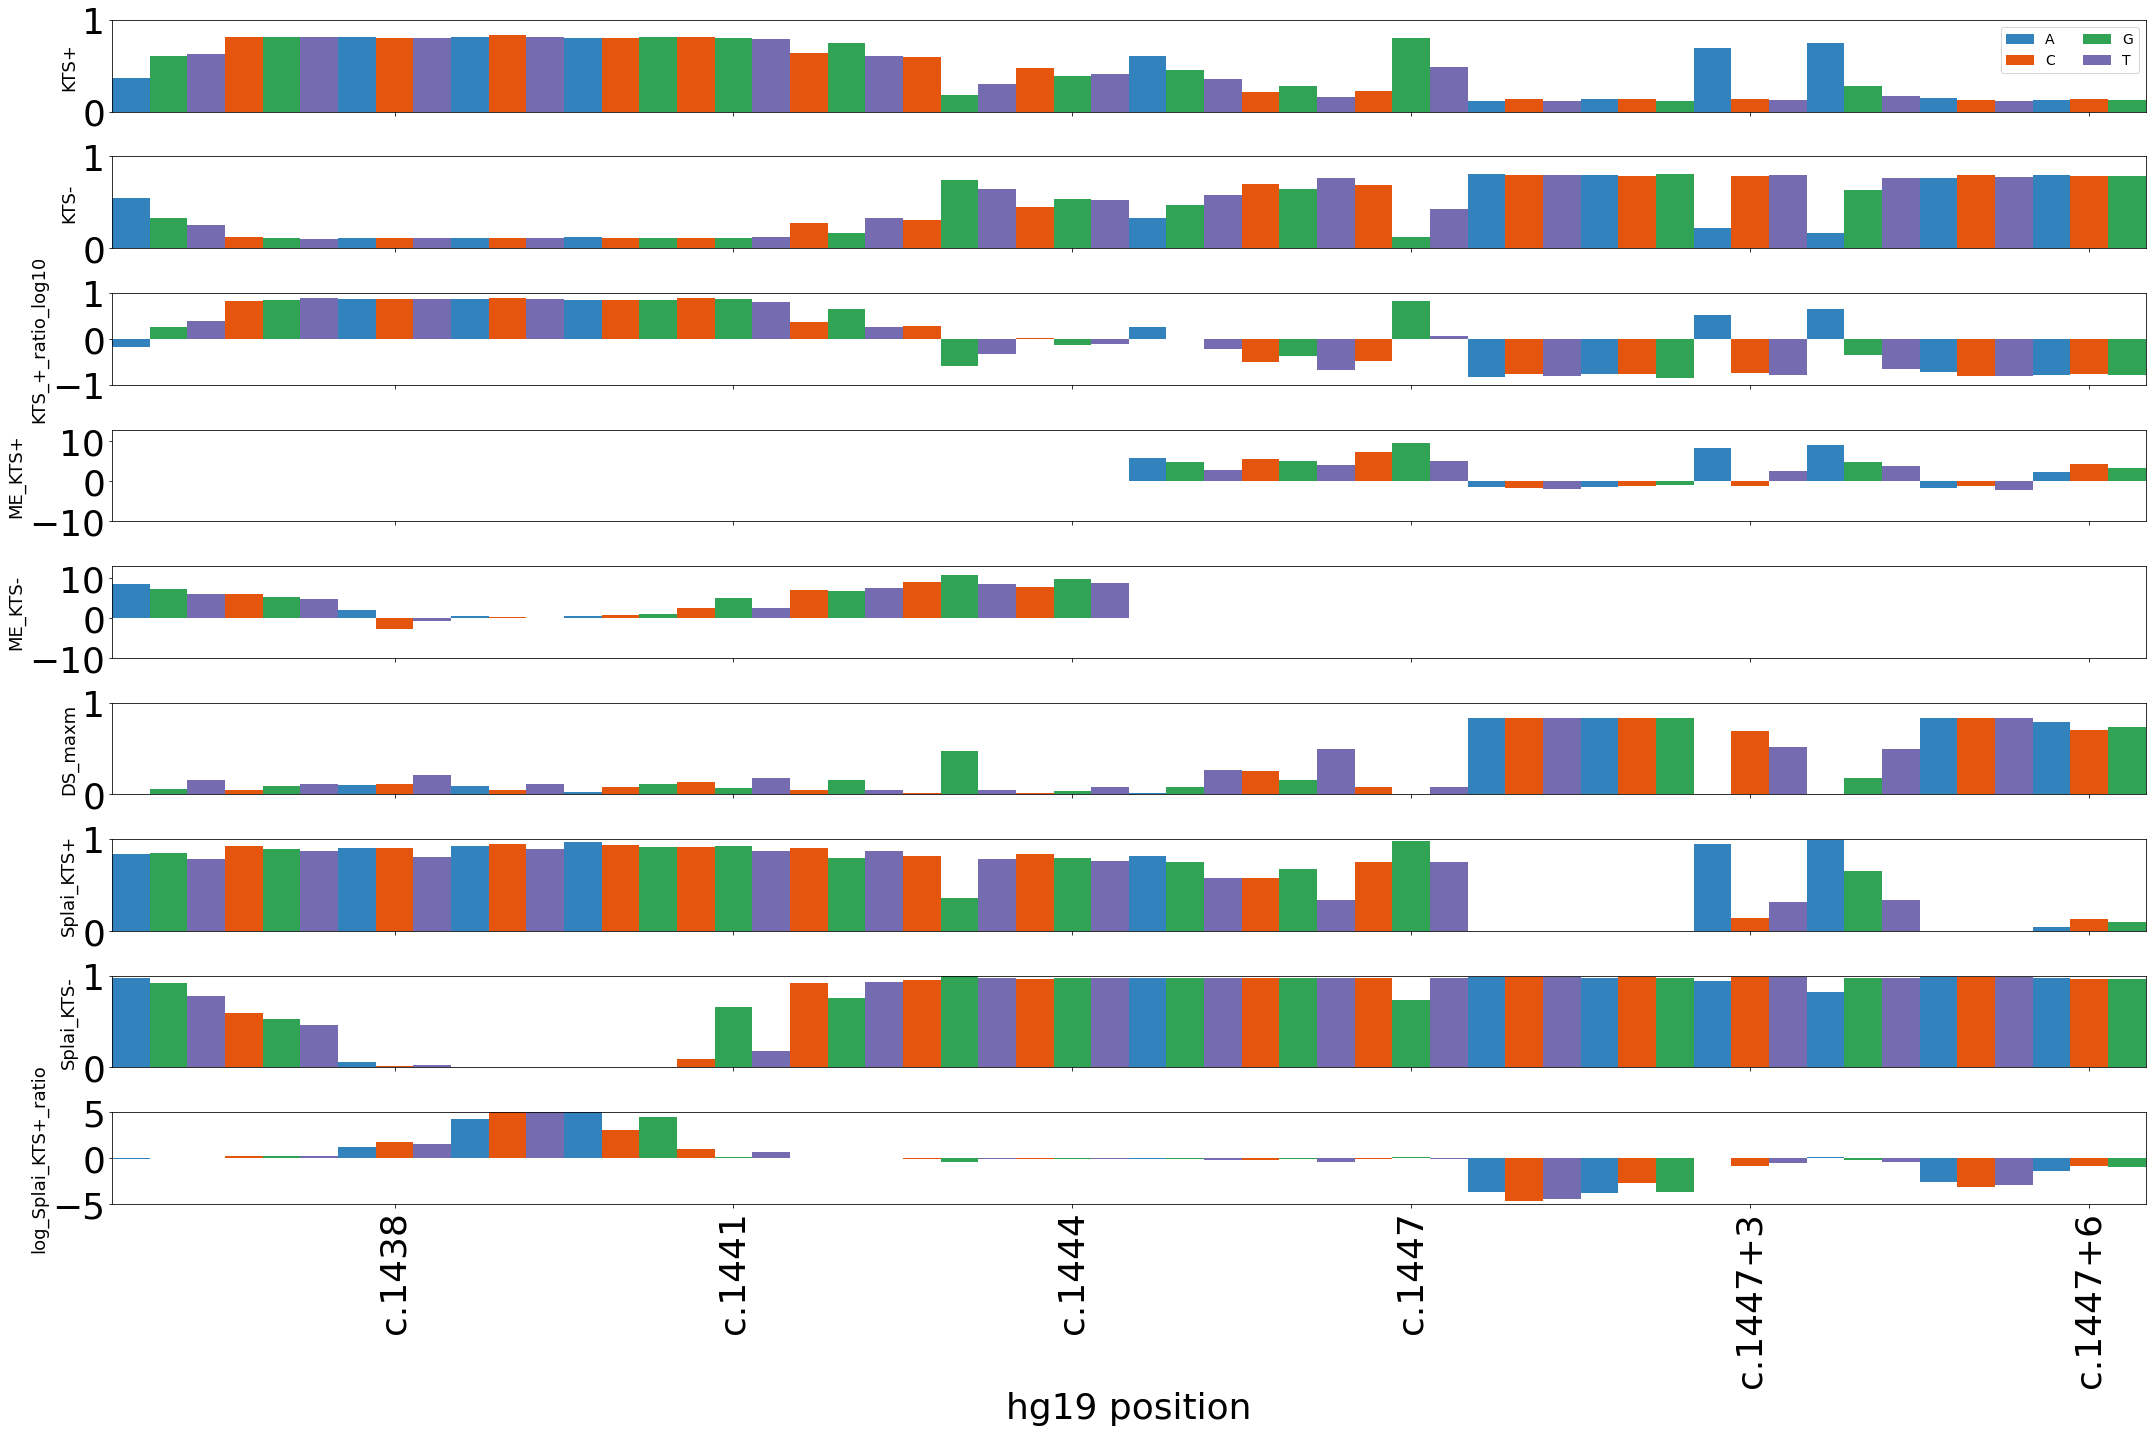

In [197]:
sp.sat_subplots_wrapper( byvartbl_wide_sat.rename( columns = { 'alt': 'a',
                                                               'ref': 'r',
                                                               'alt_c': 'alt',
                                                               'ref_c': 'ref' } ),
                          plot_KTS_cols,
                         'hgvs_pos',
                          [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ],
                          fig_size = ( 30, 20 ),
                          zoom = ( 1348, 1365 ),
                          share_y = False,
                          #legend = False,
                          #darken_bars = [ ( 'sdv_fc2', [ l for idx,l in enumerate( light_colors ) if idx%4 == 0 ] ) ],
                          y_ax_lim = [ ( 0, 1 ), ( 0, 1 ), ( -1, 1 ), ( -10, 13 ), ( -10, 13 ),  ( 0, 1 ), ( 0, 1 ), ( 0, 1 ), ( -5, 5 ) ],
                          y_ax_title = [ 'KTS+','KTS-','KTS_+_ratio_log10', 'ME_KTS+','ME_KTS-','DS_maxm','Splai_KTS+','Splai_KTS-', 'log_Splai_KTS+_ratio' ],
                          x_ax_title = 'hg19 position',
                          tick_spacing = 3,
                          #savefile = '/nfs/kitzman2/smithcat/proj/spliceAI/plots/fas_tracks.pdf'
                     )

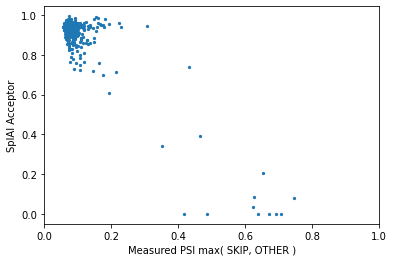

In [198]:
plt.scatter( byvartbl_wide.loc[ ( byvartbl_wide.pos <= 1369 ) ][ [ 'wmean_OTHER', 'wmean_SKIP' ] ].max( axis = 1 ),
             byvartbl_wide.loc[ ( byvartbl_wide.pos <= 1369 ) ][ 'ss_acc_prob_32413610' ],
             s = 5
              )

plt.xlim( ( 0, 1 ) )

plt.ylabel( 'SplAI Acceptor' )
plt.xlabel( 'Measured PSI max( SKIP, OTHER )' )
plt.show()

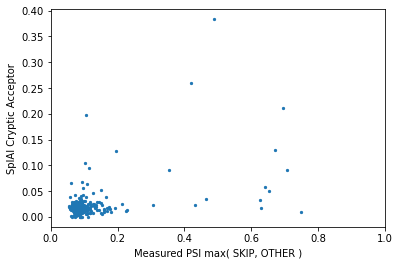

In [199]:
plt.scatter( byvartbl_wide.loc[ ( byvartbl_wide.pos <= 1369 ) ][ [ 'wmean_OTHER', 'wmean_SKIP' ] ].max( axis = 1 ),
             byvartbl_wide.loc[ ( byvartbl_wide.pos <= 1369 ) ][ 'ss_acc_prob_32413593' ],
             s = 5
              )

plt.xlim( ( 0, 1 ) )

plt.ylabel( 'SplAI Cryptic Acceptor' )
plt.xlabel( 'Measured PSI max( SKIP, OTHER )' )
plt.show()

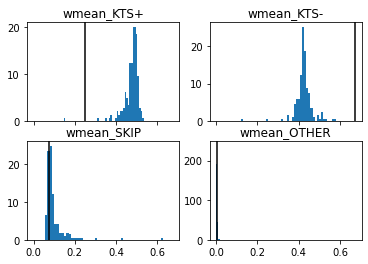

In [201]:
fig,ax = plt.subplots( 2, 2, sharex = True, 
                      #sharey = True
                     )

psi_cols = [ col for col in byvartbl_wide if col.startswith( 'wmean_' ) ]

for i,col in enumerate( psi_cols ):
    
    r,c = i // 2,i % 2
    
    ax[ r ][ c ].hist( byvartbl_wide.loc[ ( byvartbl_wide.pos >= 1369 ) | ( byvartbl_wide.pos <= 1257 ) ][ col ],
                       bins = 50,
                       density = True )
    
    ax[ r ][ c ].axvline( float( byvartbl_wide.loc[ ( byvartbl_wide.hgvs_pos == 'c.1447+7' ) & ( byvartbl_wide.alt == 'G' ) ][ col ] ),
                          c = 'black' )
    
    ax[ r ][ c ].set_title( col )
    
plt.show()

In [202]:
byvartbl_long.to_csv( bdout + 'wt1_ex9_by_var_effects_snvs-2022-0713.txt',
                      sep = '\t',
                      index = False )

In [203]:
byvartbl_wide.to_csv( bdout + 'wt1_ex9_by_var_effects_snvs_wide-2022-0713.txt',
                      sep = '\t',
                      index = False )

In [204]:
byvartbl_wide[ [ 'hg19_pos', 'ref', 'alt', 'pos', 'ref_c', 'alt_c', 'varlist', 'hgvs_pos', 'n_bc_med', 'n_bc_passfilt_med',
                 'sum_reads_med', 'sum_reads_passfilt_med', 'sum_reads_sum', 'sum_reads_passfilt_sum', 'n_bc_max',
                 'n_bc_passfilt_max', 'sum_reads_max', 'sum_reads_passfilt_max', 'wmean_KTS+', 'wmean_KTS-', 'wmean_SKIP',
                 'wmean_OTHER', 'KTS_+_ratio', 'KTS_+_ratio_log10', 'DS_maxm', 'DS_maxm_type', 'POS_maxm', ] ].to_csv( bdout + 'wt1_ex9_by_var_effects_snvs_wide_keyvars-2022-0713.txt',
                      sep = '\t',
                      index = False )